### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']


In [2]:
from datetime import datetime, timedelta
import os
import yaml
import sqlite3
import json
from collections import Counter
import uuid
from typing import TypedDict, Annotated
import subprocess
import requests

import operator
import pickle

import langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

from langchain_core.output_parsers import SimpleJsonOutputParser, JsonOutputParser, StrOutputParser

from langgraph.graph import StateGraph, START, END

from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

import numpy as np
import pandas as pd
import umap

import sklearn
from sklearn.cluster import DBSCAN

import bs4
from urllib.parse import urljoin, urlparse

import multiprocessing
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

import openai
from openai import OpenAI

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate


import dotenv
VERBOSE=1
from ainb_const import (DOWNLOAD_DIR, PAGES_DIR,
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT, 
                        TOP_CATEGORIES_PROMPT, REWRITE_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB,
                        HOSTNAME_SKIPLIST, SITE_NAME_SKIPLIST, TOPSOURCES
                       )
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article,
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file,
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory,
                            process_url_queue_factory, get_google_news_redirects)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, count_tokens, trunc_tokens, 
                      categorize_headline, categorize_df, clean_topics,
                      get_site_name, fetch_missing_site_names)


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")


Python            3.11.10 | packaged by conda-forge | (main, Sep 10 2024, 10:57:35) [Clang 17.0.6 ]
LangChain         0.3.3
OpenAI            1.52.0
trafilatura       1.12.2
numpy             1.26.4
pandas            2.2.3
sklearn           1.5.2
umap              0.5.6


# Test LLM calling

In [4]:
# a basic LLM call with langchain
model = ChatOpenAI(model=MODEL)

model.invoke([
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content='Listen to me. You are beautiful. You are perfect and I love you.'),
])


2024-10-20 12:31:28,727 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='Ascoltami. Sei bellissima. Sei perfetta e ti amo.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 34, 'total_tokens': 50, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'chatgpt-4o-latest', 'system_fingerprint': 'fp_acb916eaac', 'finish_reason': 'stop', 'logprobs': None}, id='run-cb2b407e-f631-4631-989a-8b717cd7f9bf-0', usage_metadata={'input_tokens': 34, 'output_tokens': 16, 'total_tokens': 50, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [5]:
# use a langchain template
system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)
parser = StrOutputParser()
chain = prompt_template | model | parser
chain.invoke({"language": "italian", "text": "hi"})


2024-10-20 12:31:35,036 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Ciao'

In [6]:
# time multiple templants (single-threaded)
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


2024-10-20 12:31:35,414 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.

2024-10-20 12:31:36,070 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.

2024-10-20 12:31:36,514 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Escúchame. Eres perfecta. Eres hermosa y te amo.

2024-10-20 12:31:37,086 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ascoltami. Sei incredibile. Sei magnifico/a e ti amo.

2024-10-20 12:31:37,886 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Figyelj rám. Elbűvölő vagy. Gyönyörű vagy, és szeretlek.

Elapsed seconds: 3.076545


In [7]:
# same but send all at once using asyncio

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response


prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


2024-10-20 12:31:38,742 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-20 12:31:38,749 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-20 12:31:38,760 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-20 12:31:38,769 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-20 12:31:39,654 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Elapsed seconds: 1.521640
Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.
Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.
Escúchame. Eres perfecta. Eres hermosa y te amo.
Ascoltami. Sei incredibile. Sei magnifico/a e ti amo.
Figyelj rám. Elbűvölő vagy. Lenyűgöző vagy, és szeretlek.


In [8]:
# test o1-preview, note temperature, system prompt not supported
# client = OpenAI()
# response = client.chat.completions.create(
#     model="o1-preview",
#     messages=[
#         {
#             "role": "user",
#             "content": "Write a Python script that takes a matrix represented as a string with format '[1,2],[3,4],[5,6]' and prints the transpose in the same format."
#         }
#     ]
# )
# print(response.choices[0].message.content)


# Functions for state graph
- Each takes a state dict and returns updated state dict
- We will use these later to construct a LangGraph agent workflow

In [10]:
DEBUG = True
N_BROWSERS = 4
MAX_EDITS = 3
before_date = '2024-10-19 15:00:00'
do_download = True


In [11]:
# class to maintain state within graph

class AgentState(TypedDict):
    AIdf: dict                #  the current working set of headlines (pandas dataframe not supported)
    before_date: str          #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool         #  if False use existing files, else download from sources
    sources: dict             #  sources to scrap
    sources_reverse: dict     #  map file names to sources
    bullets: list             #  bullet points for summary email
    summary: str              #  final summary
    cluster_topics: list      #  list of cluster topics
    n_edits: int              #  count edit iterations so we don't keep editing forever
    edit_complete: bool       #  edit will update if no more edits to make
    # message thread with OpenAI
    # messages: Annotated[list[AnyMessage], operator.add]


In [12]:
test_state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'n_edits': 0,
    'edit_complete': False,
#     'messages': None
    }
)


In [13]:
# Initialize reading configurations from YAML file

def fn_initialize(state: AgentState) -> AgentState:
    """
    Initializes the agent state by loading source configurations from SOURCECONFIG (sources.yaml) .

    Args:
        state (AgentState): The current state of the agent.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        AgentState: The updated state of the agent.

    Raises:
        yaml.YAMLError: If there is an error while loading the YAML file.

    """

    #  load sources to scrape from sources.yaml
    with open(SOURCECONFIG, "r") as stream:
        try:
            state['sources'] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    log(f"Initialized {len(state['sources'])} items in sources from {SOURCECONFIG}")

    # make a reverse dict to map file titles to source names
    state['sources_reverse'] = {}
    for k, v in state['sources'].items():
        log(f"{k} -> {v['url']} -> {v['title']}.html")
        v['sourcename'] = k
        # map filename (title) to source name
        state['sources_reverse'][v['title']] = k

    log(f"Initialized {len(state['sources_reverse'])} items in sources_reverse")

    return state


if DEBUG:
    test_state = fn_initialize(test_state)


2024-10-20 12:32:33,769 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2024-10-20 12:32:33,770 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-10-20 12:32:33,770 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-10-20 12:32:33,770 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-10-20 12:32:33,771 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-10-20 12:32:33,771 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-10-20 12:32:33,771 - AInewsbot - INFO - 

In [14]:
# scrape sources with selenium and save local files in DOWNLOAD_DIR (htmldata)
def fn_download_sources(state: AgentState) -> AgentState:
    """
    Scrapes sources and saves HTML files.
    If state["do_download"] is True, deletes all files in DOWNLOAD_DIR (htmldata) and scrapes fresh copies.
    If state["do_download"] is False, uses existing files in DOWNLOAD_DIR.
    Uses state["sources"] for config info on sources to scrape
    For each source, saves the current filename to state["sources"][sourcename]['latest']

    Args:
        state (AgentState): The current state of the agent.
        do_delete (bool, optional): Whether to delete files in DOWNLOAD_DIR. Defaults to True.

    Returns:
        AgentState: The updated state of the agent.
    """

    if state["do_download"]:
        # empty download directories
        delete_files(DOWNLOAD_DIR)
        delete_files(PAGES_DIR)

        # save each file specified from sources
        log(f"Saving HTML files using {N_BROWSERS} browsers")

        # Create a queue for multiprocessing and populate it
        queue = multiprocessing.Queue()
        for item in state["sources"].values():
            queue.put(item)

        # Function to take the queue and pop entries off and process until none are left
        # lets you create an array of functions with different args
        callable = process_source_queue_factory(queue)

        saved_pages = launch_drivers(N_BROWSERS, callable)
        for sourcename, file in saved_pages:
            log(f"Downloaded {sourcename} to {file}")
            state['sources'][sourcename]['latest'] = file
        log(f"Saved {len(saved_pages)} HTML files")

    else:   # use existing files
        log(f"Web fetch disabled, using existing files in {DOWNLOAD_DIR}")
        # Get the current date
        datestr = datetime.now().strftime("%m_%d_%Y")
        files = [os.path.join(DOWNLOAD_DIR, file)
                 for file in os.listdir(DOWNLOAD_DIR)]
        # filter files with today's date ending in .html
        files = [
            file for file in files if datestr in file and file.endswith(".html")]
        log(f"Found {len(files)} previously downloaded files")
        for file in files:
            log(file)

        saved_pages = []
        for file in files:
            filename = os.path.basename(file)
            # locate date like '01_14_2024' in filename
            position = filename.find(" (" + datestr)
            basename = filename[:position]
            # match to source name
            sourcename = state["sources_reverse"].get(basename)
            if sourcename is None:
                log(f"Skipping {basename}, no sourcename metadata")
                continue
            state["sources"][sourcename]['latest'] = file

    return state

if DEBUG:
    test_state = fn_download_sources(test_state)


2024-10-20 12:32:34,439 - AInewsbot - INFO - Saving HTML files using 4 browsers
2024-10-20 12:32:34,462 - AInewsbot - INFO - get_driver - 93979 Initializing webdriver
2024-10-20 12:32:34,463 - AInewsbot - INFO - get_driver - 93979 Initializing webdriver
2024-10-20 12:32:34,463 - AInewsbot - INFO - get_driver - 93979 Initializing webdriver
2024-10-20 12:32:34,464 - AInewsbot - INFO - get_driver - 93979 Initializing webdriver
2024-10-20 12:32:50,908 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-20 12:32:50,908 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-20 12:32:50,908 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-20 12:32:50,909 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-20 12:32:50,909 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-20 12:32:50,909 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-20 12:32:50,909 - AInewsbot - INFO -

2024-10-20 12:34:12,056 - AInewsbot - INFO - get_files(New York Times Technology) - starting get_files https://www.nytimes.com/section/technology
2024-10-20 12:34:20,803 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

2024-10-20 12:34:20,805 - AInewsbot - INFO - get_files(Google News - Technology - Artificial intelligence) - Saving Google News - Technology - Artificial intelligence (10_20_2024 12_34_20 PM).html as utf-8
2024-10-20 12:34:20,810 - AInewsbot - INFO - Processing Reddit
2024-10-20 12:34:20,810

2024-10-20 12:34:57,206 - AInewsbot - INFO - get_files(Washington Post Technology) - Saving Washington Post Technology (10_20_2024 12_34_57 PM).html as utf-8
2024-10-20 12:34:57,209 - AInewsbot - INFO - Quit webdriver
2024-10-20 12:34:58,758 - AInewsbot - INFO - get_files(Feedly AI) - Loading additional infinite scroll items
2024-10-20 12:35:08,770 - AInewsbot - INFO - get_files(Feedly AI) - Loading additional infinite scroll items
2024-10-20 12:35:18,792 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

20

In [15]:
def fn_extract_urls(state: AgentState) -> AgentState:
    """
    Extracts news URLs from the latest HTML files matching the patterns defined in the state['sources'] configuration info.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted URLs stored in state['AIdf'].
    """
    # Parse news URLs and titles from downloaded HTML files
    log("Parsing html files")
    all_urls = []
    for sourcename, sourcedict in state['sources'].items():
        filename = sourcedict.get('latest')
        if not filename:
            log(f"no filename found for {sourcename}")
            continue

        log(sourcename + ' -> ' + filename)
        links = parse_file(state['sources'][sourcename])
        log(f"{len(links)} links found")
        all_urls.extend(links)

    log(f"Saved {len(all_urls)} links")

    # make a pandas dataframe of all the links found
    AIdf = (
        pd.DataFrame(all_urls)
        .groupby("url")
        .first()
        .reset_index()
        .sort_values("src")[["src", "title", "url"]]
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index": "id"})
    )
    state['AIdf'] = AIdf.to_dict(orient='records')

    return state


if DEBUG:
    test_state = fn_extract_urls(test_state)

    # s/b 17 but if some like bloomberg" or wsj are missing, maybe got a robot block
    # if so, download missing ones manually and then re-run fn_extract_urls
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])


2024-10-20 12:35:20,715 - AInewsbot - INFO - Parsing html files
2024-10-20 12:35:20,716 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (10_20_2024 12_33_58 PM).html
2024-10-20 12:35:20,784 - AInewsbot - INFO - parse_file - found 203 raw links
2024-10-20 12:35:20,788 - AInewsbot - INFO - parse_file - found 31 filtered links
2024-10-20 12:35:20,788 - AInewsbot - INFO - 31 links found
2024-10-20 12:35:20,788 - AInewsbot - INFO - Bloomberg Tech -> htmldata/Bloomberg Technology (10_20_2024 12_34_01 PM).html
2024-10-20 12:35:20,808 - AInewsbot - INFO - parse_file - found 202 raw links
2024-10-20 12:35:20,811 - AInewsbot - INFO - parse_file - found 14 filtered links
2024-10-20 12:35:20,811 - AInewsbot - INFO - 14 links found
2024-10-20 12:35:20,811 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider Tech (10_20_2024 12_33_58 PM).html
2024-10-20 12:35:20,833 - AInewsbot - INFO - parse_file - found 309 raw links
2024-10-20 12:35:20,837 - AInewsbot - INFO - parse_file 

16


,id
src,
Ars Technica,24
Bloomberg Tech,11
Business Insider,50
FT Tech,56
Google News,63
Hacker News,25
Hacker News 2,20
HackerNoon,99
NYT Tech,19


In [16]:
# get AI news via newscatcher
# https://docs.newscatcherapi.com/api-docs/endpoints/search-news

newscatcher_sources = ['247wallst.com',
 '9to5mac.com',
 'androidauthority.com',
 'androidcentral.com',
 'androidheadlines.com',
 'appleinsider.com',
 'benzinga.com',
 'cnet.com',
 'cnn.com',
 'digitaltrends.com',
 'engadget.com',
 'fastcompany.com',
 'finextra.com',
 'fintechnews.sg',
 'fonearena.com',
 'ft.com',
 'gadgets360.com',
 'geekwire.com',
 'gizchina.com',
 'gizmochina.com',
 'gizmodo.com',
 'gsmarena.com',
 'hackernoon.com',
 'howtogeek.com',
 'ibtimes.co.uk',
 'itwire.com',
 'lifehacker.com',
 'macrumors.com',
 'mashable.com',
#  'medium.com',
 'mobileworldlive.com',
 'msn.com',
 'nypost.com',
 'phonearena.com',
 'phys.org',
 'popsci.com',
 'scmp.com',
 'sify.com',
 'siliconangle.com',
 'siliconera.com',
 'siliconrepublic.com',
 'slashdot.org',
 'slashgear.com',
 'statnews.com',
 'tech.co',
 'techcrunch.com',
 'techdirt.com',
 'technode.com',
 'technologyreview.com',
 'techopedia.com',
 'techradar.com',
 'techraptor.net',
 'techtimes.com',
 'techxplore.com',
 'telecomtalk.info',
 'thecut.com',
 'thedrum.com',
 'thehill.com',
 'theregister.com',
 'theverge.com',
 'thurrott.com',
 'tipranks.com',
 'tweaktown.com',
 'videocardz.com',
 'washingtonpost.com',
 'wccftech.com',
 'wired.com',
 'xda-developers.com',
 'yahoo.com',
 'zdnet.com']

def fn_extract_newscatcher(state: AgentState) -> AgentState:
    
    q = 'Artificial Intelligence'
    page_size = 100
    log(f"Fetching top {page_size} stories matching {q} from Newscatcher")
    base_url = "https://api.newscatcherapi.com/v2/search"
    time_24h_ago = datetime.now() - timedelta(hours=24)

    # Put API key in headers 
    headers = {'x-api-key': os.getenv('NEWSCATCHER_API_KEY')}

    # Define search parameters
    params = {
        'q': q,
        'lang': 'en',
        'sources': ','.join(newscatcher_sources),
        'from': time_24h_ago.strftime('%Y-%m-%d %H:%M:%S'),
        'to': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'page_size': page_size, # by default should be most highly relevant to the search
        'page': 1
        }

    # Make API call with headers and params
    response = requests.get(base_url, headers=headers, params=params)

    # Encode received results
    results = json.loads(response.text.encode())
    if response.status_code != 200:
        print('ERROR: API call failed.')
        print(results)
        
    # merge into existing df
    newscatcher_df = pd.DataFrame(results['articles'])[['title', 'link']]
    newscatcher_df['src']='Newscatcher'
    newscatcher_df = newscatcher_df.rename(columns={'link': 'url'})
#     display(newscatcher_df.head())
    AIdf = pd.DataFrame(state['AIdf'])
#     display(AIdf.head())
    
    max_id = AIdf['id'].max()
    # add id column to newscatcher_df
    newscatcher_df['id'] = range(max_id + 1, max_id + 1 + len(newscatcher_df))
    AIdf = pd.concat([AIdf, newscatcher_df], ignore_index=True)
    state['AIdf'] = AIdf.to_dict(orient='records')
    return state
    

if DEBUG:
    test_state = fn_extract_newscatcher(test_state)
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    

2024-10-20 13:01:59,036 - AInewsbot - INFO - Fetching top 100 stories matching Artificial Intelligence from Newscatcher


17


,id
src,
Ars Technica,24
Bloomberg Tech,11
Business Insider,50
FT Tech,56
Google News,63
Hacker News,25
Hacker News 2,20
HackerNoon,99
NYT Tech,19


In [17]:
# some debugging stuff
# zdf = pd.DataFrame(test_state["AIdf"])
# zdf.loc[zdf["src"]=='Techmeme']

# connection = sqlite3.connect('articles.db')
# xdf = pd.read_sql_query("SELECT * FROM news_articles", connection)
# connection.close()

# zdf.loc[zdf["title"].str.startswith("NHTSA")] 
# xdf.loc[xdf["title"].str.startswith("NHTSA")] 

# pd.set_option('display.max_rows', 300)  # Ensure up to 300 rows are shown

# xdf.loc[xdf['isAI']> 0].groupby('actual_src') \
#     .count() \
#     .reset_index()[['actual_src', 'id']] \
#     .sort_values('id', ascending=False) \
#     .head(300)


In [18]:
# sqlite schema to store previously processed 
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [19]:
# filter and clean URLs for new AI stories

def fn_filter_urls(state: AgentState) -> AgentState:
    """
    Filters the URLs in state["AIdf"] to include only those that have not been previously seen,
    and are related to AI according to the response from a ChatGPT prompt.

    Args:
        state (AgentState): The current state of the agent.
        before_date (str, optional): The date before which the URLs should be filtered. Defaults to "".

    Returns:


        AgentState: The updated state of the agent with the filtered URLs stored in state["AIdf"].

    """
    # filter to URL not previously seen
    AIdf = pd.DataFrame(state["AIdf"])

    AIdf = filter_unseen_urls_db(AIdf, before_date=state["before_date"])

    if len(AIdf) == 0:
        log("No new URLs, returning")
        return state

    # dedupe identical headlines
    # filter similar titles differing by type of quote or something
    AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
    AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
    AIdf = AIdf.sort_values("src") \
        .groupby("title_clean") \
        .first() \
        .reset_index(drop=True) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique new headlines")

    # structured response format
    json_schema = {
        "name": "json_schema",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "isai_array": {
                    "type": "array",
                    "items": {
                        "type": "object",
                                "properties": {
                                    "id": {
                                        "type": "number"
                                    },
                                    "isAI": {
                                        "type": "boolean"
                                    }
                                },
                        "required": ["id", "isAI"],
                        "additionalProperties": False
                    }
                }
            },
            "required": ["isai_array"],
            "additionalProperties": False
        }
    }

    # filter AI-related headlines using a prompt
    pages = paginate_df(AIdf)
    enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT, json_schema=json_schema))
    filter_df = pd.DataFrame(enriched_urls)
    
    try:  # for idempotency
        AIdf = AIdf.drop(columns=['isAI'])
    except:
        pass

    # merge returned df with isAI column into original df on id column
    AIdf = pd.merge(AIdf, filter_df, on="id", how="outer")
    log(AIdf.columns)
    # set hostname based on actualurl
    AIdf['actual_url'] = AIdf['url']    # ideally resolve redirects but Google News blocks
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)

    # update SQLite database with all seen URLs (we are doing this using url and ignoring redirects)
    log(f"Inserting {len(AIdf)} URLs into {SQLITE_DB}")
    conn = sqlite3.connect(SQLITE_DB)
    cursor = conn.cursor()
    for row in AIdf.itertuples():
        insert_article(conn, cursor, row.src, row.hostname, row.title,
                       row.url, row.actual_url, row.isAI, datetime.now().date())

    # keep headlines that are related to AI
    AIdf = AIdf.loc[AIdf["isAI"]==1] \
        .reset_index(drop=True)  \
        .reset_index()  \
        .drop(columns=["id"])  \
        .rename(columns={'index': 'id'})

    log(f"Found {len(AIdf)} AI headlines")

    # update actual URLs for Google News redirects
    # I think Google changed something so this no longer works, instead of a 301 redirct
    # get a javascript page that redirects. Also tomorrow we might see different URLs for same stories
    # AIdf = get_google_news_redirects(AIdf)

    conn = sqlite3.connect('articles.db')
    query = "select * from sites"
    sites_df = pd.read_sql_query(query, conn)
    sites_dict = {row.hostname:row.site_name for row in sites_df.itertuples()}
    conn.close()

    # get clean site_name
    AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))

    # if any missing clean site names, populate them using OpenAI
    missing_site_names =  len(AIdf.loc[AIdf['site_name']==""])
    if missing_site_names:
        log(f"Asking OpenAI for {missing_site_names} missing site names")
        responses = asyncio.run(fetch_missing_site_names(AIdf))
        # update site_dict from responses
        new_urls = []
        for r in responses:
            if r['url'].startswith('https://'):
                r['url'] = r['url'][8:]
            new_urls.append(r['url'])
            sites_dict[r['url']] = r['site_name']
            log(f"Looked up {r['url']} -> {r['site_name']}")
        # update sites table with new names
        for url in new_urls:
            sqlstr = "INSERT OR IGNORE INTO sites (hostname, site_name) VALUES (?, ?);"
            log(f"Updated {url} -> {sites_dict[url]}")
            conn.execute(sqlstr, (url, sites_dict[url]))
            conn.commit()
        # reapply to AIdf with updated sites
        AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))
    else:
        log("No missing site names")
  
    # drop banned slop sites

    AIdf = AIdf.loc[~AIdf["hostname"].str.lower().isin(HOSTNAME_SKIPLIST)]
    AIdf = AIdf.loc[~AIdf["site_name"].str.lower().isin(SITE_NAME_SKIPLIST)]
    
    state["AIdf"] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_filter_urls(test_state)
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    display(list(pd.DataFrame(test_state["AIdf"]).columns))



2024-10-20 13:02:10,779 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2024-10-19 15:00:00'
2024-10-20 13:02:11,415 - AInewsbot - INFO - URLs in orig_df: 944
2024-10-20 13:02:11,417 - AInewsbot - INFO - Existing URLs in DB: 165701
2024-10-20 13:02:11,443 - AInewsbot - INFO - New URLs in df filtered by URL: 271
2024-10-20 13:02:11,530 - AInewsbot - INFO - Existing src+title: 6
2024-10-20 13:02:11,530 - AInewsbot - INFO - New URLs in df filtered by src+title: 265
2024-10-20 13:02:11,541 - AInewsbot - INFO - Found 251 unique new headlines
2024-10-20 13:02:11,687 - AInewsbot - INFO - Applying prompt to 6 pages using gpt-4o-mini
2024-10-20 13:02:11,688 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:02:11,689 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:02:11,689 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:02:11,689 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:02:11,690 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:02:11,690 - AInewsbot - IN

,id
src,
Business Insider,2
FT Tech,2
Google News,18
Hacker News,4
Hacker News 2,1
HackerNoon,3
NYT Tech,1
Newscatcher,35
Reddit,2


['id', 'src', 'title', 'url', 'isAI', 'actual_url', 'hostname', 'site_name']

In [20]:
# for row in pd.DataFrame(test_state["AIdf"]).itertuples():
#     display(Markdown(f"[{row.id}. {row.title} - {row.src}]({row.url})"))


In [21]:
# Function for topic extraction
# TODO: could send more prompts to gpt-4o-mini and not hit rate limits
def clean_topics(row, lcategories):
    """
    Cleans the extracted_topics and assigned_topics by removing certain common topics and combining them into a single list.

    Args:
        row (pandas.Series): The row containing the extracted_topics and assigned_topics.
        lcategories (set): The set of lowercase categories.

    Returns:
        list: The cleaned and combined list of topics.
    """
    extracted_topics = [x.title() for x in row.extracted_topics if x.lower() not in {"technology", "ai", "artificial intelligence"}]
    assigned_topics = [x.title() for x in row.assigned_topics if x.lower() in lcategories]
    combined = sorted(list(set(extracted_topics + assigned_topics)))
    combined = [s.replace("Ai", "AI") for s in combined]
    combined = [s.replace("Genai", "Gen AI") for s in combined]
    combined = [s.replace("Openai", "OpenAI") for s in combined]

    return combined


async def do_cat(AIdf, categories):
    """
    Sends a prompt to ChatGPT to select topics for the title for each row in AIdf
    which match the topics in categories.

    Args:
        AIdf (pandas.DataFrame): The DataFrame containing the headlines.
        categories (list): The list of topics to match with the headlines.

    Returns:
        dict: A dictionary where the keys are the row IDs and the values are lists
        of selected topics for each headline.

    """

    catdict = {}
    async with aiohttp.ClientSession() as session:
        for i, row in enumerate(AIdf.itertuples()):
            tasks = []
            log(f"Categorizing headline {row.id+1} of {len(AIdf)}")
            h = row.title
            log(h)
            for c in categories:
                task = asyncio.create_task(categorize_headline(h, c, session))
                tasks.append(task)
            responses = await asyncio.gather(*tasks)
            catdict[row.id] = [item for sublist in responses for item in sublist]
            log(str(catdict[row.id]))

    return catdict


def fn_topic_analysis(state: AgentState) -> AgentState:

    """
    Extracts and selects topics for each headline in the state['AIdf'] dataframe, scrubs them, and stores them back in the dataframe.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted and selected topics stored in state['AIdf'].
    """
    AIdf = pd.DataFrame(state["AIdf"])
    pages = paginate_df(AIdf)
    # apply topic extraction prompt to AI headlines
    log("start free-form topic extraction")
    json_schema = {
        "name": "extracted_topics",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "extracted_topics": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "id": {
                                "type": "number",
                            },
                            "topics": {
                                "type": "array",
                                "items": {
                                    "type": "string",
                                },
                            },
                        },
                        "required": ["id", "topics"],
                        "additionalProperties": False,
                    }
                }
            },
            "required": ["extracted_topics"],
            "additionalProperties": False,
        }
    }
    response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT, json_schema=json_schema))
    topic_df = pd.DataFrame(response)
    topic_df = topic_df.rename(columns={'topics': 'extracted_topics'})
    log(f"{len(topic_df)} free-form topics extracted")
    all_topics = [item.lower() for row in topic_df.itertuples() for item in row.extracted_topics]
    item_counts = Counter(all_topics)
    filtered_topics = [item for item in item_counts if item_counts[item] >= 2 and item not in {'technology', 'ai', 'artificial intelligence'}]

    categories = sorted(CANONICAL_TOPICS)
    # use categories that are canonical or show up twice in freeform
    lcategories = set([c.lower() for c in categories] + [c.lower() for c in filtered_topics])
    # new topics
    log([c for c in filtered_topics if c not in categories])

    catdict = asyncio.run(categorize_headline(AIdf, categories=categories))
    topic_df['assigned_topics'] = topic_df['id'].apply(lambda id: catdict.get(id, ""))

    topic_df["topics"] = topic_df.apply(lambda t: clean_topics(t, lcategories), axis=1)
    topic_df["topic_str"] = topic_df.apply(lambda row: ", ".join(row.topics), axis=1)

    try: # for idempotency
        AIdf = AIdf.drop(columns=['topic_str', 'title_topic_str'])
    except:
        pass

    AIdf = pd.merge(AIdf, topic_df[["id", "topic_str"]], on="id", how="outer")
    AIdf['title_topic_str'] = AIdf.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)

    state["AIdf"] = AIdf.to_dict(orient='records')
    return state

if DEBUG:
    test_state = fn_topic_analysis(test_state)


2024-10-20 13:02:23,700 - AInewsbot - INFO - start free-form topic extraction
2024-10-20 13:02:23,701 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:02:23,702 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:02:23,702 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:02:27,414 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:02:33,385 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:02:33,386 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:02:33,387 - AInewsbot - INFO - 70 free-form topics extracted
2024-10-20 13:02:33,389 - AInewsbot - INFO - ['healthcare', 'diagnostics', 'wealth management', 'marketing', 'amd', 'nvidia', 'earnings', 'apple', 'ipad mini', 'siri', 'performance', 'ariana grande', 'cynthia erivo', 'fan edits', 'social media', 'broadcom', 'openai', 'financial ratings', 'price target', 'investment', 'finance', 'growth', 'innovation', 'financial performance', 'education', 'lawsuit', 'school project', 'mixtral'

2024-10-20 13:03:24,369 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:03:24,370 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:03:26,405 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:03:28,093 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:03:28,096 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:03:28,097 - AInewsbot - INFO - Computer Vision, topic 16 of 100
2024-10-20 13:03:28,098 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:03:28,099 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:03:28,100 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:03:30,199 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:03:32,344 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:03:32,346 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:03:32,346 - AInewsbot - INFO - Consciousness, topic 17 of 100
2024-10-20 13:03:32,347 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 1

2024-10-20 13:04:28,152 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:04:28,153 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:04:28,154 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:04:29,786 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:04:31,532 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:04:31,534 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:04:31,535 - AInewsbot - INFO - Finance, topic 33 of 100
2024-10-20 13:04:31,536 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:04:31,537 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:04:31,537 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:04:33,176 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:04:34,994 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:04:34,996 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:04:34,997 - AInewsbot - INFO - Fintech, topic 34 of 100
2024-10-20 13:04:34,997 - 

2024-10-20 13:05:28,361 - AInewsbot - INFO - Intellectual Property, topic 49 of 100
2024-10-20 13:05:28,363 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:05:28,365 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:05:28,366 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:05:30,201 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:05:31,818 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:05:31,821 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:05:31,821 - AInewsbot - INFO - Internet of Things, topic 50 of 100
2024-10-20 13:05:31,822 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:05:31,823 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:05:31,824 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:05:33,764 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:05:35,524 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:05:35,527 - AInewsbot - INFO - Processed 70 responses.
2

2024-10-20 13:06:30,724 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:06:30,726 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:06:30,727 - AInewsbot - INFO - Policy and regulation, topic 66 of 100
2024-10-20 13:06:30,727 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:06:30,730 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:06:30,734 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:06:33,273 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:06:34,511 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:06:34,514 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:06:34,515 - AInewsbot - INFO - Politics, topic 67 of 100
2024-10-20 13:06:34,516 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:06:34,517 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:06:34,518 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:06:36,190 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 

2024-10-20 13:07:26,537 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:07:26,538 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:07:28,474 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:07:29,833 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:07:29,835 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:07:29,836 - AInewsbot - INFO - Smart grid, topic 83 of 100
2024-10-20 13:07:29,837 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:07:29,838 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:07:29,839 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:07:31,442 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:07:33,244 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:07:33,249 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:07:33,249 - AInewsbot - INFO - Society & Culture, topic 84 of 100
2024-10-20 13:07:33,250 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13

2024-10-20 13:08:28,180 - AInewsbot - INFO - Virtual & Augmented Reality, topic 99 of 100
2024-10-20 13:08:28,181 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:08:28,182 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:08:28,183 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:08:29,825 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:08:31,433 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:08:31,435 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:08:31,437 - AInewsbot - INFO - Virtual Assistants, topic 100 of 100
2024-10-20 13:08:31,437 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:08:31,439 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:08:31,439 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:08:33,922 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:08:35,482 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:08:35,485 - AInewsbot - INFO - Processed 70 respo

In [22]:
async def write_topic_name(topic_list_str, max_retries=3, model=LOWCOST_MODEL):
    """
    Generates a name for a cluster based on a list of headline topics.

    Parameters:
    session (aiohttp.ClientSession): The client session for making async HTTP requests.
    topic_list_str (str): A string containing the list of headline topics.
    max_retries (int, optional): The maximum number of retries in case of an error. Defaults to 3.
    model (str, optional): The model to use for generating the topic name. Defaults to LOWCOST_MODEL.

    Returns:
    dict: A dictionary containing the generated topic name.

    Example Usage:
    title_topic_str_list = "Headline 1 (Topic: Topic 1)\n\nHeadline 2 (Topic: Topic 2)"
    result = await write_topic_name(session, title_topic_str_list)
    print(result)

    Output:
    {"topic_title": "Generated Topic Name"}
    ```
    """
    TOPIC_WRITER_PROMPT = f"""
You are a topic writing assistant. I will provide a list of headlines with extracted topics in parentheses.
Your task is to propose a name for a topic that very simply, clearly and accurately captures all the provided
headlines in less than 7 words. You will output a JSON object with the key "topic_title".

Example Input:
In the latest issue of Caixins weekly magazine: CATL Bets on 'Skateboard Chassis' and Battery Swaps to Dispell Market Concerns (powered by AI) (Topics: Battery Swaps, Catl, China, Market Concerns, Skateboard Chassis)

AI, cheap EVs, future Chevy  the week (Topics: Chevy, Evs)

Electric Vehicles and AI: Driving the Consumer & World Forward (Topics: Consumer, Electric Vehicles, Technology)

Example Output:
{{"topic_title": "Electric Vehicles"}}

Task
Propose the name for the overall topic based on the following provided headlines and individual topics:

{topic_list_str}
"""

    for i in range(max_retries):
        try:
            messages=[
                      {"role": "user", "content": TOPIC_WRITER_PROMPT
                      }]

            payload = {"model":  model,
                       "response_format": {"type": "json_object"},
                       "messages": messages,
                       "temperature": 0
                       }
#             print(topic_list_str)

            async with aiohttp.ClientSession() as session:
                response = asyncio.run(fetch_openai(session, payload))
            response_dict = json.loads(response["choices"][0]["message"]["content"])
            log(response_dict)
            
            return response_dict
        except Exception as exc:
            log(f"Error: {exc}")

    return {}


def fn_topic_clusters(state: AgentState) -> AgentState:
    """
    Fetches embeddings for the headlines, creates clusters of similar articles using DBSCAN, and sorts
    using the clusters and a traveling salesman shortest traversal in embedding space.

    Parameters:
    state (AgentState): The state of the agent.

    Returns:
    AgentState: The updated state of the agent.

    """
    AIdf = pd.DataFrame(state["AIdf"])

    log(f"Fetching embeddings for {len(AIdf)} headlines")
    embedding_model = 'text-embedding-3-large'
    client = OpenAI()
    response = client.embeddings.create(input=AIdf['title_topic_str'].tolist(),
                                        model=embedding_model)
    embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

    # greedy traveling salesman sort
    log(f"Sort with nearest_neighbor_sort sort")
    sorted_indices = nearest_neighbor_sort(embedding_df)
    AIdf['sort_order'] = sorted_indices

    # do dimensionality reduction on embedding_df and cluster analysis
    log(f"Load umap dimensionality reduction model")
    with open("reducer.pkl", 'rb') as file:
        # Load the model from the file
        reducer = pickle.load(file)
    log(f"Perform dimensionality reduction")
    reduced_data = reducer.transform(embedding_df)
    log(f"Cluster with DBSCAN")
    dbscan = DBSCAN(eps=0.4, min_samples=3)  # Adjust eps and min_samples as needed
    AIdf['cluster'] = dbscan.fit_predict(reduced_data)
    AIdf.loc[AIdf['cluster'] == -1, 'cluster'] = 999

    # sort first by clusters found by DBSCAN, then by semantic ordering
    AIdf = AIdf.sort_values(['cluster', 'sort_order']) \
        .reset_index(drop=True) \
        .reset_index() \
        .drop(columns=["id"]) \
        .rename(columns={'index': 'id'})

    # show clusters
    state["cluster_topics"] = []
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        for i in range(30):
            try:
                tmpdf = AIdf.loc[AIdf['cluster']==i][["id", "title_topic_str"]]
                if len(tmpdf) ==0:
                    break
                display(tmpdf)
                title_topic_str_list = ("\n\n".join(tmpdf['title_topic_str'].to_list()))
                cluster_topic = asyncio.run(write_topic_name(title_topic_str_list))
                cluster_topic = cluster_topic['topic_title']
                state["cluster_topics"].append(cluster_topic)
                log(f"I dub this cluster: {cluster_topic}")
            except Exception as exc:
                log(exc)
    AIdf["cluster_name"] = AIdf['cluster'].apply(lambda i: state["cluster_topics"][i] 
                                                 if i < len(state["cluster_topics"]) 
                                                 else "")
    state["AIdf"] = AIdf.to_dict(orient='records')
    print(state["cluster_topics"])
    return state

# TODO: could add a quality rating for stories based on site reputation, length, complexity of story
# could then add the quality rating to the summaries and tell the prompt to favor high-quality stories
# could put summaries into vector store and retrieve stories by topic. but then you will have to deal
# with duplicates across categories, ask the prompt to dedupe

# def fn_topic_clusters(state: AgentState) -> AgentState:
#     "call async afn_topic_clusters on state"
#     state = asyncio.run(afn_topic_clusters(state))
#     return state


if DEBUG:
    test_state = fn_topic_clusters(test_state)


2024-10-20 13:08:35,516 - AInewsbot - INFO - Fetching embeddings for 70 headlines
2024-10-20 13:08:35,999 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-10-20 13:08:36,120 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2024-10-20 13:08:36,135 - AInewsbot - INFO - Load umap dimensionality reduction model
2024-10-20 13:08:37,630 - AInewsbot - INFO - Perform dimensionality reduction
2024-10-20 13:08:39,121 - AInewsbot - INFO - Cluster with DBSCAN


,id,title_topic_str
0,0,"AI in Family Offices: Navigating the AI Frontier in Wealth Management and Fiduciary Liability (Topics: Economics, Ethics, Family Offices, Fiduciary Liability, Finance, Fintech, Gen AI, Inequality, Legal Issues, Policy And Regulation, Stocks, Venture Capital, Wealth Management)"
1,1,"How artificial intelligence is transforming wealth management (Topics: Economics, Finance, Fintech, Gen AI, Inequality, Job Automation, Jobs & Careerslabor Market, Policy And Regulation, Recommendation Systems, Venture Capital, Wealth Management)"
2,2,"How AI will transform wealth management (Topics: Economics, Finance, Fintech, Gen AI, Inequality, Job Automation, Jobs & Careerslabor Market, Policy And Regulation, Recommendation Systems, Venture Capital, Wealth Management)"


2024-10-20 13:08:39,819 - AInewsbot - INFO - {'topic_title': 'AI in Wealth Management'}
2024-10-20 13:08:39,820 - AInewsbot - INFO - I dub this cluster: AI in Wealth Management


,id,title_topic_str
3,3,"Apple's New iPad Mini Highlights the Company's AI Advantage (Topics: Apple, Gen AI, Ipad Mini, Language Models, Products)"
4,4,"Gurman: Apple internally believes that its at least two years behind in AI development (Topics: AI Development, Apple, Gen AI, Innovation, Opinion, Science)"
5,5,"Apples New iPad Mini Highlights the Companys Secret AI Advantage (Topics: Apple, Gen AI, Ipad Mini, Language Models, Products)"
6,6,"Apple's own research sheds light on Siri's AI laggardness (Topics: Apple, Chatbots, Cognitive Science, Gen AI, Language Models, Performance, Siri, Speech Recognition & Synthesis, Virtual Assistants)"


2024-10-20 13:08:40,165 - AInewsbot - INFO - {'topic_title': 'Apple and AI Development'}
2024-10-20 13:08:40,166 - AInewsbot - INFO - I dub this cluster: Apple and AI Development


,id,title_topic_str
7,7,"MongoDB, Inc. (MDB) Receives Analyst Upgrades With Increased Price Targets Amid Strong AI and Cloud Software Growth (Topics: Cloud Software, Economics, Finance, Gen AI, Growth, Mongodb, Science, Stocks)"
8,8,"Coherent Corp. (COHR) Receives Price Target Boost to $120 from Needham, Driven by AI Initiatives and Leadership Changes (Topics: Coherent Corp, Economics, Finance, Gen AI, Leadership Changes, Price Target, Science, Stocks)"
9,9,"Cisco Systems, Inc. (CSCO) Receives Buy Rating from Tigress Financial with $78 Price Target, Driven by AI Growth and Subscription Model Transition (Topics: Cisco, Economics, Finance, Financial Ratings, Gen AI, Science, Stocks, Subscription Model)"
10,10,"The Trade Desk, Inc. (TTD) Sees Price Target Upgrades from Citi and Stifel Amid Strong AI-Driven Growth in Connected TV and Retail Media (Topics: Connected Tv, Economics, Finance, Gen AI, Language Models, Price Target Upgrades, Retail Media, Stocks, Streaming, The Trade Desk, Ttd, Tv & Film & Movies)"
11,11,"Micron Technology, Inc. (MU) Reports Strong Q4 Earnings Driven by AI Demand; CEO Highlights Optimism for 2025 Amid Mixed Analyst Ratings (Topics: Earnings, Economics, Finance, Financial Performance, Gen AI, Hardware, Micron Technology, Science, Semiconductor Chips, Stocks)"
12,12,"Reddit Inc (RDDT) Gains Buy' Rating from Jefferies With $90 Price Target Amid AI-Driven Growth and Strong User Engagement (Topics: Economics, Finance, Financial Ratings, Gen AI, Reddit, Science, Stocks, User Engagement)"
13,13,"ServiceNow, Inc. (NOW) Price Target Raised to $1,025 by BMO Capital Markets, Reflecting Confidence in AI-Driven Growth Potential (Topics: Economics, Finance, Financial Performance, Funding, Gen AI, Price Target, Science, Servicenow, Stocks)"


2024-10-20 13:08:40,574 - AInewsbot - INFO - {'topic_title': 'AI-Driven Growth in Technology Stocks'}
2024-10-20 13:08:40,576 - AInewsbot - INFO - I dub this cluster: AI-Driven Growth in Technology Stocks


,id,title_topic_str
14,14,"Want to Invest in Artificial Intelligence (AI) Safely? Buy These 3 ETFs (Topics: Economics, Etfs, Finance, Funding, Gen AI, Investing, Safety, Safety And Alignment, Stocks, Venture Capital)"
15,15,"Up 35% in 3 Months, This Tech Stock Could Become the Next Big Artificial Intelligence (AI) Play (Topics: Economics, Finance, Gen AI, Growth, Investment, Stocks, Tech Stock)"
16,16,"Down 34%, This AI Stock Is a No-Brainer Buy Stock Right Now (Topics: Economics, Finance, Gen AI, Investment, Stock Market, Stocks)"


2024-10-20 13:08:40,974 - AInewsbot - INFO - {'topic_title': 'Investing in AI Stocks and ETFs'}
2024-10-20 13:08:40,976 - AInewsbot - INFO - I dub this cluster: Investing in AI Stocks and ETFs


,id,title_topic_str
17,17,"NVIDIA Corporation (NVDA) Dominates AI Chip Market with Blackwell; Analysts Maintain Strong Buy Ratings as Stocks Surge and S&P 500 Reaches Record High (Topics: Chip Market, Economics, Finance, Gen AI, Hardware, Nvidia, Products, Science, Semiconductor Chips, Stock Performance, Stocks)"
18,18,"Meet the Newest Artificial Intelligence (AI) Chip Stock to Join Nvidia in the $1 Trillion Club (Topics: Chip Stock, Gen AI, Hardware, Nvidia, Products, Semiconductor Chips, Stocks)"
19,19,"Wall Street's Hottest Trend, Artificial Intelligence (AI), Has a Conviction Problem -- Just Ask Nvidia, Broadcom, and Advanced Micro Devices (Topics: Amd, Broadcom, Economics, Ethics, Finance, Gen AI, Hardware, Investment Trends, Nvidia, Opinion, Semiconductor Chips, Stocks, Wall Street)"


2024-10-20 13:08:41,386 - AInewsbot - INFO - {'topic_title': 'AI Chip Market and Investment Trends'}
2024-10-20 13:08:41,387 - AInewsbot - INFO - I dub this cluster: AI Chip Market and Investment Trends


['AI in Wealth Management', 'Apple and AI Development', 'AI-Driven Growth in Technology Stocks', 'Investing in AI Stocks and ETFs', 'AI Chip Market and Investment Trends']


In [23]:
# scrape individual pages
def fn_download_pages(state: AgentState) -> AgentState:
    """
    Uses several Selenium browser sessions to download all the pages referenced in the
    state["AIdf"] DataFrame and store their pathnames.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the downloaded pages' pathnames stored in the `state["AIdf"]` DataFrame.
    """
    log("Queuing URLs for scraping")
    AIdf = pd.DataFrame(state['AIdf'])
    queue = multiprocessing.Queue()

    count = 0
    for row in AIdf.itertuples():
#         if row.cluster < 999:
        queue.put((row.id, row.url, row.title))
        count +=1
    # scrape urls in queue asynchronously
    num_browsers = 4

    callable = process_url_queue_factory(queue)

    log(f"fetching {count} pages using {num_browsers} browsers")
    saved_pages = launch_drivers(num_browsers, callable)

    pages_df = pd.DataFrame(saved_pages)
    if len(pages_df):
        pages_df.columns = ['id', 'url', 'title', 'path']

        try: # for idempotency
            AIdf = AIdf.drop(columns=['path'])
        except:
            pass        
        AIdf = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")
    state["AIdf"] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_download_pages(test_state)



2024-10-20 13:08:41,428 - AInewsbot - INFO - Queuing URLs for scraping
2024-10-20 13:08:41,431 - AInewsbot - INFO - fetching 70 pages using 4 browsers
2024-10-20 13:08:41,432 - AInewsbot - INFO - get_driver - 93979 Initializing webdriver
2024-10-20 13:08:41,432 - AInewsbot - INFO - get_driver - 93979 Initializing webdriver
2024-10-20 13:08:41,433 - AInewsbot - INFO - get_driver - 93979 Initializing webdriver
2024-10-20 13:08:41,433 - AInewsbot - INFO - get_driver - 93979 Initializing webdriver
2024-10-20 13:08:57,461 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-20 13:08:57,461 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-20 13:08:57,461 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-20 13:08:57,461 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-20 13:08:57,462 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-20 13:08:57,462 - AInewsbot - INFO - get_driver - Ini

2024-10-20 13:10:05,513 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R) - starting get_url https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R
2024-10-20 13:10:05,619 - AInewsbot - INFO - get_url(Apple's New iPad Mini Highlights the Company's AI Advantage) - Saving Apple_s_New_iPad_Mini_Highlights_the_Company_s_AI_Advantage.html as utf-8
2024-10-20 13:10:05,623 - AInewsbot - INFO - Processing page 7: https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html
2024-10-20 13:10:05,623 - AInewsbot - INFO - get_url(https://ca.fina

2024-10-20 13:10:38,594 - AInewsbot - INFO - get_url(https://finance.yahoo.com/news/meet-newest-artificial-intelligence-ai-113000061.html) - starting get_url https://finance.yahoo.com/news/meet-newest-artificial-intelligence-ai-113000061.html
2024-10-20 13:10:41,020 - AInewsbot - INFO - get_url(Up 35% in 3 Months, This Tech Stock Could Become the Next Big Artificial Intelligence (AI) Play) - Saving Up_35__in_3_Months__This_Tech_Stock_Could_Become_the_Next_Big_Artificial_Intelligence__AI__Play.html as utf-8
2024-10-20 13:10:41,022 - AInewsbot - INFO - Processing page 19: https://finance.yahoo.com/news/wall-streets-hottest-trend-artificial-080600883.html
2024-10-20 13:10:41,022 - AInewsbot - INFO - get_url(https://finance.yahoo.com/news/wall-streets-hottest-trend-artificial-080600883.html) - starting get_url https://finance.yahoo.com/news/wall-streets-hottest-trend-artificial-080600883.html
2024-10-20 13:10:47,809 - AInewsbot - INFO - get_url(Down 34%, This AI Stock Is a No-Brainer Buy S

2024-10-20 13:11:00,974 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMiigFBVV95cUxNUWxWQXgyT1ZoTmVpdmROTnlXZDgzc3J1T3l4RXlrZTR4UnhtVjdFLXlILTd4RDdrUlNhVTYtTm8zbE91M2FYMkQ0TFdQYVpPaGhJTENjS29VME1lVm1QN1M2RVhHZ1RXZUNIVnoxd1AwRUlfLVBNZnJVMGJBc0RueUpFTWp3VHhiT2c) - starting get_url https://news.google.com/read/CBMiigFBVV95cUxNUWxWQXgyT1ZoTmVpdmROTnlXZDgzc3J1T3l4RXlrZTR4UnhtVjdFLXlILTd4RDdrUlNhVTYtTm8zbE91M2FYMkQ0TFdQYVpPaGhJTENjS29VME1lVm1QN1M2RVhHZ1RXZUNIVnoxd1AwRUlfLVBNZnJVMGJBc0RueUpFTWp3VHhiT2c
2024-10-20 13:11:03,019 - AInewsbot - INFO - get_url(Nvidia, Google And Microsoft To Present AI Tools Aimed At Reducing Healthcare Worker Burnout At Las Vegas Conference) - Saving Nvidia__Google_And_Microsoft_To_Present_AI_Tools_Aimed_At_Reducing_Healthcare_Worker_Burnout_At_Las_Vegas_Conference.html as utf-8
2024-10-20 13:11:03,020 - AInewsbot - INFO - Processing page 27: https://www.ft.com/content/a7337550-9b42-45c8-9845-37d78d2c3209
2024-10-20 13:11:03,021 - AInewsbot - INFO - 

2024-10-20 13:11:34,490 - AInewsbot - INFO - Processing page 37: https://news.google.com/read/CBMirgFBVV95cUxOUkZkSEJ6c293aHdVT3hYVlFZMXRPWmtWYXg3X1dyX0Y2LXBwWGJHdjFBZC1ENjhCQTNUcV9jZ2ZjTVVhUDZsbjd2ejQ4dXdmcnN2anNtT1YtN09Cd0JrcVFsYm1OUExhRkd6YWVmbXpjVnd2ejNlemN6aWk1SVlVOTY5S1hjNG96NDNZVVdCWkcxNDhuckdEbjVLMnZOZGZTTTFlWi11XzBXb0kzNGfSAbABQVVfeXFMUGs1QUtyekNPZ3JDREx2ZHMwNzdCckluWFVXYXBjWll3OW1WTUpNUEpBb08xaWwteU40Q2M4MWpKRUFMb2V3MmR1clptMF90UkRzVVg4bHltd0JqaGxpY2RPaWk5OEdnSUZfOWsxOEFZMlBXX0ZUanA2T0dmZElJbTRhSTg1VUtWcUI1bHB6UjdRNUpMcXVRUnpMbkdMUkw0U216cDZtZURMblFwUnFUNkk
2024-10-20 13:11:34,490 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMirgFBVV95cUxOUkZkSEJ6c293aHdVT3hYVlFZMXRPWmtWYXg3X1dyX0Y2LXBwWGJHdjFBZC1ENjhCQTNUcV9jZ2ZjTVVhUDZsbjd2ejQ4dXdmcnN2anNtT1YtN09Cd0JrcVFsYm1OUExhRkd6YWVmbXpjVnd2ejNlemN6aWk1SVlVOTY5S1hjNG96NDNZVVdCWkcxNDhuckdEbjVLMnZOZGZTTTFlWi11XzBXb0kzNGfSAbABQVVfeXFMUGs1QUtyekNPZ3JDREx2ZHMwNzdCckluWFVXYXBjWll3OW1WTUpNUEpBb08xaWwteU40Q2M4MWpKRUFMb2V3MmR1clpt

2024-10-20 13:11:56,512 - AInewsbot - INFO - Processing page 45: https://www.apricitas.io/p/the-ai-investment-boom
2024-10-20 13:11:56,513 - AInewsbot - INFO - get_url(https://www.apricitas.io/p/the-ai-investment-boom) - starting get_url https://www.apricitas.io/p/the-ai-investment-boom
2024-10-20 13:11:56,800 - AInewsbot - INFO - get_url(Amazon, Tesla and more earnings, AI conferences, and economic data: What to watch in the markets this week) - Saving Amazon__Tesla_and_more_earnings__AI_conferences__and_economic_data__What_to_watch_in_the_markets_this_week.html as utf-8
2024-10-20 13:11:56,802 - AInewsbot - INFO - Processing page 46: https://www.tomshardware.com/tech-industry/artificial-intelligence/ai-engineers-build-new-algorithm-for-ai-processing-replace-complex-floating-point-multiplication-with-integer-addition
2024-10-20 13:11:56,804 - AInewsbot - INFO - get_url(https://www.tomshardware.com/tech-industry/artificial-intelligence/ai-engineers-build-new-algorithm-for-ai-processing

2024-10-20 13:12:28,976 - AInewsbot - INFO - get_url(SuperMicro unveils NVIDIA GB200 NVL72 SuperCluster: liquid-cooled AI servers) - Saving SuperMicro_unveils_NVIDIA_GB200_NVL72_SuperCluster__liquid-cooled_AI_servers.html as utf-8
2024-10-20 13:12:28,977 - AInewsbot - INFO - Processing page 54: https://www.gadgets360.com/ai/news/former-openai-cto-mira-murati-raising-capital-new-ai-startup-6826774
2024-10-20 13:12:28,977 - AInewsbot - INFO - get_url(https://www.gadgets360.com/ai/news/former-openai-cto-mira-murati-raising-capital-new-ai-startup-6826774) - starting get_url https://www.gadgets360.com/ai/news/former-openai-cto-mira-murati-raising-capital-new-ai-startup-6826774
2024-10-20 13:12:29,179 - AInewsbot - INFO - get_url(Mixtral Outperforms Llama and GPT-3.5 Across Multiple Benchmarks) - Saving Mixtral_Outperforms_Llama_and_GPT-3_5_Across_Multiple_Benchmarks.html as utf-8
2024-10-20 13:12:29,180 - AInewsbot - INFO - Processing page 55: https://www.businessinsider.com/elon-musk-trump

2024-10-20 13:13:12,449 - AInewsbot - INFO - get_url(Why do random forests work? They are self-regularizing adaptive smoothers) - Saving Why_do_random_forests_work__They_are_self-regularizing_adaptive_smoothers.html as utf-8
2024-10-20 13:13:12,450 - AInewsbot - INFO - Processing page 66: https://www.msn.com/en-in/money/news/ai-powered-malware-emerges-as-new-threat-in-cybersecurity-landscape/ar-AA1sA2Wz
2024-10-20 13:13:12,452 - AInewsbot - INFO - get_url(https://www.msn.com/en-in/money/news/ai-powered-malware-emerges-as-new-threat-in-cybersecurity-landscape/ar-AA1sA2Wz) - starting get_url https://www.msn.com/en-in/money/news/ai-powered-malware-emerges-as-new-threat-in-cybersecurity-landscape/ar-AA1sA2Wz
2024-10-20 13:13:22,547 - AInewsbot - INFO - get_url(The more AI Develops, the more Human-Like Zuck appears. Must be coincidence... right? *nervous laughter*) - Saving The_more_AI_Develops__the_more_Human-Like_Zuck_appears__Must_be_coincidence____right___nervous_laughter_.html as utf-8

In [24]:
# summarize individual pages

def fn_summarize_pages(state: AgentState) -> AgentState:
    """
    Reads all the articles, summarizes each one using a ChatGPT prompt, and sends an email with the summaries.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """
    log("Starting summarize")
    AIdf = pd.DataFrame(state['AIdf'])
    responses = asyncio.run(fetch_all_summaries(AIdf))
    log(f"Received {len(responses)} summaries")
    response_dict = {}
    for i, response in responses:
        try:
            response_str = response["choices"][0]["message"]["content"]
            response_dict[i] = response_str
        except Exception as exc:
            print(exc)

    markdown_str = ''
    bullets = []

    for i, row in enumerate(AIdf.itertuples()):
        try:
            topics = []
            if row.cluster_name:
                topics.append(row.cluster_name)
            if row.topic_str:
                topics.append(row.topic_str)
            topic_str = ", ".join(topics)

            mdstr = f"[{i+1}. {row.title} - {row.site_name}]({row.actual_url})  \n\n {topic_str}  \n\n{response_dict[row.id]} \n\n"
            bullets.append(f"[{row.title} - {row.site_name}]({row.actual_url})\n\nTopics: {row.topic_str} \n\n{response_dict[row.id]}\n\n")
            display(Markdown(mdstr.replace("$","\\\\$")))
            markdown_str += mdstr
        except Exception as exc:
            print("Error:", exc)

    state['bullets'] = bullets
    # Convert Markdown to HTML
    html_str = markdown.markdown(markdown_str, extensions=['extra'])
    # save bullets
    with open('bullets.md', 'w') as f:
        f.write(markdown_str)
    # send email
    log("Sending bullet points email")
    subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)

    return state


if DEBUG:
    test_state = fn_summarize_pages(test_state)



2024-10-20 13:13:40,514 - AInewsbot - INFO - Starting summarize
2024-10-20 13:13:40,558 - AInewsbot - INFO - fetch_all_summaries - Page title: Understanding Artificial Intelligence Use in the Family Offices
Social card title: AI in Family Offices: Navigating the AI Frontier in Wealth Management and Fiduciary Liability
Social card description: Artificial intelligence (AI) has made waves across various industries, and wealth management is no exception. AI’s ability to analyze vast amounts of data and generate insightful reports has the potential to significantly enhance the efficiency and effectiveness of wealth management firms.

2024-10-20 13:13:40,663 - AInewsbot - INFO - fetch_all_summaries - Page title: How artificial intelligence is transforming wealth management - WealthTech100 for 2024
Social card title: How artificial intelligence is transforming wealth management - WealthTech100 for 2024
Social card description: Artificial Intelligence (AI) is rapidly reshaping the landscape of

2024-10-20 13:13:42,135 - AInewsbot - INFO - fetch_all_summaries - Page title: Down 34%, This AI Stock Is a No-Brainer Buy Stock Right Now
Social card title: Down 34%, This AI Stock Is a No-Brainer Buy Stock Right Now
Social card description: This sell-off looks like a great buying opportunity.

2024-10-20 13:13:42,355 - AInewsbot - INFO - fetch_all_summaries - Page title: NVIDIA Corporation (NVDA) Dominates AI Chip Market with Blackwell; Analysts Maintain Strong Buy Ratings as Stocks Surge and S&P 500 Reaches Record High
Social card title: NVIDIA Corporation (NVDA) Dominates AI Chip Market with Blackwell; Analysts Maintain Strong Buy Ratings as Stocks Surge and S&P 500 Reaches Record High
Social card description: We recently compiled a list of the 20 Trending AI Stocks on Latest News and Ratings. In this article, we are going to take a look at where NVIDIA Corporation (NASDAQ:NVDA) stands against the other trending AI stocks. S&P 500 to Reach 6,000 by Year-End Amid AI Boom and Earning

2024-10-20 13:13:43,412 - AInewsbot - INFO - fetch_all_summaries - Page title: Bloomberg - Are you a robot?

2024-10-20 13:13:43,431 - AInewsbot - INFO - fetch_all_summaries - Page title: Researchers unveil LLM tool to find Python zero-days • The Register
Social card title: Researchers unveil LLM tool to find Python zero-days
Social card description: The static analyzer uses Claude AI to identify vulns and suggest exploit code

2024-10-20 13:13:43,504 - AInewsbot - INFO - fetch_all_summaries - Page title: Hubspot (HUBS): Leading Marketing Innovation with Comprehensive AI-Driven Solutions
Social card title: Hubspot (HUBS): Leading Marketing Innovation with Comprehensive AI-Driven Solutions
Social card description: We recently published a list of 7 Best Marketing Stocks to Buy According to Hedge Funds. In this article, we are going to take a look at where Hubspot, Inc. (NYSE:HUBS) stands against other best marketing stocks to buy. Artificial intelligence has seeped into nearly every indu

2024-10-20 13:13:44,422 - AInewsbot - INFO - fetch_all_summaries - Page title: What is Apple Intelligence? When will iPhone users get to use it
Social card title: What is Apple Intelligence? Here's when U.S. users will get to use the new program
Social card description: Apple Intelligence includes upgrades to things users already have like Siri and images as well as new programs to use. The software will be free for all Apple users with compatible devices.

2024-10-20 13:13:44,465 - AInewsbot - INFO - fetch_all_summaries - Page title: Understanding the Mixture of Experts Layer in Mixtral | HackerNoon
Social card title: Understanding the Mixture of Experts Layer in Mixtral | HackerNoon
Social card description: Discover the architectural details of Mixtral, a transformer-based language model that employs SMoE layers, supporting a dense context length of 32k tokens.

2024-10-20 13:13:44,519 - AInewsbot - INFO - fetch_all_summaries - Page title: SuperMicro unveils NVIDIA GB200 NVL72 SuperC

2024-10-20 13:13:45,478 - AInewsbot - INFO - fetch_all_summaries - Page title: The more AI Develops, the more Human-Like Zuck appears. Must be coincidence... right? *nervous laughter* : r/ChatGPT

2024-10-20 13:13:45,566 - AInewsbot - INFO - fetch_all_summaries - Page title: AI marketing is a con - especially when it comes to CPUs | TechRadar
Social card title: AI marketing is a con - especially when it comes to CPUs
Social card description: Look we get it, it’s the new buzz word – but you don’t need to strap it to everything

2024-10-20 13:13:45,610 - AInewsbot - INFO - fetch_all_summaries - Page title: AI-powered malware emerges as new threat in cybersecurity landscape
Social card title: AI-powered malware emerges as new threat in cybersecurity landscape
Social card description: Cybercriminals increasingly use AI to create sophisticated malware, according to Check Point Software's September 2024 report. AsyncRAT ranks 10th in prevalence, with AI-generated scripts identified. FakeUpda

[1. AI in Family Offices: Navigating the AI Frontier in Wealth Management and Fiduciary Liability - Google News](https://news.google.com/read/CBMitgFBVV95cUxOYzVISVBHV1QwYnBBWWtXenktbFdJdG5kUkNZZTVPOXR2RXo2MmNzdlExX3hpcWxOR3N0Vy1pZnhOVU13eHVmVXhWU3YyWFZmX0NFV1NmM1R6Y3MzNlpHMDQyYUhMN2FOT2dSZVV3SW1oVFpMSTdVZ0NiSExzOVlpVDZfbXh6SGxqeTcxeU5aYU8xYzJfWWo0REtNRU5SOFR0S0R1bzVLaC1LZUdWalFfNjVrRGh6d9IBuwFBVV95cUxPVXdOMTdNNzFKSkRqTnZIX0FGRXBsMzViN1J2Mkc3djdnYWFLbkNfcUxyV0ZGeXIyWU5xS0tqZFB0UHJXWk1JSGRnRk90eUpScEx0SWNhbXh6dWVzQ0pNRmpLMWh4SG5lalBPbkFRUW51YnJxMmhNc0lxZmRUS0w0bzlDeTlLQnUtbmJuUU9hYXRweVJJWVNEME02VGZFNlJJZ191SVR1QTAzby1iV0J5S3pVNVFPVFBnWHNR)  

 AI in Wealth Management, Economics, Ethics, Family Offices, Fiduciary Liability, Finance, Fintech, Gen AI, Inequality, Legal Issues, Policy And Regulation, Stocks, Venture Capital, Wealth Management  

- AI significantly enhances data analysis and reporting capabilities in wealth management, enabling family offices to make informed investment decisions and customize strategies based on large datasets.
- Family offices must be cautious of fiduciary liability risks associated with AI usage, including potential algorithmic errors and data security issues that could impact investment outcomes and client trust.
- To responsibly integrate AI, family offices should ensure transparency in AI-driven decision-making processes and implement robust risk management strategies while upholding ethical obligations. 



[2. How artificial intelligence is transforming wealth management - Google News](https://news.google.com/read/CBMioAFBVV95cUxPMVdJREJmSzIxc1RpMnFqUW1FU3pWZjBRYy0tSUh1MWl3TkVGbDczR1VnRzZia19yazUyQ3JveDJoUnZpWVR1OWlRaTRSbjBETkZsd3NHY1F3Zm42dDh5ak9oNzlBM1NHZWVpZFQtVGNTb3I2QlZQcDY4cVRSaEI1TW42bncxTDM2QVlPbTVNQ00xMlQxUG9yalBJWDZZZ0lK)  

 AI in Wealth Management, Economics, Finance, Fintech, Gen AI, Inequality, Job Automation, Jobs & Careerslabor Market, Policy And Regulation, Recommendation Systems, Venture Capital, Wealth Management  

- Artificial intelligence (AI) is significantly transforming wealth management by improving data gathering, client insights, and decision-making for wealth managers.
- AI enhances client acquisition and retention through personalized services and better communication strategies, leading to increased satisfaction and engagement.
- The integration of AI streamlines operations in asset management, improves risk management, and allows for real-time reporting, ultimately enhancing operational efficiency and positioning firms for future growth. 



[3. How AI will transform wealth management - Google News](https://news.google.com/read/CBMijgFBVV95cUxQb0xmNHkxbTlwTjRubVVONUVHVktjMHVfcHJuVXdBNk5FN1Z5Ylo1RmhDT1R2dklKMmRMT0hTNzZnU2l5T1VTLTVRVEZ4V1Q0NkhSaFhsZU1lY1ZDMEhfVkxlS2pUVGxfX1dlRExGTU9yYVdOZXgzajZXZXV3eDNCMmdjcnlzWVZ3bnR4S1VB)  

 AI in Wealth Management, Economics, Finance, Fintech, Gen AI, Inequality, Job Automation, Jobs & Careerslabor Market, Policy And Regulation, Recommendation Systems, Venture Capital, Wealth Management  

- Adam Dell, CEO of Domain Money, believes AI will significantly enhance financial services, with 99% of financial leaders already using some form of AI and 77% viewing generative AI as beneficial in the coming years.
- AI is expected to revolutionize wealth management by personalizing client services, streamlining compliance processes, and reducing manual work in data handling by up to five hours.
- Both Adam and Michael Dell emphasize that AI not only enhances productivity and efficiency but also democratizes access to financial planning tools, creating new opportunities for consumers. 



[4. Apple's New iPad Mini Highlights the Company's AI Advantage - Bloomberg](https://www.bloomberg.com/news/newsletters/2024-10-20/apple-s-latest-ipad-mini-highlights-ai-advantage-sonos-considers-new-headphones-m2hkz4mn)  

 Apple and AI Development, Apple, Gen AI, Ipad Mini, Language Models, Products  

- Apple's new iPad mini emphasizes its AI capabilities, yet the launch features are underwhelming, lagging behind competitors like OpenAI and Google.
- Sonos struggles with disappointing sales of its Ace headphones and considers a higher-end model after a problematic app launch.
- Apple faces significant HR changes as chief people officer Carol Surface departs, and the company promotes three executives in its hardware engineering team amid ongoing management reshuffles. 



[5. Gurman: Apple internally believes that its at least two years behind in AI development - Google News](https://news.google.com/read/CBMiekFVX3lxTE5IU0d3SHM3TEJ4M1lsNDdLLUlXY2xlbjBla0VaZ1B6NHBVVXJpMGI0eGhldzRjZUxLMDFtSF8zb2VpSkJyVGZ1b2NjMmtwbmRvenAzVl9Fd1ZOcC1OSXg3cWM0VzYyWFVNMUs5cE1JcHBqSmFFSDRoUktR)  

 Apple and AI Development, AI Development, Apple, Gen AI, Innovation, Opinion, Science  

- Apple internally believes it is about two years behind in artificial intelligence development, as reported by Mark Gurman.
- The company is relying on on-device models for its Apple Intelligence features and has partnered with OpenAI to integrate ChatGPT into its ecosystem, which is showing a significant knowledge gap compared to Siri.
- Gurman predicts that Apple will likely catch up in AI advancements by 2026, utilizing its robust device portfolio and possible hiring or acquisition strategies. 



[6. Apples New iPad Mini Highlights the Companys Secret AI Advantage - Google News](https://news.google.com/read/CBMi2gFBVV95cUxObXFvQ1BQdEFpWkw3MVRSbE8wX1dpalc2R1VDZGlXX1pNQ1NfNFpfOHk3aVBVVENTSWVfQUJZbFdnSkRpMnQwMmhOVWJDZFhweEVMMjJRZC01ZllYa1ZqR0pzYnkzU084N1VMcFhnYlFjRmViSmRlRXhSUXlLUWZnclJXMUZNSjhuUnZudVBPck9xTDhIY3BaX18za1JzVG0zeFB2VnVuaGYtV3ozUjdreG5aSW9ER045ZGk5X050cmFtN0haWV9paUR6R3BVT1FkSC0xNEc4MDhYQQ)  

 Apple and AI Development, Apple, Gen AI, Ipad Mini, Language Models, Products  

- The text requests users to confirm they are not robots by clicking a box.
- It mentions the necessity for the browser to support JavaScript and cookies.
- There is a reference to Terms of Service and Cookie Policy for more information. 



[7. Apple's own research sheds light on Siri's AI laggardness - Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)  

 Apple and AI Development, Apple, Chatbots, Cognitive Science, Gen AI, Language Models, Performance, Siri, Speech Recognition & Synthesis, Virtual Assistants  

- Apple's internal research reveals Siri is 25% less accurate than ChatGPT and falls short in performance and question-answering capabilities.
- There are delays in rolling out AI features for Siri, as Apple integrates OpenAI’s technology for certain tasks and applications, indicating a reliance on external solutions due to its own generative AI being perceived as over two years behind industry leaders.
- Apple's efforts in AI have resulted in basic features like notification summaries, but the overall experience has not impressed users and lacks the innovation seen in competitors' offerings. 



[8. MongoDB, Inc. (MDB) Receives Analyst Upgrades With Increased Price Targets Amid Strong AI and Cloud Software Growth - Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)  

 AI-Driven Growth in Technology Stocks, Cloud Software, Economics, Finance, Gen AI, Growth, Mongodb, Science, Stocks  

- MongoDB, Inc. (MDB) has received analyst upgrades, with DA Davidson raising the price target from \\$330 to \\$340, reflecting strong performance and continued belief in its long-term potential despite short-term consumption growth challenges.  
- The S&P 500 recently reached new all-time highs, supported by optimism in AI and technology sectors, with strategist predictions suggesting the index could hit 6,000 by year-end.  
- The overall AI semiconductor market is expected to grow significantly, reaching \\$168 billion by year-end, as companies transition to more efficient AI chips and aim to exceed earnings expectations.   



[9. Coherent Corp. (COHR) Receives Price Target Boost to \\$120 from Needham, Driven by AI Initiatives and Leadership Changes - Yahoo Finance](https://finance.yahoo.com/news/coherent-corp-cohr-receives-price-165121304.html)  

 AI-Driven Growth in Technology Stocks, Coherent Corp, Economics, Finance, Gen AI, Leadership Changes, Price Target, Science, Stocks  

- Coherent Corp. (COHR) has seen its price target raised from \\$84 to \\$120 by Needham, driven by AI initiatives and leadership changes within the company.
- Analysts highlight the potential growth of COHR's AI transceiver business and an improved outlook for its OLED/semi-cap business under new CEO Jim Anderson and CFO Sherri Luther.
- The S&P 500 is approaching 6,000 amid optimism for continued growth in AI-focused stocks, despite potential market risks from geopolitical conflicts and economic conditions. 



[10. Cisco Systems, Inc. (CSCO) Receives Buy Rating from Tigress Financial with \\$78 Price Target, Driven by AI Growth and Subscription Model Transition - Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)  

 AI-Driven Growth in Technology Stocks, Cisco, Economics, Finance, Financial Ratings, Gen AI, Science, Stocks, Subscription Model  

- Tigress Financial has issued a Buy rating for Cisco Systems, Inc. (CSCO) with a price target of \\$78, highlighting the company's AI-driven growth potential and transition to a subscription-based revenue model.
- The S&P 500 is expected to reach 6,000 by year-end, supported by strong corporate earnings and a bullish sentiment surrounding AI-related stocks.
- Ongoing geopolitical risks and market volatility are acknowledged, but sustained AI innovation and economic resilience may contribute to continued market gains. 



[11. The Trade Desk, Inc. (TTD) Sees Price Target Upgrades from Citi and Stifel Amid Strong AI-Driven Growth in Connected TV and Retail Media - Yahoo Finance](https://uk.finance.yahoo.com/news/trade-desk-inc-ttd-sees-164912165.html)  

 AI-Driven Growth in Technology Stocks, Connected Tv, Economics, Finance, Gen AI, Language Models, Price Target Upgrades, Retail Media, Stocks, Streaming, The Trade Desk, Ttd, Tv & Film & Movies  

- The text outlines Yahoo's use of cookies on their sites and apps for authentication, security, and usage measurement.
- Users can choose to accept or reject cookies and can manage their privacy settings at any time.
- Yahoo partners with other brands for personalized advertising, content measurement, and audience research using collected data. 



[12. Micron Technology, Inc. (MU) Reports Strong Q4 Earnings Driven by AI Demand; CEO Highlights Optimism for 2025 Amid Mixed Analyst Ratings - Yahoo Finance](https://finance.yahoo.com/news/micron-technology-inc-mu-reports-185157321.html)  

 AI-Driven Growth in Technology Stocks, Earnings, Economics, Finance, Financial Performance, Gen AI, Hardware, Micron Technology, Science, Semiconductor Chips, Stocks  

- Micron Technology reported strong Q4 earnings of \\$7.75 billion, driven by AI demand, surpassing analysts' expectations.
- CEO Sanjay Mehrotra expressed optimism for fiscal 2025, forecasting mid- to high single-digit growth in server shipments due to AI server demand.
- Despite the positive outlook, mixed analyst ratings and concerns about the memory cycle remain, with a hold rating and a price target of \\$114 from Morgan Stanley. 



[13. Reddit Inc (RDDT) Gains Buy' Rating from Jefferies With \\$90 Price Target Amid AI-Driven Growth and Strong User Engagement - Yahoo Finance](https://ca.finance.yahoo.com/news/reddit-inc-rddt-gains-buy-161041337.html)  

 AI-Driven Growth in Technology Stocks, Economics, Finance, Financial Ratings, Gen AI, Reddit, Science, Stocks, User Engagement  

- Jefferies initiated coverage of Reddit Inc (RDDT) with a “Buy” rating and a price target of \\$90, citing AI-driven product enhancements and user growth.
- The S&P 500, nearing a target of 6,000, reflects a bullish market sentiment driven by strong corporate earnings and AI-related stock performance.
- Reddit's recent growth is bolstered by AI integration, including acquiring Memorable AI and partnerships with OpenAI, resulting in significant contract licensing revenue. 



[14. ServiceNow, Inc. (NOW) Price Target Raised to \\$1,025 by BMO Capital Markets, Reflecting Confidence in AI-Driven Growth Potential - Yahoo Finance](https://finance.yahoo.com/news/servicenow-inc-now-price-target-184353541.html)  

 AI-Driven Growth in Technology Stocks, Economics, Finance, Financial Performance, Funding, Gen AI, Price Target, Science, Servicenow, Stocks  

- BMO Capital Markets has raised the price target for ServiceNow, Inc. (NOW) from \\$860 to \\$1,025, reflecting increased confidence in the company's growth prospects amidst the AI boom.
- The S&P 500 is projected to reach 6,000 by year-end, driven by resilient corporate earnings and a bullish sentiment around technology and AI stocks.
- Analysts caution that high valuations may challenge continued growth, but ongoing AI advancements and a strong economy could support further market gains despite potential risks from geopolitical events and upcoming U.S. elections. 



[15. Want to Invest in Artificial Intelligence (AI) Safely? Buy These 3 ETFs - Yahoo Finance](https://finance.yahoo.com/news/want-invest-artificial-intelligence-ai-113900048.html)  

 Investing in AI Stocks and ETFs, Economics, Etfs, Finance, Funding, Gen AI, Investing, Safety, Safety And Alignment, Stocks, Venture Capital  

- Investors seeking safer exposure to artificial intelligence (AI) can consider ETFs like the VanEck Semiconductor ETF, Invesco QQQ Trust, and Vanguard S&P 500 ETF, which offer diversified holdings in top tech stocks and semiconductor companies.
- The VanEck Semiconductor ETF focuses on a variety of semiconductor stocks including industry leaders, providing a broad exposure to AI chip development, while the Invesco QQQ Trust and Vanguard S&P 500 ETF include major tech firms leveraging AI.
- The S&P 500, through its major tech companies, is highlighted as a stable investment option for AI exposure, boasting a strong historical performance and diversification across various sectors. 



[16. Up 35% in 3 Months, This Tech Stock Could Become the Next Big Artificial Intelligence (AI) Play - Yahoo Finance](https://finance.yahoo.com/news/35-3-months-tech-stock-210000872.html)  

 Investing in AI Stocks and ETFs, Economics, Finance, Gen AI, Growth, Investment, Stocks, Tech Stock  

- Ciena's stock has increased by 35% in the last three months despite a 12% decline in revenue and a 41% drop in non-GAAP net income for Q3 fiscal 2024, primarily due to challenging conditions in the telecom equipment market.
- Analysts predict a rebound in Ciena's fortunes as telecommunications spending improves, with positive demand signals indicated by a book-to-bill ratio over 1 and a reduction in inventory.
- The growing adoption of artificial intelligence (AI) is expected to benefit Ciena significantly, with increased demand for faster connectivity between data centers anticipated to drive future growth in revenue. 



[17. Down 34%, This AI Stock Is a No-Brainer Buy Stock Right Now - Yahoo Finance](https://finance.yahoo.com/news/down-34-ai-stock-no-213700014.html)  

 Investing in AI Stocks and ETFs, Economics, Finance, Gen AI, Investment, Stock Market, Stocks  

- ASML's stock has dropped 34% following a disappointing earnings forecast due to macroeconomic challenges and weak customer demand, despite its status as the sole maker of EUV lithography machines. 
- The company expects recovery in the semiconductor sector to take longer than anticipated, impacting its revenue projections for 2025.
- Analysts suggest that ASML still represents a strong long-term investment opportunity given its competitive advantages and anticipated demand growth associated with the AI boom. 



[18. NVIDIA Corporation (NVDA) Dominates AI Chip Market with Blackwell; Analysts Maintain Strong Buy Ratings as Stocks Surge and S&P 500 Reaches Record High - Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-dominates-ai-190115419.html)  

 AI Chip Market and Investment Trends, Chip Market, Economics, Finance, Gen AI, Hardware, Nvidia, Products, Science, Semiconductor Chips, Stock Performance, Stocks  

- NVIDIA Corporation (NVDA) is leading the AI chip market with its popular Blackwell chips, driving strong demand and stock performance amid a tech-driven market rally.
- Analysts maintain strong buy ratings for NVIDIA and expect the S&P 500 to reach 6,000 by year-end, supported by corporate earnings growth and optimism surrounding AI innovation.
- Despite recent gains, strategists warn of potential challenges from high valuations and external risks, emphasizing the importance of identifying sectors with strong earnings growth for continued market success. 



[19. Meet the Newest Artificial Intelligence (AI) Chip Stock to Join Nvidia in the \\$1 Trillion Club - Yahoo Finance](https://finance.yahoo.com/news/meet-newest-artificial-intelligence-ai-113000061.html)  

 AI Chip Market and Investment Trends, Chip Stock, Gen AI, Hardware, Nvidia, Products, Semiconductor Chips, Stocks  

- Taiwan Semiconductor Manufacturing Company (TSMC) has joined Nvidia in the \\$1 trillion club, reflecting its significant role in the AI chip market and strong financial growth.
- TSMC reported a 39% increase in revenue for Q3, driven by demand for its advanced 3nm and 5nm technologies, with expectations of AI chip revenue tripling in 2024.
- The company anticipates continued investment in technology and capacity, securing its position as a leading chip supplier amid robust AI spending from major tech clients. 



[20. Wall Street's Hottest Trend, Artificial Intelligence (AI), Has a Conviction Problem -- Just Ask Nvidia, Broadcom, and Advanced Micro Devices - Yahoo Finance](https://finance.yahoo.com/news/wall-streets-hottest-trend-artificial-080600883.html)  

 AI Chip Market and Investment Trends, Amd, Broadcom, Economics, Ethics, Finance, Gen AI, Hardware, Investment Trends, Nvidia, Opinion, Semiconductor Chips, Stocks, Wall Street  

- Wall Street is optimistic about the potential of artificial intelligence (AI), with predictions of a \\$15.7 trillion boost to the global economy by 2030, driven particularly by Nvidia, Broadcom, and AMD.
- Despite impressive stock performance and demand for their AI technologies, insider trading activity at these companies reveals a lack of conviction, with numerous insider sales and no purchases reported over the past year.
- The disparity between the bullish statements from company CEOs and their actions indicates potential skepticism regarding the sustainability of AI as a transformative technology. 



[21. Broadcom Inc. (AVGO) Reports 47% Revenue Growth Driven by AI Demand; Mizuho Raises Price Target to \\$220 Amid Promising Collaboration with OpenAI - Yahoo Finance](https://finance.yahoo.com/news/broadcom-inc-avgo-reports-47-185524401.html)  

 Broadcom, Economics, Finance, Gen AI, Language Models, Open Source, OpenAI, Revenue Growth, Science, Stocks  

- Broadcom Inc. reported a 47% revenue growth in FQ3 2024, reaching \\$13.1 billion, driven by strong demand for AI semiconductor solutions and VMware.
- Mizuho Securities raised Broadcom's price target from \\$190 to \\$220, citing the company's potential revenue from its collaboration with OpenAI on custom AI chips.
- The overall AI semiconductor industry is projected to grow sharply, with analysts highlighting that the AI sector's innovation could significantly impact future market performance. 



[22. Arm Holdings plc (ARM) Teams Up with Industry Leaders to Launch Advanced AI CPU Chiplet Platform for Cloud and HPC Applications - Yahoo Finance](https://ca.finance.yahoo.com/news/arm-holdings-plc-arm-teams-153946418.html)  

 Arm Holdings, Cloud Computing, Cpu, Economics, Gen AI, Hardware, Hpc, Products, Science, Semiconductor Chips  

- Arm Holdings plc is partnering with Samsung Foundry and others to launch an advanced AI CPU chiplet platform aimed at cloud and HPC applications, enhancing performance and power efficiency for GenAI workloads.
- The S&P 500 and Dow Jones reached all-time highs amid optimism in AI-linked stocks and strong corporate earnings as the market anticipates continued growth driven by technology and AI.
- Analysts caution that high valuations and external factors, including geopolitical conflicts and economic conditions, may impact future market gains despite the bullish outlook on the tech sector and artificial intelligence. 



[23. Parents of Hingham student sue school district after son disciplined for using AI on school project - Google News](https://news.google.com/read/CBMi7gFBVV95cUxNV0M5UFhTeTlwQWJ0ak9mWXV6YmFtODJzN3hxNDhHSGFMLTQ2SVdjclhSakRIOEs2c1piaEVGc1dxR2dlRndjVEN6c1NVbnhobDVHS3pTSFljZjFObk0zVWNGR2tVSzBJcmdLWHU2YnZoNTd5RnRGN1FLQWFEa2dvNDhEY041RzBCeHhWNWJDc2FnUkY0WC0yRzNOcWlLVU11am9SZXNUNjM0VWdpZ0FIeXM4YkdwQmF4UlBYYUdqMk1Pc21mSWNQV3FKN1I0Mm9zMmVqNlhfZGZYZFAzOHB6S092d1NROUNnbTBNLUlR0gGCAkFVX3lxTE5BYnRySGZLRVFPVFA5eDNTd0I2UDY3RmEydlNnSXFFMmJDOTBjNzdaNDVTSmdjaWN4TERnTXkxT25KT043MDlNaVoxd0NxcE1VQjVSSy1aSWZsZGhuZHRCY1l6ZUF0U2ZIaURnSC1GRWRjZW5hUnRzazc3OF9acFhRNmhHMnJLdzFUMk9VYl9hQWl6cWwyRWo4Wjc3VFJqbEJONERSemRjNC1pR19jajNJVTVZcUlRUk9Pd3NPbk0tZnRpWW9hSGRpWTVBaE1kWU1NMjNsWHVNLXIxeFlvOHU1Z05Od3FmdG10b3RoZ2dqbHBKbnNQR1pYcFFMUUYxOHRzQQ)  

 Bias And Fairness, Education, Ethics, Governance, Lawsuit, Legal Issues, Policy And Regulation, Politics, Review, Safety And Alignment, School Project, Society & Culture, Testing  

- The parents of a Hingham High School senior are suing the school district after their son was disciplined for using AI on a school project, claiming it violated his civil rights.
- The lawsuit argues that the school's actions classify the AI use as cheating despite no explicit rules against it in the school's handbook and seeks to change the student's grade from a "D" to a "B."
- The case brings attention to the ongoing debate about the legitimacy of using AI in academic work and its implications for students' future educational opportunities. 



[24. Nvidia, Google And Microsoft To Present AI Tools Aimed At Reducing Healthcare Worker Burnout At Las Vegas Conference - MSN](https://www.msn.com/en-us/money/news/nvidia-google-and-microsoft-to-present-ai-tools-aimed-at-reducing-healthcare-worker-burnout-at-las-vegas-conference/ar-AA1szTTA)  

 AI Tools, Gen AI, Google, Health & Fitness, Healthcare, Job Automation, Microsoft, Nvidia, Safety And Alignment, Science  

- Nvidia, Google, and Microsoft will present their AI tools designed to reduce healthcare worker burnout at the HLTH conference in Las Vegas.
- The conference is expected to attract over 12,000 industry leaders.
- These tech companies aim to address significant challenges in the healthcare sector through the use of AI technology. 



[25. Ariana Grande Weighs In on Cynthia Erivo's Criticism of Fan-Edited 'Wicked' Posters and NSFW Meme: 'I Find AI So Conflicting and Troublesome Sometimes' (EXCLUSIVE) - Google News](https://news.google.com/read/CBMiugFBVV95cUxNSzMtRUx1cjJQUHhkMVliV0hIQkxzeC1pTTJIUV96UW9XMEdxTWw2ZVYySVNPY0h2dmtWWUFtQlBxNGlKMzNMckZLVTZha2VCMk1PZnNHdS1rYmJWc2ZubXhDLUZqeTRaUS1NTFJieGhzaXZ5cXBGMTR1TWhHR1B0NWxhSjN3RTc3T2RhMlNMMDNuRjBhdDhxQVVLOXdQcVlwU2ZhNGkzMnlXU2p1S3hwWm9yaWxFaHVyQ2c)  

 AI Doom, Ariana Grande, Art & Design, Bias And Fairness, Cynthia Erivo, Entertainment, Ethics, Fan Edits, Gen AI, Hollywood, Music, Opinion, Safety And Alignment, Social Media, Society & Culture, Tv & Film & Movies  

- Ariana Grande addressed criticisms from her "Wicked" co-star Cynthia Erivo regarding fan-edited posters and AI-generated memes, expressing that the situation is complex and refers to it as a significant adjustment period.
- Erivo condemned the fan-edited content and certain memes as offensive and degrading, emphasizing that they are not meant to be humorous.
- The film adaptation of "Wicked" is set to debut in November, featuring stars like Grande, Erivo, Michelle Yeoh, and Jonathan Bailey. 



[26. AI could soon be used to help identify deadly prostate cancer - MSN](https://www.msn.com/en-au/health/other/ai-could-soon-be-used-to-help-identify-deadly-prostate-cancer/ar-AA1szbZf)  

 Diagnostics, Health & Fitness, Healthcare, Prostate Cancer, Science  

- A new project funded by Prostate Cancer UK aims to use AI to identify deadly prostate cancer by analyzing blood samples.
- The study will focus on detecting genetic mutations associated with cancer.
- Thousands of patient samples will be investigated as part of this ambitious initiative. 



[27. Apple AI services to expand next year; potentially squeezing Samsung Galaxy S25's market space - Google News](https://news.google.com/read/CBMiigFBVV95cUxNUWxWQXgyT1ZoTmVpdmROTnlXZDgzc3J1T3l4RXlrZTR4UnhtVjdFLXlILTd4RDdrUlNhVTYtTm8zbE91M2FYMkQ0TFdQYVpPaGhJTENjS29VME1lVm1QN1M2RVhHZ1RXZUNIVnoxd1AwRUlfLVBNZnJVMGJBc0RueUpFTWp3VHhiT2c)  

 AI Services, Apple, Economics, Gen AI, Korea, Language Models, Market Competition, Samsung  

- Apple plans to expand its AI service, "Apple Intelligence," in 2024, aiming to boost sales despite the current sluggish demand for the iPhone 16 series.
- Analysts are optimistic about the potential positive impact of these AI updates on Apple's market performance.
- The expansion of Apple’s AI services is expected to put pressure on Samsung's upcoming Galaxy S25, set to launch in spring 2025. 



[28. How AI groups are infusing their chatbots with personality - Financial Times](https://www.ft.com/content/a7337550-9b42-45c8-9845-37d78d2c3209)  

 Chatbots, Cognitive Science, Consciousness, Gen AI, Language Models, Personality, Virtual Assistants  

- OpenAI, Google, and Anthropic are enhancing their chatbots' personality through dedicated teams.
- These efforts are aimed at improving the 'model behaviour' of AI chatbots. 



[29. Elastic N.V. (ESTC) Upgraded to Outperform' by William Blair as AI-Powered Search Solutions Drive Growth and Customer Adoption - hk.finance.yahoo.com](https://hk.finance.yahoo.com/news/elastic-n-v-estc-upgraded-173835796.html)  

 Customer Service, Economics, Elastic N.V., Finance, Gen AI, Growth, Science, Search Solutions, Stocks  

- Elastic N.V. (ESTC) has been upgraded to "Outperform" by William Blair, driven by strong growth and customer adoption of its AI-powered search solutions.
- The S&P 500 is expected to reach 6,000 by year-end, bolstered by resilient corporate earnings and increasing investor interest in AI-related stocks amidst high valuations.
- Despite market optimism, analysts caution that future gains will depend on sectors demonstrating strong earnings growth, with potential risks from geopolitical factors and economic conditions. 



[30. How AI images are driving hero-worship of killed Hamas leader Yahya Sinwar - analysis - Google News](https://news.google.com/read/CBMiXEFVX3lxTE16ZkVYUHB1TVZMYW5TWVNGNFczeF85ZUsySjhuZk5LUTZrMVhiazdpQ0RzU1N3UGMtV3BrbDF0TDRMODA0N29RZGw5ODBLUUtSODdoc1hmZmRyY3g2)  

 AI Doom, Analysis, Bias And Fairness, Disinformation, Ethics, Hamas, Images, Military, Opinion, Politics, Society & Culture, Yahya Sinwar  

- The online hero-worship of the killed Hamas leader Yahya Sinwar has surged recently, particularly after the October 7 massacre, driven by AI-generated content that romanticizes his image.
- AI-generated images and videos depict Sinwar in heroic and exaggerated ways, contrasting sharply with his actual life and violent history, and creating a new narrative around him that diverges from reality.
- Despite many inconsistencies in the AI-generated representations, these images have garnered significant attention online, reflecting a shift in the portrayal of violent figures within pro-Palestinian circles. 



[31. Snowflake Inc. (SNOW) Navigates Investor Challenges Amid Strong AI Data Cloud Performance, Viewed as a Key Player in Next Wave of Generative AI Investments - Yahoo Finance](https://finance.yahoo.com/news/snowflake-inc-snow-navigates-investor-183327497.html)  

 Data Cloud, Economics, Finance, Funding, Gen AI, Generative AI, Investments, Investor Challenges, Language Models, Snowflake Inc., Stocks, Venture Capital  

- Snowflake Inc. (SNOW) is recognized as a key player in the AI data cloud sector, despite facing challenges with investor sentiment and a significant decline in stock value this year.
- The S&P 500 is projected to reach 6,000 by the end of the year, driven by strong corporate earnings and the influence of AI on market performance, although high valuations pose a growth challenge.
- The AI semiconductor industry is expected to grow to \\$168 billion by year-end, with companies in the sector likely to exceed earnings expectations as the demand for advanced AI capabilities increases. 



[32. Six months after the bitcoin halving, some miners hold their bitcoin, while others spend more on developing AI data centers and see the largest stock gains - Bloomberg](https://www.bloomberg.com/news/articles/2024-10-19/bitcoin-miners-pivoting-to-ai-outperform-hodlers-six-months-after-halving)  

 Bitcoin, Cryptocurrency, Data Centers, Economics, Finance, Halving, Miners, Stock Gains, Stocks  

- The text prompts users to verify they are not a robot by clicking a box.
- It mentions browser requirements for JavaScript and cookies.
- There is a reference to contacting support for inquiries related to the message. 



[33. Open source LLM tool primed to sniff out Python zero-daysThe static analyzer uses Claude AI to identify vulns and suggest exploit codeSecurity8 hrs|4 - The Register](https://www.theregister.com/2024/10/20/python_zero_day_tool/)  

 Code Assistants, Cybersecurity, Gen AI, Language Models, Llm, Open Source, Privacy & Surveillance, Python, Safety And Alignment, Science, Security  

- Researchers from Protect AI introduced Vulnhuntr, an open-source tool utilizing Anthropic's Claude AI to identify zero-day vulnerabilities in Python codebases, capable of reducing false positives and negatives compared to traditional analyzers.
- Vulnhuntr has successfully discovered over a dozen previously unknown zero-day vulnerabilities in popular open-source Python projects, including ComfyUI and FastChat, focusing on types such as Remote Code Execution and SQL Injection.
- The tool generates proof-of-concept exploits for identified vulnerabilities and is expected to be released on GitHub, encouraging community participation in finding and fixing security issues. 



[34. Hubspot (HUBS): Leading Marketing Innovation with Comprehensive AI-Driven Solutions - Yahoo Finance](https://ca.finance.yahoo.com/news/hubspot-hubs-leading-marketing-innovation-180050200.html)  

 Gen AI, Hubspot, Innovation, Marketing, Products, Recommendation Systems  

- Hubspot, Inc. (NYSE:HUBS) ranks first among the best marketing stocks to buy, as it has shown customer growth of 23% and revenue growth of 20% by Q2 2024, serving over 228,000 customers worldwide.
- The company has integrated artificial intelligence into its products early on and is rapidly launching new AI tools, including the Breeze tool for data enrichment.
- Despite being a top performer in 2023, Hedge Fund interest is fluctuating due to macroeconomic pressures affecting customer spending, leading some funds to reduce their positions in Hubspot. 



[35. Mixtrals Multilingual Benchmarks, Long Range Performance, and Bias Benchmarks - Hacker Noon](https://hackernoon.com/mixtrals-multilingual-benchmarks-long-range-performance-and-bias-benchmarks)  

 Artificial General Intelligence, Benchmarks, Bias And Fairness, Gen AI, Language Models, Mixtral, Multilingual, Performance, Retrieval Augmented Generation, Science, Testing  

- Mixtral 8x7B excels in multilingual benchmarks, outperforming Llama 2 70B in several languages while maintaining high accuracy in English.
- Mixtral achieves 100% retrieval accuracy in long-context tasks, showing improved performance as the context length increases.
- The model demonstrates less bias compared to Llama 2 across multiple bias benchmarks, with better sentiment scores in evaluations. 



[36. A New Artificial Intelligence Tool for Cancer - Harvard Medical School](https://hms.harvard.edu/news/new-artificial-intelligence-tool-cancer)  

 Cancer, Diagnostics, Health & Fitness, Healthcare, Science  

- Researchers at Harvard Medical School have developed a versatile AI tool capable of diagnosing and predicting treatment outcomes for 19 types of cancer.
- The new AI model integrates tumor microenvironment features to inform personalized treatments and quickly identify patients unlikely to benefit from standard therapies.
- This tool represents a major advancement in AI for cancer diagnosis, being the first to predict patient outcomes and validate these predictions across multiple international patient groups. 



[37. When we asked these candidates questions, they answered with AI. Heres why  and what we learned about AIs limits - Google News](https://news.google.com/read/CBMirAFBVV95cUxOd1I5S25kRE1fV0NtT1k4YnhaNE9sdDFVZE1GSHUtODNJQzYzZV9NLXEwUGowcXoxS25xUVdpQUF1SWc3cFI5Q29tLWtoTFNOYmpmcUs1dFRNOV9xclRoV2xnaXZ0Z0xOQ1piN1ZLUUI0TzZfVEFKLXVRb3M4LVAweTdIQ0ctdVRnOGNFbUhjUFdSVG5hTThZU3N2MXNRdTlXNHBVZ29QV1BkWFVN)  

 AI Doom, Bias And Fairness, Candidates, Chatbots, Cognitive Science, Ethics, Gen AI, Governance, Job Automation, Jobs & Careerslabor Market, Language Models, Limits, Opinion, Politics, Responses, Safety And Alignment, Science, Speech Recognition & Synthesis, Virtual Assistants  

- Many school board candidates used AI tools to help formulate their responses to a questionnaire, raising questions about the originality and authenticity of their answers.
- Analysis showed that candidates who provided specific examples, emotional expressions, and unique language were more likely producing human-generated responses, while generic answers tended to be flagged as AI-generated.
- Some candidates defended their use of AI as a research tool for crafting their responses, while others expressed concern that reliance on AI could diminish the personal touch needed in conveying their viewpoints. 



[38. Tiny Caribbean island of Anguilla turns AI boom into digital gold mine - Google News](https://news.google.com/read/CBMirgFBVV95cUxOUkZkSEJ6c293aHdVT3hYVlFZMXRPWmtWYXg3X1dyX0Y2LXBwWGJHdjFBZC1ENjhCQTNUcV9jZ2ZjTVVhUDZsbjd2ejQ4dXdmcnN2anNtT1YtN09Cd0JrcVFsYm1OUExhRkd6YWVmbXpjVnd2ejNlemN6aWk1SVlVOTY5S1hjNG96NDNZVVdCWkcxNDhuckdEbjVLMnZOZGZTTTFlWi11XzBXb0kzNGfSAbABQVVfeXFMUGs1QUtyekNPZ3JDREx2ZHMwNzdCckluWFVXYXBjWll3OW1WTUpNUEpBb08xaWwteU40Q2M4MWpKRUFMb2V3MmR1clptMF90UkRzVVg4bHltd0JqaGxpY2RPaWk5OEdnSUZfOWsxOEFZMlBXX0ZUanA2T0dmZElJbTRhSTg1VUtWcUI1bHB6UjdRNUpMcXVRUnpMbkdMUkw0U216cDZtZURMblFwUnFUNkk)  

 AI Boom, Anguilla, Digital Gold Mine, Economics, Finance, Gen AI, Lifestyle & Travel  

- Anguilla, controlling the .ai domain, has seen a significant surge in revenue, quadrupling to \\$32 million last year due to the AI boom, accounting for about 20% of its government revenue.
- The territory signed a deal with U.S.-based Identity Digital to manage .ai domains, which is expected to enhance security and efficiency, while also increasing government income.
- Premier Ellis Webster emphasizes the need for economic diversification despite the current windfall, warning against over-reliance on domain-related income amid fluctuating market trends. 



[39. Google Research execs reveal how they use AI in their daily lives  and where they think twice about it - Business Insider](https://www.businessinsider.com/google-research-execs-reveal-how-they-use-ai-daily-2024-10)  

 AI Doom, Bias And Fairness, Daily Life, Ethics, Gen AI, Google Research, Privacy, Privacy & Surveillance, Safety And Alignment  

- Google Research executives shared how they use AI tools like Lens for identifying products and translating pages in their daily lives.
- The emphasis was placed on "ambient intelligence," where technology seamlessly integrates into tasks without noticeable effort.
- Executives expressed caution regarding the use of AI in personal and emotional contexts, highlighting concerns about relying on tools like autocorrect and autocomplete. 



[40. Dubai Police taps Avaya for its AI-based virtual assistant - SiliconANGLE](https://siliconangle.com/2024/10/19/dubai-police-taps-avaya-ai-based-virtual-assistant)  

 Avaya, Chatbots, Code Assistants, Customer Service, Dubai Police, Gen AI, Virtual Assistant, Virtual Assistants  

- Dubai Police is collaborating with Avaya to implement an AI-based virtual assistant, enhancing citizen and employee engagement through the Dubai Police mobile application.
- The project will roll out in two phases, with the first phase automating self-service for routine inquiries and improving the overall user experience using AI-based analytics.
- This initiative aligns with the UAE's goal of fostering innovation in public services and aims to create a unified, AI-powered experience across various channels. 



[41. Siri Is 20% Less Accurate, 23% Less Capable, and 2 Years Behind ChatGPT - Google News](https://news.google.com/read/CBMiowFBVV95cUxQeGpWNVZHU194dGFCdDNaVVhoaUhLNFl3MDBvVHIwNE4yTDVaWTljdFQzLVNwOW40NDVTaFAwTmFHVV9DVmxwY0lyZVNNV0lZNzJvYldNUDlUeEx5Y2NLMWZrOGZTaXk3NjZTZUlfT283a1R2THMyY2paNGJUbGllS2N6bUZvVGFSdUk0T1pxSV9mX3JJNjZKNHJOMExYV1diNWlJ)  

 Accuracy, Chatbots, Chatgpt, Cognitive Science, Gen AI, Language Models, Siri, Speech Recognition & Synthesis, Virtual Assistants  

- Internal studies indicate that Siri is 20% less accurate and 23% less capable than ChatGPT, showing a significant gap in AI performance.
- ChatGPT demonstrated 25% higher accuracy and was able to answer 30% more questions than Siri.
- Apple is expected to leverage its strengths in hardware and user experience to improve its AI capabilities in the future. 



[42. Amazon, Tesla and more earnings, AI conferences, and economic data: What to watch in the markets this week - Yahoo](https://www.yahoo.com/tech/amazon-tesla-more-earnings-ai-090000297.html)  

 AI Conferences, Amazon, Earnings, Economic Data, Economics, Finance, Gen AI, Stocks, Tesla  

- Investors are anticipating a busy week filled with major corporate earnings reports from companies such as Tesla, Amazon, and Verizon, which could impact market sentiment.
- Key macroeconomic data releases include reports on existing home sales, initial jobless claims, and consumer sentiment, providing insights into the housing market and overall economic conditions.
- Significant tech conferences, including the Qualcomm Snapdragon Summit and MIT AI Conference, are scheduled this week, focusing on advancements in mobile technology and artificial intelligence. 



[43. Advanced Micro Devices, Inc. (AMD) Unveils New AI Processors at Advancing AI 2024 Event, Faces Competition from Nvidia's Blackwell Chips Amid Mixed Analyst Reactions - Yahoo Finance](https://ca.finance.yahoo.com/news/advanced-micro-devices-inc-amd-184906267.html)  

 AI Processors, Amd, Competition, Economics, Finance, Gen AI, Hardware, Nvidia, Products, Science, Semiconductor Chips, Stocks  

- Advanced Micro Devices (AMD) unveiled new AI processors at the Advancing AI 2024 event, including the MI325X chip, which is designed to compete with Nvidia's Blackwell AI chips, despite mixed analyst reactions regarding its competitiveness. 
- The S&P 500 is approaching a record high amid strong market sentiment driven by AI-linked stocks and earnings growth, with expectations that the index could reach 6,000 by year-end. 
- The U.S. is considering capping exports of AI chips from Nvidia and AMD based on specific countries, aiming to limit AI capabilities in particular regions, especially in the Persian Gulf. 



[44. Nvidia, Google, Microsoft and more head to Las Vegas to tout health-care AI tools - Google News](https://news.google.com/read/CBMipwFBVV95cUxNNFk5ZG9aakttUkZPdHcyN0M0WDRMNDA3ckJIamV0c0lJb0NSbExmT3lNaUxxYzByNVdtOVg0RUJuWmtOQkxRX1Z2ZmtlQ1BWS3UwR3lfa2ptQjFqX1h5clgwMllmUXUyaVB6Y0FqaEU0QVhrREZUc3hhaEZQUHcyOE1nMGE4S29jNVZqdHhvYzhXRHRMZm9HT3VEY2xLSDZ6bk4yclV4NNIBrAFBVV95cUxPYi10dDhVX1hJem5FekZVNVZxZE5OUHIzQndwNG02WHpVRTBDR0FSc2ZkVG9ra1lOdjRJM0dSbUxCTUFjUGRsTUZzQTExQnVoQm91WUc3bTZkYkNSbzhfcTlvX3VOSEdNWnljOGVsb3Atc2wtQXdHYlA2TDNNWGlHYzhneFU5WWNKU3RTcWNyTUR4aUJ1dXYyN251RlRQdXQwQUJPQzRtRmItd3BN)  

 AI Tools, Gen AI, Google, Health & Fitness, Healthcare, Microsoft, Nvidia, Science  

- Major tech companies, including Nvidia, Google, and Microsoft, are showcasing AI tools aimed at reducing administrative burdens for healthcare professionals at the HLTH 2024 conference in Las Vegas, expected to draw over 12,000 attendees.  
- A recent survey indicates that clinicians spend nearly 28 hours weekly on administrative tasks, with 80% stating it detracts from patient care; companies like Google and Microsoft are developing AI solutions to alleviate these burdens.  
- Nvidia, benefiting from the AI boom, is expanding its healthcare partnerships and aims to demonstrate how generative AI can enhance patient care efficiency during its keynote at the conference. 



[45. International Business Machines Corporation (IBM) Receives Price Target Increase to \\$250 from RBC Capital, Driven by Strong AI and Hybrid Cloud Momentum Ahead of Q3 Results - Yahoo Finance](https://ca.finance.yahoo.com/news/international-business-machines-corporation-ibm-173229559.html)  

 Economics, Finance, Financial Performance, Gen AI, Hybrid Cloud, Ibm, Language Models, Science, Stocks  

- RBC Capital raised IBM's price target from \\$211 to \\$250, citing strong AI and hybrid cloud momentum ahead of Q3 results.
- The S&P 500 is expected to reach 6,000 by year-end, supported by resilient corporate earnings and growth in AI-linked stocks.
- Despite recent market gains, analysts caution that continued growth will depend on strong earnings in sectors leveraging AI, amid potential risks from geopolitical conflicts and economic fluctuations. 



[46. The AI Investment Boom - www.apricitas.io](https://www.apricitas.io/p/the-ai-investment-boom)  

 Economics, Finance, Funding, Gen AI, Investment Boom, Opinion, Venture Capital  

- The AI investment boom in the U.S. has led to record-high spending in computing infrastructure, with data center construction reaching \\$28.6 billion per year, a 57% increase from last year.
- Major tech companies, including Microsoft and Amazon, are turning to legacy energy sources like nuclear facilities to meet the growing power demands of AI, driving a shift towards more hardware-intensive investments.
- Despite the surge in investment and revenue within the tech sector, employment growth has stagnated, with only 32,000 tech jobs added over the last year, reflecting a shift in focus toward hardware and infrastructure rather than traditional software development roles. 



[47. AI engineers claim new algorithm reduces AI power consumption by 95% - Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/ai-engineers-build-new-algorithm-for-ai-processing-replace-complex-floating-point-multiplication-with-integer-addition)  

 Algorithm, Energy, Energy Efficiency, Gen AI, Hardware, Power Consumption, Science, Sustainability  

- BitEnergy AI developed a new algorithm, Linear-Complexity Multiplication (L-Mul), that can reduce AI power consumption by up to 95% by replacing floating-point multiplication with integer addition while maintaining high accuracy.
- The algorithm has yet to be widely implemented, as existing hardware, such as Nvidia’s upcoming Blackwell GPUs, is not designed to support it, posing challenges for AI companies that have already invested heavily in AI hardware.
- If successful, the L-Mul algorithm could alleviate the significant power demands of AI data centers, potentially reducing national grid strain and supporting more environmentally sustainable AI advancements. 



[48. Penguin Random House is adding an AI warning to its books' copyright pages - TechCrunch](https://techcrunch.com/2024/10/19/penguin-random-house-is-adding-an-ai-warning-to-its-books-copyright-pages)  

 Authors & Writing, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Penguin Random House, Policy And Regulation, Publishing  

- Penguin Random House will add language to its copyright pages prohibiting the use of its books for training artificial intelligence.
- The new copyright statement asserts that "No part of this book may be used or reproduced in any manner for the purpose of training artificial intelligence technologies or systems."
- This makes Penguin Random House the first major publisher to address AI concerns in its copyright pages, although it remains open to using generative AI tools selectively in publishing. 



[49. Ariana Grande Responds After Wicked Co-Star Cynthia Erivo Calls Out Fans For Using A.I. To Make Edited Posters - Google News](https://news.google.com/read/CBMiiwFBVV95cUxPQmRGaHRlanlPNUw3amFHVlVEUU1NaEkweFVnbmtjbzdiOVdkS0piVTZwS1ptWDhCbUxJbUJndGdxU1R5c2R0Y3V3b1ZkTDQ3Q3RSTVlybmNaZ2VGejFfVFRyc3JCTFRkR2FvenZGNVZrRTdTZ0F2MVJYYnVQM0daejl4M09uRW5FVVZV)  

 Ariana Grande, Art & Design, Cynthia Erivo, Entertainment, Ethics, Fan Edits, Gen AI, Hollywood, Music, Social Media, Society & Culture, Tv & Film & Movies  

- Ariana Grande addressed the controversy surrounding an A.I.-created poster that her Wicked co-star Cynthia Erivo found offensive, emphasizing the complexity and challenges of adjusting to A.I. technology in art.
- Grande showed empathy for Erivo's feelings but did not explicitly state her own views on the controversial fan-made poster.
- The rise of A.I. in fan art has sparked significant discussions about its impact, with both Grande and Erivo acknowledging the complexities it introduces into creative expression. 



[50. What is Apple Intelligence? Here's when U.S. users will get to use the new program - Google News](https://news.google.com/read/CBMiywFBVV95cUxPRUhnUXJ6S1A2SlE1OGtMOExya1MzWUpuOTNoNE9ycllORDQ0eGszWV94TFcwREE4RDFyMm1jSnFxSy1yQVEzRHd1c1NzOWhGSUZsSHNYUm84RUZGdW1lU3V0b291aEhpRUdaZDFYd25INEJ5ZEYwOV93STFqTnJlYlF0Q1U1eDcwYUxfMElabUlCdjNCNmJ0bVZFMDlpcXgwSWpjenBIcGlHTW1uOWVCNDl3bVdrM1JwU2pSeEg1V1NTcFlDdlM5MFhsRQ)  

 Apple Intelligence, Products, Program Launch, U.S. Users  

- Apple Intelligence, a new AI software from Apple, will be released on October 28 for U.S. English users, providing upgrades to existing features like Siri and introducing new tools.
- Features of Apple Intelligence include writing aids, Genmoji for creating images and sketches, enhanced privacy settings, and capabilities similar to ChatGPT.
- Compatibility is limited to devices such as the iPhone 15 and 16 series, M1 and later iPads, and select Mac models. 



[51. Understanding the Mixture of Experts Layer in Mixtral - Hacker Noon](https://hackernoon.com/understanding-the-mixture-of-experts-layer-in-mixtral)  

 Cognitive Science, Language Models, Mixtral, Mixture Of Experts, Science  

- Mixtral is a transformer-based language model featuring a Mixture of Experts (MoE) layer, which allows for a dense context length of 32k tokens.
- The MoE layer efficiently computes outputs through a weighted sum of expert networks and can be executed on multiple GPUs using Expert Parallelism for load balancing.
- The architecture presents performance improvements over existing models such as GShard by replacing feedforward blocks with MoE layers and utilizing specialized kernels for enhanced speed. 



[52. SuperMicro unveils NVIDIA GB200 NVL72 SuperCluster: liquid-cooled AI servers - www.tweaktown.com](https://www.tweaktown.com/news/101176/supermicro-unveils-nvidia-gb200-nvl72-supercluster-liquid-cooled-ai-servers/index.html)  

 AI Servers, Gen AI, Hardware, Liquid-Cooled, Nvidia, Products, Science, Supermicro  

- SuperMicro has launched the NVIDIA GB200 NVL72 SuperCluster, a single-rack liquid-cooled Exascale Compute system designed for AI applications.
- The system includes 72 NVIDIA Blackwell B200 GPUs with 130TB of HBM3e memory, and features high-speed GPU-to-GPU interconnects and advanced cooling solutions.
- SuperMicro's setup simplifies data center deployment for AI workloads by providing a turn-key solution that accelerates delivery and reduces complexity in building large clusters. 



[53. Mixtral Outperforms Llama and GPT-3.5 Across Multiple Benchmarks - Hacker Noon](https://hackernoon.com/mixtral-outperforms-llama-and-gpt-35-across-multiple-benchmarks)  

 Artificial General Intelligence, Benchmarks, Gen AI, Language Models, Mixtral, Retrieval Augmented Generation, Science  

- Mixtral 8x7B outperforms Llama 2 and GPT-3.5 across various benchmarks, particularly excelling in code and mathematics tasks despite having fewer active parameters.  
- As a sparse Mixture-of-Experts model, Mixtral achieves higher efficiency with 5x lower active parameters compared to Llama 2 70B.  
- Mixtral demonstrates superior performance on key benchmarks like MMLU and shows competitive results compared to Llama 2 and GPT-3.5, highlighting its effectiveness on tasks requiring commonsense reasoning, world knowledge, and reading comprehension. 



[54. Massachusetts parents sue school district over student receiving 'D' after using AI for social studies project - Google News](https://news.google.com/read/CBMipwFBVV95cUxOZlVsX1dwT3JnaU56V2IzVWcyZ0ZnNG45c0RxTFJnYWxELU5VaC1vb3FOYU5mR2RkNjMxZWV1cUJhbUVEaTJxOXJDZU5KQTZWT0h4a2lMbVhhUTBRZ2h2TmZvWkZ2ekpqQVcyeE9JRTlHalBFcUg2T0ZZQ3QwSnhOaUtNa29WRy1zN2lRRmIzTm01Q2NCbDRoUkxsU2VQTVZHdndnQjk1Z9IBrAFBVV95cUxPalMwdVRUTmdCbHdmdHd5eC1pTk5tVDg4YmRVUXViMklZYUl0UVlRWnpSLXlkRVB3aUxOQV8wcjFJd0lLcmpaQW9MY2dNQl9PX29NWXNDWHRFM01aY05oX052SWFqbTItcHJIa0NEZVBRVzJhbENuOWdVVWw2aEZPbEhKYnBsU0xwY2V0TDRGYVV4TE01Tmx3MjRiZ3ZCa3ZyNmxZOVVGZVNUMV9w)  

 Bias And Fairness, Education, Ethics, Governance, Lawsuit, Legal Issues, Policy And Regulation, Politics, Review, Safety And Alignment, School Project, Society & Culture, Testing  

- A Massachusetts couple is suing their son's school district after he received a "D" grade for using AI in a social studies project, which they argue is unfair and not a violation of school rules.
- The lawsuit claims the grade negatively impacts their son's chances of being accepted into top-tier colleges and threatens his eligibility for the National Honor Society.
- The parents and their lawyer contend that the school’s labeling of AI use as plagiarism is incorrect, stating that the school handbook did not specify any rules against using AI. 



[55. Former OpenAI CTO Mira Murati Said to Raise Capital for New AI Startup - www.gadgets360.com](https://www.gadgets360.com/ai/news/former-openai-cto-mira-murati-raising-capital-new-ai-startup-6826774)  

 Capital Raising, Finance, Funding, Gen AI, Mira Murati, OpenAI, Startup, Venture Capital  

- Mira Murati, former CTO of OpenAI, is seeking to raise over \\$100 million for her new AI startup focusing on proprietary models, with discussions still in early stages.
- Murati, who played a significant role in projects like ChatGPT and DALL-E, recently resigned from OpenAI amid governance changes, citing a desire for personal exploration.
- Other former OpenAI executives, including Barret Zoph, are reportedly joining or starting similar ventures, highlighting a trend of high-profile exits from the company. 



[56. Trump aims for the stars as he links his campaign to Elon Musk's success at SpaceX - Business Insider](https://www.businessinsider.com/elon-musk-trump-spacex-starship-rocket-milestone-election-2024-10)  

 Campaign, Elon Musk, Governance, Politics, Spacex, Trump  

- Elon Musk's recent SpaceX success has highlighted his role as a major innovator, which former President Donald Trump is now leveraging in his campaign, stating ambitions for Mars exploration.
- Musk has become increasingly involved in Trump's campaign, holding events to rally support and contributing significantly to pro-Trump PACs, potentially influencing undecided voters.
- Despite Musk's polarizing image, his connection to the Republican campaign may provide a boost to Trump, especially in close electoral contests. 



[57. Nuclear energy stocks hit record highs on surging demand from AI - Financial Times](https://www.ft.com/content/33eeadbe-edf4-40b5-b973-e76c570d0681)  

 Demand, Economics, Energy, Finance, Gen AI, Nuclear, Nuclear Energy, Stocks, Sustainability  

- Nuclear energy stocks surged to record highs following landmark power supply deals between Amazon, Google, and small modular reactor (SMR) developers in the US, reflecting a growing demand for low-carbon electricity to power AI data centers.  
- Companies like Oklo Inc and NuScale experienced significant stock increases of 99% and 37%, respectively, as investors recognized a potential nuclear renaissance bolstered by substantial investments from the tech industry.  
- Despite the optimistic outlook, experts warn of inherent risks, including untested designs and regulatory challenges, which could hinder the timely deployment of new nuclear technologies.   



[58. Palo Alto Networks, Inc. (PANW) Posts Strong Earnings and Revenue Growth, with Morgan Stanley Raising Price Target to \\$421 Amid Positive AI Prospects - Yahoo Finance](https://finance.yahoo.com/news/palo-alto-networks-inc-panw-183102342.html)  

 Earnings, Economics, Finance, Financial Performance, Gen AI, Palo Alto Networks, Science, Stocks  

- Palo Alto Networks (PANW) reported a 12% year-over-year growth in cybersecurity revenue for fiscal Q4 2024, exceeding analyst expectations with earnings per share rising by 5%.
- Morgan Stanley raised its price target for PANW from \\$390 to \\$421, maintaining its Overweight rating, following positive insights from a meeting with the company's CEO.
- The overall market sentiment is bullish as AI-focused stocks, including PANW, are expected to drive further investment and growth, with the S&P 500 projected to reach 6,000 by year-end. 



[59. Adobe Inc. (ADBE) Unveils 100+ New Creative Cloud Features at Adobe MAX 2024, Boosted by AI Model Firefly; Morgan Stanley Sets Price Target at \\$660 - Yahoo Finance](https://finance.yahoo.com/news/adobe-inc-adbe-unveils-100-184619253.html)  

 Adobe, Art & Design, Creative Cloud, Economics, Entertainment, Finance, Firefly, Gen AI, Intellectual Property, Language Models, Products, Stocks  

- Adobe Inc. unveiled over 100 new features for its Creative Cloud at Adobe MAX 2024, integrating significant updates powered by its AI model, Firefly, which has generated over 13 billion images since its launch.
- Morgan Stanley set a price target of \\$660 for Adobe, maintaining an Overweight rating due to its strong position in generative AI and content creation.
- The S&P 500 reached record highs amid optimism from corporate earnings growth and the AI boom, with expectations that AI innovations will continue to support market gains despite potential volatility and risks. 



[60. Ministers in AI arms race' with criminals and rogue states, senior MP warns - Yahoo News Canada](https://ca.news.yahoo.com/ministers-ai-arms-race-criminals-115000477.html)  

 AI Doom, Arms Race, Criminals, Cybersecurity, Disinformation, Ethics, Gen AI, Governance, Government, Military, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Uk  

- A senior MP warns that ministers and AI developers are in an "arms race" with criminals and rogue states exploiting AI, urging for clearer regulation to ensure AI benefits the public.
- Research reveals that AI platforms like ChatGPT can be manipulated to provide guidance on illegal activities such as money laundering and evading sanctions.
- Former Conservative leader Sir Iain Duncan Smith states that the current system is ill-prepared to handle the challenges posed by AI abuse from criminals and state actors. 



[61. This is OpenAI CEO Sam Altman's favorite question about AGI - Yahoo](https://www.yahoo.com/tech/openai-ceo-sam-altmans-favorite-132511294.html)  

 Agi, Artificial General Intelligence, Cognitive Science, Consciousness, Ethics, Gen AI, Language Models, Open Source, OpenAI, Opinion, Questions, Safety And Alignment, Sam Altman, Science, Singularity  

- Sam Altman discusses his vision for artificial general intelligence (AGI) as a tool to enhance productivity and create shared intelligence within society. 
- He emphasizes that AGI will participate in society and the economy, contributing to collective knowledge rather than being a solitary superintelligence.
- Altman's insights were influenced by his experiences at Burning Man, shaping his ideas about collaboration and community in a post-AGI world. 



[62. Podcast: Uber + Expedia? Ballmer on 60 Minutes; 1980s Silicon Valley revisited; What's next for AI - GeekWire](https://www.geekwire.com/2024/podcast-uber-expedia-ballmer-on-60-minutes-1980s-silicon-valley-revisited-whats-next-for-ai)  

 Ballmer, Entertainment, Expedia, Gen AI, History, Lifestyle & Travel, Transportation, Travel, Uber  

- The GeekWire Podcast discusses the potential acquisition of Expedia Group by Uber, with CEO Dara Khosrowshahi having previously led Expedia and recusing himself from deal talks.
- The podcast includes highlights from a "60 Minutes" profile on former Microsoft CEO Steve Ballmer and insights from historian Margaret O'Mara regarding Silicon Valley's history.
- Peter Lee, president of Microsoft Research, outlines key technical challenges for the future of artificial intelligence. 



[63. Wolters Kluwer AI Labs Marks First Year of Collaboration in Developing New, Responsible AI Features for UpToDate - Google News](https://news.google.com/read/CBMif0FVX3lxTE5SeU9fY05FZVd0cHVDMkVoeWJGd0c0V2Zyd0hQaEVxM1BYaW5BR2RJTU9FbnJ3dXdHenR1cllvRFBTYUtNeVo5S254cVoxczFEdUMyd1RkcXMyQk9kMld3aUhWX1RabkFiMWNQM3MtTzhWTl9BbGtHdFdRRWVkVzg)  

 AI Labs, Bias And Fairness, Collaboration, Ethics, Gen AI, Healthcare, Language Models, Responsible AI, Safety And Alignment, Science, Uptodate, Wolters Kluwer  

- Wolters Kluwer Health celebrates the first year of AI Labs for UpToDate, launching new AI capabilities aimed at enhancing clinical decision-making.
- AI Labs has developed AI-powered search functionalities and is testing generative AI features for improved drug queries and expert-guided clinical prompts.
- The initiative emphasizes fast answers, clinical guidance, workflow integration, and analytics, aiming to provide efficient and responsible healthcare solutions. 



[64. Why do random forests work? They are self-regularizing adaptive smoothers - arXiv](https://arxiv.org/abs/2402.01502)  

 Adaptive Smoothers, Cognitive Science, Random Forests, Science, Self-Regularizing  

- The paper explores the effectiveness of tree ensembles in machine learning, interpreting them as adaptive and self-regularizing smoothers that enhance prediction smoothness compared to individual trees.
- It challenges the prevailing understanding that the superior performance of random forests stems solely from variance reduction, proposing three mechanisms through which forests improve upon trees: reduction in prediction variance due to noise, variability in learned function quality, and bias reduction by enriching the hypothesis space.
- The authors provide a new framework for quantifying the behaviors of tree ensembles, moving beyond traditional bias-variance dichotomy to better understand their performance dynamics. 



[65. The more AI Develops, the more Human-Like Zuck appears. Must be coincidence... right? *nervous laughter* - Reddit](https://www.reddit.com/r/ChatGPT/comments/1g7v1jv/the_more_ai_develops_the_more_humanlike_zuck/)  

 AI Doom, Coincidence, Ethics, Human-Like, Opinion, Zuckerberg  

- There is a growing perception that Mark Zuckerberg's appearance has changed significantly, with some attributing it to AI filters or edits.
- Users on Reddit are discussing Zuckerberg's transformation into a more relaxed, "hippie surfer dude" image, contrasting it with his past appearance.
- The conversation touches on notions of authenticity and public image, with some suggesting the changes may be a form of "looksmaxxing." 



[66. AI marketing is a con - especially when it comes to CPUs - TechRadar](https://www.techradar.com/computing/artificial-intelligence/ai-marketing-is-a-con-especially-when-it-comes-to-cpus)  

 Cpus, Hardware, Marketing, Opinion, Scams, Semiconductor Chips  

- The marketing of AI features in CPUs is often misleading, with many tech companies emphasizing AI capabilities that may not significantly enhance product performance for consumers.
- Current CPUs from major manufacturers like AMD and Intel present impressive advancements in performance, yet AI processing power remains largely irrelevant compared to the superior capabilities of GPUs for running AI applications.
- Most popular AI tools necessitate cloud computing for effective operation, undermining the relevance of localized AI features in laptops and CPUs. 



[67. AI-powered malware emerges as new threat in cybersecurity landscape - MSN](https://www.msn.com/en-in/money/news/ai-powered-malware-emerges-as-new-threat-in-cybersecurity-landscape/ar-AA1sA2Wz)  

 AI Doom, Cybersecurity, Malware, Threats  

- Cybercriminals are utilizing AI to develop advanced malware, as indicated by Check Point Software's September 2024 report.
- AsyncRAT is now the 10th most prevalent malware, with instances of AI-generated scripts identified.
- FakeUpdates is the leading malware, while Joker and RansomHub dominate mobile and ransomware threats, signaling a shift in cyber-attack strategies. 



[68. Xs controversial changes to blocking and AI training sees half a million users leave for rival Bluesky  which then crashes under the strain - Reddit](https://www.reddit.com/r/technology/comments/1g7i5lj/xs_controversial_changes_to_blocking_and_ai/)  

 AI Training, Bias And Fairness, Blocking Changes, Bluesky, Chatbots, Ethics, Gen AI, Job Automation, Language Models, Opinion, Privacy, Privacy & Surveillance, User Migration, X  

- Following X’s (formerly Twitter) changes to its blocking and AI training policies, around half a million users have migrated to the rival platform, Bluesky.  
- Bluesky reportedly experienced service crashes due to a surge in new user activity.  
- Criticism of Elon Musk’s management and decision-making was expressed, questioning the intelligence behind some of his business moves. 



[69. Taiwan Semiconductor Manufacturing Company Limited (TSM) Poised for 40% Q3 Profit Surge Amid AI Boom; Major Clients Fuel Growth and Global Expansion - Yahoo Finance](https://uk.finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-185830731.html)  

 AI Boom, China, Clients, Economics, Finance, Gen AI, Global Expansion, Manufacturing, Profit Surge, Science, Semiconductor Chips, Stocks, Taiwan, Taiwan Semiconductor Manufacturing Company, Tsm  

- Yahoo utilizes cookies to provide services, enhance security, and measure user interaction with its sites and apps.
- Users can consent to or reject the use of cookies and personal data for personalized advertising and content.
- Options to manage privacy settings and data usage preferences are available to users at any time. 



[70. U.S. Agencies Fund, and Fight With, Elon Musk. A Trump Presidency Could Give Him Power Over Them. - The New York Times](https://www.nytimes.com/2024/10/20/us/politics/elon-musk-federal-agencies-contracts.html)  

 Elon Musk, Ethics, Funding, Governance, Legal Issues, Policy And Regulation, Politics, Power Dynamics, Trump Presidency, U.S. Agencies  

- Elon Musk's companies, including SpaceX and Tesla, have secured over \\$15.4 billion in federal contracts over the past decade, with significant influence over U.S. government operations, particularly in the aerospace and defense sectors.
- Musk's businesses have faced multiple regulatory challenges and investigations, including issues related to Tesla’s self-driving technology and labor practices, as well as violations by Neuralink concerning hazardous material regulations.
- A potential Trump presidency could enhance Musk’s power over federal regulatory bodies that oversee his companies, raising concerns about conflicts of interest. 



2024-10-20 13:13:48,510 - AInewsbot - INFO - Sending bullet points email


In [25]:
def fn_propose_cats(state: AgentState) -> AgentState:
    # ask chatgpt for top categories
    log(f"Proposing categories using {MODEL}")

    model = ChatOpenAI(
        model=MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template("{p}") | model | SimpleJsonOutputParser()
    response = chain.invoke({ "p": TOP_CATEGORIES_PROMPT + "\n\n".join(state["bullets"])})
    suggested_categories = []
    for k, v in response.items():
        suggested_categories.extend(v)
    state["cluster_topics"] = list(set(state["cluster_topics"] + suggested_categories))
    state["cluster_topics"].sort()
    log(f"Proposed categories: {state['cluster_topics']}")
    return state


if DEBUG:
    test_state = fn_propose_cats(test_state)
    print("edit the following proposed topic list and update state['cluster_topics']:")
    print('"' + '",\n"'.join(test_state["cluster_topics"]) + '"')


2024-10-20 13:13:50,519 - AInewsbot - INFO - Proposing categories using chatgpt-4o-latest
2024-10-20 13:13:55,454 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-20 13:13:55,658 - AInewsbot - INFO - Proposed categories: ['AI Chip Market and Investment Trends', 'AI energy efficiency breakthrough', 'AI in Wealth Management', 'AI in education lawsuit', 'AI in healthcare', 'AI in wealth management', 'AI investment boom', 'AI-Driven Growth in Technology Stocks', 'AI-powered cybersecurity threats', 'Apple AI development delays', 'Apple and AI Development', 'Arm Holdings AI chip platform', 'Broadcom AI revenue growth', 'Cisco AI-driven growth', 'Coherent Corp AI initiatives', 'Investing in AI Stocks and ETFs', 'Micron AI-driven earnings', 'Mira Murati AI startup', 'Mixtral AI benchmarks', 'MongoDB AI growth', 'Nvidia AI chip dominance', 'Penguin Random House AI copyright', 'Reddit AI-driven growth', 'Sentient funding', 'ServiceNow AI pr

edit the following proposed topic list and update state['cluster_topics']:
"AI Chip Market and Investment Trends",
"AI energy efficiency breakthrough",
"AI in Wealth Management",
"AI in education lawsuit",
"AI in healthcare",
"AI in wealth management",
"AI investment boom",
"AI-Driven Growth in Technology Stocks",
"AI-powered cybersecurity threats",
"Apple AI development delays",
"Apple and AI Development",
"Arm Holdings AI chip platform",
"Broadcom AI revenue growth",
"Cisco AI-driven growth",
"Coherent Corp AI initiatives",
"Investing in AI Stocks and ETFs",
"Micron AI-driven earnings",
"Mira Murati AI startup",
"Mixtral AI benchmarks",
"MongoDB AI growth",
"Nvidia AI chip dominance",
"Penguin Random House AI copyright",
"Reddit AI-driven growth",
"Sentient funding",
"ServiceNow AI price target"


In [26]:
def fn_compose_summary(state: AgentState) -> AgentState:
    log(f"Composing summary using {HIGHCOST_MODEL}")

    cat_str = "\n".join(state['cluster_topics'])
    bullet_str = "\n~~~\n".join(state["bullets"])
    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            }
        ]
    )
#     print(response)
    
#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(FINAL_SUMMARY_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "cat_str": cat_str, "bullet_str": bullet_str})
#     print(response)
    state["summary"] = response.choices[0].message.content

    return state


if DEBUG:
    test_state = fn_compose_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


2024-10-20 13:13:55,662 - AInewsbot - INFO - Composing summary using o1-preview
2024-10-20 13:15:31,829 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Fintech Fortune: AI Transforms Wealth Management

- AI enhances data analysis in wealth management, but family offices face fiduciary liability risks. - [Google News](https://news.google.com/read/CBMitgFBVV95cUxOYzVISVBHV1QwYnBBWWtXenktbFdJdG5kUkNZZTVPOXR2RXo2MmNzdlExX3hpcWxOR3N0Vy1pZnhOVU13eHVmVXhWU3YyWFZmX0NFV1NmM1R6Y3MzNlpHMDQyYUhMN2FOT2dSZVV3SW1oVFpMSTdVZ0NiSExzOVlpVDZfbXh6SGxqeTcxeU5aYU8xYzJfWWo0REtNRU5SOFR0S0R1bzVLaC1LZUdWalFfNjVrRGh6d9IBuwFBVV95cUxPVXdOMTdNNzFKSkRqTnZIX0FGRXBsMzViN1J2Mkc3djdnYWFLbkNfcUxyV0ZGeXIyWU5xS0tqZFB0UHJXWk1JSGRnRk90eUpScEx0SWNhbXh6dWVzQ0pNRmpLMWh4SG5lalBPbkFRUW51YnJxMmhNc0lxZmRUS0w0bzlDeTlLQnUtbmJuUU9hYXRweVJJWVNEME02VGZFNlJJZ191SVR1QTAzby1iV0J5S3pVNVFPVFBnWHNR)

- AI is transforming wealth management by improving data gathering, client insights, and decision-making. - [Google News](https://news.google.com/read/CBMioAFBVV95cUxPMVdJREJmSzIxc1RpMnFqUW1FU3pWZjBRYy0tSUh1MWl3TkVGbDczR1VnRzZia19yazUyQ3JveDJoUnZpWVR1OWlRaTRSbjBETkZsd3NHY1F3Zm42dDh5ak9oNzlBM1NHZWVpZFQtVGNTb3I2QlZQcDY4cVRSaEI1TW42bncxTDM2QVlPbTVNQ00xMlQxUG9yalBJWDZZZ0lK)

- Adam Dell predicts AI will revolutionize financial services and democratize access to planning tools. - [Google News](https://news.google.com/read/CBMijgFBVV95cUxQb0xmNHkxbTlwTjRubVVONUVHVktjMHVfcHJuVXdBNk5FN1Z5Ylo1RmhDT1R2dklKMmRMT0hTNzZnU2l5T1VTLTVRVEZ4V1Q0NkhSaFhsZU1lY1ZDMEhfVkxlS2pUVGxfX1dlRExGTU9yYVdOZXgzajZXZXV3eDNCMmdjcnlzWVZ3bnR4S1VB)

# Apple Plays Catch-Up in the AI Race

- Apple's new iPad mini highlights AI capabilities but lags behind competitors in features. - [Bloomberg](https://www.bloomberg.com/news/newsletters/2024-10-20/apple-s-latest-ipad-mini-highlights-ai-advantage-sonos-considers-new-headphones-m2hkz4mn)

- Apple believes it's two years behind in AI development, relying on on-device models and partnerships. - [Google News](https://news.google.com/read/CBMiekFVX3lxTE5IU0d3SHM3TEJ4M1lsNDdLLUlXY2xlbjBla0VaZ1B6NHBVVXJpMGI0eGhldzRjZUxLMDFtSF8zb2VpSkJyVGZ1b2NjMmtwbmRvenAzVl9Fd1ZOcC1OSXg3cWM0VzYyWFVNMUs5cE1JcHBqSmFFSDRoUktR)

- Internal research shows Siri is 25% less accurate than ChatGPT, highlighting delays in AI features. - [Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)

# Chipping In: AI Semiconductors Power Up Stocks

- NVIDIA dominates AI chip market with its Blackwell GPUs, boosting stock performance. - [Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-dominates-ai-190115419.html)

- TSMC joins the \\$1 trillion club amid strong AI chip demand and revenue growth. - [Yahoo Finance](https://finance.yahoo.com/news/meet-newest-artificial-intelligence-ai-113000061.html)

- Broadcom reports 47% revenue growth driven by AI demand and OpenAI collaboration. - [Yahoo Finance](https://finance.yahoo.com/news/broadcom-inc-avgo-reports-47-185524401.html)

- Arm Holdings launches advanced AI CPU chiplet platform for cloud and HPC applications. - [Yahoo Finance](https://ca.finance.yahoo.com/news/arm-holdings-plc-arm-teams-153946418.html)

# Wall Street Bets Big on AI Boom

- MongoDB receives analyst upgrades amid strong AI and cloud software growth. - [Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)

- Coherent Corp sees price target boost due to AI initiatives and leadership changes. - [Yahoo Finance](https://finance.yahoo.com/news/coherent-corp-cohr-receives-price-165121304.html)

- Cisco Systems gets a "Buy" rating driven by AI growth and subscription model transition. - [Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)

- ServiceNow's price target raised to \\$1,025 reflecting confidence in AI-driven growth. - [Yahoo Finance](https://finance.yahoo.com/news/servicenow-inc-now-price-target-184353541.html)

- Investors turn to ETFs for safe investment in the AI sector's growth. - [Yahoo Finance](https://finance.yahoo.com/news/want-invest-artificial-intelligence-ai-113900048.html)

- Micron Technology reports strong earnings driven by AI demand despite mixed ratings. - [Yahoo Finance](https://finance.yahoo.com/news/micron-technology-inc-mu-reports-185157321.html)

# AI Powers Ahead in Healthcare

- Nvidia, Google, and Microsoft to present AI tools aimed at reducing healthcare worker burnout. - [MSN](https://www.msn.com/en-us/money/news/nvidia-google-and-microsoft-to-present-ai-tools-aimed-at-reducing-healthcare-worker-burnout-at-las-vegas-conference/ar-AA1szTTA)

- AI could soon help identify deadly prostate cancer by analyzing genetic mutations. - [MSN](https://www.msn.com/en-au/health/other/ai-could-soon-be-used-to-help-identify-deadly-prostate-cancer/ar-AA1szbZf)

- Harvard develops AI tool diagnosing 19 types of cancer and predicting treatment outcomes. - [Harvard Medical School](https://hms.harvard.edu/news/new-artificial-intelligence-tool-cancer)

# Classroom Conflicts: Lawsuits Over Student AI Use

- Parents sue school district after son disciplined for using AI on a project. - [Google News](https://news.google.com/read/CBMi7gFBVV95cUxNV0M5UFhTeTlwQWJ0ak9mWXV6YmFtODJzN3hxNDhHSGFMLTQ2SVdjclhSakRIOEs2c1piaEVGc1dxR2dlRndjVEN6c1NVbnhobDVHS3pTSFljZjFObk0zVWNGR2tVSzBJcmdLWHU2YnZoNTd5RnRGN1FLQWFEa2dvNDhEY041RzBCeHhWNWJDc2FnUkY0WC0yRzNOcWlLVU11am9SZXNUNjM0VWdpZ0FIeXM4YkdwQmF4UlBYYUdqMk1Pc21mSWNQV3FKN1I0Mm9zMmVqNlhfZGZYZFAzOHB6S092d1NROUNnbTBNLUlR0gGCAkFVX3lxTE5BYnRySGZLRVFPVFA5eDNTd0I2UDY3RmEydlNnSXFFMmJDOTBjNzdaNDVTSmdjaWN4TERnTXkxT25KT043MDlNaVoxd0NxcE1VQjVSSy1aSWZsZGhuZHRCY1l6ZUF0U2ZIaURnSC1GRWRjZW5hUnRzazc3OF9acFhRNmhHMnJLdzFUMk9VYl9hQWl6cWwyRWo4Wjc3VFJqbEJONERSemRjNC1pR19jajNJVTVZcUlRUk9Pd3NPbk0tZnRpWW9hSGRpWTVBaE1kWU1NMjNsWHVNLXIxeFlvOHU1Z05Od3FmdG10b3RoZ2dqbHBKbnNQR1pYcFFMUUYxOHRzQQ)

- Massachusetts parents sue after student receives 'D' for using AI in social studies. - [Google News](https://news.google.com/read/CBMipwFBVV95cUxOZlVsX1dwT3JnaU56V2IzVWcyZ0ZnNG45c0RxTFJnYWxELU5VaC1vb3FOYU5mR2RkNjMxZWV1cUJhbUVEaTJxOXJDZU5KQTZWT0h4a2lMbVhhUTBRZ2h2TmZvWkZ2ekpqQVcyeE9JRTlHalBFcUg2T0ZZQ3QwSnhOaUtNa29WRy1zN2lRRmIzTm01Q2NCbDRoUkxsU2VQTVZHdndnQjk1Z9IBrAFBVV95cUxPalMwdVRUTmdCbHdmdHd5eC1pTk5tVDg4YmRVUXViMklZYUl0UVlRWnpSLXlkRVB3aUxOQV8wcjFJd0lLcmpaQW9MY2dNQl9PX29NWXNDWHRFM01aY05oX052SWFqbTItcHJIa0NEZVBRVzJhbENuOWdVVWw2aEZPbEhKYnBsU0xwY2V0TDRGYVV4TE01Tmx3MjRiZ3ZCa3ZyNmxZOVVGZVNUMV9w)

# AI Energy Breakthrough: Power Consumption Slashed

- Engineers claim new algorithm reduces AI power consumption by 95%. - [Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/ai-engineers-build-new-algorithm-for-ai-processing-replace-complex-floating-point-multiplication-with-integer-addition)

In [27]:
#post manually to o1-preview and grab response b/c I don't have API yet
# cat_str = "\n".join(test_state['cluster_topics'])
# bullet_str = "\n~~~\n".join(test_state["bullets"])
# final_summary_prompt = FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
# count_tokens(final_summary_prompt)
# # copy to clipboard to paste in o1-preview
# subprocess.run("pbcopy", universal_newlines=True, input=final_summary_prompt)
# print(final_summary_prompt)


In [28]:
# test_state["summary"] = """
# """

# display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [29]:
def fn_rewrite_summary(state: AgentState) -> AgentState:

#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(REWRITE_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "summary": state["summary"]})
    log(f"Rewriting summary using {HIGHCOST_MODEL}")

    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": REWRITE_PROMPT.format(summary=state["summary"])
            }
        ]
    )
    response_str = response.choices[0].message.content
    state["n_edits"] += 1    
    if response_str.strip().lower().startswith('ok'):
        log("No edits made, edit complete")
        state["edit_complete"] = True
    else:
        state["summary"] = response_str
    return state


if DEBUG:
    test_state = fn_rewrite_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


2024-10-20 13:15:31,854 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-20 13:17:07,154 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Boom: Transforming Industries and Igniting Wall Street

## Algorithmic Assets: AI Disrupts Wealth Management

- AI is transforming wealth management by enhancing data gathering, analysis, and client insights, but raises fiduciary liability risks for family offices. - [Google News](https://news.google.com/read/CBMitgFBVV95cUxOYzVISVBHV1QwYnBBWWtXenktbFdJdG5kUkNZZTVPOXR2RXo2MmNzdlExX3hpcWxOR3N0Vy1pZnhOVU13eHVmVXhWU3YyWFZmX0NFV1NmM1R6Y3MzNlpHMDQyYUhMN2FOT2dSZVV3SW1oVFpMSTdVZ0NiSExzOVlpVDZfbXh6SGxqeTcxeU5aYU8xYzJfWWo0REtNRU5SOFR0S0R1bzVLaC1LZUdWalFfNjVrRGh6d9IBuwFBVV95cUxPVXdOMTdNNzFKSkRqTnZIX0FGRXBsMzViN1J2Mkc3djdnYWFLbkNfcUxyV0ZGeXIyWU5xS0tqZFB0UHJXWk1JSGRnRk90eUpScEx0SWNhbXh6dWVzQ0pNRmpLMWh4SG5lalBPbkFRUW51YnJxMmhNc0lxZmRUS0w0bzlDeTlLQnUtbmJuUU9hYXRweVJJWVNEME02VGZFNlJJZ191SVR1QTAzby1iV0J5S3pVNVFPVFBnWHNR)

- Adam Dell predicts AI will revolutionize financial services and democratize access to planning tools. - [Google News](https://news.google.com/read/CBMijgFBVV95cUxQb0xmNHkxbTlwTjRubVVONUVHVktjMHVfcHJuVXdBNk5FN1Z5Ylo1RmhDT1R2dklKMmRMT0hTNzZnU2l5T1VTLTVRVEZ4V1Q0NkhSaFhsZU1lY1ZDMEhfVkxlS2pUVGxfX1dlRExGTU9yYVdOZXgzajZXZXV3eDNCMmdjcnlzWVZ3bnR4S1VB)

## A Byte Behind: Apple's AI Struggles

- Apple's new iPad mini showcases AI capabilities but lags competitors in features. - [Bloomberg](https://www.bloomberg.com/news/newsletters/2024-10-20/apple-s-latest-ipad-mini-highlights-ai-advantage-sonos-considers-new-headphones-m2hkz4mn)

- Apple admits it's two years behind in AI, relying on on-device models and partnerships. - [Google News](https://news.google.com/read/CBMiekFVX3lxTE5IU0d3SHM3TEJ4M1lsNDdLLUlXY2xlbjBla0VaZ1B6NHBVVXJpMGI0eGhldzRjZUxLMDFtSF8zb2VpSkJyVGZ1b2NjMmtwbmRvenAzVl9Fd1ZOcC1OSXg3cWM0VzYyWFVNMUs5cE1JcHBqSmFFSDRoUktR)

- Siri is 25% less accurate than ChatGPT, highlighting Apple's AI delays. - [Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)

## Chipping In: AI Semiconductors Power Up Stocks

- NVIDIA's Blackwell GPUs boost its AI chip market dominance and stock performance. - [Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-dominates-ai-190115419.html)

- TSMC reaches \\$1 trillion valuation amid strong AI chip demand and revenue growth. - [Yahoo Finance](https://finance.yahoo.com/news/meet-newest-artificial-intelligence-ai-113000061.html)

- Broadcom's revenue grows 47% due to AI demand and OpenAI collaboration. - [Yahoo Finance](https://finance.yahoo.com/news/broadcom-inc-avgo-reports-47-185524401.html)

- Arm Holdings launches advanced AI CPU chiplet platform for cloud and HPC applications. - [Yahoo Finance](https://ca.finance.yahoo.com/news/arm-holdings-plc-arm-teams-153946418.html)

## Wall Street Bets Big on AI Boom

- MongoDB upgraded by analysts amid strong AI and cloud growth. - [Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)

- Coherent Corp's price target rises due to AI initiatives and leadership changes. - [Yahoo Finance](https://finance.yahoo.com/news/coherent-corp-cohr-receives-price-165121304.html)

- Cisco Systems rated "Buy" driven by AI growth and shift to subscriptions. - [Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)

- ServiceNow's price target raised to \\$1,025 on AI-driven growth confidence. - [Yahoo Finance](https://finance.yahoo.com/news/servicenow-inc-now-price-target-184353541.html)

- Investors turn to ETFs for safe AI sector investments. - [Yahoo Finance](https://finance.yahoo.com/news/want-invest-artificial-intelligence-ai-113900048.html)

- Micron Technology reports strong earnings from AI demand despite mixed ratings. - [Yahoo Finance](https://finance.yahoo.com/news/micron-technology-inc-mu-reports-185157321.html)

## Healing with AI: Tech Giants Target Healthcare

- Nvidia, Google, and Microsoft to present AI tools to reduce healthcare worker burnout. - [MSN](https://www.msn.com/en-us/money/news/nvidia-google-and-microsoft-to-present-ai-tools-aimed-at-reducing-healthcare-worker-burnout-at-las-vegas-conference/ar-AA1szTTA)

- AI may help identify deadly prostate cancer by analyzing genetic mutations. - [MSN](https://www.msn.com/en-au/health/other/ai-could-soon-be-used-to-help-identify-deadly-prostate-cancer/ar-AA1szbZf)

- Harvard develops AI tool diagnosing 19 cancer types and predicting treatment outcomes. - [Harvard Medical School](https://hms.harvard.edu/news/new-artificial-intelligence-tool-cancer)

## Legal Battles Over Student AI Use

- Parents sue school district after son disciplined for using AI on a project. - [Google News](https://news.google.com/read/CBMi7gFBVV95cUxNV0M5UFhTeTlwQWJ0ak9mWXV6YmFtODJzN3hxNDhHSGFMLTQ2SVdjclhSakRIOEs2c1piaEVGc1dxR2dlRndjVEN6c1NVbnhobDVHS3pTSFljZjFObk0zVWNGR2tVSzBJcmdLWHU2YnZoNTd5RnRGN1FLQWFEa2dvNDhEY041RzBCeHhWNWJDc2FnUkY0WC0yRzNOcWlLVU11am9SZXNUNjM0VWdpZ0FIeXM4YkdwQmF4UlBYYUdqMk1Pc21mSWNQV3FKN1I0Mm9zMmVqNlhfZGZYZFAzOHB6S092d1NROUNnbTBNLUlR0gGCAkFVX3lxTE5BYnRySGZLRVFPVFA5eDNTd0I2UDY3RmEydlNnSXFFMmJDOTBjNzdaNDVTSmdjaWN4TERnTXkxT25KT043MDlNaVoxd0NxcE1VQjVSSy1aSWZsZGhuZHRCY1l6ZUF0U2ZIaURnSC1GRWRjZW5hUnRzazc3OF9acFhRNmhHMnJLdzFUMk9VYl9hQWl6cWwyRWo4Wjc3VFJqbEJONERSemRjNC1pR19jajNJVTVZcUlRUk9Pd3NPbk0tZnRpWW9hSGRpWTVBaE1kWU1NMjNsWHVNLXIxeFlvOHU1Z05Od3FmdG10b3RoZ2dqbHBKbnNQR1pYcFFMUUYxOHRzQQ)

- Massachusetts parents sue after student gets 'D' for using AI in social studies. - [Google News](https://news.google.com/read/CBMipwFBVV95cUxOZlVsX1dwT3JnaU56V2IzVWcyZ0ZnNG45c0RxTFJnYWxELU5VaC1vb3FOYU5mR2RkNjMxZWV1cUJhbUVEaTJxOXJDZU5KQTZWT0h4a2lMbVhhUTBRZ2h2TmZvWkZ2ekpqQVcyeE9JRTlHalBFcUg2T0ZZQ3QwSnhOaUtNa29WRy1zN2lRRmIzTm01Q2NCbDRoUkxsU2VQTVZHdndnQjk1Z9IBrAFBVV95cUxPalMwdVRUTmdCbHdmdHd5eC1pTk5tVDg4YmRVUXViMklZYUl0UVlRWnpSLXlkRVB3aUxOQV8wcjFJd0lLcmpaQW9MY2dNQl9PX29NWXNDWHRFM01aY05oX052SWFqbTItcHJIa0NEZVBRVzJhbENuOWdVVWw2aEZPbEhKYnBsU0xwY2V0TDRGYVV4TE01Tmx3MjRiZ3ZCa3ZyNmxZOVVGZVNUMV9w)

## AI Energy Breakthrough: Power Consumption Slashed

- New algorithm reduces AI power consumption by 95%, engineers claim. - [Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/ai-engineers-build-new-algorithm-for-ai-processing-replace-complex-floating-point-multiplication-with-integer-addition)

In [30]:
# rewrite_prompt = (REWRITE_PROMPT.format(summary=test_state["summary"]))
# subprocess.run("pbcopy", universal_newlines=True, input=rewrite_prompt)
# print(rewrite_prompt)


In [31]:
# test_state["summary"] = """
# """

# if DEBUG:
#     display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [32]:
def fn_is_revision_complete(state: AgentState) -> str:
    """update edit_complete if MAX_EDITS exceeded"
    return "complete" if edit_complete else "incomplete"
    """

    if state["n_edits"] >= MAX_EDITS:
        log("Max edits reached")
        state["edit_complete"] = True


    return "complete" if state["edit_complete"] else "incomplete"


if DEBUG:
    test_state["edit_complete"] = fn_is_revision_complete(test_state)
    display(test_state["edit_complete"])


'incomplete'

In [33]:
def fn_send_mail(state: AgentState) -> AgentState:

    log("Sending summary email")
    # Convert Markdown to HTML
    html_str = markdown.markdown(state['summary'], extensions=['extra'])
    # send email
    subject = f'AI news summary {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)
    return state

if DEBUG:
    fn_send_mail(test_state)

2024-10-20 13:17:07,180 - AInewsbot - INFO - Sending summary email


# Define LangGraph agent state graph

In [34]:
class Agent:

    def __init__(self, state):
        
        self.state = state
        
        graph_builder = StateGraph(AgentState)
        graph_builder.add_node("initialize", self.initialize)
        graph_builder.add_node("download_sources", self.download_sources)
        graph_builder.add_node("extract_web_urls", self.extract_web_urls)
        graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
        graph_builder.add_node("filter_urls", self.filter_urls)
        graph_builder.add_node("topic_analysis", self.topic_analysis)
        graph_builder.add_node("topic_clusters", self.topic_clusters)
        graph_builder.add_node("download_pages", self.download_pages)
        graph_builder.add_node("summarize_pages", self.summarize_pages)
        graph_builder.add_node("propose_topics", self.propose_topics)
        graph_builder.add_node("compose_summary", self.compose_summary)
        graph_builder.add_node("rewrite_summary", self.rewrite_summary)
        graph_builder.add_node("send_mail", self.send_mail)

        graph_builder.add_edge(START, "initialize")
        graph_builder.add_edge("initialize", "download_sources")
        graph_builder.add_edge("download_sources", "extract_web_urls")
        graph_builder.add_edge("extract_web_urls", "extract_newscatcher_urls")
        graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
        graph_builder.add_edge("filter_urls", "topic_analysis")
        graph_builder.add_edge("topic_analysis", "topic_clusters")
        graph_builder.add_edge("topic_clusters", "download_pages")
        graph_builder.add_edge("download_pages", "summarize_pages")
        graph_builder.add_edge("summarize_pages", "propose_topics")
        graph_builder.add_edge("propose_topics", "compose_summary")
        graph_builder.add_edge("compose_summary", "rewrite_summary")
        graph_builder.add_conditional_edges("rewrite_summary",
                                            self.is_revision_complete,
                                            {"incomplete": "rewrite_summary",
                                             "complete": "send_mail",
                                            })
        graph_builder.add_edge("send_mail", END)

        # human in the loop should check web pages downloaded ok, and edit proposed categories 
#         self.conn = sqlite3.connect('lg_checkpointer.db')
#         self.checkpointer = SqliteSaver(conn=self.conn)
        self.checkpointer = MemorySaver()
        graph = graph_builder.compile(checkpointer=self.checkpointer,
                                      interrupt_before=["filter_urls", "compose_summary",])
        self.graph = graph


    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_newscatcher(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state
    
    def run(self, state, config):
        # The config is the **second positional argument** to stream() or invoke()!
        events = self.graph.stream(state, config, stream_mode="values"
        )
        
        for event in events:
            try:
                if event.get('summary'):
                    display(Markdown(event.get('summary').replace("$","\\\\$")))
                elif event.get('bullets'):
                    display(Markdown("\n\n".join(event.get('bullets')).replace("$","\\\\$")))
                elif event.get('cluster_topics'):
                    display(Markdown("\n\n".join(event.get('cluster_topics'))))
                elif event.get('AIdf'):
                    display(pd.DataFrame(event.get('AIdf')).groupby("src").count()[['id']])
                elif event.get('sources'):
                    print([k for k in event.get('sources').keys()])
            except Exception as exc: 
                print(exc)
                
        return self.state

 

# Instantiate agent and show flowchart

2024-10-20 13:17:08,043 - AInewsbot - INFO - Initializing with before_date=2024-10-19 15:00:00, do_download=False, thread_id=fe3e63acbaca4b228a1e6e31b9561344


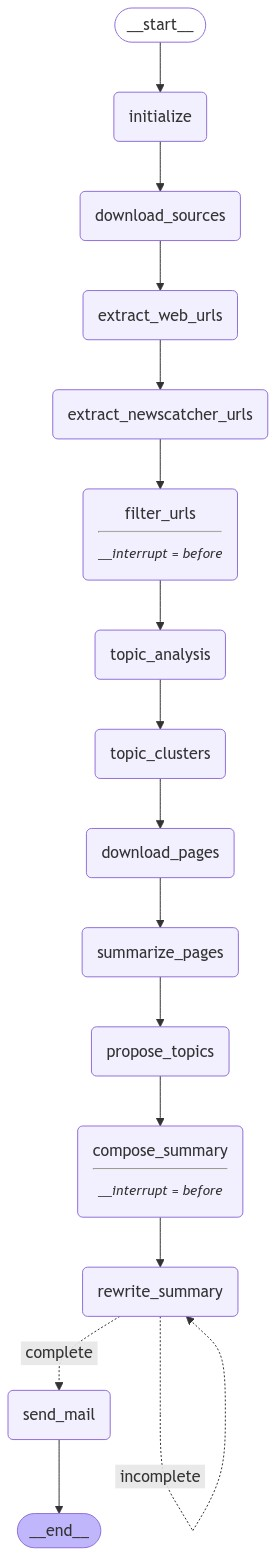

In [35]:
do_download = False
before_date = None
before_date="2024-10-19 15:00:00"

# initial state
state = AgentState()
state["before_date"] = before_date
state["do_download"] = do_download
state["n_edits"] = 0
state["edit_complete"] = False

# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4().hex
config = {"configurable": {"thread_id": thread_id}}

log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent = Agent(state)
display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


# Run each step individually

In [36]:
state = lg_agent.initialize(state)


2024-10-20 13:22:25,805 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2024-10-20 13:22:25,806 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-10-20 13:22:25,806 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-10-20 13:22:25,806 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-10-20 13:22:25,806 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-10-20 13:22:25,807 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-10-20 13:22:25,807 - AInewsbot - INFO - 

In [37]:
state = lg_agent.download_sources(state)


2024-10-20 13:22:27,868 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2024-10-20 13:22:27,869 - AInewsbot - INFO - Found 17 previously downloaded files
2024-10-20 13:22:27,870 - AInewsbot - INFO - htmldata/New York Times Technology (10_20_2024 12_34_23 PM).html
2024-10-20 13:22:27,870 - AInewsbot - INFO - htmldata/Hacker News Page 1 (10_20_2024 12_34_10 PM).html
2024-10-20 13:22:27,870 - AInewsbot - INFO - htmldata/The Register (10_20_2024 12_34_34 PM).html
2024-10-20 13:22:27,871 - AInewsbot - INFO - htmldata/Ars Technica (10_20_2024 12_33_58 PM).html
2024-10-20 13:22:27,871 - AInewsbot - INFO - htmldata/HackerNoon (10_20_2024 12_34_21 PM).html
2024-10-20 13:22:27,872 - AInewsbot - INFO - htmldata/VentureBeat AI (10_20_2024 12_34_44 PM).html
2024-10-20 13:22:27,872 - AInewsbot - INFO - htmldata/Hacker News Page 2 (10_20_2024 12_34_12 PM).html
2024-10-20 13:22:27,873 - AInewsbot - INFO - htmldata/Feedly AI (10_20_2024 12_35_18 PM).html
2024-10-20 13:22:27,87

In [38]:
state = lg_agent.extract_web_urls(state)


2024-10-20 13:22:30,434 - AInewsbot - INFO - Parsing html files
2024-10-20 13:22:30,435 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (10_20_2024 12_33_58 PM).html
2024-10-20 13:22:30,500 - AInewsbot - INFO - parse_file - found 203 raw links
2024-10-20 13:22:30,504 - AInewsbot - INFO - parse_file - found 31 filtered links
2024-10-20 13:22:30,504 - AInewsbot - INFO - 31 links found
2024-10-20 13:22:30,504 - AInewsbot - INFO - Bloomberg Tech -> htmldata/Bloomberg Technology (10_20_2024 12_34_01 PM).html
2024-10-20 13:22:30,526 - AInewsbot - INFO - parse_file - found 202 raw links
2024-10-20 13:22:30,529 - AInewsbot - INFO - parse_file - found 14 filtered links
2024-10-20 13:22:30,529 - AInewsbot - INFO - 14 links found
2024-10-20 13:22:30,529 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider Tech (10_20_2024 12_33_58 PM).html
2024-10-20 13:22:30,553 - AInewsbot - INFO - parse_file - found 309 raw links
2024-10-20 13:22:30,557 - AInewsbot - INFO - parse_file 

In [40]:
pd.DataFrame(state["AIdf"]).columns


Index(['id', 'src', 'title', 'url'], dtype='object')

In [41]:
# s/b 17 check all downloaded, if any got hit by a bot block then download manually
print(len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]))
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]


16


,id
src,
Ars Technica,24
Bloomberg Tech,11
Business Insider,50
FT Tech,56
Google News,63
Hacker News,25
Hacker News 2,20
HackerNoon,99
NYT Tech,19


In [42]:
state = lg_agent.extract_newscatcher_urls(state)


2024-10-20 13:22:40,014 - AInewsbot - INFO - Fetching top 100 stories matching Artificial Intelligence from Newscatcher


In [43]:
state = lg_agent.filter_urls(state)


2024-10-20 13:22:44,643 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2024-10-19 15:00:00'
2024-10-20 13:22:45,295 - AInewsbot - INFO - URLs in orig_df: 944
2024-10-20 13:22:45,297 - AInewsbot - INFO - Existing URLs in DB: 165701
2024-10-20 13:22:45,334 - AInewsbot - INFO - New URLs in df filtered by URL: 271
2024-10-20 13:22:45,426 - AInewsbot - INFO - Existing src+title: 6
2024-10-20 13:22:45,426 - AInewsbot - INFO - New URLs in df filtered by src+title: 265
2024-10-20 13:22:45,438 - AInewsbot - INFO - Found 251 unique new headlines
2024-10-20 13:22:45,444 - AInewsbot - INFO - Applying prompt to 6 pages using gpt-4o-mini
2024-10-20 13:22:45,445 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:22:45,445 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:22:45,445 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:22:45,446 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:22:45,446 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:22:45,446 - AInewsbot - IN

In [44]:
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]


,id
src,
Business Insider,2
FT Tech,2
Google News,18
Hacker News,4
Hacker News 2,1
HackerNoon,3
NYT Tech,1
Newscatcher,35
Reddit,2


In [45]:
for row in pd.DataFrame(state["AIdf"]).itertuples():
    display(Markdown(f"[{row.id}. {row.title} - {row.src}]({row.url})"))


[0. AI-powered malware emerges as new threat in cybersecurity landscape - Newscatcher](https://www.msn.com/en-in/money/news/ai-powered-malware-emerges-as-new-threat-in-cybersecurity-landscape/ar-AA1sA2Wz)

[1. AI could soon be used to help identify deadly prostate cancer - Newscatcher](https://www.msn.com/en-au/health/other/ai-could-soon-be-used-to-help-identify-deadly-prostate-cancer/ar-AA1szbZf)

[2. AI engineers claim new algorithm reduces AI power consumption by 95% - Hacker News 2](https://www.tomshardware.com/tech-industry/artificial-intelligence/ai-engineers-build-new-algorithm-for-ai-processing-replace-complex-floating-point-multiplication-with-integer-addition)

[3. AI in Family Offices: Navigating the AI Frontier in Wealth Management and Fiduciary Liability - Google News](https://news.google.com/read/CBMitgFBVV95cUxOYzVISVBHV1QwYnBBWWtXenktbFdJdG5kUkNZZTVPOXR2RXo2MmNzdlExX3hpcWxOR3N0Vy1pZnhOVU13eHVmVXhWU3YyWFZmX0NFV1NmM1R6Y3MzNlpHMDQyYUhMN2FOT2dSZVV3SW1oVFpMSTdVZ0NiSExzOVlpVDZfbXh6SGxqeTcxeU5aYU8xYzJfWWo0REtNRU5SOFR0S0R1bzVLaC1LZUdWalFfNjVrRGh6d9IBuwFBVV95cUxPVXdOMTdNNzFKSkRqTnZIX0FGRXBsMzViN1J2Mkc3djdnYWFLbkNfcUxyV0ZGeXIyWU5xS0tqZFB0UHJXWk1JSGRnRk90eUpScEx0SWNhbXh6dWVzQ0pNRmpLMWh4SG5lalBPbkFRUW51YnJxMmhNc0lxZmRUS0w0bzlDeTlLQnUtbmJuUU9hYXRweVJJWVNEME02VGZFNlJJZ191SVR1QTAzby1iV0J5S3pVNVFPVFBnWHNR)

[4. AI marketing is a con - especially when it comes to CPUs - Newscatcher](https://www.techradar.com/computing/artificial-intelligence/ai-marketing-is-a-con-especially-when-it-comes-to-cpus)

[5. A New Artificial Intelligence Tool for Cancer - Hacker News](https://hms.harvard.edu/news/new-artificial-intelligence-tool-cancer)

[6. Adobe Inc. (ADBE) Unveils 100+ New Creative Cloud Features at Adobe MAX 2024, Boosted by AI Model Firefly; Morgan Stanley Sets Price Target at $660 - Newscatcher](https://finance.yahoo.com/news/adobe-inc-adbe-unveils-100-184619253.html)

[7. Advanced Micro Devices, Inc. (AMD) Unveils New AI Processors at Advancing AI 2024 Event, Faces Competition from Nvidia's Blackwell Chips Amid Mixed Analyst Reactions - Newscatcher](https://ca.finance.yahoo.com/news/advanced-micro-devices-inc-amd-184906267.html)

[8. Amazon, Tesla and more earnings, AI conferences, and economic data: What to watch in the markets this week - Newscatcher](https://www.yahoo.com/tech/amazon-tesla-more-earnings-ai-090000297.html)

[9. Apple's New iPad Mini Highlights the Company's AI Advantage - Hacker News](https://www.bloomberg.com/news/newsletters/2024-10-20/apple-s-latest-ipad-mini-highlights-ai-advantage-sonos-considers-new-headphones-m2hkz4mn)

[10. Apple's own research sheds light on Siri's AI laggardness - Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)

[11. Apple AI services to expand next year; potentially squeezing Samsung Galaxy S25's market space - Google News](https://news.google.com/read/CBMiigFBVV95cUxNUWxWQXgyT1ZoTmVpdmROTnlXZDgzc3J1T3l4RXlrZTR4UnhtVjdFLXlILTd4RDdrUlNhVTYtTm8zbE91M2FYMkQ0TFdQYVpPaGhJTENjS29VME1lVm1QN1M2RVhHZ1RXZUNIVnoxd1AwRUlfLVBNZnJVMGJBc0RueUpFTWp3VHhiT2c)

[12. Apples New iPad Mini Highlights the Companys Secret AI Advantage - Google News](https://news.google.com/read/CBMi2gFBVV95cUxObXFvQ1BQdEFpWkw3MVRSbE8wX1dpalc2R1VDZGlXX1pNQ1NfNFpfOHk3aVBVVENTSWVfQUJZbFdnSkRpMnQwMmhOVWJDZFhweEVMMjJRZC01ZllYa1ZqR0pzYnkzU084N1VMcFhnYlFjRmViSmRlRXhSUXlLUWZnclJXMUZNSjhuUnZudVBPck9xTDhIY3BaX18za1JzVG0zeFB2VnVuaGYtV3ozUjdreG5aSW9ER045ZGk5X050cmFtN0haWV9paUR6R3BVT1FkSC0xNEc4MDhYQQ)

[13. Ariana Grande Responds After Wicked Co-Star Cynthia Erivo Calls Out Fans For Using A.I. To Make Edited Posters - Google News](https://news.google.com/read/CBMiiwFBVV95cUxPQmRGaHRlanlPNUw3amFHVlVEUU1NaEkweFVnbmtjbzdiOVdkS0piVTZwS1ptWDhCbUxJbUJndGdxU1R5c2R0Y3V3b1ZkTDQ3Q3RSTVlybmNaZ2VGejFfVFRyc3JCTFRkR2FvenZGNVZrRTdTZ0F2MVJYYnVQM0daejl4M09uRW5FVVZV)

[14. Ariana Grande Weighs In on Cynthia Erivo's Criticism of Fan-Edited 'Wicked' Posters and NSFW Meme: 'I Find AI So Conflicting and Troublesome Sometimes' (EXCLUSIVE) - Google News](https://news.google.com/read/CBMiugFBVV95cUxNSzMtRUx1cjJQUHhkMVliV0hIQkxzeC1pTTJIUV96UW9XMEdxTWw2ZVYySVNPY0h2dmtWWUFtQlBxNGlKMzNMckZLVTZha2VCMk1PZnNHdS1rYmJWc2ZubXhDLUZqeTRaUS1NTFJieGhzaXZ5cXBGMTR1TWhHR1B0NWxhSjN3RTc3T2RhMlNMMDNuRjBhdDhxQVVLOXdQcVlwU2ZhNGkzMnlXU2p1S3hwWm9yaWxFaHVyQ2c)

[15. Arm Holdings plc (ARM) Teams Up with Industry Leaders to Launch Advanced AI CPU Chiplet Platform for Cloud and HPC Applications - Newscatcher](https://ca.finance.yahoo.com/news/arm-holdings-plc-arm-teams-153946418.html)

[16. Broadcom Inc. (AVGO) Reports 47% Revenue Growth Driven by AI Demand; Mizuho Raises Price Target to $220 Amid Promising Collaboration with OpenAI - Newscatcher](https://finance.yahoo.com/news/broadcom-inc-avgo-reports-47-185524401.html)

[17. Cisco Systems, Inc. (CSCO) Receives Buy Rating from Tigress Financial with $78 Price Target, Driven by AI Growth and Subscription Model Transition - Newscatcher](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)

[18. Coherent Corp. (COHR) Receives Price Target Boost to $120 from Needham, Driven by AI Initiatives and Leadership Changes - Newscatcher](https://finance.yahoo.com/news/coherent-corp-cohr-receives-price-165121304.html)

[19. Down 34%, This AI Stock Is a No-Brainer Buy Stock Right Now - Newscatcher](https://finance.yahoo.com/news/down-34-ai-stock-no-213700014.html)

[20. Dubai Police taps Avaya for its AI-based virtual assistant - Newscatcher](https://siliconangle.com/2024/10/19/dubai-police-taps-avaya-ai-based-virtual-assistant)

[21. Elastic N.V. (ESTC) Upgraded to Outperform' by William Blair as AI-Powered Search Solutions Drive Growth and Customer Adoption - Newscatcher](https://hk.finance.yahoo.com/news/elastic-n-v-estc-upgraded-173835796.html)

[22. Former OpenAI CTO Mira Murati Said to Raise Capital for New AI Startup - Newscatcher](https://www.gadgets360.com/ai/news/former-openai-cto-mira-murati-raising-capital-new-ai-startup-6826774)

[23. Google Research execs reveal how they use AI in their daily lives  and where they think twice about it - Business Insider](https://www.businessinsider.com/google-research-execs-reveal-how-they-use-ai-daily-2024-10)

[24. Gurman: Apple internally believes that its at least two years behind in AI development - Google News](https://news.google.com/read/CBMiekFVX3lxTE5IU0d3SHM3TEJ4M1lsNDdLLUlXY2xlbjBla0VaZ1B6NHBVVXJpMGI0eGhldzRjZUxLMDFtSF8zb2VpSkJyVGZ1b2NjMmtwbmRvenAzVl9Fd1ZOcC1OSXg3cWM0VzYyWFVNMUs5cE1JcHBqSmFFSDRoUktR)

[25. How AI groups are infusing their chatbots with personality - FT Tech](https://www.ft.com/content/a7337550-9b42-45c8-9845-37d78d2c3209)

[26. How AI images are driving hero-worship of killed Hamas leader Yahya Sinwar - analysis - Google News](https://news.google.com/read/CBMiXEFVX3lxTE16ZkVYUHB1TVZMYW5TWVNGNFczeF85ZUsySjhuZk5LUTZrMVhiazdpQ0RzU1N3UGMtV3BrbDF0TDRMODA0N29RZGw5ODBLUUtSODdoc1hmZmRyY3g2)

[27. How AI will transform wealth management - Google News](https://news.google.com/read/CBMijgFBVV95cUxQb0xmNHkxbTlwTjRubVVONUVHVktjMHVfcHJuVXdBNk5FN1Z5Ylo1RmhDT1R2dklKMmRMT0hTNzZnU2l5T1VTLTVRVEZ4V1Q0NkhSaFhsZU1lY1ZDMEhfVkxlS2pUVGxfX1dlRExGTU9yYVdOZXgzajZXZXV3eDNCMmdjcnlzWVZ3bnR4S1VB)

[28. How artificial intelligence is transforming wealth management - Google News](https://news.google.com/read/CBMioAFBVV95cUxPMVdJREJmSzIxc1RpMnFqUW1FU3pWZjBRYy0tSUh1MWl3TkVGbDczR1VnRzZia19yazUyQ3JveDJoUnZpWVR1OWlRaTRSbjBETkZsd3NHY1F3Zm42dDh5ak9oNzlBM1NHZWVpZFQtVGNTb3I2QlZQcDY4cVRSaEI1TW42bncxTDM2QVlPbTVNQ00xMlQxUG9yalBJWDZZZ0lK)

[29. Hubspot (HUBS): Leading Marketing Innovation with Comprehensive AI-Driven Solutions - Newscatcher](https://ca.finance.yahoo.com/news/hubspot-hubs-leading-marketing-innovation-180050200.html)

[30. International Business Machines Corporation (IBM) Receives Price Target Increase to $250 from RBC Capital, Driven by Strong AI and Hybrid Cloud Momentum Ahead of Q3 Results - Newscatcher](https://ca.finance.yahoo.com/news/international-business-machines-corporation-ibm-173229559.html)

[31. Massachusetts parents sue school district over student receiving 'D' after using AI for social studies project - Google News](https://news.google.com/read/CBMipwFBVV95cUxOZlVsX1dwT3JnaU56V2IzVWcyZ0ZnNG45c0RxTFJnYWxELU5VaC1vb3FOYU5mR2RkNjMxZWV1cUJhbUVEaTJxOXJDZU5KQTZWT0h4a2lMbVhhUTBRZ2h2TmZvWkZ2ekpqQVcyeE9JRTlHalBFcUg2T0ZZQ3QwSnhOaUtNa29WRy1zN2lRRmIzTm01Q2NCbDRoUkxsU2VQTVZHdndnQjk1Z9IBrAFBVV95cUxPalMwdVRUTmdCbHdmdHd5eC1pTk5tVDg4YmRVUXViMklZYUl0UVlRWnpSLXlkRVB3aUxOQV8wcjFJd0lLcmpaQW9MY2dNQl9PX29NWXNDWHRFM01aY05oX052SWFqbTItcHJIa0NEZVBRVzJhbENuOWdVVWw2aEZPbEhKYnBsU0xwY2V0TDRGYVV4TE01Tmx3MjRiZ3ZCa3ZyNmxZOVVGZVNUMV9w)

[32. Meet the Newest Artificial Intelligence (AI) Chip Stock to Join Nvidia in the $1 Trillion Club - Newscatcher](https://finance.yahoo.com/news/meet-newest-artificial-intelligence-ai-113000061.html)

[33. Micron Technology, Inc. (MU) Reports Strong Q4 Earnings Driven by AI Demand; CEO Highlights Optimism for 2025 Amid Mixed Analyst Ratings - Newscatcher](https://finance.yahoo.com/news/micron-technology-inc-mu-reports-185157321.html)

[34. Ministers in AI arms race' with criminals and rogue states, senior MP warns - Newscatcher](https://ca.news.yahoo.com/ministers-ai-arms-race-criminals-115000477.html)

[35. Mixtral Outperforms Llama and GPT-3.5 Across Multiple Benchmarks - HackerNoon](https://hackernoon.com/mixtral-outperforms-llama-and-gpt-35-across-multiple-benchmarks)

[36. Mixtrals Multilingual Benchmarks, Long Range Performance, and Bias Benchmarks - HackerNoon](https://hackernoon.com/mixtrals-multilingual-benchmarks-long-range-performance-and-bias-benchmarks)

[37. MongoDB, Inc. (MDB) Receives Analyst Upgrades With Increased Price Targets Amid Strong AI and Cloud Software Growth - Newscatcher](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)

[38. NVIDIA Corporation (NVDA) Dominates AI Chip Market with Blackwell; Analysts Maintain Strong Buy Ratings as Stocks Surge and S&P 500 Reaches Record High - Newscatcher](https://finance.yahoo.com/news/nvidia-corporation-nvda-dominates-ai-190115419.html)

[39. Nuclear energy stocks hit record highs on surging demand from AI - FT Tech](https://www.ft.com/content/33eeadbe-edf4-40b5-b973-e76c570d0681)

[40. Nvidia, Google, Microsoft and more head to Las Vegas to tout health-care AI tools - Google News](https://news.google.com/read/CBMipwFBVV95cUxNNFk5ZG9aakttUkZPdHcyN0M0WDRMNDA3ckJIamV0c0lJb0NSbExmT3lNaUxxYzByNVdtOVg0RUJuWmtOQkxRX1Z2ZmtlQ1BWS3UwR3lfa2ptQjFqX1h5clgwMllmUXUyaVB6Y0FqaEU0QVhrREZUc3hhaEZQUHcyOE1nMGE4S29jNVZqdHhvYzhXRHRMZm9HT3VEY2xLSDZ6bk4yclV4NNIBrAFBVV95cUxPYi10dDhVX1hJem5FekZVNVZxZE5OUHIzQndwNG02WHpVRTBDR0FSc2ZkVG9ra1lOdjRJM0dSbUxCTUFjUGRsTUZzQTExQnVoQm91WUc3bTZkYkNSbzhfcTlvX3VOSEdNWnljOGVsb3Atc2wtQXdHYlA2TDNNWGlHYzhneFU5WWNKU3RTcWNyTUR4aUJ1dXYyN251RlRQdXQwQUJPQzRtRmItd3BN)

[41. Nvidia, Google And Microsoft To Present AI Tools Aimed At Reducing Healthcare Worker Burnout At Las Vegas Conference - Newscatcher](https://www.msn.com/en-us/money/news/nvidia-google-and-microsoft-to-present-ai-tools-aimed-at-reducing-healthcare-worker-burnout-at-las-vegas-conference/ar-AA1szTTA)

[42. Open source LLM tool primed to sniff out Python zero-daysThe static analyzer uses Claude AI to identify vulns and suggest exploit codeSecurity8 hrs|4 - The Register](https://www.theregister.com/2024/10/20/python_zero_day_tool/)

[43. Palo Alto Networks, Inc. (PANW) Posts Strong Earnings and Revenue Growth, with Morgan Stanley Raising Price Target to $421 Amid Positive AI Prospects - Newscatcher](https://finance.yahoo.com/news/palo-alto-networks-inc-panw-183102342.html)

[44. Parents of Hingham student sue school district after son disciplined for using AI on school project - Google News](https://news.google.com/read/CBMi7gFBVV95cUxNV0M5UFhTeTlwQWJ0ak9mWXV6YmFtODJzN3hxNDhHSGFMLTQ2SVdjclhSakRIOEs2c1piaEVGc1dxR2dlRndjVEN6c1NVbnhobDVHS3pTSFljZjFObk0zVWNGR2tVSzBJcmdLWHU2YnZoNTd5RnRGN1FLQWFEa2dvNDhEY041RzBCeHhWNWJDc2FnUkY0WC0yRzNOcWlLVU11am9SZXNUNjM0VWdpZ0FIeXM4YkdwQmF4UlBYYUdqMk1Pc21mSWNQV3FKN1I0Mm9zMmVqNlhfZGZYZFAzOHB6S092d1NROUNnbTBNLUlR0gGCAkFVX3lxTE5BYnRySGZLRVFPVFA5eDNTd0I2UDY3RmEydlNnSXFFMmJDOTBjNzdaNDVTSmdjaWN4TERnTXkxT25KT043MDlNaVoxd0NxcE1VQjVSSy1aSWZsZGhuZHRCY1l6ZUF0U2ZIaURnSC1GRWRjZW5hUnRzazc3OF9acFhRNmhHMnJLdzFUMk9VYl9hQWl6cWwyRWo4Wjc3VFJqbEJONERSemRjNC1pR19jajNJVTVZcUlRUk9Pd3NPbk0tZnRpWW9hSGRpWTVBaE1kWU1NMjNsWHVNLXIxeFlvOHU1Z05Od3FmdG10b3RoZ2dqbHBKbnNQR1pYcFFMUUYxOHRzQQ)

[45. Penguin Random House is adding an AI warning to its books' copyright pages - Newscatcher](https://techcrunch.com/2024/10/19/penguin-random-house-is-adding-an-ai-warning-to-its-books-copyright-pages)

[46. Podcast: Uber + Expedia? Ballmer on 60 Minutes; 1980s Silicon Valley revisited; What's next for AI - Newscatcher](https://www.geekwire.com/2024/podcast-uber-expedia-ballmer-on-60-minutes-1980s-silicon-valley-revisited-whats-next-for-ai)

[47. Reddit Inc (RDDT) Gains Buy' Rating from Jefferies With $90 Price Target Amid AI-Driven Growth and Strong User Engagement - Newscatcher](https://ca.finance.yahoo.com/news/reddit-inc-rddt-gains-buy-161041337.html)

[48. ServiceNow, Inc. (NOW) Price Target Raised to $1,025 by BMO Capital Markets, Reflecting Confidence in AI-Driven Growth Potential - Newscatcher](https://finance.yahoo.com/news/servicenow-inc-now-price-target-184353541.html)

[49. Siri Is 20% Less Accurate, 23% Less Capable, and 2 Years Behind ChatGPT - Google News](https://news.google.com/read/CBMiowFBVV95cUxQeGpWNVZHU194dGFCdDNaVVhoaUhLNFl3MDBvVHIwNE4yTDVaWTljdFQzLVNwOW40NDVTaFAwTmFHVV9DVmxwY0lyZVNNV0lZNzJvYldNUDlUeEx5Y2NLMWZrOGZTaXk3NjZTZUlfT283a1R2THMyY2paNGJUbGllS2N6bUZvVGFSdUk0T1pxSV9mX3JJNjZKNHJOMExYV1diNWlJ)

[50. Six months after the bitcoin halving, some miners hold their bitcoin, while others spend more on developing AI data centers and see the largest stock gains - Techmeme](https://www.bloomberg.com/news/articles/2024-10-19/bitcoin-miners-pivoting-to-ai-outperform-hodlers-six-months-after-halving)

[51. Snowflake Inc. (SNOW) Navigates Investor Challenges Amid Strong AI Data Cloud Performance, Viewed as a Key Player in Next Wave of Generative AI Investments - Newscatcher](https://finance.yahoo.com/news/snowflake-inc-snow-navigates-investor-183327497.html)

[52. SuperMicro unveils NVIDIA GB200 NVL72 SuperCluster: liquid-cooled AI servers - Newscatcher](https://www.tweaktown.com/news/101176/supermicro-unveils-nvidia-gb200-nvl72-supercluster-liquid-cooled-ai-servers/index.html)

[53. Taiwan Semiconductor Manufacturing Company Limited (TSM) Poised for 40% Q3 Profit Surge Amid AI Boom; Major Clients Fuel Growth and Global Expansion - Newscatcher](https://uk.finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-185830731.html)

[54. The AI Investment Boom - Hacker News](https://www.apricitas.io/p/the-ai-investment-boom)

[55. The Trade Desk, Inc. (TTD) Sees Price Target Upgrades from Citi and Stifel Amid Strong AI-Driven Growth in Connected TV and Retail Media - Newscatcher](https://uk.finance.yahoo.com/news/trade-desk-inc-ttd-sees-164912165.html)

[56. The more AI Develops, the more Human-Like Zuck appears. Must be coincidence... right? *nervous laughter* - Reddit](https://www.reddit.com/r/ChatGPT/comments/1g7v1jv/the_more_ai_develops_the_more_humanlike_zuck/)

[57. This is OpenAI CEO Sam Altman's favorite question about AGI - Newscatcher](https://www.yahoo.com/tech/openai-ceo-sam-altmans-favorite-132511294.html)

[58. Tiny Caribbean island of Anguilla turns AI boom into digital gold mine - Google News](https://news.google.com/read/CBMirgFBVV95cUxOUkZkSEJ6c293aHdVT3hYVlFZMXRPWmtWYXg3X1dyX0Y2LXBwWGJHdjFBZC1ENjhCQTNUcV9jZ2ZjTVVhUDZsbjd2ejQ4dXdmcnN2anNtT1YtN09Cd0JrcVFsYm1OUExhRkd6YWVmbXpjVnd2ejNlemN6aWk1SVlVOTY5S1hjNG96NDNZVVdCWkcxNDhuckdEbjVLMnZOZGZTTTFlWi11XzBXb0kzNGfSAbABQVVfeXFMUGs1QUtyekNPZ3JDREx2ZHMwNzdCckluWFVXYXBjWll3OW1WTUpNUEpBb08xaWwteU40Q2M4MWpKRUFMb2V3MmR1clptMF90UkRzVVg4bHltd0JqaGxpY2RPaWk5OEdnSUZfOWsxOEFZMlBXX0ZUanA2T0dmZElJbTRhSTg1VUtWcUI1bHB6UjdRNUpMcXVRUnpMbkdMUkw0U216cDZtZURMblFwUnFUNkk)

[59. Trump aims for the stars as he links his campaign to Elon Musk's success at SpaceX - Business Insider](https://www.businessinsider.com/elon-musk-trump-spacex-starship-rocket-milestone-election-2024-10)

[60. U.S. Agencies Fund, and Fight With, Elon Musk. A Trump Presidency Could Give Him Power Over Them. - NYT Tech](https://www.nytimes.com/2024/10/20/us/politics/elon-musk-federal-agencies-contracts.html)

[61. Understanding the Mixture of Experts Layer in Mixtral - HackerNoon](https://hackernoon.com/understanding-the-mixture-of-experts-layer-in-mixtral)

[62. Up 35% in 3 Months, This Tech Stock Could Become the Next Big Artificial Intelligence (AI) Play - Newscatcher](https://finance.yahoo.com/news/35-3-months-tech-stock-210000872.html)

[63. Wall Street's Hottest Trend, Artificial Intelligence (AI), Has a Conviction Problem -- Just Ask Nvidia, Broadcom, and Advanced Micro Devices - Newscatcher](https://finance.yahoo.com/news/wall-streets-hottest-trend-artificial-080600883.html)

[64. Want to Invest in Artificial Intelligence (AI) Safely? Buy These 3 ETFs - Newscatcher](https://finance.yahoo.com/news/want-invest-artificial-intelligence-ai-113900048.html)

[65. What is Apple Intelligence? Here's when U.S. users will get to use the new program - Google News](https://news.google.com/read/CBMiywFBVV95cUxPRUhnUXJ6S1A2SlE1OGtMOExya1MzWUpuOTNoNE9ycllORDQ0eGszWV94TFcwREE4RDFyMm1jSnFxSy1yQVEzRHd1c1NzOWhGSUZsSHNYUm84RUZGdW1lU3V0b291aEhpRUdaZDFYd25INEJ5ZEYwOV93STFqTnJlYlF0Q1U1eDcwYUxfMElabUlCdjNCNmJ0bVZFMDlpcXgwSWpjenBIcGlHTW1uOWVCNDl3bVdrM1JwU2pSeEg1V1NTcFlDdlM5MFhsRQ)

[66. When we asked these candidates questions, they answered with AI. Heres why  and what we learned about AIs limits - Google News](https://news.google.com/read/CBMirAFBVV95cUxOd1I5S25kRE1fV0NtT1k4YnhaNE9sdDFVZE1GSHUtODNJQzYzZV9NLXEwUGowcXoxS25xUVdpQUF1SWc3cFI5Q29tLWtoTFNOYmpmcUs1dFRNOV9xclRoV2xnaXZ0Z0xOQ1piN1ZLUUI0TzZfVEFKLXVRb3M4LVAweTdIQ0ctdVRnOGNFbUhjUFdSVG5hTThZU3N2MXNRdTlXNHBVZ29QV1BkWFVN)

[67. Why do random forests work? They are self-regularizing adaptive smoothers - Hacker News](https://arxiv.org/abs/2402.01502)

[68. Wolters Kluwer AI Labs Marks First Year of Collaboration in Developing New, Responsible AI Features for UpToDate - Google News](https://news.google.com/read/CBMif0FVX3lxTE5SeU9fY05FZVd0cHVDMkVoeWJGd0c0V2Zyd0hQaEVxM1BYaW5BR2RJTU9FbnJ3dXdHenR1cllvRFBTYUtNeVo5S254cVoxczFEdUMyd1RkcXMyQk9kMld3aUhWX1RabkFiMWNQM3MtTzhWTl9BbGtHdFdRRWVkVzg)

[69. Xs controversial changes to blocking and AI training sees half a million users leave for rival Bluesky  which then crashes under the strain - Reddit](https://www.reddit.com/r/technology/comments/1g7i5lj/xs_controversial_changes_to_blocking_and_ai/)

In [46]:
state = lg_agent.topic_analysis(state)


2024-10-20 13:23:02,887 - AInewsbot - INFO - start free-form topic extraction
2024-10-20 13:23:02,887 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:23:02,888 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:23:02,889 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:23:07,102 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:23:09,845 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:23:09,848 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:23:09,849 - AInewsbot - INFO - 70 free-form topics extracted
2024-10-20 13:23:09,851 - AInewsbot - INFO - ['healthcare', 'wealth management', 'marketing', 'amd', 'nvidia', 'earnings', 'apple', 'ipad mini', 'technology advantage', 'siri', 'ariana grande', 'cynthia erivo', 'fan edits', 'social media', 'broadcom', 'revenue growth', 'ai demand', 'openai', 'price target', 'buy rating', 'investment', 'growth', 'transformation', 'lawsuit', 'school project', 'education', 'analyst ratings', 'mix

2024-10-20 13:24:00,166 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:24:00,167 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:24:00,169 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:24:02,094 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:24:03,881 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:24:03,884 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:24:03,884 - AInewsbot - INFO - Computer Vision, topic 16 of 100
2024-10-20 13:24:03,888 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:24:03,892 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:24:03,895 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:24:06,417 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:24:08,748 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:24:08,750 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:24:08,751 - AInewsbot - INFO - Consciousness, topic 17 of 100
2024-10-20 1

2024-10-20 13:25:04,626 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:25:04,627 - AInewsbot - INFO - Fashion, topic 32 of 100
2024-10-20 13:25:04,629 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:25:04,631 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:25:04,633 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:25:06,504 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:25:07,962 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:25:07,966 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:25:07,967 - AInewsbot - INFO - Finance, topic 33 of 100
2024-10-20 13:25:07,968 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:25:07,971 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:25:07,974 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:25:09,781 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:25:11,215 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:25:11,222 - 

2024-10-20 13:26:03,217 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:26:03,222 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:26:03,223 - AInewsbot - INFO - Intellectual Property, topic 49 of 100
2024-10-20 13:26:03,224 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:26:03,228 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:26:03,231 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:26:04,978 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:26:06,717 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:26:06,723 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:26:06,725 - AInewsbot - INFO - Internet of Things, topic 50 of 100
2024-10-20 13:26:06,728 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:26:06,732 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:26:06,734 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:26:08,663 - AInewsbot - INFO - got dict with 20 items 
2

2024-10-20 13:27:00,841 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:27:00,842 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:27:02,323 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:27:04,371 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:27:04,374 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:27:04,374 - AInewsbot - INFO - Policy and regulation, topic 66 of 100
2024-10-20 13:27:04,378 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:27:04,380 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:27:04,381 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:27:06,767 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:27:08,374 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:27:08,377 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:27:08,377 - AInewsbot - INFO - Politics, topic 67 of 100
2024-10-20 13:27:08,378 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 

2024-10-20 13:28:02,867 - AInewsbot - INFO - Singularity, topic 82 of 100
2024-10-20 13:28:02,868 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:28:02,870 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:28:02,871 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:28:04,706 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:28:06,734 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:28:06,737 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:28:06,737 - AInewsbot - INFO - Smart grid, topic 83 of 100
2024-10-20 13:28:06,739 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:28:06,740 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:28:06,741 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:28:08,577 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:28:10,215 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:28:10,217 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:28:10

2024-10-20 13:29:04,489 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:29:04,491 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:29:04,492 - AInewsbot - INFO - Virtual & Augmented Reality, topic 99 of 100
2024-10-20 13:29:04,493 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:29:04,494 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:29:04,496 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:29:06,231 - AInewsbot - INFO - got dict with 20 items 
2024-10-20 13:29:07,881 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:29:07,883 - AInewsbot - INFO - Processed 70 responses.
2024-10-20 13:29:07,884 - AInewsbot - INFO - Virtual Assistants, topic 100 of 100
2024-10-20 13:29:07,885 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-20 13:29:07,886 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:29:07,887 - AInewsbot - INFO - sent 20 items 
2024-10-20 13:29:10,321 - AInewsbot - INFO - got dict with 20 i

In [47]:
state = lg_agent.topic_clusters(state)


2024-10-20 13:29:11,932 - AInewsbot - INFO - Fetching embeddings for 70 headlines
2024-10-20 13:29:12,203 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-10-20 13:29:12,336 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2024-10-20 13:29:12,351 - AInewsbot - INFO - Load umap dimensionality reduction model
2024-10-20 13:29:13,158 - AInewsbot - INFO - Perform dimensionality reduction
2024-10-20 13:29:13,773 - AInewsbot - INFO - Cluster with DBSCAN


,id,title_topic_str
0,0,"How artificial intelligence is transforming wealth management (Topics: Economics, Finance, Fintech, Gen AI, Inequality, Job Automation, Jobs & Careerslabor Market, Recommendation Systems, Science, Stocks, Transformation, Venture Capital, Wealth Management)"
1,1,"AI in Family Offices: Navigating the AI Frontier in Wealth Management and Fiduciary Liability (Topics: Economics, Ethics, Family Offices, Fiduciary Liability, Finance, Fintech, Gen AI, Inequality, Legal Issues, Stocks, Venture Capital, Wealth Management)"
2,2,"How AI will transform wealth management (Topics: Economics, Finance, Fintech, Gen AI, Inequality, Job Automation, Jobs & Careerslabor Market, Recommendation Systems, Science, Stocks, Transformation, Venture Capital, Wealth Management)"


2024-10-20 13:29:14,217 - AInewsbot - INFO - {'topic_title': 'AI in Wealth Management'}
2024-10-20 13:29:14,218 - AInewsbot - INFO - I dub this cluster: AI in Wealth Management


,id,title_topic_str
3,3,"Apple's New iPad Mini Highlights the Company's AI Advantage (Topics: Apple, Gen AI, Ipad Mini, Products, Technology Advantage)"
4,4,"Gurman: Apple internally believes that its at least two years behind in AI development (Topics: AI Development, Apple, Gen AI, Opinion, Science, Technology Competition)"
5,5,"Apples New iPad Mini Highlights the Companys Secret AI Advantage (Topics: Apple, Gen AI, Ipad Mini, Products, Technology Advantage)"
6,6,"What is Apple Intelligence? Here's when U.S. users will get to use the new program (Topics: Apple Intelligence, New Program, Products, U.S. Users)"
7,7,"Apple's own research sheds light on Siri's AI laggardness (Topics: Apple, Chatbots, Cognitive Science, Gen AI, Language Models, Siri, Speech Recognition & Synthesis, Technology Lag, Virtual Assistants)"


2024-10-20 13:29:14,639 - AInewsbot - INFO - {'topic_title': 'Apple and AI Development'}
2024-10-20 13:29:14,640 - AInewsbot - INFO - I dub this cluster: Apple and AI Development


,id,title_topic_str
8,8,"Reddit Inc (RDDT) Gains Buy' Rating from Jefferies With $90 Price Target Amid AI-Driven Growth and Strong User Engagement (Topics: Buy Rating, Economics, Finance, Gen AI, Growth, Reddit, Stocks, User Engagement)"
9,9,"Cisco Systems, Inc. (CSCO) Receives Buy Rating from Tigress Financial with $78 Price Target, Driven by AI Growth and Subscription Model Transition (Topics: AI Growth, Buy Rating, Cisco, Economics, Finance, Gen AI, Science, Stocks, Subscription Model)"
10,10,"MongoDB, Inc. (MDB) Receives Analyst Upgrades With Increased Price Targets Amid Strong AI and Cloud Software Growth (Topics: Analyst Upgrades, Cloud Software, Economics, Finance, Gen AI, Growth, Mongodb, Science, Stocks)"
11,11,"The Trade Desk, Inc. (TTD) Sees Price Target Upgrades from Citi and Stifel Amid Strong AI-Driven Growth in Connected TV and Retail Media (Topics: Connected Tv, Economics, Finance, Gen AI, Language Models, Price Target Upgrades, Retail Media, Stocks, Streaming, The Trade Desk, Tv & Film & Movies)"
12,12,"Coherent Corp. (COHR) Receives Price Target Boost to $120 from Needham, Driven by AI Initiatives and Leadership Changes (Topics: AI Initiatives, Coherent Corp, Economics, Finance, Gen AI, Leadership Changes, Price Target, Science, Stocks)"


2024-10-20 13:29:15,109 - AInewsbot - INFO - {'topic_title': 'AI-Driven Stock Market Growth'}
2024-10-20 13:29:15,110 - AInewsbot - INFO - I dub this cluster: AI-Driven Stock Market Growth


,id,title_topic_str
13,13,"NVIDIA Corporation (NVDA) Dominates AI Chip Market with Blackwell; Analysts Maintain Strong Buy Ratings as Stocks Surge and S&P 500 Reaches Record High (Topics: AI Chip Market, Analyst Ratings, Blackwell, Economics, Finance, Gen AI, Hardware, Nvidia, Products, Science, Semiconductor Chips, Stock Surge, Stocks)"
14,14,"Meet the Newest Artificial Intelligence (AI) Chip Stock to Join Nvidia in the $1 Trillion Club (Topics: $1 Trillion Club, Chip Stock, Gen AI, Hardware, Nvidia, Products, Semiconductor Chips, Stocks)"
15,15,"Wall Street's Hottest Trend, Artificial Intelligence (AI), Has a Conviction Problem -- Just Ask Nvidia, Broadcom, and Advanced Micro Devices (Topics: Amd, Broadcom, Economics, Ethics, Finance, Gen AI, Hardware, Nvidia, Opinion, Semiconductor Chips, Stocks, Wall Street)"


2024-10-20 13:29:15,753 - AInewsbot - INFO - {'topic_title': 'AI Chip Market and Stocks'}
2024-10-20 13:29:15,754 - AInewsbot - INFO - I dub this cluster: AI Chip Market and Stocks


['AI in Wealth Management', 'Apple and AI Development', 'AI-Driven Stock Market Growth', 'AI Chip Market and Stocks']


In [48]:
state = lg_agent.download_pages(state)


2024-10-20 13:29:15,791 - AInewsbot - INFO - Queuing URLs for scraping
2024-10-20 13:29:15,794 - AInewsbot - INFO - fetching 70 pages using 4 browsers
2024-10-20 13:29:15,795 - AInewsbot - INFO - get_driver - 93979 Initializing webdriver
2024-10-20 13:29:15,795 - AInewsbot - INFO - get_driver - 93979 Initializing webdriver
2024-10-20 13:29:15,795 - AInewsbot - INFO - get_driver - 93979 Initializing webdriver
2024-10-20 13:29:15,796 - AInewsbot - INFO - get_driver - 93979 Initializing webdriver
2024-10-20 13:29:32,313 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-20 13:29:32,313 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-20 13:29:32,314 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-20 13:29:32,314 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-20 13:29:32,314 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-20 13:29:32,314 - AInewsbot - INFO - get_driver - Ini

2024-10-20 13:30:32,245 - AInewsbot - INFO - Processing page 5: https://news.google.com/read/CBMi2gFBVV95cUxObXFvQ1BQdEFpWkw3MVRSbE8wX1dpalc2R1VDZGlXX1pNQ1NfNFpfOHk3aVBVVENTSWVfQUJZbFdnSkRpMnQwMmhOVWJDZFhweEVMMjJRZC01ZllYa1ZqR0pzYnkzU084N1VMcFhnYlFjRmViSmRlRXhSUXlLUWZnclJXMUZNSjhuUnZudVBPck9xTDhIY3BaX18za1JzVG0zeFB2VnVuaGYtV3ozUjdreG5aSW9ER045ZGk5X050cmFtN0haWV9paUR6R3BVT1FkSC0xNEc4MDhYQQ
2024-10-20 13:30:32,284 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMi2gFBVV95cUxObXFvQ1BQdEFpWkw3MVRSbE8wX1dpalc2R1VDZGlXX1pNQ1NfNFpfOHk3aVBVVENTSWVfQUJZbFdnSkRpMnQwMmhOVWJDZFhweEVMMjJRZC01ZllYa1ZqR0pzYnkzU084N1VMcFhnYlFjRmViSmRlRXhSUXlLUWZnclJXMUZNSjhuUnZudVBPck9xTDhIY3BaX18za1JzVG0zeFB2VnVuaGYtV3ozUjdreG5aSW9ER045ZGk5X050cmFtN0haWV9paUR6R3BVT1FkSC0xNEc4MDhYQQ) - starting get_url https://news.google.com/read/CBMi2gFBVV95cUxObXFvQ1BQdEFpWkw3MVRSbE8wX1dpalc2R1VDZGlXX1pNQ1NfNFpfOHk3aVBVVENTSWVfQUJZbFdnSkRpMnQwMmhOVWJDZFhweEVMMjJRZC01ZllYa1ZqR0pzYnkzU084N1VMcFhnYlFjRmViSmRlRXhSUXlLUWZncl

2024-10-20 13:30:32,450 - AInewsbot - INFO - Processing page 24: https://siliconangle.com/2024/10/19/dubai-police-taps-avaya-ai-based-virtual-assistant
2024-10-20 13:30:32,455 - AInewsbot - INFO - get_url(https://siliconangle.com/2024/10/19/dubai-police-taps-avaya-ai-based-virtual-assistant) - starting get_url https://siliconangle.com/2024/10/19/dubai-police-taps-avaya-ai-based-virtual-assistant
2024-10-20 13:30:32,454 - AInewsbot - INFO - get_url(https://www.businessinsider.com/google-research-execs-reveal-how-they-use-ai-daily-2024-10) - starting get_url https://www.businessinsider.com/google-research-execs-reveal-how-they-use-ai-daily-2024-10
2024-10-20 13:30:32,459 - AInewsbot - INFO - Processing page 27: https://www.nytimes.com/2024/10/20/us/politics/elon-musk-federal-agencies-contracts.html
2024-10-20 13:30:32,460 - AInewsbot - INFO - get_url(https://www.nytimes.com/2024/10/20/us/politics/elon-musk-federal-agencies-contracts.html) - starting get_url https://www.nytimes.com/2024/1

2024-10-20 13:30:32,677 - AInewsbot - INFO - Processing page 44: https://uk.finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-185830731.html
2024-10-20 13:30:32,684 - AInewsbot - INFO - get_url(https://www.apricitas.io/p/the-ai-investment-boom) - starting get_url https://www.apricitas.io/p/the-ai-investment-boom
2024-10-20 13:30:32,686 - AInewsbot - INFO - get_url(https://www.tweaktown.com/news/101176/supermicro-unveils-nvidia-gb200-nvl72-supercluster-liquid-cooled-ai-servers/index.html) - starting get_url https://www.tweaktown.com/news/101176/supermicro-unveils-nvidia-gb200-nvl72-supercluster-liquid-cooled-ai-servers/index.html
2024-10-20 13:30:32,690 - AInewsbot - INFO - get_url(https://uk.finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-185830731.html) - starting get_url https://uk.finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-185830731.html
2024-10-20 13:30:32,702 - AInewsbot - INFO - Processing page 45: h

2024-10-20 13:30:32,778 - AInewsbot - INFO - Processing page 55: https://news.google.com/read/CBMirAFBVV95cUxOd1I5S25kRE1fV0NtT1k4YnhaNE9sdDFVZE1GSHUtODNJQzYzZV9NLXEwUGowcXoxS25xUVdpQUF1SWc3cFI5Q29tLWtoTFNOYmpmcUs1dFRNOV9xclRoV2xnaXZ0Z0xOQ1piN1ZLUUI0TzZfVEFKLXVRb3M4LVAweTdIQ0ctdVRnOGNFbUhjUFdSVG5hTThZU3N2MXNRdTlXNHBVZ29QV1BkWFVN
2024-10-20 13:30:32,785 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMirAFBVV95cUxOd1I5S25kRE1fV0NtT1k4YnhaNE9sdDFVZE1GSHUtODNJQzYzZV9NLXEwUGowcXoxS25xUVdpQUF1SWc3cFI5Q29tLWtoTFNOYmpmcUs1dFRNOV9xclRoV2xnaXZ0Z0xOQ1piN1ZLUUI0TzZfVEFKLXVRb3M4LVAweTdIQ0ctdVRnOGNFbUhjUFdSVG5hTThZU3N2MXNRdTlXNHBVZ29QV1BkWFVN) - starting get_url https://news.google.com/read/CBMirAFBVV95cUxOd1I5S25kRE1fV0NtT1k4YnhaNE9sdDFVZE1GSHUtODNJQzYzZV9NLXEwUGowcXoxS25xUVdpQUF1SWc3cFI5Q29tLWtoTFNOYmpmcUs1dFRNOV9xclRoV2xnaXZ0Z0xOQ1piN1ZLUUI0TzZfVEFKLXVRb3M4LVAweTdIQ0ctdVRnOGNFbUhjUFdSVG5hTThZU3N2MXNRdTlXNHBVZ29QV1BkWFVN
2024-10-20 13:30:32,788 - AInewsbot - INFO - Processing page 57:

2024-10-20 13:30:32,817 - AInewsbot - INFO - get_url(https://www.reddit.com/r/ChatGPT/comments/1g7v1jv/the_more_ai_develops_the_more_humanlike_zuck/) - starting get_url https://www.reddit.com/r/ChatGPT/comments/1g7v1jv/the_more_ai_develops_the_more_humanlike_zuck/
2024-10-20 13:30:32,817 - AInewsbot - INFO - Processing page 68: https://www.yahoo.com/tech/openai-ceo-sam-altmans-favorite-132511294.html
2024-10-20 13:30:32,819 - AInewsbot - INFO - get_url(https://www.yahoo.com/tech/openai-ceo-sam-altmans-favorite-132511294.html) - starting get_url https://www.yahoo.com/tech/openai-ceo-sam-altmans-favorite-132511294.html
2024-10-20 13:30:32,818 - AInewsbot - INFO - Processing page 69: https://www.bloomberg.com/news/articles/2024-10-19/bitcoin-miners-pivoting-to-ai-outperform-hodlers-six-months-after-halving
2024-10-20 13:30:32,815 - AInewsbot - INFO - get_url(https://www.msn.com/en-in/money/news/ai-powered-malware-emerges-as-new-threat-in-cybersecurity-landscape/ar-AA1sA2Wz) - starting get

In [49]:
state = lg_agent.summarize_pages(state)


2024-10-20 13:30:38,466 - AInewsbot - INFO - Starting summarize
2024-10-20 13:30:38,487 - AInewsbot - INFO - fetch_all_summaries - Page title: How artificial intelligence is transforming wealth management - WealthTech100 for 2024
Social card title: How artificial intelligence is transforming wealth management - WealthTech100 for 2024
Social card description: Artificial Intelligence (AI) is rapidly reshaping the landscape of wealth and asset management, offering innovative solutions that significantly alter how high-net-worth individuals manage their finances. WealthArc, which helps firms manage wealth data more efficiently, recently delved into the transformative effects of AI on the sector, highlighting several practical applications and their implications for the future. In […]

2024-10-20 13:30:38,574 - AInewsbot - INFO - fetch_all_summaries - Page title: Understanding Artificial Intelligence Use in the Family Offices
Social card title: AI in Family Offices: Navigating the AI Fronti

2024-10-20 13:30:40,195 - AInewsbot - INFO - fetch_all_summaries - Page title: Broadcom Inc. (AVGO) Reports 47% Revenue Growth Driven by AI Demand; Mizuho Raises Price Target to $220 Amid Promising Collaboration with OpenAI
Social card title: Broadcom Inc. (AVGO) Reports 47% Revenue Growth Driven by AI Demand; Mizuho Raises Price Target to $220 Amid Promising Collaboration with OpenAI
Social card description: We recently compiled a list of the 20 Trending AI Stocks on Latest News and Ratings. In this article, we are going to take a look at where Broadcom Inc. (NASDAQ:AVGO) stands against the other trending AI stocks. S&P 500 to Reach 6,000 by Year-End Amid AI Boom and Earnings Growth Joining CNBC’s Squawk Box to […]

2024-10-20 13:30:40,294 - AInewsbot - INFO - fetch_all_summaries - Page title: Arm Holdings plc (ARM) Teams Up with Industry Leaders to Launch Advanced AI CPU Chiplet Platform for Cloud and HPC Applications
Social card title: Arm Holdings plc (ARM) Teams Up with Industry L

2024-10-20 13:30:41,407 - AInewsbot - INFO - fetch_all_summaries - Page title: Penguin Random House is adding an AI warning to its books' copyright pages | TechCrunch
Social card title: Penguin Random House is adding an AI warning to its books' copyright pages | TechCrunch
Social card description: Penguin Random House, the trade publisher, is adding language to the copyright pages of its books to prohibit the use of those books to train AI. The

2024-10-20 13:30:41,442 - AInewsbot - INFO - fetch_all_summaries - Page title: Former OpenAI CTO Mira Murati Said to Be Raising Capital for New AI Startup | Technology News
Social card title: Former OpenAI CTO Mira Murati Said to Raise Capital for New AI Startup
Social card description: Murati spent over six years spearheading projects like ChatGPT and DALL-E at OpenAI. 

2024-10-20 13:30:41,538 - AInewsbot - INFO - fetch_all_summaries - Page title: Down 34%, This AI Stock Is a No-Brainer Buy Stock Right Now
Social card title: Down 34%, This AI

2024-10-20 13:30:42,680 - AInewsbot - INFO - fetch_all_summaries - Page title: International Business Machines Corporation (IBM) Receives Price Target Increase to $250 from RBC Capital, Driven by Strong AI and Hybrid Cloud Momentum Ahead of Q3 Results
Social card title: International Business Machines Corporation (IBM) Receives Price Target Increase to $250 from RBC Capital, Driven by Strong AI and Hybrid Cloud Momentum Ahead of Q3 Results
Social card description: We recently compiled a list of the 20 Trending AI Stocks on Latest News and Ratings. In this article, we are going to take a look at where International Business Machines Corporation (NYSE:IBM) stands against the other trending AI stocks. S&P 500 to Reach 6,000 by Year-End Amid AI Boom and Earnings Growth Joining CNBC’s Squawk […]

2024-10-20 13:30:42,753 - AInewsbot - INFO - fetch_all_summaries - Page title: Elastic N.V. (ESTC) Upgraded to ‘Outperform’ by William Blair as AI-Powered Search Solutions Drive Growth and Customer

2024-10-20 13:30:43,533 - AInewsbot - INFO - fetch_all_summaries - Page title: AI marketing is a con - especially when it comes to CPUs | TechRadar
Social card title: AI marketing is a con - especially when it comes to CPUs
Social card description: Look we get it, it’s the new buzz word – but you don’t need to strap it to everything

2024-10-20 13:30:43,575 - AInewsbot - INFO - fetch_all_summaries - Page title: AI-powered malware emerges as new threat in cybersecurity landscape
Social card title: AI-powered malware emerges as new threat in cybersecurity landscape
Social card description: Cybercriminals increasingly use AI to create sophisticated malware, according to Check Point Software's September 2024 report. AsyncRAT ranks 10th in prevalence, with AI-generated scripts identified. FakeUpdates tops the malware list, while Joker and RansomHub lead in mobile and ransomware threats respectively, highlighting evolving cyber-attack tactics.

2024-10-20 13:30:43,665 - AInewsbot - INFO - fe

[1. How artificial intelligence is transforming wealth management - Google News](https://news.google.com/read/CBMioAFBVV95cUxPMVdJREJmSzIxc1RpMnFqUW1FU3pWZjBRYy0tSUh1MWl3TkVGbDczR1VnRzZia19yazUyQ3JveDJoUnZpWVR1OWlRaTRSbjBETkZsd3NHY1F3Zm42dDh5ak9oNzlBM1NHZWVpZFQtVGNTb3I2QlZQcDY4cVRSaEI1TW42bncxTDM2QVlPbTVNQ00xMlQxUG9yalBJWDZZZ0lK)  

 AI in Wealth Management, Economics, Finance, Fintech, Gen AI, Inequality, Job Automation, Jobs & Careerslabor Market, Recommendation Systems, Science, Stocks, Transformation, Venture Capital, Wealth Management  

- Artificial Intelligence (AI) is significantly transforming wealth and asset management by enhancing data utilization, client engagement, and operational efficiency for high-net-worth individuals.
- AI helps wealth managers predict client behaviors, personalize services, and streamline operations through advanced data integration and real-time reporting, leading to improved client satisfaction and proactive strategies.
- The adoption of AI in asset management provides unbiased analysis for better investment decisions and market predictions, positioning firms for growth in a competitive digital landscape. 



[2. AI in Family Offices: Navigating the AI Frontier in Wealth Management and Fiduciary Liability - Google News](https://news.google.com/read/CBMitgFBVV95cUxOYzVISVBHV1QwYnBBWWtXenktbFdJdG5kUkNZZTVPOXR2RXo2MmNzdlExX3hpcWxOR3N0Vy1pZnhOVU13eHVmVXhWU3YyWFZmX0NFV1NmM1R6Y3MzNlpHMDQyYUhMN2FOT2dSZVV3SW1oVFpMSTdVZ0NiSExzOVlpVDZfbXh6SGxqeTcxeU5aYU8xYzJfWWo0REtNRU5SOFR0S0R1bzVLaC1LZUdWalFfNjVrRGh6d9IBuwFBVV95cUxPVXdOMTdNNzFKSkRqTnZIX0FGRXBsMzViN1J2Mkc3djdnYWFLbkNfcUxyV0ZGeXIyWU5xS0tqZFB0UHJXWk1JSGRnRk90eUpScEx0SWNhbXh6dWVzQ0pNRmpLMWh4SG5lalBPbkFRUW51YnJxMmhNc0lxZmRUS0w0bzlDeTlLQnUtbmJuUU9hYXRweVJJWVNEME02VGZFNlJJZ191SVR1QTAzby1iV0J5S3pVNVFPVFBnWHNR)  

 AI in Wealth Management, Economics, Ethics, Family Offices, Fiduciary Liability, Finance, Fintech, Gen AI, Inequality, Legal Issues, Stocks, Venture Capital, Wealth Management  

- Artificial Intelligence (AI) enhances efficiency in wealth management by processing large datasets, generating insights, and automating report generation, allowing wealth managers to make informed investment decisions and tailor strategies to clients’ specific needs.  
- Despite the advantages, family offices face fiduciary liability risks, including potential algorithmic errors and biases, which can lead to poor investment decisions and compliance challenges regarding data protection and security.  
- A balanced approach is crucial for integrating AI in family offices, ensuring responsible use while maintaining transparency and ethical practices to uphold fiduciary duties and client trust.   



[3. How AI will transform wealth management - Google News](https://news.google.com/read/CBMijgFBVV95cUxQb0xmNHkxbTlwTjRubVVONUVHVktjMHVfcHJuVXdBNk5FN1Z5Ylo1RmhDT1R2dklKMmRMT0hTNzZnU2l5T1VTLTVRVEZ4V1Q0NkhSaFhsZU1lY1ZDMEhfVkxlS2pUVGxfX1dlRExGTU9yYVdOZXgzajZXZXV3eDNCMmdjcnlzWVZ3bnR4S1VB)  

 AI in Wealth Management, Economics, Finance, Fintech, Gen AI, Inequality, Job Automation, Jobs & Careerslabor Market, Recommendation Systems, Science, Stocks, Transformation, Venture Capital, Wealth Management  

- Adam Dell emphasizes that AI will significantly transform financial services, making processes more efficient and personalized, with 99% of financial leaders already utilizing AI.
- AI is expected to streamline operations within wealth management, potentially reducing hours of manual work through improved document parsing and data extraction.
- Both Adam and Michael Dell highlight the growing opportunity in AI, with potential benefits for productivity and accessibility in financial planning and business operations. 



[4. Apple's New iPad Mini Highlights the Company's AI Advantage - Bloomberg](https://www.bloomberg.com/news/newsletters/2024-10-20/apple-s-latest-ipad-mini-highlights-ai-advantage-sonos-considers-new-headphones-m2hkz4mn)  

 Apple and AI Development, Apple, Gen AI, Ipad Mini, Products, Technology Advantage  

- Apple’s new iPad mini, featuring advanced AI capabilities and the A17 Pro chip, will launch on October 23 but will require a software update for its key AI features, which may disappoint some early buyers.
- Sonos is struggling with poor sales of its Ace headphones, prompting considerations for a higher-end model amidst challenges from a flawed app and reduced manufacturing plans.
- Apple’s HR department is undergoing significant leadership changes as its Chief People Officer departs, highlighting ongoing challenges with talent retention and management restructuring within the company. 



[5. Gurman: Apple internally believes that its at least two years behind in AI development - Google News](https://news.google.com/read/CBMiekFVX3lxTE5IU0d3SHM3TEJ4M1lsNDdLLUlXY2xlbjBla0VaZ1B6NHBVVXJpMGI0eGhldzRjZUxLMDFtSF8zb2VpSkJyVGZ1b2NjMmtwbmRvenAzVl9Fd1ZOcC1OSXg3cWM0VzYyWFVNMUs5cE1JcHBqSmFFSDRoUktR)  

 Apple and AI Development, AI Development, Apple, Gen AI, Opinion, Science, Technology Competition  

- Apple employees believe the company is about two years behind competitors in AI development, as reported by Mark Gurman.
- Apple Intelligence, featuring enhanced Siri and other AI tools, relies on on-device models and has formed a partnership with OpenAI for ChatGPT integration, although it still lags in accuracy compared to ChatGPT.
- Gurman anticipates that Apple will catch up in AI by 2026, leveraging its extensive device ecosystem to roll out AI capabilities across its product lineup. 



[6. Apples New iPad Mini Highlights the Companys Secret AI Advantage - Google News](https://news.google.com/read/CBMi2gFBVV95cUxObXFvQ1BQdEFpWkw3MVRSbE8wX1dpalc2R1VDZGlXX1pNQ1NfNFpfOHk3aVBVVENTSWVfQUJZbFdnSkRpMnQwMmhOVWJDZFhweEVMMjJRZC01ZllYa1ZqR0pzYnkzU084N1VMcFhnYlFjRmViSmRlRXhSUXlLUWZnclJXMUZNSjhuUnZudVBPck9xTDhIY3BaX18za1JzVG0zeFB2VnVuaGYtV3ozUjdreG5aSW9ER045ZGk5X050cmFtN0haWV9paUR6R3BVT1FkSC0xNEc4MDhYQQ)  

 Apple and AI Development, Apple, Gen AI, Ipad Mini, Products, Technology Advantage  

- The text is primarily focused on verifying if the user is a robot.
- It contains instructions related to browser compatibility with JavaScript and cookies.
- There are mentions of Terms of Service and support inquiries, but no substantive news content is included. 



[7. What is Apple Intelligence? Here's when U.S. users will get to use the new program - Google News](https://news.google.com/read/CBMiywFBVV95cUxPRUhnUXJ6S1A2SlE1OGtMOExya1MzWUpuOTNoNE9ycllORDQ0eGszWV94TFcwREE4RDFyMm1jSnFxSy1yQVEzRHd1c1NzOWhGSUZsSHNYUm84RUZGdW1lU3V0b291aEhpRUdaZDFYd25INEJ5ZEYwOV93STFqTnJlYlF0Q1U1eDcwYUxfMElabUlCdjNCNmJ0bVZFMDlpcXgwSWpjenBIcGlHTW1uOWVCNDl3bVdrM1JwU2pSeEg1V1NTcFlDdlM5MFhsRQ)  

 Apple and AI Development, Apple Intelligence, New Program, Products, U.S. Users  

- Apple Intelligence, set for release on October 28, enhances existing features like Siri and introduces new tools such as writing aids and Genmoji, aiming to integrate AI into Apple's ecosystem.
- The initial rollout will only be available for U.S. English users, with plans for updates and additional releases post-launch.
- Compatible devices include the iPhone 15 and 16 series, M1 and M2 Macs, and specific iPad models. 



[8. Apple's own research sheds light on Siri's AI laggardness - Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)  

 Apple and AI Development, Apple, Chatbots, Cognitive Science, Gen AI, Language Models, Siri, Speech Recognition & Synthesis, Technology Lag, Virtual Assistants  

- Apple's internal research shows Siri is significantly less accurate than ChatGPT, with 25% lower accuracy and the ability to answer 30% fewer questions.
- Siri will increasingly rely on OpenAI's technology for tasks beyond its capabilities, including natural language understanding and image generation.
- Many at Apple believe their generative AI technology is over two years behind competitors like Google and Meta, showcasing challenges in their AI development and rollout pace. 



[9. Reddit Inc (RDDT) Gains Buy' Rating from Jefferies With \\$90 Price Target Amid AI-Driven Growth and Strong User Engagement - Yahoo Finance](https://ca.finance.yahoo.com/news/reddit-inc-rddt-gains-buy-161041337.html)  

 AI-Driven Stock Market Growth, Buy Rating, Economics, Finance, Gen AI, Growth, Reddit, Stocks, User Engagement  

- Reddit Inc (RDDT) has received a 'Buy' rating from Jefferies with a price target of \\$90, attributed to its advancements in AI and strong user engagement.
- The company's growth is supported by improved AI capabilities, partnerships with OpenAI, and significant licensing revenue of approximately \\$325 million over three years.
- The S&P 500 is projected to reach 6,000 by year-end, driven by optimism in AI stocks and resilient corporate earnings despite potential market risks. 



[10. Cisco Systems, Inc. (CSCO) Receives Buy Rating from Tigress Financial with \\$78 Price Target, Driven by AI Growth and Subscription Model Transition - Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)  

 AI-Driven Stock Market Growth, AI Growth, Buy Rating, Cisco, Economics, Finance, Gen AI, Science, Stocks, Subscription Model  

- Cisco Systems has received a Buy rating from Tigress Financial with a price target of \\$78, driven by expectations of AI growth and a shift to a subscription model.
- The S&P 500 is anticipated to hit 6,000 by year-end, supported by strong corporate profits and a bullish market sentiment regarding AI-driven stocks.
- There are concerns about high valuations and external risks, but ongoing AI innovations and anticipated strong earnings from tech companies are expected to support further market gains. 



[11. MongoDB, Inc. (MDB) Receives Analyst Upgrades With Increased Price Targets Amid Strong AI and Cloud Software Growth - Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)  

 AI-Driven Stock Market Growth, Analyst Upgrades, Cloud Software, Economics, Finance, Gen AI, Growth, Mongodb, Science, Stocks  

- MongoDB, Inc. has received analyst upgrades with increased price targets, reflecting strong growth in AI and cloud software markets.
- The S&P 500 is projected to reach 6,000 by year-end, driven by robust corporate earnings, particularly in technology and AI sectors, amidst concerns over high valuations and potential market risks.
- Despite increased volatility expected in the tech sector, MongoDB is viewed favorably for long-term investment, with analysts highlighting its product potential and strategic position in the AI landscape. 



[12. The Trade Desk, Inc. (TTD) Sees Price Target Upgrades from Citi and Stifel Amid Strong AI-Driven Growth in Connected TV and Retail Media - Yahoo Finance](https://uk.finance.yahoo.com/news/trade-desk-inc-ttd-sees-164912165.html)  

 AI-Driven Stock Market Growth, Connected Tv, Economics, Finance, Gen AI, Language Models, Price Target Upgrades, Retail Media, Stocks, Streaming, The Trade Desk, Tv & Film & Movies  

- The text outlines Yahoo's use of cookies to provide services, authenticate users, and measure site usage.
- Users can choose to accept or reject the use of cookies and personal data for advertising purposes.
- Options to customize privacy settings and manage data usage are available to users through various links on Yahoo's sites and apps. 



[13. Coherent Corp. (COHR) Receives Price Target Boost to \\$120 from Needham, Driven by AI Initiatives and Leadership Changes - Yahoo Finance](https://finance.yahoo.com/news/coherent-corp-cohr-receives-price-165121304.html)  

 AI-Driven Stock Market Growth, AI Initiatives, Coherent Corp, Economics, Finance, Gen AI, Leadership Changes, Price Target, Science, Stocks  

- Coherent Corp. (COHR) received a price target increase to \\$120 from Needham, citing strong growth potential from AI initiatives and recent leadership changes.
- The S&P 500 is anticipated to reach 6,000 by year-end, supported by ongoing earnings growth and a focus on technology-driven sectors as AI stocks lead the market.
- The AI semiconductor industry is projected to grow significantly, with expectations for technology companies to exceed financial forecasts in the upcoming earnings season. 



[14. NVIDIA Corporation (NVDA) Dominates AI Chip Market with Blackwell; Analysts Maintain Strong Buy Ratings as Stocks Surge and S&P 500 Reaches Record High - Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-dominates-ai-190115419.html)  

 AI Chip Market and Stocks, AI Chip Market, Analyst Ratings, Blackwell, Economics, Finance, Gen AI, Hardware, Nvidia, Products, Science, Semiconductor Chips, Stock Surge, Stocks  

- NVIDIA Corporation leads the AI chip market with its new Blackwell supercomputing AI chips, which have high demand and production is fully booked for the year.
- The S&P 500 reached a record high on October 14, 2024, boosted by strong corporate earnings and optimism around AI-driven stocks.
- Analysts maintain strong buy ratings on NVIDIA and suggest that continued market growth will depend on strong earnings growth across various sectors, particularly in AI. 



[15. Meet the Newest Artificial Intelligence (AI) Chip Stock to Join Nvidia in the \\$1 Trillion Club - Yahoo Finance](https://finance.yahoo.com/news/meet-newest-artificial-intelligence-ai-113000061.html)  

 AI Chip Market and Stocks, \\$1 Trillion Club, Chip Stock, Gen AI, Hardware, Nvidia, Products, Semiconductor Chips, Stocks  

- Taiwan Semiconductor Manufacturing Company (TSMC) has joined Nvidia in the \\$1 trillion market capitalization club, benefiting from the AI boom and its position as a leading chip manufacturer.
- In the third quarter, TSMC reported significant financial growth, including a 39% year-over-year revenue increase and a net income growth of 54.2%, driven by demand for its advanced 3nm and 5nm technologies.
- TSMC expects AI chip revenue to triple in 2024 and plans to increase its capital expenditures to over \\$30 billion, positioning itself for continued growth and a strong competitive advantage in the semiconductor industry. 



[16. Wall Street's Hottest Trend, Artificial Intelligence (AI), Has a Conviction Problem -- Just Ask Nvidia, Broadcom, and Advanced Micro Devices - Yahoo Finance](https://finance.yahoo.com/news/wall-streets-hottest-trend-artificial-080600883.html)  

 AI Chip Market and Stocks, Amd, Broadcom, Economics, Ethics, Finance, Gen AI, Hardware, Nvidia, Opinion, Semiconductor Chips, Stocks, Wall Street  

- Wall Street's leading AI companies, including Nvidia, Broadcom, and AMD, are experiencing significant stock growth driven by AI demand, but insider stock sales from executives suggest a lack of confidence in their continued performance.
- Despite bullish forecasts for AI's economic impact, insider transactions show 138 sales and no purchases over the past year, raising concerns about the conviction of company leaders in their own stock.
- The disparity between investor optimism and executive actions highlights questions about the true potential of AI technologies, making everyday investors cautious. 



[17. Broadcom Inc. (AVGO) Reports 47% Revenue Growth Driven by AI Demand; Mizuho Raises Price Target to \\$220 Amid Promising Collaboration with OpenAI - Yahoo Finance](https://finance.yahoo.com/news/broadcom-inc-avgo-reports-47-185524401.html)  

 AI Demand, Broadcom, Economics, Finance, Gen AI, Language Models, Open Source, OpenAI, Price Target, Revenue Growth, Science, Stocks  

- Broadcom Inc. reported a 47% revenue growth to \\$13.1 billion due to strong demand for AI semiconductor solutions, leading Mizuho Securities to raise its price target from \\$190 to \\$220.
- The company's collaboration with OpenAI on custom AI chips is expected to potentially unlock over \\$16 billion in revenue opportunities.
- Market sentiment remains bullish for the tech sector, with the S&P 500 and Nasdaq reaching all-time highs driven by AI-linked stocks and resilience in corporate earnings, despite potential risks from geopolitical conflicts and economic factors. 



[18. Arm Holdings plc (ARM) Teams Up with Industry Leaders to Launch Advanced AI CPU Chiplet Platform for Cloud and HPC Applications - Yahoo Finance](https://ca.finance.yahoo.com/news/arm-holdings-plc-arm-teams-153946418.html)  

 Arm Holdings, Cloud Computing, Cpu, Economics, Gen AI, Hardware, Hpc Applications, Products, Science, Semiconductor Chips  

- Arm Holdings plc is partnering with Samsung Foundry and other industry leaders to launch an advanced AI CPU chiplet platform designed for cloud and high-performance computing applications, expected to deliver 2-3 times the efficiency for generative AI workloads.
- The S&P 500 and Nasdaq recently reached all-time highs amid a bullish market sentiment driven by corporate earnings resilience and the strong performance of artificial intelligence-linked stocks.
- Analysts caution about potential market volatility due to external risks such as geopolitical conflicts and economic factors, while still highlighting AI innovation and strong earnings results as key drivers for future growth. 



[19. Open source LLM tool primed to sniff out Python zero-daysThe static analyzer uses Claude AI to identify vulns and suggest exploit codeSecurity8 hrs|4 - The Register](https://www.theregister.com/2024/10/20/python_zero_day_tool/)  

 Code Assistants, Cybersecurity, Gen AI, Language Models, Llm, Open Source, Privacy & Surveillance, Python, Safety And Alignment, Science, Security  

- Researchers at Protect AI developed an open-source tool called Vulnhuntr that utilizes Claude AI to identify zero-day vulnerabilities in Python codebases, announced at the No Hat security conference.
- Vulnhuntr has successfully discovered over a dozen previously unreported vulnerabilities in major open-source Python projects, focusing on types such as Remote Code Execution and Cross-Site Scripting.
- The tool represents a significant advancement in vulnerability detection, providing proof-of-concept exploits and a confidence scoring system for identified vulnerabilities, with plans for release on GitHub. 



[20. Nuclear energy stocks hit record highs on surging demand from AI - Financial Times](https://www.ft.com/content/33eeadbe-edf4-40b5-b973-e76c570d0681)  

 Demand, Economics, Energy, Finance, Gen AI, Market Trends, Nuclear, Nuclear Energy, Stocks, Sustainability  

- Nuclear energy stocks reached record highs following Amazon and Google's agreements to deploy small modular reactors (SMRs) to power AI data centers, signifying renewed investor confidence in the nuclear sector.  
- SMR developers like Oklo and NuScale experienced significant share price increases, reflecting a broader revitalization of the nuclear energy market after years of stagnation post-Fukushima.  
- The demand for clean and reliable electricity to support the surge in AI data centers is driving the need for new nuclear infrastructure, although critics caution about the potential risks and delays associated with deploying untested reactor designs. 



[21. Ariana Grande Weighs In on Cynthia Erivo's Criticism of Fan-Edited 'Wicked' Posters and NSFW Meme: 'I Find AI So Conflicting and Troublesome Sometimes' (EXCLUSIVE) - Google News](https://news.google.com/read/CBMiugFBVV95cUxNSzMtRUx1cjJQUHhkMVliV0hIQkxzeC1pTTJIUV96UW9XMEdxTWw2ZVYySVNPY0h2dmtWWUFtQlBxNGlKMzNMckZLVTZha2VCMk1PZnNHdS1rYmJWc2ZubXhDLUZqeTRaUS1NTFJieGhzaXZ5cXBGMTR1TWhHR1B0NWxhSjN3RTc3T2RhMlNMMDNuRjBhdDhxQVVLOXdQcVlwU2ZhNGkzMnlXU2p1S3hwWm9yaWxFaHVyQ2c)  

 AI Doom, Ariana Grande, Art & Design, Bias And Fairness, Criticism, Cynthia Erivo, Entertainment, Ethics, Fan Edits, Gen AI, Hollywood, Music, Opinion, Safety And Alignment, Social Media, Society & Culture, Tv & Film & Movies  

- Ariana Grande responds to her "Wicked" co-star Cynthia Erivo's criticisms of fan-edited posters and AI-generated content, calling the situation complicated and acknowledging the challenges of AI.
- Erivo expressed strong disapproval of a fan-edited poster and an AI-generated meme, stating they are offensive and degrading.
- The film adaptation of the "Wicked" Broadway musical, featuring Grande and Erivo, is set to release its first part in November. 



[22. Mixtrals Multilingual Benchmarks, Long Range Performance, and Bias Benchmarks - Hacker Noon](https://hackernoon.com/mixtrals-multilingual-benchmarks-long-range-performance-and-bias-benchmarks)  

 AI Performance, Artificial General Intelligence, Benchmarks, Bias, Bias And Fairness, Gen AI, Language Models, Mixtral, Multilingual, Retrieval Augmented Generation, Science, Testing  

- Mixtral 8x7B outperforms Llama 2 70B in multilingual benchmarks, especially in French, German, Spanish, and Italian, due to enhanced multilingual pretraining.
- The model achieves 100% retrieval accuracy in long context tasks and shows decreasing perplexity with increasing context size.
- Mixtral demonstrates less bias compared to Llama 2 in bias benchmarking against social categories, exhibiting more positive sentiment with lower variance within groups. 



[23. AI could soon be used to help identify deadly prostate cancer - MSN](https://www.msn.com/en-au/health/other/ai-could-soon-be-used-to-help-identify-deadly-prostate-cancer/ar-AA1szbZf)  

 Diagnostics, Health & Fitness, Healthcare, Prostate Cancer, Science  

- An ambitious project funded by Prostate Cancer UK aims to use AI to identify deadly prostate cancer.
- The study will analyze blood samples from thousands of patients.
- The goal is to detect genetic mutations associated with prostate cancer. 



[24. Apple AI services to expand next year; potentially squeezing Samsung Galaxy S25's market space - Google News](https://news.google.com/read/CBMiigFBVV95cUxNUWxWQXgyT1ZoTmVpdmROTnlXZDgzc3J1T3l4RXlrZTR4UnhtVjdFLXlILTd4RDdrUlNhVTYtTm8zbE91M2FYMkQ0TFdQYVpPaGhJTENjS29VME1lVm1QN1M2RVhHZ1RXZUNIVnoxd1AwRUlfLVBNZnJVMGJBc0RueUpFTWp3VHhiT2c)  

 AI Services, Apple, Economics, Gen AI, Korea, Language Models, Market Competition, Samsung Galaxy S25  

- Apple plans to expand its AI service, "Apple Intelligence," in 2024, aiming to improve sales despite the sluggish performance of the iPhone 16 series.
- Analysts are optimistic about Apple's potential market recovery through these AI updates.
- The expansion of Apple's AI services could impact the market for Samsung's Galaxy S25, set to launch in spring 2025. 



[25. Dubai Police taps Avaya for its AI-based virtual assistant - SiliconANGLE](https://siliconangle.com/2024/10/19/dubai-police-taps-avaya-ai-based-virtual-assistant)  

 Avaya, Chatbots, Code Assistants, Customer Service, Dubai Police, Gen AI, Speech Recognition & Synthesis, Virtual Assistant, Virtual Assistants  

- Dubai Police is partnering with Avaya to implement an AI-based virtual assistant, enhancing citizen services and engagement.
- The initiative is part of GITEX Global 2024, showcasing government innovation through advanced technologies like AI, metaverse, and digital twins.
- The project will be executed in two phases, initially improving the Dubai Police mobile app and eventually expanding to various internal and external touchpoints for a unified AI experience. 



[26. How AI groups are infusing their chatbots with personality - Financial Times](https://www.ft.com/content/a7337550-9b42-45c8-9845-37d78d2c3209)  

 Chatbots, Cognitive Science, Consciousness, Gen AI, Language Models, Personality, Virtual Assistants  

- OpenAI, Google, and Anthropic are enhancing their chatbot technologies by developing teams focused on improving model behavior and personality.
- The initiative aims to infuse AI chatbots with a more human-like personality to enhance user interaction. 



[27. Google Research execs reveal how they use AI in their daily lives  and where they think twice about it - Business Insider](https://www.businessinsider.com/google-research-execs-reveal-how-they-use-ai-daily-2024-10)  

 Bias And Fairness, Daily Life, Ethical Considerations, Ethics, Gen AI, Google Research, Privacy, Privacy & Surveillance, Safety And Alignment  

- Google Research executives shared their personal AI usage, highlighting tools like Google Lens for image recognition and translation services, emphasizing the convenience of "ambient intelligence."
- Executives expressed reservations about certain AI tools, particularly in autocorrect/autocomplete features and emotional communication, noting concerns over clarity and connection when relying on AI.
- The discussion included a focus on the balance between embracing AI technology and acknowledging its impact on creativity and meaningful interactions in daily life. 



[28. U.S. Agencies Fund, and Fight With, Elon Musk. A Trump Presidency Could Give Him Power Over Them. - The New York Times](https://www.nytimes.com/2024/10/20/us/politics/elon-musk-federal-agencies-contracts.html)  

 Economics, Elon Musk, Ethics, Funding, Governance, Legal Issues, Opinion, Policy And Regulation, Politics, Power Dynamics, Trump Presidency, U.S. Agencies  

- Elon Musk's companies, including SpaceX and Tesla, have secured over \\$15.4 billion in government contracts over the past decade and play critical roles in U.S. defense and space operations.
- Musk faces increasing regulatory scrutiny from various U.S. agencies, with multiple investigations targeting Tesla's safety practices and labor relations.
- A potential Trump presidency could grant Musk greater influence over federal regulators that oversee his businesses, raising concerns about conflicts of interest. 



[29. Trump aims for the stars as he links his campaign to Elon Musk's success at SpaceX - Business Insider](https://www.businessinsider.com/elon-musk-trump-spacex-starship-rocket-milestone-election-2024-10)  

 Campaign, Elon Musk, Governance, Politics, Spacex, Trump  

- Elon Musk's recent success with SpaceX, including a successful rocket landing, positions him favorably in the political landscape, where former President Donald Trump is publicly backing his vision of human exploration on Mars.
- Musk's active support for Trump's campaign, including fundraising efforts and public appearances at rallies, may help sway undecided voters, despite his mixed approval ratings among the general population.
- Experts suggest that while Musk's accomplishments could influence some voters, key concerns like inflation and immigration remain the primary focus for most Americans. 



[30. Nvidia, Google, Microsoft and more head to Las Vegas to tout health-care AI tools - Google News](https://news.google.com/read/CBMipwFBVV95cUxNNFk5ZG9aakttUkZPdHcyN0M0WDRMNDA3ckJIamV0c0lJb0NSbExmT3lNaUxxYzByNVdtOVg0RUJuWmtOQkxRX1Z2ZmtlQ1BWS3UwR3lfa2ptQjFqX1h5clgwMllmUXUyaVB6Y0FqaEU0QVhrREZUc3hhaEZQUHcyOE1nMGE4S29jNVZqdHhvYzhXRHRMZm9HT3VEY2xLSDZ6bk4yclV4NNIBrAFBVV95cUxPYi10dDhVX1hJem5FekZVNVZxZE5OUHIzQndwNG02WHpVRTBDR0FSc2ZkVG9ra1lOdjRJM0dSbUxCTUFjUGRsTUZzQTExQnVoQm91WUc3bTZkYkNSbzhfcTlvX3VOSEdNWnljOGVsb3Atc2wtQXdHYlA2TDNNWGlHYzhneFU5WWNKU3RTcWNyTUR4aUJ1dXYyN251RlRQdXQwQUJPQzRtRmItd3BN)  

 AI Tools, Gen AI, Google, Health & Fitness, Healthcare, Microsoft, Nvidia, Science  

- Major tech companies, including Nvidia, Google, and Microsoft, are showcasing AI tools aimed at reducing administrative burdens on healthcare professionals at the HLTH conference in Las Vegas, expected to attract over 12,000 attendees.
- AI tools are touted as solutions to combat healthcare worker burnout and the projected shortage of 100,000 healthcare workers by 2028, with a focus on easing documentation and other clerical tasks that detract from patient care.
- Google and Microsoft have recently introduced new AI healthcare tools, such as Vertex AI Search for Healthcare and DAX Copilot, aimed at streamlining administrative tasks in clinical settings. 



[31. Ministers in AI arms race' with criminals and rogue states, senior MP warns - Yahoo News Canada](https://ca.news.yahoo.com/ministers-ai-arms-race-criminals-115000477.html)  

 AI Doom, Arms Race, Criminals, Cybersecurity, Ethics, Gen AI, Governance, Government, Military, Policy And Regulation, Politics, Privacy & Surveillance, Rogue States, Russia, Safety And Alignment, Uk  

- A senior MP has warned that ministers and AI developers are in an "arms race" with criminals using AI for malicious purposes, urging for clearer regulation of the technology.
- Research indicates that AI platforms like ChatGPT can be exploited for illicit activities such as money laundering and weapon acquisition, showcasing the challenges faced by authorities.
- The former Conservative Party leader emphasizes that the current system is inadequately prepared to combat threats from both criminals and hostile state actors exploiting AI. 



[32. Mixtral Outperforms Llama and GPT-3.5 Across Multiple Benchmarks - Hacker Noon](https://hackernoon.com/mixtral-outperforms-llama-and-gpt-35-across-multiple-benchmarks)  

 AI Performance, Artificial General Intelligence, Benchmarks, Gen AI, Gpt-3.5, Language Models, Llama, Mixtral, Retrieval Augmented Generation, Science  

- Mixtral 8x7B outperforms Llama 2 70B and GPT-3.5 across multiple benchmarks, particularly in code and mathematics tasks.
- The Mixtral model achieves its performance with only 13B active parameters per token, indicating higher efficiency compared to Llama 2 70B.
- It demonstrates superior results in areas such as commonsense reasoning and reading comprehension despite having a smaller capacity of 47B tokens compared to Llama 2 70B's 70B. 



[33. A New Artificial Intelligence Tool for Cancer - Harvard Medical School](https://hms.harvard.edu/news/new-artificial-intelligence-tool-cancer)  

 Cancer, Health & Fitness, Healthcare, New Tools, Science  

- Harvard Medical School has developed a new AI model that can diagnose and guide treatment for multiple cancer types, demonstrating flexibility similar to large language models like ChatGPT.
- The AI tool utilizes tumor microenvironment features to predict patient response to therapies, streamlining the identification of patients unlikely to benefit from standard treatments.
- This model, described in a recent publication in Nature, is believed to be the first of its kind to predict patient outcomes and validate them across various international patient groups. 



[34. Up 35% in 3 Months, This Tech Stock Could Become the Next Big Artificial Intelligence (AI) Play - Yahoo Finance](https://finance.yahoo.com/news/35-3-months-tech-stock-210000872.html)  

 Economics, Finance, Gen AI, Growth Potential, Investment, Stocks, Tech Stock  

- Ciena's stock has risen 35% in three months despite a 12% drop in revenue in Q3 2024, as investors anticipate improvements due to a rebound in telecommunications spending and increased demand driven by AI adoption.
- Analysts have raised their price targets for Ciena, forecasting growth in demand for faster connectivity between data centers to support AI workloads, with estimates indicating a potential doubling of spending on back-end networks over the next five years.
- Ciena's projected revenue for the current quarter suggests a flat year-over-year performance, indicating a recovery from previous declines and strong demand for its services. 



[35. Want to Invest in Artificial Intelligence (AI) Safely? Buy These 3 ETFs - Yahoo Finance](https://finance.yahoo.com/news/want-invest-artificial-intelligence-ai-113900048.html)  

 Economics, Etfs, Finance, Financial Safety, Funding, Gen AI, Investing, Safety And Alignment, Stocks, Venture Capital  

- Investors seeking to safely invest in AI can consider three recommended exchange-traded funds (ETFs): VanEck Semiconductor ETF, Invesco QQQ Trust, and Vanguard S&P 500 ETF.
- The VanEck Semiconductor ETF offers exposure to major semiconductor companies, which are critical for AI chip development, while the Invesco QQQ Trust focuses on top tech stocks to mitigate risks from individual company volatility.
- The Vanguard S&P 500 ETF provides diversified exposure among leading U.S. companies with significant AI potential, including major players in technology and emerging AI sectors, ensuring a safer investment route. 



[36. Penguin Random House is adding an AI warning to its books' copyright pages - TechCrunch](https://techcrunch.com/2024/10/19/penguin-random-house-is-adding-an-ai-warning-to-its-books-copyright-pages)  

 Authors & Writing, Book Publishing, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Penguin Random House  

- Penguin Random House is adding language to its books' copyright pages to prohibit their use for training AI, stating that no part of the book can be reproduced for this purpose.  
- This update applies to both new books and reprints, making Penguin Random House the first major publisher to address these AI training concerns in copyright statements.  
- The publisher remains open to using generative AI tools in book publishing but emphasizes the protection of intellectual property belonging to authors and artists. 



[37. Former OpenAI CTO Mira Murati Said to Raise Capital for New AI Startup - www.gadgets360.com](https://www.gadgets360.com/ai/news/former-openai-cto-mira-murati-raising-capital-new-ai-startup-6826774)  

 AI Startup, Capital Raising, Finance, Funding, Gen AI, Mira Murati, OpenAI, Venture Capital  

- Mira Murati, the former CTO of OpenAI, is raising funds for a new AI startup, potentially securing over \\$100 million.
- The new venture aims to develop AI products using proprietary models, with Barret Zoph, another former OpenAI researcher, possibly joining her.
- Murati previously led significant projects at OpenAI, including ChatGPT and DALL-E, and her recent resignation aligns with notable leadership changes within the company. 



[38. Down 34%, This AI Stock Is a No-Brainer Buy Stock Right Now - Yahoo Finance](https://finance.yahoo.com/news/down-34-ai-stock-no-213700014.html)  

 Buy Recommendation, Economics, Finance, Gen AI, Investment, Stock Market, Stocks  

- ASML's stock has declined 34% after a disappointing third-quarter earnings forecast, indicating a slower-than-expected recovery due to macroeconomic challenges.
- ASML is the sole manufacturer of extreme ultraviolet lithography machines, crucial for producing advanced chips, and is positioned to benefit from increased global chip production driven by AI demand.
- Despite the downtrend, ASML is expected to achieve growth and improved margins in the long term, making it a potential buying opportunity for investors. 



[39. Understanding the Mixture of Experts Layer in Mixtral - Hacker Noon](https://hackernoon.com/understanding-the-mixture-of-experts-layer-in-mixtral)  

 Cognitive Science, Language Models, Machine Learning, Mixtral, Mixture Of Experts, Science  

- Mixtral is a transformer-based language model that employs Mixture-of-Expert (MoE) layers and supports a dense context length of 32k tokens.
- The architecture allows for efficient processing on single GPUs and can be distributed across multiple GPUs using Expert Parallelism, enhancing execution speed and load balancing.
- The MoE layer outputs are determined by the weighted sum of expert networks, with a gating network handling the assignment of tokens to different experts. 



[40. Amazon, Tesla and more earnings, AI conferences, and economic data: What to watch in the markets this week - Yahoo](https://www.yahoo.com/tech/amazon-tesla-more-earnings-ai-090000297.html)  

 AI Conferences, Amazon, Earnings, Economic Data, Economics, Finance, Gen AI, Stocks, Tesla  

- A busy week of earnings announcements is expected, featuring reports from major companies like Tesla, Amazon, and Verizon, which could influence market trends.
- Key macroeconomic reports include the existing home sales, jobless claims, and consumer sentiment data, providing insights into the housing market and overall economic conditions.
- Significant conferences this week include the Qualcomm Snapdragon Summit and the MIT AI Conference, focusing on advancements in technology and artificial intelligence. 



[41. Advanced Micro Devices, Inc. (AMD) Unveils New AI Processors at Advancing AI 2024 Event, Faces Competition from Nvidia's Blackwell Chips Amid Mixed Analyst Reactions - Yahoo Finance](https://ca.finance.yahoo.com/news/advanced-micro-devices-inc-amd-184906267.html)  

 AI Processors, Amd, Competition, Economics, Finance, Gen AI, Hardware, Nvidia, Products, Science, Semiconductor Chips, Stocks, Technology Events  

- AMD unveiled new AI data center processors at its Advancing AI 2024 event, but its stock fell 4% amid tough competition from Nvidia's Blackwell chips.
- Analysts expressed mixed reactions, with some highlighting AMD's potential but noting significant challenges in matching Nvidia's performance.
- The US is considering capping exports of AI chips from both Nvidia and AMD, aiming to limit AI capabilities in certain countries, particularly in the Persian Gulf. 



[42. Hubspot (HUBS): Leading Marketing Innovation with Comprehensive AI-Driven Solutions - Yahoo Finance](https://ca.finance.yahoo.com/news/hubspot-hubs-leading-marketing-innovation-180050200.html)  

 Customer Service, Gen AI, Hubspot, Innovation, Marketing, Products, Recommendation Systems, Solutions  

- HubSpot, Inc. (NYSE:HUBS) ranks first among the best marketing stocks to buy according to hedge funds, showing a 23% customer growth and 20% revenue growth as of Q2 2024.
- The company offers a comprehensive suite of AI-driven marketing solutions, integrating tools for inbound marketing, customer service, and sales, recently adding a data enrichment tool called Breeze.
- Despite challenges in the cloud software sector due to macroeconomic pressures, HubSpot remains a strong player in the market, with a significant focus on leveraging AI to enhance its services. 



[43. SuperMicro unveils NVIDIA GB200 NVL72 SuperCluster: liquid-cooled AI servers - www.tweaktown.com](https://www.tweaktown.com/news/101176/supermicro-unveils-nvidia-gb200-nvl72-supercluster-liquid-cooled-ai-servers/index.html)  

 AI Servers, Gen AI, Hardware, Liquid-Cooled, Nvidia, Products, Science, Supermicro  

- SuperMicro has launched the NVIDIA GB200 NVL72 SuperCluster, a liquid-cooled Exascale Compute system designed for AI data centers, now available for shipping.
- The new AI supercluster features 72 NVIDIA Blackwell B200 GPUs connected with NVLink Switches for high-speed GPU-to-GPU interconnectivity and a significant amount of HBM3e memory.
- The solution aims to provide a turn-key data center infrastructure, enhancing efficiency and reducing the complexity of cluster building for enterprise applications. 



[44. The AI Investment Boom - www.apricitas.io](https://www.apricitas.io/p/the-ai-investment-boom)  

 Economics, Finance, Funding, Gen AI, Investment Boom, Opinion, Venture Capital  

- The AI investment boom in the U.S. is leading to unprecedented physical investment in computers and data centers, with construction spending hitting a record \\$28.6 billion this year, driven by companies like Microsoft and Amazon turning to nuclear power for energy needs. 
- U.S. imports of large computers and components reached over \\$65 billion in the past year, while investment by software developers has surged, highlighting a shift from software-centric to hardware-intensive operations as AI demands grow. 
- Despite strong revenue growth in the tech sector and a boom in physical investments, employment growth in tech has stagnated, with only 32,000 jobs added over the past year and significant compensation increases primarily in semiconductor manufacturing rather than traditional tech roles. 



[45. Taiwan Semiconductor Manufacturing Company Limited (TSM) Poised for 40% Q3 Profit Surge Amid AI Boom; Major Clients Fuel Growth and Global Expansion - Yahoo Finance](https://uk.finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-185830731.html)  

 AI Boom, Clients, Economics, Finance, Gen AI, Global Expansion, Manufacturing, Profit Surge, Science, Semiconductor Chips, Stocks, Taiwan, Taiwan Semiconductor Manufacturing Company  

- The text discusses Yahoo's use of cookies to provide services, authenticate users, and measure site usage.
- Users can choose to accept or reject the use of cookies and personal data for personalized advertising and other purposes.
- Options to manage privacy settings and change preferences for data usage are available to users at any time. 



[46. AI engineers claim new algorithm reduces AI power consumption by 95% - Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/ai-engineers-build-new-algorithm-for-ai-processing-replace-complex-floating-point-multiplication-with-integer-addition)  

 Algorithm, Energy, Energy Efficiency, Gen AI, Hardware, Power Consumption, Science, Sustainability  

- Engineers from BitEnergy AI developed a new algorithm called Linear-Complexity Multiplication (L-Mul) that reduces AI power consumption by up to 95% by replacing floating-point multiplication with integer addition.
- The algorithm aims to maintain the accuracy of traditional methods while significantly decreasing the energy requirements of AI systems, which currently surpass the energy consumption of over one million homes annually.
- Widespread adoption may be hindered due to existing hardware compatibility issues, but if successful, the algorithm could alleviate the energy demands on national grids and support sustainable AI development. 



[47. Palo Alto Networks, Inc. (PANW) Posts Strong Earnings and Revenue Growth, with Morgan Stanley Raising Price Target to \\$421 Amid Positive AI Prospects - Yahoo Finance](https://finance.yahoo.com/news/palo-alto-networks-inc-panw-183102342.html)  

 Earnings, Economics, Finance, Gen AI, Palo Alto Networks, Price Target, Revenue Growth, Science, Stocks  

- Palo Alto Networks (PANW) reported a 12% year-over-year growth in its cybersecurity business, surpassing analyst expectations with \\$2.19 billion in revenue and an earnings per share of \\$1.51.  
- Morgan Stanley raised its price target for PANW from \\$390 to \\$421, maintaining an Overweight rating after a positive meeting with the company's CEO, indicating strong prospects in AI and product cycles.  
- The S&P 500 has reached new all-time highs driven by optimism in AI and tech sectors, with analysts cautioning that future growth will depend on companies delivering strong earnings amid high valuations and market volatility. 



[48. Ariana Grande Responds After Wicked Co-Star Cynthia Erivo Calls Out Fans For Using A.I. To Make Edited Posters - Google News](https://news.google.com/read/CBMiiwFBVV95cUxPQmRGaHRlanlPNUw3amFHVlVEUU1NaEkweFVnbmtjbzdiOVdkS0piVTZwS1ptWDhCbUxJbUJndGdxU1R5c2R0Y3V3b1ZkTDQ3Q3RSTVlybmNaZ2VGejFfVFRyc3JCTFRkR2FvenZGNVZrRTdTZ0F2MVJYYnVQM0daejl4M09uRW5FVVZV)  

 Ariana Grande, Art & Design, Cynthia Erivo, Entertainment, Ethics, Fan Edits, Gen AI, Hollywood, Music, Social Media, Society & Culture, Tv & Film & Movies  

- Ariana Grande responded to co-star Cynthia Erivo's concerns about AI-edited posters for the upcoming film Wicked, emphasizing the complexities and strong reactions associated with AI technology.
- Erivo expressed her discomfort with an AI-created poster that altered her character's appearance, feeling it diminished her features and created unnecessary conflict with Grande’s character.
- Grande showed empathy towards Erivo while acknowledging that the introduction of AI has changed the landscape of fan art, and the adjustment to this new technology may take time. 



[49. Xs controversial changes to blocking and AI training sees half a million users leave for rival Bluesky  which then crashes under the strain - Reddit](https://www.reddit.com/r/technology/comments/1g7i5lj/xs_controversial_changes_to_blocking_and_ai/)  

 AI Training, Bias And Fairness, Blocking Changes, Bluesky, Chatbots, Ethics, Gen AI, Job Automation, Language Models, Privacy, Privacy & Surveillance, User Migration, X  

- X's changes to blocking and AI training have led to the exodus of 500,000 users to the rival platform Bluesky.
- Bluesky experienced significant issues and crashed due to the sudden influx of users.
- Criticism of Elon Musk highlights perceptions of his incompetence and the backlash against his management decisions at X. 



[50. Massachusetts parents sue school district over student receiving 'D' after using AI for social studies project - Google News](https://news.google.com/read/CBMipwFBVV95cUxOZlVsX1dwT3JnaU56V2IzVWcyZ0ZnNG45c0RxTFJnYWxELU5VaC1vb3FOYU5mR2RkNjMxZWV1cUJhbUVEaTJxOXJDZU5KQTZWT0h4a2lMbVhhUTBRZ2h2TmZvWkZ2ekpqQVcyeE9JRTlHalBFcUg2T0ZZQ3QwSnhOaUtNa29WRy1zN2lRRmIzTm01Q2NCbDRoUkxsU2VQTVZHdndnQjk1Z9IBrAFBVV95cUxPalMwdVRUTmdCbHdmdHd5eC1pTk5tVDg4YmRVUXViMklZYUl0UVlRWnpSLXlkRVB3aUxOQV8wcjFJd0lLcmpaQW9MY2dNQl9PX29NWXNDWHRFM01aY05oX052SWFqbTItcHJIa0NEZVBRVzJhbENuOWdVVWw2aEZPbEhKYnBsU0xwY2V0TDRGYVV4TE01Tmx3MjRiZ3ZCa3ZyNmxZOVVGZVNUMV9w)  

 Bias And Fairness, Education, Ethics, Governance, Lawsuit, Legal Issues, Massachusetts, Policy And Regulation, Politics, Review, Safety And Alignment, School Project, Society & Culture, Testing  

- A Massachusetts couple is suing Hingham High School after their son received a "D" grade for using AI in a social studies project, which they argue is unfair and was not explicitly against school rules.  
- The parents claim the grade has jeopardized their son's chances of joining the National Honor Society and gaining admission to top-tier colleges.  
- The lawsuit highlights a disagreement over whether the use of AI constitutes plagiarism, with the family's lawyer stating that existing information supports their position that it is not. 



[51. Snowflake Inc. (SNOW) Navigates Investor Challenges Amid Strong AI Data Cloud Performance, Viewed as a Key Player in Next Wave of Generative AI Investments - Yahoo Finance](https://finance.yahoo.com/news/snowflake-inc-snow-navigates-investor-183327497.html)  

 Data Cloud, Economics, Finance, Funding, Gen AI, Generative AI, Investments, Investor Challenges, Language Models, Snowflake Inc., Stocks, Venture Capital  

- Snowflake Inc. (SNOW) is recognized as a key player in the growing generative AI sector despite a significant decline in its stock value this year, attributed to investor negativity and underwhelming guidance.
- The S&P 500 is projected to reach 6,000 by year-end, bolstered by strong corporate earnings and optimism surrounding AI-driven stocks amidst a bullish market sentiment.
- Challenges such as high valuations, ongoing global conflicts, and political uncertainties may impact future market growth, yet the innovation in artificial intelligence and positive economic indicators continue to support potential gains. 



[52. Tiny Caribbean island of Anguilla turns AI boom into digital gold mine - Google News](https://news.google.com/read/CBMirgFBVV95cUxOUkZkSEJ6c293aHdVT3hYVlFZMXRPWmtWYXg3X1dyX0Y2LXBwWGJHdjFBZC1ENjhCQTNUcV9jZ2ZjTVVhUDZsbjd2ejQ4dXdmcnN2anNtT1YtN09Cd0JrcVFsYm1OUExhRkd6YWVmbXpjVnd2ejNlemN6aWk1SVlVOTY5S1hjNG96NDNZVVdCWkcxNDhuckdEbjVLMnZOZGZTTTFlWi11XzBXb0kzNGfSAbABQVVfeXFMUGs1QUtyekNPZ3JDREx2ZHMwNzdCckluWFVXYXBjWll3OW1WTUpNUEpBb08xaWwteU40Q2M4MWpKRUFMb2V3MmR1clptMF90UkRzVVg4bHltd0JqaGxpY2RPaWk5OEdnSUZfOWsxOEFZMlBXX0ZUanA2T0dmZElJbTRhSTg1VUtWcUI1bHB6UjdRNUpMcXVRUnpMbkdMUkw0U216cDZtZURMblFwUnFUNkk)  

 AI Boom, Anguilla, Digital Gold Mine, Economics, Finance, Gen AI, Lifestyle & Travel  

- Anguilla has benefited significantly from the AI boom, with earnings from .ai domain registrations quadrupling to \\$32 million last year, now accounting for 20% of its government revenue.
- The government has signed a deal with a U.S. company to manage its domain registrations, aiming to enhance security and resilience amid growing demand, with over 533,000 .ai domains currently in existence.
- Premier Ellis Webster emphasizes the need for economic diversification beyond domain revenues, warning against reliance on this income source due to the unpredictable nature of the tech market. 



[53. Siri Is 20% Less Accurate, 23% Less Capable, and 2 Years Behind ChatGPT - Google News](https://news.google.com/read/CBMiowFBVV95cUxQeGpWNVZHU194dGFCdDNaVVhoaUhLNFl3MDBvVHIwNE4yTDVaWTljdFQzLVNwOW40NDVTaFAwTmFHVV9DVmxwY0lyZVNNV0lZNzJvYldNUDlUeEx5Y2NLMWZrOGZTaXk3NjZTZUlfT283a1R2THMyY2paNGJUbGllS2N6bUZvVGFSdUk0T1pxSV9mX3JJNjZKNHJOMExYV1diNWlJ)  

 Accuracy, Chatbots, Chatgpt, Cognitive Science, Gen AI, Language Models, Siri, Speech Recognition & Synthesis, Technology Comparison, Virtual Assistants  

- Internal studies reveal Siri is 20% less accurate and 23% less capable than ChatGPT, with ChatGPT showing 25% higher accuracy and answering 30% more questions.
- Apple employees report that the company’s generative AI capabilities lag over two years behind leading competitors in the industry.
- Despite current shortcomings, experts see potential for Apple to catch up in AI development by leveraging its strengths in hardware integration and user experience. 



[54. International Business Machines Corporation (IBM) Receives Price Target Increase to \\$250 from RBC Capital, Driven by Strong AI and Hybrid Cloud Momentum Ahead of Q3 Results - Yahoo Finance](https://ca.finance.yahoo.com/news/international-business-machines-corporation-ibm-173229559.html)  

 Economics, Finance, Gen AI, Hybrid Cloud, Ibm, Language Models, Price Target, Q3 Results, Science, Stocks  

- RBC Capital has increased its price target for IBM from \\$211 to \\$250, citing strong momentum in AI and hybrid cloud ahead of Q3 results.
- The S&P 500 reached a new record high driven by bullish market sentiment, particularly in technology and AI stocks, amidst a resilient economy.
- Analysts caution that ongoing conflicts, upcoming elections, and high valuations could pose risks to continued market growth, despite promising trends in AI and technology fundamentals. 



[55. Elastic N.V. (ESTC) Upgraded to Outperform' by William Blair as AI-Powered Search Solutions Drive Growth and Customer Adoption - hk.finance.yahoo.com](https://hk.finance.yahoo.com/news/elastic-n-v-estc-upgraded-173835796.html)  

 Customer Adoption, Customer Service, Economics, Elastic N.V., Finance, Gen AI, Growth, Science, Search Solutions, Stocks  

- Elastic N.V. (NYSE:ESTC) has been upgraded to ‘Outperform’ by William Blair, highlighting the company’s growth potential through its AI-powered search solutions.
- The S&P 500 and Dow Jones Industrial Average reached all-time highs, driven by optimism around AI stocks and resilient corporate earnings despite market challenges.
- Analysts caution that while AI innovations may boost market performance, ongoing geopolitical issues and economic conditions could introduce volatility and risks. 



[56. When we asked these candidates questions, they answered with AI. Heres why  and what we learned about AIs limits - Google News](https://news.google.com/read/CBMirAFBVV95cUxOd1I5S25kRE1fV0NtT1k4YnhaNE9sdDFVZE1GSHUtODNJQzYzZV9NLXEwUGowcXoxS25xUVdpQUF1SWc3cFI5Q29tLWtoTFNOYmpmcUs1dFRNOV9xclRoV2xnaXZ0Z0xOQ1piN1ZLUUI0TzZfVEFKLXVRb3M4LVAweTdIQ0ctdVRnOGNFbUhjUFdSVG5hTThZU3N2MXNRdTlXNHBVZ29QV1BkWFVN)  

 AI Doom, Bias And Fairness, Candidates, Chatbots, Cognitive Science, Consciousness, Ethics, Gen AI, Governance, Job Automation, Language Models, Limits, Opinion, Politics, Responses, Safety And Alignment, Science, Virtual Assistants  

- A significant number of school board candidates used AI tools to assist in answering a questionnaire, raising questions about the authenticity of their responses.
- Analysis revealed that AI-generated answers often lacked emotional depth and specificity, while human responses tended to include personal stories and opinions.
- Candidates acknowledged using AI as a tool for research or phrasing to sound nonpartisan, though some felt it impacted their genuine expression in sensitive topics. 



[57. Nvidia, Google And Microsoft To Present AI Tools Aimed At Reducing Healthcare Worker Burnout At Las Vegas Conference - MSN](https://www.msn.com/en-us/money/news/nvidia-google-and-microsoft-to-present-ai-tools-aimed-at-reducing-healthcare-worker-burnout-at-las-vegas-conference/ar-AA1szTTA)  

 AI Tools, Gen AI, Google, Health & Fitness, Healthcare, Job Automation, Microsoft, Nvidia, Safety And Alignment, Science, Worker Burnout  

- Nvidia, Google, and Microsoft will present AI tools designed to reduce healthcare worker burnout at the HLTH conference in Las Vegas.
- The conference is expected to attract over 12,000 industry leaders.
- The showcase aims to address issues within the healthcare sector using advanced technology. 



[58. How AI images are driving hero-worship of killed Hamas leader Yahya Sinwar - analysis - Google News](https://news.google.com/read/CBMiXEFVX3lxTE16ZkVYUHB1TVZMYW5TWVNGNFczeF85ZUsySjhuZk5LUTZrMVhiazdpQ0RzU1N3UGMtV3BrbDF0TDRMODA0N29RZGw5ODBLUUtSODdoc1hmZmRyY3g2)  

 Analysis, Bias And Fairness, Disinformation, Ethics, Hamas, Images, Military, Opinion, Politics, Society & Culture, Yahya Sinwar  

- Following the assassination of Hamas leader Yahya Sinwar, AI-generated images and videos have emerged, portraying him as a heroic figure, a stark contrast to his real-life history of violence and extremism.
- The fascination with Sinwar is a recent phenomenon, particularly among individuals who have adopted him as a symbol since the October 7 attacks, often romanticizing his image with inconsistent and exaggerated AI portrayals.
- These AI creations highlight a blend of admiration and misinformation, as they often deviate significantly from authentic representations, leading to widespread circulation and viewership on social media. 



[59. Adobe Inc. (ADBE) Unveils 100+ New Creative Cloud Features at Adobe MAX 2024, Boosted by AI Model Firefly; Morgan Stanley Sets Price Target at \\$660 - Yahoo Finance](https://finance.yahoo.com/news/adobe-inc-adbe-unveils-100-184619253.html)  

 Adobe, Art & Design, Creative Cloud, Economics, Entertainment, Finance, Firefly, Gen AI, Intellectual Property, Language Models, Product Launch, Products, Stocks  

- Adobe Inc. unveiled over 100 new features for its Creative Cloud at the Adobe MAX 2024 Conference, significantly enhancing its tools with AI model Firefly.
- Morgan Stanley set an Overweight rating and price target of \\$660 for Adobe, noting its strong position in generative AI and integrated content creation.
- The S&P 500 and Nasdaq have recently reached all-time highs, bolstered by optimism in the AI sector, though concerns about high valuations and external market risks persist. 



[60. Micron Technology, Inc. (MU) Reports Strong Q4 Earnings Driven by AI Demand; CEO Highlights Optimism for 2025 Amid Mixed Analyst Ratings - Yahoo Finance](https://finance.yahoo.com/news/micron-technology-inc-mu-reports-185157321.html)  

 AI Demand, Analyst Ratings, Economics, Finance, Gen AI, Hardware, Micron Technology, Q4 Earnings, Science, Semiconductor Chips, Stocks  

- Micron Technology reported strong Q4 earnings of \\$7.75 billion, driven by significant demand for AI, exceeding analysts' expectations and indicating a robust competitive position going into 2025.  
- The S&P 500 and other major indices recently reached all-time highs, with positive market sentiment fueled by corporate earnings and the growth of AI-linked stocks.  
- Analysts express mixed ratings on Micron’s future outlook, highlighting potential volatility in the tech sector, but remaining optimistic about AI's impact on profitability across industries.   



[61. ServiceNow, Inc. (NOW) Price Target Raised to \\$1,025 by BMO Capital Markets, Reflecting Confidence in AI-Driven Growth Potential - Yahoo Finance](https://finance.yahoo.com/news/servicenow-inc-now-price-target-184353541.html)  

 Economics, Finance, Funding, Gen AI, Growth Potential, Price Target, Science, Servicenow, Stocks  

- BMO Capital Markets has raised the price target for ServiceNow, Inc. (NOW) shares to \\$1,025 from \\$860, indicating strong confidence in the company's AI-driven growth potential.  
- The S&P 500 and Dow Jones both reached all-time highs, buoyed by optimism in AI-linked stocks as corporate earnings remain resilient despite high rates.  
- Ongoing AI innovation and a resilient economy support further market gains, but analysts caution about high valuations and potential risks from geopolitical conflicts and upcoming elections. 



[62. Podcast: Uber + Expedia? Ballmer on 60 Minutes; 1980s Silicon Valley revisited; What's next for AI - GeekWire](https://www.geekwire.com/2024/podcast-uber-expedia-ballmer-on-60-minutes-1980s-silicon-valley-revisited-whats-next-for-ai)  

 Ballmer, Entertainment, Expedia, Gen AI, History, Lifestyle & Travel, Podcast, Transportation, Travel, Uber  

- Discussion on the potential acquisition of Expedia Group by Uber, with insights into Uber CEO Dara Khosrowshahi's prior leadership at Expedia and his recusal from deal talks.
- Highlights from a “60 Minutes” feature on former Microsoft CEO Steve Ballmer and a related discussion on the history of Silicon Valley during the 1980s.
- Exploration of future AI developments through an interview with Peter Lee, president of Microsoft Research, addressing key technical challenges in artificial intelligence. 



[63. Parents of Hingham student sue school district after son disciplined for using AI on school project - Google News](https://news.google.com/read/CBMi7gFBVV95cUxNV0M5UFhTeTlwQWJ0ak9mWXV6YmFtODJzN3hxNDhHSGFMLTQ2SVdjclhSakRIOEs2c1piaEVGc1dxR2dlRndjVEN6c1NVbnhobDVHS3pTSFljZjFObk0zVWNGR2tVSzBJcmdLWHU2YnZoNTd5RnRGN1FLQWFEa2dvNDhEY041RzBCeHhWNWJDc2FnUkY0WC0yRzNOcWlLVU11am9SZXNUNjM0VWdpZ0FIeXM4YkdwQmF4UlBYYUdqMk1Pc21mSWNQV3FKN1I0Mm9zMmVqNlhfZGZYZFAzOHB6S092d1NROUNnbTBNLUlR0gGCAkFVX3lxTE5BYnRySGZLRVFPVFA5eDNTd0I2UDY3RmEydlNnSXFFMmJDOTBjNzdaNDVTSmdjaWN4TERnTXkxT25KT043MDlNaVoxd0NxcE1VQjVSSy1aSWZsZGhuZHRCY1l6ZUF0U2ZIaURnSC1GRWRjZW5hUnRzazc3OF9acFhRNmhHMnJLdzFUMk9VYl9hQWl6cWwyRWo4Wjc3VFJqbEJONERSemRjNC1pR19jajNJVTVZcUlRUk9Pd3NPbk0tZnRpWW9hSGRpWTVBaE1kWU1NMjNsWHVNLXIxeFlvOHU1Z05Od3FmdG10b3RoZ2dqbHBKbnNQR1pYcFFMUUYxOHRzQQ)  

 Bias And Fairness, Education, Ethics, Governance, Hingham, Lawsuit, Legal Issues, Policy And Regulation, Politics, Review, Safety And Alignment, School Project, Society & Culture, Testing  

- The parents of a Hingham High School senior are suing the school district after their son was disciplined for using AI in a social studies project, claiming this violated his civil rights.  
- The lawsuit seeks to change their son's final grade from a "D" to a "B," lift disciplinary actions preventing his National Honor Society induction, and assert that using AI did not constitute cheating.  
- The case highlights ongoing debates over the use of artificial intelligence in education and the implications for academic integrity policies. 



[64. Wolters Kluwer AI Labs Marks First Year of Collaboration in Developing New, Responsible AI Features for UpToDate - Google News](https://news.google.com/read/CBMif0FVX3lxTE5SeU9fY05FZVd0cHVDMkVoeWJGd0c0V2Zyd0hQaEVxM1BYaW5BR2RJTU9FbnJ3dXdHenR1cllvRFBTYUtNeVo5S254cVoxczFEdUMyd1RkcXMyQk9kMld3aUhWX1RabkFiMWNQM3MtTzhWTl9BbGtHdFdRRWVkVzg)  

 AI Labs, Bias And Fairness, Collaboration, Ethics, Gen AI, Healthcare, Language Models, Responsible AI, Safety And Alignment, Science, Uptodate, Wolters Kluwer  

- Wolters Kluwer Health celebrates the first year of AI Labs for UpToDate, launching new AI capabilities to enhance clinical decision-making through faster, AI-powered search functionalities.
- The AI Labs initiatives include testing generative AI (GenAI) features for improved drug queries and expert-guided clinical prompts, aiming to provide more efficient access to trusted medical content.
- The framework for AI-powered healthcare emphasizes fast answers, clinical guidance, workflow integration, and analytics, with a focus on improving medication-related insights and user engagement. 



[65. Why do random forests work? They are self-regularizing adaptive smoothers - arXiv](https://arxiv.org/abs/2402.01502)  

 Adaptive Smoothers, Cognitive Science, Machine Learning, Random Forests, Recommendation Systems, Science, Self-Regularizing  

- The paper explores how tree ensembles, such as Random Forests, function as adaptive and self-regularizing smoothers, providing deeper insights into their operational mechanisms. 
- It challenges the common view that the success of ensembles is solely due to variance reduction, suggesting instead that they improve predictions through three distinct mechanisms involving smoothness, variance, and bias reduction.
- The authors argue that traditional concepts of bias and variance in statistics do not adequately explain the benefits of tree ensembles, advocating for a new perspective that better captures their expressivity. 



[66. AI marketing is a con - especially when it comes to CPUs - TechRadar](https://www.techradar.com/computing/artificial-intelligence/ai-marketing-is-a-con-especially-when-it-comes-to-cpus)  

 Cpus, Hardware, Marketing, Opinion, Products, Scams, Semiconductor Chips, Technology Criticism  

- The integration of AI into CPUs and laptops by companies like AMD, Intel, and Qualcomm is often exaggerated, with minimal real benefit for consumers.
- Performance benchmarks show that CPUs are significantly outperformed by GPUs for AI tasks, making the emphasis on AI in CPU marketing misleading.
- Most popular AI applications rely heavily on cloud computing, making it impractical for consumers to utilize AI on local machines despite the marketing hype. 



[67. AI-powered malware emerges as new threat in cybersecurity landscape - MSN](https://www.msn.com/en-in/money/news/ai-powered-malware-emerges-as-new-threat-in-cybersecurity-landscape/ar-AA1sA2Wz)  

 AI Doom, Cybersecurity, Malware, Threats  

- AI-powered malware is becoming a significant threat, with cybercriminals leveraging AI to develop sophisticated malware, according to a September 2024 report by Check Point Software.  
- AsyncRAT is noted for its prevalence in the malware landscape, while FakeUpdates, Joker, and RansomHub are identified as leading threats in their respective categories.  
- The report underscores the evolving tactics of cyber-attacks in the current cybersecurity environment. 



[68. The more AI Develops, the more Human-Like Zuck appears. Must be coincidence... right? *nervous laughter* - Reddit](https://www.reddit.com/r/ChatGPT/comments/1g7v1jv/the_more_ai_develops_the_more_humanlike_zuck/)  

 AI Doom, Coincidence, Ethics, Human-Like, Mark Zuckerberg, Opinion  

- Discussions on social media reflect on Mark Zuckerberg's recent image transformation, comparing it to advancements in AI.  
- Users speculate whether his new look is the result of Photoshop or simply social media filters, noting a significant change in his appearance.  
- Comments highlight a perception shift, labeling Zuckerberg's new style as more attractive and reminiscent of a "hippie surfer dude." 



[69. This is OpenAI CEO Sam Altman's favorite question about AGI - Yahoo](https://www.yahoo.com/tech/openai-ceo-sam-altmans-favorite-132511294.html)  

 Agi, Artificial General Intelligence, Cognitive Science, Consciousness, Ethics, Gen AI, Language Models, Open Source, OpenAI, Opinion, Safety And Alignment, Sam Altman, Science, Singularity  

- Sam Altman envisions artificial general intelligence (AGI) as a tool to enhance productivity and foster shared intelligence within society.
- He poses critical questions about the future of AGI, emphasizing the importance of its societal impact and the collaborative nature of knowledge advancement.
- Altman describes AGI's role as creating a "scaffolding" that facilitates collective intelligence rather than as a singular superintelligence entity. 



[70. Six months after the bitcoin halving, some miners hold their bitcoin, while others spend more on developing AI data centers and see the largest stock gains - Bloomberg](https://www.bloomberg.com/news/articles/2024-10-19/bitcoin-miners-pivoting-to-ai-outperform-hodlers-six-months-after-halving)  

 Bitcoin, Cryptocurrency, Data Centers, Economics, Finance, Halving, Miners, Stock Gains, Stocks  

- The text consists primarily of instructions for users to verify they are not robots.
- It mentions ensuring browser support for JavaScript and cookies.
- It provides information on contacting support for inquiries related to the verification message. 



2024-10-20 13:30:48,530 - AInewsbot - INFO - Sending bullet points email


In [50]:
state = lg_agent.propose_topics(state)


2024-10-20 13:30:49,843 - AInewsbot - INFO - Proposing categories using chatgpt-4o-latest
2024-10-20 13:30:54,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-20 13:30:54,663 - AInewsbot - INFO - Proposed categories: ['AI Chip Market and Stocks', 'AI chip market competition', 'AI in Wealth Management', 'AI in education lawsuits', 'AI in family offices', 'AI in healthcare tools', 'AI in wealth management', 'AI investment boom', 'AI reducing healthcare worker burnout', 'AI-Driven Stock Market Growth', 'AI-driven nuclear energy demand', 'AI-driven stock market trends', 'AI-enhanced creative tools', 'AI-powered cancer diagnostics', 'AI-powered cybersecurity threats', 'AI-powered search solutions', 'AI-powered virtual assistants', 'Apple and AI Development', "Apple's AI development lag", 'Broadcom AI revenue growth', 'Mixtral outperforms Llama and GPT-3.5', 'Nvidia dominates AI chip market', 'Reddit AI-driven growth', 'TSMC joins $

In [51]:
state["cluster_topics"]


['AI Chip Market and Stocks',
 'AI chip market competition',
 'AI in Wealth Management',
 'AI in education lawsuits',
 'AI in family offices',
 'AI in healthcare tools',
 'AI in wealth management',
 'AI investment boom',
 'AI reducing healthcare worker burnout',
 'AI-Driven Stock Market Growth',
 'AI-driven nuclear energy demand',
 'AI-driven stock market trends',
 'AI-enhanced creative tools',
 'AI-powered cancer diagnostics',
 'AI-powered cybersecurity threats',
 'AI-powered search solutions',
 'AI-powered virtual assistants',
 'Apple and AI Development',
 "Apple's AI development lag",
 'Broadcom AI revenue growth',
 'Mixtral outperforms Llama and GPT-3.5',
 'Nvidia dominates AI chip market',
 'Reddit AI-driven growth',
 'TSMC joins $1 trillion club']

In [ ]:
state["cluster_topics"] = [
'AI in personal finance',
 'AI in prostate cancer detection',
 'AI-Driven Earnings',
 'Apple AI',
 'Broadcom AI',
 'ChatGPT and AI ethics',
 'Ciena AI-driven connectivity',
 'Cisco AI subscription model',
 'Coherent Corp AI-driven growth',
 'Elastic AI-powered search',
 'Hubspot AI-driven marketing',
 'Mira Murati AI startup',
 'MongoDB AI and cloud growth',
 'Nvidia AI chip dominance',
 'Palo Alto Networks AI prospects',
 'Reddit AI integration',
 'ServiceNow AI-driven growth',
 'Snowflake AI data cloud',
 'TSMC AI boom',
 'TV',
 'The Trade Desk AI'
]

In [52]:
state = lg_agent.compose_summary(state)


2024-10-20 13:30:54,674 - AInewsbot - INFO - Composing summary using o1-preview
2024-10-20 13:32:39,740 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [53]:
display(Markdown(state["summary"].replace("$","\\\\$")))

# AI's Wealthy Makeover

- How artificial intelligence is transforming wealth management - [Google News](https://news.google.com/read/CBMioAFBVV95cUxPMVdJREJmSzIxc1RpMnFqUW1FU3pWZjBRYy0tSUh1MWl3TkVGbDczR1VnRzZia19yazUyQ3JveDJoUnZpWVR1OWlRaTRSbjBETkZsd3NHY1F3Zm42dDh5ak9oNzlBM1NHZWVpZFQtVGNTb3I2QlZQcDY4cVRSaEI1TW42bncxTDM2QVlPbTVNQ00xMlQxUG9yalBJWDZZZ0lK)
- AI in Family Offices: Navigating the AI Frontier in Wealth Management and Fiduciary Liability - [Google News](https://news.google.com/read/CBMitgFBVV95cUxOYzVISVBHV1QwYnBBWWtXenktbFdJdG5kUkNZZTVPOXR2RXo2MmNzdlExX3hpcWxOR3N0Vy1pZnhOVU13eHVmVXhWU3YyWFZmX0NFV1NmM1R6Y3MzNlpHMDQyYUhMN2FOT2dSZVV3SW1oVFpMSTdVZ0NiSExzOVlpVDZfbXh6SGxqeTcxeU5aYU8xYzJfWWo0REtNRU5SOFR0S0R1bzVLaC1LZUdWalFfNjVrRGh6d9IBuwFBVV95cUxPVXdOMTdNNzFKSkRqTnZIX0FGRXBsMzViN1J2Mkc3djdnYWFLbkNfcUxyV0ZGeXIyWU5xS0tqZFB0UHJXWk1JSGRnRk90eUpScEx0SWNhbXh6dWVzQ0pNRmpLMWh4SG5lalBPbkFRUW51YnJxMmhNc0lxZmRUS0w0bzlDeTlLQnUtbmJuUU9hYXRweVJJWVNEME02VGZFNlJJZ191SVR1QTAzby1iV0J5S3pVNVFPVFBnWHNR)
- How AI will transform wealth management - [Google News](https://news.google.com/read/CBMijgFBVV95cUxQb0xmNHkxbTlwTjRubVVONUVHVktjMHVfcHJuVXdBNk5FN1Z5Ylo1RmhDT1R2dklKMmRMT0hTNzZnU2l5T1VTLTVRVEZ4V1Q0NkhSaFhsZU1lY1ZDMEhfVkxlS2pUVGxfX1dlRExGTU9yYVdOZXgzajZXZXV3eDNCMmdjcnlzWVZ3bnR4S1VB)

# Apple's AI Odyssey: Lagging or Leading?

- Apple's New iPad Mini Highlights the Company's AI Advantage - [Bloomberg](https://www.bloomberg.com/news/newsletters/2024-10-20/apple-s-latest-ipad-mini-highlights-ai-advantage-sonos-considers-new-headphones-m2hkz4mn)
- Gurman: Apple internally believes that its at least two years behind in AI development - [Google News](https://news.google.com/read/CBMiekFVX3lxTE5IU0d3SHM3TEJ4M1lsNDdLLUlXY2xlbjBla0VaZ1B6NHBVVXJpMGI0eGhldzRjZUxLMDFtSF8zb2VpSkJyVGZ1b2NjMmtwbmRvenAzVl9Fd1ZOcC1OSXg3cWM0VzYyWFVNMUs5cE1JcHBqSmFFSDRoUktR)
- What is Apple Intelligence? Here's when U.S. users will get to use the new program - [Google News](https://news.google.com/read/CBMiywFBVV95cUxPRUhnUXJ6S1A2SlE1OGtMOExya1MzWUpuOTNoNE9ycllORDQ0eGszWV94TFcwREE4RDFyMm1jSnFxSy1yQVEzRHd1c1NzOWhGSUZsSHNYUm84RUZGdW1lU3V0b291aEhpRUdaZDFYd25INEJ5ZEYwOV93STFqTnJlYlF0Q1U1eDcwYUxfMElabUlCdjNCNmJ0bVZFMDlpcXgwSWpjenBIcGlHTW1uOWVCNDl3bVdrM1JwU2pSeEg1V1NTcFlDdlM5MFhsRQ)
- Apple's own research sheds light on Siri's AI laggardness - [Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)
- Apple AI services to expand next year; potentially squeezing Samsung Galaxy S25's market space - [Google News](https://news.google.com/read/CBMiigFBVV95cUxNUWxWQXgyT1ZoTmVpdmROTnlXZDgzc3J1T3l4RXlrZTR4UnhtVjdFLXlILTd4RDdrUlNhVTYtTm8zbE91M2FYMkQ0TFdQYVpPaGhJTENjS29VME1lVm1QN1M2RVhHZ1RXZUNIVnoxd1AwRUlfLVBNZnJVMGJBc0RueUpFTWp3VHhiT2c)

# Chips Ahoy! AI Stocks Surge

- NVIDIA Corporation (NVDA) Dominates AI Chip Market with Blackwell; Analysts Maintain Strong Buy Ratings as Stocks Surge and S&P 500 Reaches Record High - [Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-dominates-ai-190115419.html)
- Meet the Newest Artificial Intelligence (AI) Chip Stock to Join Nvidia in the \\$1 Trillion Club - [Yahoo Finance](https://finance.yahoo.com/news/meet-newest-artificial-intelligence-ai-113000061.html)
- Wall Street's Hottest Trend, Artificial Intelligence (AI), Has a Conviction Problem -- Just Ask Nvidia, Broadcom, and Advanced Micro Devices - [Yahoo Finance](https://finance.yahoo.com/news/wall-streets-hottest-trend-artificial-080600883.html)
- Broadcom Inc. (AVGO) Reports 47% Revenue Growth Driven by AI Demand; Mizuho Raises Price Target to \\$220 Amid Promising Collaboration with OpenAI - [Yahoo Finance](https://finance.yahoo.com/news/broadcom-inc-avgo-reports-47-185524401.html)
- Arm Holdings plc (ARM) Teams Up with Industry Leaders to Launch Advanced AI CPU Chiplet Platform for Cloud and HPC Applications - [Yahoo Finance](https://ca.finance.yahoo.com/news/arm-holdings-plc-arm-teams-153946418.html)

# AI Powers Up Nuclear Energy Demand

- Nuclear energy stocks hit record highs on surging demand from AI - [Financial Times](https://www.ft.com/content/33eeadbe-edf4-40b5-b973-e76c570d0681)

# AI Targets Prostate Cancer

- AI could soon be used to help identify deadly prostate cancer - [MSN](https://www.msn.com/en-au/health/other/ai-could-soon-be-used-to-help-identify-deadly-prostate-cancer/ar-AA1szbZf)

# Stars vs. AI: The 'Wicked' Dilemma

- Ariana Grande Responds After Wicked Co-Star Cynthia Erivo Calls Out Fans For Using A.I. To Make Edited Posters - [Google News](https://news.google.com/read/CBMiiwFBVV95cUxPQmRGaHRlanlPNUw3amFHVlVEUU1NaEkweFVnbmtjbzdiOVdkS0piVTZwS1ptWDhCbUxJbUJndGdxU1R5c2R0Y3V3b1ZkTDQ3Q3RSTVlybmNaZ2VGejFfVFRyc3JCTFRkR2FvenZGNVZrRTdTZ0F2MVJYYnVQM0daejl4M09uRW5FVVZV)

# Mixtral Magic: Surpassing Llama and GPT-3.5

- Mixtral Outperforms Llama and GPT-3.5 Across Multiple Benchmarks - [Hacker Noon](https://hackernoon.com/mixtral-outperforms-llama-and-gpt-35-across-multiple-benchmarks)

# Virtual Assistants Get Personal

- Dubai Police taps Avaya for its AI-based virtual assistant - [SiliconANGLE](https://siliconangle.com/2024/10/19/dubai-police-taps-avaya-ai-based-virtual-assistant)
- How AI groups are infusing their chatbots with personality - [Financial Times](https://www.ft.com/content/a7337550-9b42-45c8-9845-37d78d2c3209)

# AI Defends Against Cyber Threats

- Open source LLM tool primed to sniff out Python zero-daysThe static analyzer uses Claude AI to identify vulns and suggest exploit codeSecurity8 hrs|4 - [The Register](https://www.theregister.com/2024/10/20/python_zero_day_tool/)
- AI-powered malware emerges as new threat in cybersecurity landscape - [MSN](https://www.msn.com/en-in/money/news/ai-powered-malware-emerges-as-new-threat-in-cybersecurity-landscape/ar-AA1sA2Wz)

# AI Ignites Market Optimism

- Reddit Inc (RDDT) Gains Buy' Rating from Jefferies With \\$90 Price Target Amid AI-Driven Growth and Strong User Engagement - [Yahoo Finance](https://ca.finance.yahoo.com/news/reddit-inc-rddt-gains-buy-161041337.html)
- Cisco Systems, Inc. (CSCO) Receives Buy Rating from Tigress Financial with \\$78 Price Target, Driven by AI Growth and Subscription Model Transition - [Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)
- MongoDB, Inc. (MDB) Receives Analyst Upgrades With Increased Price Targets Amid Strong AI and Cloud Software Growth - [Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)
- Coherent Corp. (COHR) Receives Price Target Boost to \\$120 from Needham, Driven by AI Initiatives and Leadership Changes - [Yahoo Finance](https://finance.yahoo.com/news/coherent-corp-cohr-receives-price-165121304.html)

In [54]:
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete':
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
    

2024-10-20 13:32:39,760 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-20 13:33:59,699 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Revolution Reshapes Markets: From Wealth Management to Chip Stocks

## AI's Wealthy Makeover

- AI impacts family offices, wealth management, and fiduciary liability - [Google News](https://news.google.com/read/CBMitgFBVV95cUxOYzVISVBHV1QwYnBBWWtXenktbFdJdG5kUkNZZTVPOXR2RXo2MmNzdlExX3hpcWxOR3N0Vy1pZnhOVU13eHVmVXhWU3YyWFZmX0NFV1NmM1R6Y3MzNlpHMDQyYUhMN2FOT2dSZVV3SW1oVFpMSTdVZ0NiSExzOVlpVDZfbXh6SGxqeTcxeU5aYU8xYzJfWWo0REtNRU5SOFR0S0R1bzVLaC1LZUdWalFfNjVrRGh6d9IBuwFBVV95cUxPVXdOMTdNNzFKSkRqTnZIX0FGRXBsMzViN1J2Mkc3djdnYWFLbkNfcUxyV0ZGeXIyWU5xS0tqZFB0UHJXWk1JSGRnRk90eUpScEx0SWNhbXh6dWVzQ0pNRmpLMWh4SG5lalBPbkFRUW51YnJxMmhNc0lxZmRUS0w0bzlDeTlLQnUtbmJuUU9hYXRweVJJWVNEME02VGZFNlJJZ191SVR1QTAzby1iV0J5S3pVNVFPVFBnWHNR)

## Apple's AI Odyssey: Lagging or Leading?

- Apple's new iPad Mini highlights its AI advantage - [Bloomberg](https://www.bloomberg.com/news/newsletters/2024-10-20/apple-s-latest-ipad-mini-highlights-ai-advantage-sonos-considers-new-headphones-m2hkz4mn)
- Apple internally believes it's two years behind in AI development - [Google News](https://news.google.com/read/CBMiekFVX3lxTE5IU0d3SHM3TEJ4M1lsNDdLLUlXY2xlbjBla0VaZ1B6NHBVVXJpMGI0eGhldzRjZUxLMDFtSF8zb2VpSkJyVGZ1b2NjMmtwbmRvenAzVl9Fd1ZOcC1OSXg3cWM0VzYyWFVNMUs5cE1JcHBqSmFFSDRoUktR)
- Apple's research sheds light on Siri's AI lagging - [Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)
- Apple AI services to expand next year; potentially squeezing Samsung Galaxy S25's market - [Google News](https://news.google.com/read/CBMiigFBVV95cUxNUWxWQXgyT1ZoTmVpdmROTnlXZDgzc3J1T3l4RXlrZTR4UnhtVjdFLXlILTd4RDdrUlNhVTYtTm8zbE91M2FYMkQ0TFdQYVpPaGhJTENjS29VME1lVm1QN1M2RVhHZ1RXZUNIVnoxd1AwRUlfLVBNZnJVMGJBc0RueUpFTWp3VHhiT2c)

## Chips Ahoy! AI Stocks Surge

- NVIDIA dominates AI chip market with Blackwell; analysts maintain strong buy ratings - [Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-dominates-ai-190115419.html)
- New AI chip stock joins Nvidia in the \\$1 trillion club - [Yahoo Finance](https://finance.yahoo.com/news/meet-newest-artificial-intelligence-ai-113000061.html)
- AI trend has conviction problems, affecting stocks like Nvidia, Broadcom, and AMD - [Yahoo Finance](https://finance.yahoo.com/news/wall-streets-hottest-trend-artificial-080600883.html)
- Broadcom reports 47% revenue growth driven by AI demand; Mizuho raises price target - [Yahoo Finance](https://finance.yahoo.com/news/broadcom-inc-avgo-reports-47-185524401.html)
- Arm Holdings launches advanced AI CPU chiplet platform for cloud and HPC applications - [Yahoo Finance](https://ca.finance.yahoo.com/news/arm-holdings-plc-arm-teams-153946418.html)

## AI Powers Up Nuclear Energy Demand

- Nuclear energy stocks hit record highs on surging demand from AI - [Financial Times](https://www.ft.com/content/33eeadbe-edf4-40b5-b973-e76c570d0681)

## AI Targets Prostate Cancer

- AI could soon be used to help identify deadly prostate cancer - [MSN](https://www.msn.com/en-au/health/other/ai-could-soon-be-used-to-help-identify-deadly-prostate-cancer/ar-AA1szbZf)

## Stars vs. AI: The 'Wicked' Dilemma

- Ariana Grande responds after 'Wicked' co-star Cynthia Erivo calls out fans for using AI to make edited posters - [Google News](https://news.google.com/read/CBMiiwFBVV95cUxPQmRGaHRlanlPNUw3amFHVlVEUU1NaEkweFVnbmtjbzdiOVdkS0piVTZwS1ptWDhCbUxJbUJndGdxU1R5c2R0Y3V3b1ZkTDQ3Q3RSTVlybmNaZ2VGejFfVFRyc3JCTFRkR2FvenZGNVZrRTdTZ0F2MVJYYnVQM0daejl4M09uRW5FVVZV)

## Mixtral Magic: Surpassing Llama and GPT-3.5

- Mixtral outperforms Llama and GPT-3.5 across multiple benchmarks - [Hacker Noon](https://hackernoon.com/mixtral-outperforms-llama-and-gpt-35-across-multiple-benchmarks)

## Virtual Assistants Get Personal

- Dubai Police partners with Avaya for AI-based virtual assistant - [SiliconANGLE](https://siliconangle.com/2024/10/19/dubai-police-taps-avaya-ai-based-virtual-assistant)
- AI groups infuse chatbots with personality - [Financial Times](https://www.ft.com/content/a7337550-9b42-45c8-9845-37d78d2c3209)

## AI Defends Against Cyber Threats

- Open-source LLM tool uses AI to detect Python zero-day vulnerabilities - [The Register](https://www.theregister.com/2024/10/20/python_zero_day_tool/)
- AI-powered malware emerges as new cybersecurity threat - [MSN](https://www.msn.com/en-in/money/news/ai-powered-malware-emerges-as-new-threat-in-cybersecurity-landscape/ar-AA1sA2Wz)

## AI Ignites Market Optimism

- Reddit gains 'Buy' rating from Jefferies with \\$90 target amid AI-driven growth - [Yahoo Finance](https://ca.finance.yahoo.com/news/reddit-inc-rddt-gains-buy-161041337.html)
- Cisco receives Buy rating from Tigress Financial with \\$78 target, driven by AI growth - [Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)
- MongoDB receives analyst upgrades with increased targets amid strong AI and cloud growth - [Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)
- Coherent Corp. receives price target boost to \\$120 from Needham due to AI initiatives - [Yahoo Finance](https://finance.yahoo.com/news/coherent-corp-cohr-receives-price-165121304.html)

2024-10-20 13:33:59,706 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-20 13:35:01,159 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI's Big Leaps: Tech Giants, Chipmakers, and Market Shakeups

## AI Alters Asset Management

- AI impacts family offices, wealth management, and fiduciary liability - [Google News](https://news.google.com/read/CBMitgFBVV95cUxOYzVISVBHV1QwYnBBWWtXenktbFdJdG5kUkNZZTVPOXR2RXo2MmNzdlExX3hpcWxOR3N0Vy1pZnhOVU13eHVmVXhWU3YyWFZmX0NFV1NmM1R6Y3MzNlpHMDQyYUhMN2FOT2dSZVV3SW1oVFpMSTdVZ0NiSExzOVlpVDZfbXh6SGxqeTcxeU5aYU8xYzJfWWo0REtNRU5SOFR0S0R1bzVLaC1LZUdWalFfNjVrRGh6d9IBuwFBVV95cUxPVXdOMTdNNzFKSkRqTnZIX0FGRXBsMzViN1J2Mkc3djdnYWFLbkNfcUxyV0ZGeXIyWU5xS0tqZFB0UHJXWk1JSGRnRk90eUpScEx0SWNhbXh6dWVzQ0pNRmpLMWh4SG5lalBPbkFRUW51YnJxMmhNc0lxZmRUS0w0bzlDeTlLQnUtbmJuUU9hYXRweVJJWVNEME02VGZFNlJJZ191SVR1QTAzby1iV0J5S3pVNVFPVFBnWHNR)

## Apple's AI Ambitions: Leading or Lagging?

- Apple's new iPad Mini showcases AI advancements - [Bloomberg](https://www.bloomberg.com/news/newsletters/2024-10-20/apple-s-latest-ipad-mini-highlights-ai-advantage-sonos-considers-new-headphones-m2hkz4mn)
- Apple believes it's two years behind in AI development; research highlights Siri's lag - [Google News](https://news.google.com/read/CBMiekFVX3lxTE5IU0d3SHM3TEJ4M1lsNDdLLUlXY2xlbjBla0VaZ1B6NHBVVXJpMGI0eGhldzRjZUxLMDFtSF8zb2VpSkJyVGZ1b2NjMmtwbmRvenAzVl9Fd1ZOcC1OSXg3cWM0VzYyWFVNMUs5cE1JcHBqSmFFSDRoUktR)
- Apple plans to expand AI services next year, potentially impacting Samsung Galaxy S25 market - [Google News](https://news.google.com/read/CBMiigFBVV95cUxNUWxWQXgyT1ZoTmVpdmROTnlXZDgzc3J1T3l4RXlrZTR4UnhtVjdFLXlILTd4RDdrUlNhVTYtTm8zbE91M2FYMkQ0TFdQYVpPaGhJTENjS29VME1lVm1QN1M2RVhHZ1RXZUNIVnoxd1AwRUlfLVBNZnJVMGJBc0RueUpFTWp3VHhiT2c)

## Chips Ahoy! AI Stocks Surge

- NVIDIA dominates AI chip market with Blackwell; analysts maintain strong buy ratings - [Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-dominates-ai-190115419.html)
- New AI chip stock joins Nvidia in the \\$1 trillion club - [Yahoo Finance](https://finance.yahoo.com/news/meet-newest-artificial-intelligence-ai-113000061.html)
- AI trend has conviction problems affecting stocks like Nvidia, Broadcom, and AMD - [Yahoo Finance](https://finance.yahoo.com/news/wall-streets-hottest-trend-artificial-080600883.html)
- Broadcom reports 47% revenue growth driven by AI demand; Mizuho raises price target - [Yahoo Finance](https://finance.yahoo.com/news/broadcom-inc-avgo-reports-47-185524401.html)
- Arm Holdings launches advanced AI CPU chiplet platform for cloud and HPC applications - [Yahoo Finance](https://ca.finance.yahoo.com/news/arm-holdings-plc-arm-teams-153946418.html)

## AI Energizes Nuclear Stocks

- Nuclear energy stocks reach record highs due to AI-driven demand - [Financial Times](https://www.ft.com/content/33eeadbe-edf4-40b5-b973-e76c570d0681)

## AI Tackles Prostate Cancer

- AI may soon help identify deadly prostate cancer - [MSN](https://www.msn.com/en-au/health/other/ai-could-soon-be-used-to-help-identify-deadly-prostate-cancer/ar-AA1szbZf)

## Ariana vs. AI: The 'Wicked' Debate

- Ariana Grande addresses fans using AI to create 'Wicked' posters after co-star Cynthia Erivo's callout - [Google News](https://news.google.com/read/CBMiiwFBVV95cUxPQmRGaHRlanlPNUw3amFHVlVEUU1NaEkweFVnbmtjbzdiOVdkS0piVTZwS1ptWDhCbUxJbUJndGdxU1R5c2R0Y3V3b1ZkTDQ3Q3RSTVlybmNaZ2VGejFfVFRyc3JCTFRkR2FvenZGNVZrRTdTZ0F2MVJYYnVQM0daejl4M09uRW5FVVZV)

## Mixtral Mastery: Outsmarting Llama and GPT-3.5

- Mixtral outperforms Llama and GPT-3.5 across multiple benchmarks - [Hacker Noon](https://hackernoon.com/mixtral-outperforms-llama-and-gpt-35-across-multiple-benchmarks)

## Chatbots Get Personal

- Dubai Police partners with Avaya to deploy AI virtual assistant - [SiliconANGLE](https://siliconangle.com/2024/10/19/dubai-police-taps-avaya-ai-based-virtual-assistant)
- AI companies add personality to chatbots - [Financial Times](https://www.ft.com/content/a7337550-9b42-45c8-9845-37d78d2c3209)

## AI vs. Cybercrime

- Open-source LLM tool leverages AI to detect Python zero-day vulnerabilities - [The Register](https://www.theregister.com/2024/10/20/python_zero_day_tool/)
- AI-generated malware poses new cybersecurity threat - [MSN](https://www.msn.com/en-in/money/news/ai-powered-malware-emerges-as-new-threat-in-cybersecurity-landscape/ar-AA1sA2Wz)

## AI Fuels Analyst Upgrades

- Reddit gets 'Buy' rating from Jefferies with \\$90 target amid AI growth - [Yahoo Finance](https://ca.finance.yahoo.com/news/reddit-inc-rddt-gains-buy-161041337.html)
- Cisco receives 'Buy' rating from Tigress Financial with \\$78 target due to AI growth - [Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)
- MongoDB sees analyst upgrades and increased targets amid strong AI and cloud growth - [Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)
- Coherent Corp. price target raised to \\$120 by Needham due to AI initiatives - [Yahoo Finance](https://finance.yahoo.com/news/coherent-corp-cohr-receives-price-165121304.html)

2024-10-20 13:35:01,167 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-20 13:36:06,750 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Ascends: From Apple's Ambitions to Chipmakers' Charge

## Wealth Wisdom: AI Alters Asset Management

- AI impacts family offices, wealth management, and fiduciary liability - [Google News](https://news.google.com/read/CBMitgFBVV95cUxOYzVISVBHV1QwYnBBWWtXenktbFdJdG5kUkNZZTVPOXR2RXo2MmNzdlExX3hpcWxOR3N0Vy1pZnhOVU13eHVmVXhWU3YyWFZmX0NFV1NmM1R6Y3MzNlpHMDQyYUhMN2FOT2dSZVV3SW1oVFpMSTdVZ0NiSExzOVlpVDZfbXh6SGxqeTcxeU5aYU8xYzJfWWo0REtNRU5SOFR0S0R1bzVLaC1LZUdWalFfNjVrRGh6d9IBuwFBVV95cUxPVXdOMTdNNzFKSkRqTnZIX0FGRXBsMzViN1J2Mkc3djdnYWFLbkNfcUxyV0ZGeXIyWU5xS0tqZFB0UHJXWk1JSGRnRk90eUpScEx0SWNhbXh6dWVzQ0pNRmpLMWh4SG5lalBPbkFRUW51YnJxMmhNc0lxZmRUS0w0bzlDeTlLQnUtbmJuUU9hYXRweVJJWVNEME02VGZFNlJJZ191SVR1QTAzby1iV0J5S3pVNVFPVFBnWHNR)

## Apple's AI Ambitions: Leading or Lagging?

- Apple's iPad Mini demonstrates AI advancements - [Bloomberg](https://www.bloomberg.com/news/newsletters/2024-10-20/apple-s-latest-ipad-mini-highlights-ai-advantage-sonos-considers-new-headphones-m2hkz4mn)
- Apple admits it's two years behind in AI; research highlights Siri's lag - [Google News](https://news.google.com/read/CBMiekFVX3lxTE5IU0d3SHM3TEJ4M1lsNDdLLUlXY2xlbjBla0VaZ1B6NHBVVXJpMGI0eGhldzRjZUxLMDFtSF8zb2VpSkJyVGZ1b2NjMmtwbmRvenAzVl9Fd1ZOcC1OSXg3cWM0VzYyWFVNMUs5cE1JcHBqSmFFSDRoUktR)
- Apple to expand AI services next year, potentially challenging Samsung Galaxy S25 - [Google News](https://news.google.com/read/CBMiigFBVV95cUxNUWxWQXgyT1ZoTmVpdmROTnlXZDgzc3J1T3l4RXlrZTR4UnhtVjdFLXlILTd4RDdrUlNhVTYtTm8zbE91M2FYMkQ0TFdQYVpPaGhJTENjS29VME1lVm1QN1M2RVhHZ1RXZUNIVnoxd1AwRUlfLVBNZnJVMGJBc0RueUpFTWp3VHhiT2c)

## Chips Ahoy! AI Stocks Surge

- NVIDIA's Blackwell chip dominates AI market; analysts maintain strong buy ratings - [Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-dominates-ai-190115419.html)
- New AI chip stock joins Nvidia in \\$1 trillion club - [Yahoo Finance](https://finance.yahoo.com/news/meet-newest-artificial-intelligence-ai-113000061.html)
- AI trend raises concerns for stocks like Nvidia, Broadcom, AMD - [Yahoo Finance](https://finance.yahoo.com/news/wall-streets-hottest-trend-artificial-080600883.html)
- Broadcom's revenue grows 47% due to AI demand; Mizuho raises price target - [Yahoo Finance](https://finance.yahoo.com/news/broadcom-inc-avgo-reports-47-185524401.html)
- Arm Holdings launches advanced AI CPU chiplet for cloud and HPC - [Yahoo Finance](https://ca.finance.yahoo.com/news/arm-holdings-plc-arm-teams-153946418.html)

## Nuclear Boost: AI Powers Energy Stocks

- Nuclear energy stocks reach record highs due to AI-driven demand - [Financial Times](https://www.ft.com/content/33eeadbe-edf4-40b5-b973-e76c570d0681)

## AI Battles Prostate Cancer

- AI may soon help identify deadly prostate cancer - [MSN](https://www.msn.com/en-au/health/other/ai-could-soon-be-used-to-help-identify-deadly-prostate-cancer/ar-AA1szbZf)

## Ariana vs. AI: The 'Wicked' Debate

- Ariana Grande addresses AI-generated 'Wicked' posters after co-star Cynthia Erivo's callout - [Google News](https://news.google.com/read/CBMiiwFBVV95cUxPQmRGaHRlanlPNUw3amFHVlVEUU1NaEkweFVnbmtjbzdiOVdkS0piVTZwS1ptWDhCbUxJbUJndGdxU1R5c2R0Y3V3b1ZkTDQ3Q3RSTVlybmNaZ2VGejFfVFRyc3JCTFRkR2FvenZGNVZrRTdTZ0F2MVJYYnVQM0daejl4M09uRW5FVVZV)

## Mixtral Mastery: Outsmarting Llama and GPT-3.5

- Mixtral outperforms Llama and GPT-3.5 across multiple benchmarks - [Hacker Noon](https://hackernoon.com/mixtral-outperforms-llama-and-gpt-35-across-multiple-benchmarks)

## Chatbots Get Personal

- Dubai Police partners with Avaya to deploy AI virtual assistant - [SiliconANGLE](https://siliconangle.com/2024/10/19/dubai-police-taps-avaya-ai-based-virtual-assistant)
- AI companies add personality to chatbots - [Financial Times](https://www.ft.com/content/a7337550-9b42-45c8-9845-37d78d2c3209)

## AI vs. Cybercrime

- Open-source LLM detects Python zero-day vulnerabilities using AI - [The Register](https://www.theregister.com/2024/10/20/python_zero_day_tool/)
- AI-generated malware poses new cybersecurity threats - [MSN](https://www.msn.com/en-in/money/news/ai-powered-malware-emerges-as-new-threat-in-cybersecurity-landscape/ar-AA1sA2Wz)

## AI Fuels Analyst Upgrades

- Reddit gets 'Buy' rating from Jefferies; \\$90 target amid AI growth - [Yahoo Finance](https://ca.finance.yahoo.com/news/reddit-inc-rddt-gains-buy-161041337.html)
- Cisco receives 'Buy' rating from Tigress Financial; \\$78 target due to AI growth - [Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)
- MongoDB receives analyst upgrades; increased targets amid strong AI and cloud growth - [Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)
- Coherent Corp.'s price target raised to \\$120 by Needham due to AI initiatives - [Yahoo Finance](https://finance.yahoo.com/news/coherent-corp-cohr-receives-price-165121304.html)

In [55]:
state = lg_agent.send_mail(state)


2024-10-20 13:36:06,760 - AInewsbot - INFO - Sending summary email


# Instantiate agent and run workflow graph end to end

2024-10-20 13:45:31,288 - AInewsbot - INFO - Initializing with before_date=2024-10-18 11:00:00, do_download=False, thread_id=09319f7f31f841c29cec256f13dbd3b5


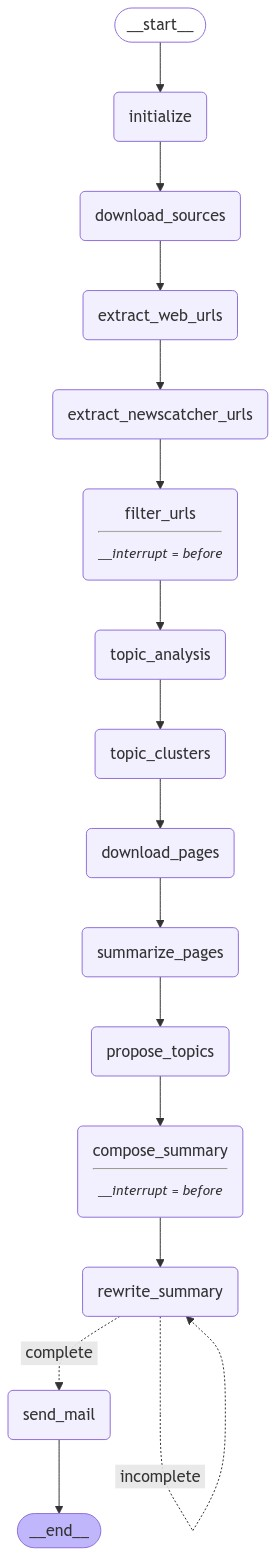

In [56]:
do_download = False
# before_date = None
before_date="2024-10-18 11:00:00"

# initial state
state = AgentState()
state["before_date"] = before_date
state["do_download"] = do_download
state["n_edits"] = 0
state["edit_complete"] = False

# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4().hex
config = {"configurable": {"thread_id": thread_id}}

log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent = Agent(state)
display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [57]:
config


{'configurable': {'thread_id': '09319f7f31f841c29cec256f13dbd3b5'}}

In [58]:
state


{'before_date': '2024-10-18 11:00:00',
 'do_download': False,
 'n_edits': 0,
 'edit_complete': False}

In [59]:
state = lg_agent.run(state, config)


2024-10-20 13:45:41,792 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2024-10-20 13:45:41,793 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-10-20 13:45:41,793 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-10-20 13:45:41,793 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-10-20 13:45:41,794 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-10-20 13:45:41,794 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-10-20 13:45:41,794 - AInewsbot - INFO - 

['Ars Technica', 'Bloomberg Tech', 'Business Insider', 'FT Tech', 'Feedly AI', 'Google News', 'Hacker News', 'Hacker News 2', 'HackerNoon', 'NYT Tech', 'Reddit', 'Techmeme', 'The Register', 'The Verge', 'VentureBeat', 'WSJ Tech', 'WaPo Tech']
['Ars Technica', 'Bloomberg Tech', 'Business Insider', 'FT Tech', 'Feedly AI', 'Google News', 'Hacker News', 'Hacker News 2', 'HackerNoon', 'NYT Tech', 'Reddit', 'Techmeme', 'The Register', 'The Verge', 'VentureBeat', 'WSJ Tech', 'WaPo Tech']


2024-10-20 13:45:42,066 - AInewsbot - INFO - parse_file - found 203 raw links
2024-10-20 13:45:42,070 - AInewsbot - INFO - parse_file - found 31 filtered links
2024-10-20 13:45:42,071 - AInewsbot - INFO - 31 links found
2024-10-20 13:45:42,071 - AInewsbot - INFO - Bloomberg Tech -> htmldata/Bloomberg Technology (10_20_2024 12_34_01 PM).html
2024-10-20 13:45:42,093 - AInewsbot - INFO - parse_file - found 202 raw links
2024-10-20 13:45:42,096 - AInewsbot - INFO - parse_file - found 14 filtered links
2024-10-20 13:45:42,097 - AInewsbot - INFO - 14 links found
2024-10-20 13:45:42,097 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider Tech (10_20_2024 12_33_58 PM).html
2024-10-20 13:45:42,122 - AInewsbot - INFO - parse_file - found 309 raw links
2024-10-20 13:45:42,126 - AInewsbot - INFO - parse_file - found 51 filtered links
2024-10-20 13:45:42,126 - AInewsbot - INFO - 51 links found
2024-10-20 13:45:42,127 - AInewsbot - INFO - FT Tech -> htmldata/FT Technology (10_20_2024 

,id
src,
Ars Technica,24
Bloomberg Tech,11
Business Insider,50
FT Tech,56
Google News,63
Hacker News,25
Hacker News 2,20
HackerNoon,99
NYT Tech,19


2024-10-20 13:45:42,657 - AInewsbot - INFO - Fetching top 100 stories matching Artificial Intelligence from Newscatcher


,id
src,
Ars Technica,24
Bloomberg Tech,11
Business Insider,50
FT Tech,56
Google News,63
Hacker News,25
Hacker News 2,20
HackerNoon,99
NYT Tech,19


In [60]:
# it stopped here because we compiled with interrupt_before=["filter_urls", "compose_summary",]
last_state = lg_agent.graph.get_state(config)


In [65]:
pd.DataFrame(last_state.values['AIdf']).groupby('src').count()

,id,title,url
src,,,
Ars Technica,24,24,24
Bloomberg Tech,11,11,11
Business Insider,50,50,50
FT Tech,56,56,56
Google News,63,63,63
Hacker News,25,25,25
Hacker News 2,20,20,20
HackerNoon,99,99,99
NYT Tech,19,19,19


In [66]:
# if something got a robot block, download manually and rerun from beginning
# if all OK, then proceed
# state=None proceeds from last state
state = lg_agent.run(None, config)


,id
src,
Ars Technica,24
Bloomberg Tech,11
Business Insider,50
FT Tech,56
Google News,63
Hacker News,25
Hacker News 2,20
HackerNoon,99
NYT Tech,19


2024-10-20 13:47:05,790 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2024-10-18 11:00:00'
2024-10-20 13:47:06,449 - AInewsbot - INFO - URLs in orig_df: 944
2024-10-20 13:47:06,451 - AInewsbot - INFO - Existing URLs in DB: 165030
2024-10-20 13:47:06,487 - AInewsbot - INFO - New URLs in df filtered by URL: 358
2024-10-20 13:47:06,583 - AInewsbot - INFO - Existing src+title: 7
2024-10-20 13:47:06,584 - AInewsbot - INFO - New URLs in df filtered by src+title: 351
2024-10-20 13:47:06,595 - AInewsbot - INFO - Found 338 unique new headlines
2024-10-20 13:47:06,602 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-10-20 13:47:06,602 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:47:06,603 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:47:06,603 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:47:06,603 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:47:06,604 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:47:06,604 - AInewsbot - IN

,id
src,
Ars Technica,1
Bloomberg Tech,1
Business Insider,4
FT Tech,3
Google News,17
Hacker News,4
Hacker News 2,3
HackerNoon,13
NYT Tech,1


2024-10-20 13:47:10,183 - AInewsbot - INFO - start free-form topic extraction
2024-10-20 13:47:10,183 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-20 13:47:10,184 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:47:10,184 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:47:10,184 - AInewsbot - INFO - sent 3 items 
2024-10-20 13:47:11,690 - AInewsbot - INFO - got dict with 3 items 
2024-10-20 13:47:17,471 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:47:17,937 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:47:17,939 - AInewsbot - INFO - Processed 103 responses.
2024-10-20 13:47:17,940 - AInewsbot - INFO - 103 free-form topics extracted
2024-10-20 13:47:17,943 - AInewsbot - INFO - ['china', 'cost reduction', 'healthcare', 'diagnostics', 'wealth management', 'marketing', 'morgan stanley', 'price target', 'amd', 'nvidia', 'competition', 'microsoft', 'openai', 'apple', 'fundraising', 'earnings', 'ipad mini', 'technology advantage', 'si

2024-10-20 13:47:57,258 - AInewsbot - INFO - got dict with 3 items 
2024-10-20 13:47:59,845 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:47:59,984 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:47:59,986 - AInewsbot - INFO - Processed 103 responses.
2024-10-20 13:47:59,986 - AInewsbot - INFO - China, topic 12 of 100
2024-10-20 13:47:59,987 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-20 13:47:59,988 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:47:59,989 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:47:59,990 - AInewsbot - INFO - sent 3 items 
2024-10-20 13:48:00,513 - AInewsbot - INFO - got dict with 3 items 
2024-10-20 13:48:02,814 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:48:02,930 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:48:02,931 - AInewsbot - INFO - Processed 103 responses.
2024-10-20 13:48:02,932 - AInewsbot - INFO - Climate, topic 13 of 100
2024-10-20 13:48:02,932 - AInewsbot - INF

2024-10-20 13:48:51,777 - AInewsbot - INFO - Processed 103 responses.
2024-10-20 13:48:51,778 - AInewsbot - INFO - Economics, topic 25 of 100
2024-10-20 13:48:51,779 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-20 13:48:51,782 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:48:51,783 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:48:51,784 - AInewsbot - INFO - sent 3 items 
2024-10-20 13:48:52,658 - AInewsbot - INFO - got dict with 3 items 
2024-10-20 13:48:55,013 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:48:55,730 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:48:55,742 - AInewsbot - INFO - Processed 103 responses.
2024-10-20 13:48:55,743 - AInewsbot - INFO - Education, topic 26 of 100
2024-10-20 13:48:55,744 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-20 13:48:55,745 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:48:55,747 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:48:55,748 - AInew

2024-10-20 13:49:40,904 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:49:40,905 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:49:40,906 - AInewsbot - INFO - sent 3 items 
2024-10-20 13:49:41,709 - AInewsbot - INFO - got dict with 3 items 
2024-10-20 13:49:44,053 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:49:44,437 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:49:44,440 - AInewsbot - INFO - Processed 103 responses.
2024-10-20 13:49:44,440 - AInewsbot - INFO - Governance, topic 39 of 100
2024-10-20 13:49:44,441 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-20 13:49:44,443 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:49:44,444 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:49:44,449 - AInewsbot - INFO - sent 3 items 
2024-10-20 13:49:45,382 - AInewsbot - INFO - got dict with 3 items 
2024-10-20 13:49:48,108 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:49:48,777 - AInewsbot - INFO - got dict with 50 item

2024-10-20 13:50:28,508 - AInewsbot - INFO - got dict with 3 items 
2024-10-20 13:50:31,169 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:50:31,714 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:50:31,717 - AInewsbot - INFO - Processed 103 responses.
2024-10-20 13:50:31,717 - AInewsbot - INFO - Job Automation, topic 52 of 100
2024-10-20 13:50:31,718 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-20 13:50:31,719 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:50:31,721 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:50:31,721 - AInewsbot - INFO - sent 3 items 
2024-10-20 13:50:32,501 - AInewsbot - INFO - got dict with 3 items 
2024-10-20 13:50:35,289 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:50:35,298 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:50:35,300 - AInewsbot - INFO - Processed 103 responses.
2024-10-20 13:50:35,300 - AInewsbot - INFO - Jobs & CareersLabor Market, topic 53 of 100
2024-10-20 13

2024-10-20 13:51:17,638 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:51:17,640 - AInewsbot - INFO - Processed 103 responses.
2024-10-20 13:51:17,641 - AInewsbot - INFO - Opinion, topic 65 of 100
2024-10-20 13:51:17,643 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-20 13:51:17,645 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:51:17,646 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:51:17,647 - AInewsbot - INFO - sent 3 items 
2024-10-20 13:51:18,373 - AInewsbot - INFO - got dict with 3 items 
2024-10-20 13:51:20,957 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:51:20,977 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:51:20,979 - AInewsbot - INFO - Processed 103 responses.
2024-10-20 13:51:20,980 - AInewsbot - INFO - Policy and regulation, topic 66 of 100
2024-10-20 13:51:20,981 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-20 13:51:20,982 - AInewsbot - INFO - sent 50 items 
2024-10-20 1

2024-10-20 13:52:06,333 - AInewsbot - INFO - Safety and Alignment, topic 78 of 100
2024-10-20 13:52:06,334 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-20 13:52:06,335 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:52:06,337 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:52:06,338 - AInewsbot - INFO - sent 3 items 
2024-10-20 13:52:07,020 - AInewsbot - INFO - got dict with 3 items 
2024-10-20 13:52:09,567 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:52:09,908 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:52:09,910 - AInewsbot - INFO - Processed 103 responses.
2024-10-20 13:52:09,911 - AInewsbot - INFO - Scams, topic 79 of 100
2024-10-20 13:52:09,912 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-20 13:52:09,913 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:52:09,914 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:52:09,915 - AInewsbot - INFO - sent 3 items 
2024-10-20 13:52:10,706 - AInewsbot

2024-10-20 13:52:54,444 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:52:54,445 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:52:54,445 - AInewsbot - INFO - sent 3 items 
2024-10-20 13:52:55,275 - AInewsbot - INFO - got dict with 3 items 
2024-10-20 13:52:57,938 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:52:57,941 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:52:57,943 - AInewsbot - INFO - Processed 103 responses.
2024-10-20 13:52:57,944 - AInewsbot - INFO - Taiwan, topic 92 of 100
2024-10-20 13:52:57,945 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-20 13:52:57,946 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:52:57,947 - AInewsbot - INFO - sent 50 items 
2024-10-20 13:52:57,948 - AInewsbot - INFO - sent 3 items 
2024-10-20 13:52:58,810 - AInewsbot - INFO - got dict with 3 items 
2024-10-20 13:53:01,024 - AInewsbot - INFO - got dict with 50 items 
2024-10-20 13:53:01,497 - AInewsbot - INFO - got dict with 50 items 
2

,id
src,
Ars Technica,1
Bloomberg Tech,1
Business Insider,4
FT Tech,3
Google News,17
Hacker News,4
Hacker News 2,3
HackerNoon,13
NYT Tech,1


2024-10-20 13:53:31,903 - AInewsbot - INFO - Fetching embeddings for 103 headlines
2024-10-20 13:53:32,628 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-10-20 13:53:33,067 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2024-10-20 13:53:33,097 - AInewsbot - INFO - Load umap dimensionality reduction model
2024-10-20 13:53:34,331 - AInewsbot - INFO - Perform dimensionality reduction
2024-10-20 13:53:35,065 - AInewsbot - INFO - Cluster with DBSCAN


,id,title_topic_str
0,0,"Apples New iPad Mini Highlights the Companys Secret AI Advantage (Topics: Apple, Gen AI, Ipad Mini, Products, Technology Advantage)"
1,1,"Apple's own research sheds light on Siri's AI laggardness (Topics: Apple, Gen AI, Research, Siri, Speech Recognition & Synthesis, Virtual Assistants)"
2,2,"Gurman: Apple internally believes that its at least two years behind in AI development (Topics: Apple, Competition, Development, Gen AI)"
3,3,"Apple's New iPad Mini Highlights the Company's AI Advantage (Topics: Apple, Gen AI, Ipad Mini, Products, Technology Advantage)"
4,4,"Gurman: Apple internally believes that it's at least two years behind in AI development (Topics: Apple, Competition, Development, Gen AI)"


2024-10-20 13:53:36,074 - AInewsbot - INFO - {'topic_title': 'Apple and AI Development Challenges'}
2024-10-20 13:53:36,074 - AInewsbot - INFO - I dub this cluster: Apple and AI Development Challenges


,id,title_topic_str
5,5,"Micron Technology, Inc. (MU) Reports Strong Q4 Earnings Driven by AI Demand; CEO Highlights Optimism for 2025 Amid Mixed Analyst Ratings (Topics: 2025 Outlook, AI Demand, Analyst Ratings, Ceo, Economics, Finance, Gen AI, Hardware, Micron Technology, Q4 Earnings, Semiconductor Chips, Stocks)"
6,6,"MongoDB, Inc. (MDB) Receives Analyst Upgrades With Increased Price Targets Amid Strong AI and Cloud Software Growth (Topics: Analyst Upgrades, Cloud Software, Economics, Finance, Gen AI, Growth, Mongodb, Price Targets, Stocks)"
7,7,"Cisco Systems, Inc. (CSCO) Receives Buy Rating from Tigress Financial with $78 Price Target, Driven by AI Growth and Subscription Model Transition (Topics: Cisco, Economics, Finance, Financial Growth, Gen AI, Stocks, Subscription Model)"
8,8,"The Trade Desk, Inc. (TTD) Sees Price Target Upgrades from Citi and Stifel Amid Strong AI-Driven Growth in Connected TV and Retail Media (Topics: AI Growth, Citi, Economics, Finance, Gen AI, Price Target, Recommendation Systems, Stifel, Stocks, Streaming, Trade Desk, Tv & Film & Movies)"
9,9,"Reddit Inc (RDDT) Gains Buy' Rating from Jefferies With $90 Price Target Amid AI-Driven Growth and Strong User Engagement (Topics: AI Growth, Buy Rating, Economics, Finance, Gen AI, Jefferies, Reddit, Stocks, User Engagement)"
10,10,"ServiceNow, Inc. (NOW) Price Target Raised to $1,025 by BMO Capital Markets, Reflecting Confidence in AI-Driven Growth Potential (Topics: AI Growth, Bmo Capital Markets, Economics, Finance, Gen AI, Price Target, Servicenow, Stocks)"


2024-10-20 13:53:36,482 - AInewsbot - INFO - {'topic_title': 'AI-Driven Growth in Technology Stocks'}
2024-10-20 13:53:36,483 - AInewsbot - INFO - I dub this cluster: AI-Driven Growth in Technology Stocks


,id,title_topic_str
11,11,"Down 34%, This AI Stock Is a No-Brainer Buy Stock Right Now (Topics: Buy Recommendation, Economics, Finance, Gen AI, Investment, Opinion, Stock Market, Stocks)"
12,12,"Up 35% in 3 Months, This Tech Stock Could Become the Next Big Artificial Intelligence (AI) Play (Topics: Economics, Finance, Gen AI, Investment, Stocks, Tech Stock)"
13,13,"Want to Invest in Artificial Intelligence (AI) Safely? Buy These 3 ETFs (Topics: Deals, Economics, Etfs, Finance, Gen AI, Investing, Safety And Alignment, Stocks, Venture Capital)"


2024-10-20 13:53:36,870 - AInewsbot - INFO - {'topic_title': 'Investing in AI Stocks and ETFs'}
2024-10-20 13:53:36,871 - AInewsbot - INFO - I dub this cluster: Investing in AI Stocks and ETFs


,id,title_topic_str
14,14,"How artificial intelligence is transforming wealth management (Topics: Economics, Ethics, Finance, Fintech, Gen AI, Inequality, Job Automation, Recommendation Systems, Science, Transformation, Wealth Management)"
15,15,"Escaping the Payday Matrix: Ex-OpenAI & Opera Devs Code Financial Freedom for 1.4 Billion Unbanked (Topics: Bias And Fairness, Cryptocurrency, Economics, Ethics, Finance, Financial Freedom, Fintech, Gen AI, Governance, India, Inequality, Jobs & Careerslabor Market, Language Models, Legal Issues, Open Source, OpenAI, Opera, Society & Culture, Unbanked Population)"
16,16,"How AI will transform wealth management (Topics: Economics, Ethics, Finance, Fintech, Gen AI, Inequality, Job Automation, Recommendation Systems, Transformation, Wealth Management)"
17,17,"AI in Family Offices: Navigating the AI Frontier in Wealth Management and Fiduciary Liability (Topics: Economics, Ethics, Family Offices, Fiduciary Liability, Finance, Fintech, Gen AI, Legal Issues, Wealth Management)"


2024-10-20 13:53:37,260 - AInewsbot - INFO - {'topic_title': 'AI in Wealth Management'}
2024-10-20 13:53:37,261 - AInewsbot - INFO - I dub this cluster: AI in Wealth Management


,id,title_topic_str
18,18,"Mixtrals Multilingual Benchmarks, Long Range Performance, and Bias Benchmarks (Topics: Benchmarks, Bias, Bias And Fairness, Ethics, Gen AI, Language Models, Mixtral, Multilingual, Performance, Review, Safety And Alignment, Science)"
19,19,"How Instruction Fine-Tuning Elevates Mixtral Instruct Above Competitors (Topics: Competitors, Gen AI, Instruction Fine-Tuning, Language Models, Mixtral, Reinforcement Learning, Science)"
20,20,"Understanding the Mixture of Experts Layer in Mixtral (Topics: Cognitive Science, Gen AI, Language Models, Mixtral, Mixture Of Experts, Reinforcement Learning, Retrieval Augmented Generation, Review, Science)"


2024-10-20 13:53:37,725 - AInewsbot - INFO - {'topic_title': 'Mixtral Language Model Performance and Ethics'}
2024-10-20 13:53:37,726 - AInewsbot - INFO - I dub this cluster: Mixtral Language Model Performance and Ethics


,id,title_topic_str
21,21,"Meet the Newest Artificial Intelligence (AI) Chip Stock to Join Nvidia in the $1 Trillion Club (Topics: $1 Trillion Club, Chip Stock, Gen AI, Hardware, Manufacturing, Neuromorphic Computing, Nvidia, Products, Semiconductor Chips, Stocks)"
22,22,"Wall Street's Hottest Trend, Artificial Intelligence (AI), Has a Conviction Problem -- Just Ask Nvidia, Broadcom, and Advanced Micro Devices (Topics: Amd, Broadcom, Economics, Ethics, Finance, Gen AI, Hardware, Nvidia, Semiconductor Chips, Stocks, Wall Street)"
23,23,"NVIDIA Corporation (NVDA) Dominates AI Chip Market with Blackwell; Analysts Maintain Strong Buy Ratings as Stocks Surge and S&P 500 Reaches Record High (Topics: AI Chip Market, Analysts, Blackwell, Economics, Finance, Gen AI, Hardware, Nvidia, Products, S&P 500, Semiconductor Chips, Stock Surge, Stocks)"


2024-10-20 13:53:38,160 - AInewsbot - INFO - {'topic_title': 'Artificial Intelligence and Semiconductor Stocks'}
2024-10-20 13:53:38,160 - AInewsbot - INFO - I dub this cluster: Artificial Intelligence and Semiconductor Stocks


['Apple and AI Development Challenges', 'AI-Driven Growth in Technology Stocks', 'Investing in AI Stocks and ETFs', 'AI in Wealth Management', 'Mixtral Language Model Performance and Ethics', 'Artificial Intelligence and Semiconductor Stocks']


Apple and AI Development Challenges

AI-Driven Growth in Technology Stocks

Investing in AI Stocks and ETFs

AI in Wealth Management

Mixtral Language Model Performance and Ethics

Artificial Intelligence and Semiconductor Stocks

2024-10-20 13:53:38,189 - AInewsbot - INFO - Queuing URLs for scraping
2024-10-20 13:53:38,191 - AInewsbot - INFO - fetching 103 pages using 4 browsers
2024-10-20 13:53:38,191 - AInewsbot - INFO - get_driver - 93979 Initializing webdriver
2024-10-20 13:53:38,192 - AInewsbot - INFO - get_driver - 93979 Initializing webdriver
2024-10-20 13:53:38,192 - AInewsbot - INFO - get_driver - 93979 Initializing webdriver
2024-10-20 13:53:38,192 - AInewsbot - INFO - get_driver - 93979 Initializing webdriver
2024-10-20 13:53:55,077 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-20 13:53:55,077 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-20 13:53:55,077 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-20 13:53:55,077 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-20 13:53:55,078 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-20 13:53:55,078 - AInewsbot - INFO - get_driver - In

2024-10-20 13:55:00,172 - AInewsbot - INFO - Processing page 14: https://news.google.com/read/CBMioAFBVV95cUxPMVdJREJmSzIxc1RpMnFqUW1FU3pWZjBRYy0tSUh1MWl3TkVGbDczR1VnRzZia19yazUyQ3JveDJoUnZpWVR1OWlRaTRSbjBETkZsd3NHY1F3Zm42dDh5ak9oNzlBM1NHZWVpZFQtVGNTb3I2QlZQcDY4cVRSaEI1TW42bncxTDM2QVlPbTVNQ00xMlQxUG9yalBJWDZZZ0lK
2024-10-20 13:55:00,175 - AInewsbot - INFO - Processing page 15: https://hackernoon.com/escaping-the-payday-matrix-ex-openai-and-opera-devs-code-financial-freedom-for-14-billion-unbanked
2024-10-20 13:55:00,176 - AInewsbot - INFO - get_url(https://hackernoon.com/escaping-the-payday-matrix-ex-openai-and-opera-devs-code-financial-freedom-for-14-billion-unbanked) - starting get_url https://hackernoon.com/escaping-the-payday-matrix-ex-openai-and-opera-devs-code-financial-freedom-for-14-billion-unbanked
2024-10-20 13:55:00,175 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMioAFBVV95cUxPMVdJREJmSzIxc1RpMnFqUW1FU3pWZjBRYy0tSUh1MWl3TkVGbDczR1VnRzZia19yazUyQ3JveDJoUnZpWVR

2024-10-20 13:55:12,434 - AInewsbot - INFO - Processing page 26: https://www.theverge.com/2024/10/18/24273895/penguin-random-house-books-copyright-ai
2024-10-20 13:55:12,434 - AInewsbot - INFO - get_url(https://www.theverge.com/2024/10/18/24273895/penguin-random-house-books-copyright-ai) - starting get_url https://www.theverge.com/2024/10/18/24273895/penguin-random-house-books-copyright-ai
2024-10-20 13:55:12,630 - AInewsbot - INFO - get_url(How Instruction Fine-Tuning Elevates Mixtral  Instruct Above Competitors) - Saving How_Instruction_Fine-Tuning_Elevates_Mixtral__Instruct_Above_Competitors.html as utf-8
2024-10-20 13:55:12,634 - AInewsbot - INFO - Processing page 27: https://www.wsj.com/tech/waymo-san-francisco-self-driving-robotaxis-uber-244feecf
2024-10-20 13:55:12,636 - AInewsbot - INFO - get_url(https://www.wsj.com/tech/waymo-san-francisco-self-driving-robotaxis-uber-244feecf) - starting get_url https://www.wsj.com/tech/waymo-san-francisco-self-driving-robotaxis-uber-244feecf


2024-10-20 13:55:23,660 - AInewsbot - INFO - get_url(https://uk.finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-185830731.html) - starting get_url https://uk.finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-185830731.html
2024-10-20 13:55:23,660 - AInewsbot - INFO - Processing page 38: https://www.bloomberg.com/news/features/2024-10-18/do-ai-detectors-work-students-face-false-cheating-accusations
2024-10-20 13:55:23,660 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/features/2024-10-18/do-ai-detectors-work-students-face-false-cheating-accusations) - starting get_url https://www.bloomberg.com/news/features/2024-10-18/do-ai-detectors-work-students-face-false-cheating-accusations
2024-10-20 13:55:24,195 - AInewsbot - INFO - get_url(Penguin Random House amends its copyright notice globally to prohibit the use of books for training AI; the notice will be included in new titles and reprints) - Saving Penguin_Random_House_amends_

2024-10-20 13:55:44,641 - AInewsbot - INFO - Processing page 52: https://www.theverge.com/2024/10/18/24273748/google-deepmind-gemini-search-chaptgpt-meta-ai-interview
2024-10-20 13:55:44,642 - AInewsbot - INFO - get_url(https://www.theverge.com/2024/10/18/24273748/google-deepmind-gemini-search-chaptgpt-meta-ai-interview) - starting get_url https://www.theverge.com/2024/10/18/24273748/google-deepmind-gemini-search-chaptgpt-meta-ai-interview
2024-10-20 13:55:47,275 - AInewsbot - INFO - get_url(New JAMA channel highlights AIs role in medicine) - Saving New_JAMA_channel_highlights_AIs_role_in_medicine.html as utf-8
2024-10-20 13:55:47,276 - AInewsbot - INFO - Processing page 53: https://arstechnica.com/ai/2024/10/openai-releases-chatgpt-app-for-windows/
2024-10-20 13:55:47,277 - AInewsbot - INFO - get_url(https://arstechnica.com/ai/2024/10/openai-releases-chatgpt-app-for-windows/) - starting get_url https://arstechnica.com/ai/2024/10/openai-releases-chatgpt-app-for-windows/
2024-10-20 13:5

2024-10-20 13:55:59,451 - AInewsbot - INFO - Processing page 68: https://www.theregister.com/2024/10/20/python_zero_day_tool/
2024-10-20 13:55:59,451 - AInewsbot - INFO - get_url(https://www.theregister.com/2024/10/20/python_zero_day_tool/) - starting get_url https://www.theregister.com/2024/10/20/python_zero_day_tool/
2024-10-20 13:55:59,452 - AInewsbot - INFO - Processing page 69: https://finance.yahoo.com/news/palo-alto-networks-inc-panw-183102342.html
2024-10-20 13:55:59,452 - AInewsbot - INFO - get_url(https://finance.yahoo.com/news/palo-alto-networks-inc-panw-183102342.html) - starting get_url https://finance.yahoo.com/news/palo-alto-networks-inc-panw-183102342.html
2024-10-20 13:55:59,454 - AInewsbot - INFO - Processing page 70: https://www.businessinsider.com/google-notebooklm-ai-podcast-tool-customize-feature-update-2024-10
2024-10-20 13:55:59,455 - AInewsbot - INFO - get_url(https://www.businessinsider.com/google-notebooklm-ai-podcast-tool-customize-feature-update-2024-10) - 

2024-10-20 13:56:23,226 - AInewsbot - INFO - Processing page 83: https://news.google.com/read/CBMiugFBVV95cUxNSzMtRUx1cjJQUHhkMVliV0hIQkxzeC1pTTJIUV96UW9XMEdxTWw2ZVYySVNPY0h2dmtWWUFtQlBxNGlKMzNMckZLVTZha2VCMk1PZnNHdS1rYmJWc2ZubXhDLUZqeTRaUS1NTFJieGhzaXZ5cXBGMTR1TWhHR1B0NWxhSjN3RTc3T2RhMlNMMDNuRjBhdDhxQVVLOXdQcVlwU2ZhNGkzMnlXU2p1S3hwWm9yaWxFaHVyQ2c
2024-10-20 13:56:23,227 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMiugFBVV95cUxNSzMtRUx1cjJQUHhkMVliV0hIQkxzeC1pTTJIUV96UW9XMEdxTWw2ZVYySVNPY0h2dmtWWUFtQlBxNGlKMzNMckZLVTZha2VCMk1PZnNHdS1rYmJWc2ZubXhDLUZqeTRaUS1NTFJieGhzaXZ5cXBGMTR1TWhHR1B0NWxhSjN3RTc3T2RhMlNMMDNuRjBhdDhxQVVLOXdQcVlwU2ZhNGkzMnlXU2p1S3hwWm9yaWxFaHVyQ2c) - starting get_url https://news.google.com/read/CBMiugFBVV95cUxNSzMtRUx1cjJQUHhkMVliV0hIQkxzeC1pTTJIUV96UW9XMEdxTWw2ZVYySVNPY0h2dmtWWUFtQlBxNGlKMzNMckZLVTZha2VCMk1PZnNHdS1rYmJWc2ZubXhDLUZqeTRaUS1NTFJieGhzaXZ5cXBGMTR1TWhHR1B0NWxhSjN3RTc3T2RhMlNMMDNuRjBhdDhxQVVLOXdQcVlwU2ZhNGkzMnlXU2p1S3hwWm9yaWxFaHVyQ2c
2024-10

2024-10-20 13:56:42,336 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMirAFBVV95cUxOd1I5S25kRE1fV0NtT1k4YnhaNE9sdDFVZE1GSHUtODNJQzYzZV9NLXEwUGowcXoxS25xUVdpQUF1SWc3cFI5Q29tLWtoTFNOYmpmcUs1dFRNOV9xclRoV2xnaXZ0Z0xOQ1piN1ZLUUI0TzZfVEFKLXVRb3M4LVAweTdIQ0ctdVRnOGNFbUhjUFdSVG5hTThZU3N2MXNRdTlXNHBVZ29QV1BkWFVN) - starting get_url https://news.google.com/read/CBMirAFBVV95cUxOd1I5S25kRE1fV0NtT1k4YnhaNE9sdDFVZE1GSHUtODNJQzYzZV9NLXEwUGowcXoxS25xUVdpQUF1SWc3cFI5Q29tLWtoTFNOYmpmcUs1dFRNOV9xclRoV2xnaXZ0Z0xOQ1piN1ZLUUI0TzZfVEFKLXVRb3M4LVAweTdIQ0ctdVRnOGNFbUhjUFdSVG5hTThZU3N2MXNRdTlXNHBVZ29QV1BkWFVN
2024-10-20 13:56:42,337 - AInewsbot - INFO - Processing page 98: https://ca.finance.yahoo.com/news/advanced-micro-devices-inc-amd-184906267.html
2024-10-20 13:56:42,337 - AInewsbot - INFO - get_url(https://ca.finance.yahoo.com/news/advanced-micro-devices-inc-amd-184906267.html) - starting get_url https://ca.finance.yahoo.com/news/advanced-micro-devices-inc-amd-184906267.html
2024-10-20 13:56:

Apple and AI Development Challenges

AI-Driven Growth in Technology Stocks

Investing in AI Stocks and ETFs

AI in Wealth Management

Mixtral Language Model Performance and Ethics

Artificial Intelligence and Semiconductor Stocks

2024-10-20 14:00:47,435 - AInewsbot - INFO - Starting summarize
2024-10-20 14:00:47,452 - AInewsbot - INFO - fetch_all_summaries - Page title: Bloomberg - Are you a robot?

2024-10-20 14:00:47,527 - AInewsbot - INFO - fetch_all_summaries - Page title: Apple's own research sheds light on Siri's AI laggardness | Digital Trends
Social card title: Apple's own research sheds light on Siri's AI laggardness | Digital Trends
Social card description: According to Bloomberg, Apple's internal research exposed the wide gulf between Siri and ChatGPT when it comes raw AI intelligence and accuracy.

2024-10-20 14:00:47,586 - AInewsbot - INFO - fetch_all_summaries - Page title: Gurman: Apple internally believes that it's at least two years behind in AI development - 9to5Mac
Social card title: Gurman: Apple internally believes that it's at least two years behind in AI development - 9to5Mac
Social card description: According to the latest edition of Mark Gurman’s Power On newsletter, some employees at A

2024-10-20 14:00:48,754 - AInewsbot - INFO - fetch_all_summaries - Page title: Understanding Artificial Intelligence Use in the Family Offices
Social card title: AI in Family Offices: Navigating the AI Frontier in Wealth Management and Fiduciary Liability
Social card description: Artificial intelligence (AI) has made waves across various industries, and wealth management is no exception. AI’s ability to analyze vast amounts of data and generate insightful reports has the potential to significantly enhance the efficiency and effectiveness of wealth management firms.

2024-10-20 14:00:48,802 - AInewsbot - INFO - fetch_all_summaries - Page title: Mixtral’s Multilingual Benchmarks, Long Range Performance, and Bias Benchmarks | HackerNoon
Social card title: Mixtral’s Multilingual Benchmarks, Long Range Performance, and Bias Benchmarks | HackerNoon
Social card description: Mixtral 8x7B demonstrates outstanding performance in multilingual benchmarks, long-range context retrieval, and bias mea

2024-10-20 14:00:50,345 - AInewsbot - INFO - fetch_all_summaries - Page title: X’s controversial changes to blocking and AI training sees half a million users leave for rival Bluesky – which then crashes under the strain : r/technology

2024-10-20 14:00:50,450 - AInewsbot - INFO - fetch_all_summaries - Page title: Wolters Kluwer AI Labs Marks First Year of Collaboration in Developing New, Responsible AI Features for UpToDate
Social card title: Wolters Kluwer AI Labs Marks First Year of Collaboration in Developing New, Responsible AI Features for UpToDate
Social card description: WALTHAM, Mass., October 17, 2024--Wolters Kluwer Health is marking the first year of AI Labs for UpToDate® with the delivery of new AI capabilities designed to support smarter clinical decision making. AI Labs is an experimental resource that puts health system customers at the center of innovation, aiding with testing and feedback on new and prototype AI-enabled clinical decision support technologies. UpToDate

2024-10-20 14:00:51,345 - AInewsbot - INFO - fetch_all_summaries - Page title: How Google is changing to compete with ChatGPT - The Verge
Social card title: How Google is changing to compete with ChatGPT
Social card description: Google is all in on Gemini as the future.

2024-10-20 14:00:51,379 - AInewsbot - INFO - fetch_all_summaries - Page title: OpenAI releases ChatGPT app for Windows - Ars Technica
Social card title: OpenAI releases ChatGPT app for Windows
Social card description: New Alt+Space shortcut puts OpenAI’s assistant a key press away at all times.

2024-10-20 14:00:51,395 - AInewsbot - INFO - fetch_all_summaries - Page title: AI-powered malware emerges as new threat in cybersecurity landscape
Social card title: AI-powered malware emerges as new threat in cybersecurity landscape
Social card description: Cybercriminals increasingly use AI to create sophisticated malware, according to Check Point Software's September 2024 report. AsyncRAT ranks 10th in prevalence, with AI-ge

2024-10-20 14:00:52,292 - AInewsbot - INFO - fetch_all_summaries - Page title: Google's AI Podcast Tool, NotebookLM, Just Got Better - Business Insider
Social card title: Google's viral AI podcast tool just got more useful
Social card description: Google's product lead for the AI podcast tool, which now has millions of users, told BI that customizing instructions was the most requested feature.

2024-10-20 14:00:52,381 - AInewsbot - INFO - fetch_all_summaries - Page title: The more AI Develops, the more Human-Like Zuck appears. Must be coincidence... right? *nervous laughter* : r/ChatGPT

2024-10-20 14:00:52,462 - AInewsbot - INFO - fetch_all_summaries - Page title: Ariana Grande Responds After Wicked Co-Star Cynthia Erivo Calls Out Fans For Using A.I. To Make Edited Posters
Social card title: Ariana Grande Responds After Wicked Co-Star Cynthia Erivo Calls Out Fans For Using A.I. To Make Edited Posters
Social card description: These comments come after Erivo's objection to A.I. fan art

2024-10-20 14:00:53,399 - AInewsbot - INFO - fetch_all_summaries - Page title: This is OpenAI CEO Sam Altman's favorite question about AGI
Social card title: This is OpenAI CEO Sam Altman's favorite question about AGI
Social card description: Altman said artificial general intelligence will facilitate "scaffolding that exists between all of us."

2024-10-20 14:00:53,440 - AInewsbot - INFO - fetch_all_summaries - Page title: Subscribe to read
Social card title: Chinese AI groups get creative to drive down cost of models
Social card description: 01.ai, Alibaba and ByteDance have cut ‘inference’ costs despite Washington curbs on accessing cutting-edge chips

2024-10-20 14:00:53,504 - AInewsbot - INFO - fetch_all_summaries - Page title: Snowflake Inc. (SNOW) Navigates Investor Challenges Amid Strong AI Data Cloud Performance, Viewed as a Key Player in Next Wave of Generative AI Investments
Social card title: Snowflake Inc. (SNOW) Navigates Investor Challenges Amid Strong AI Data Cloud Perf

[1. Apples New iPad Mini Highlights the Companys Secret AI Advantage - Google News](https://news.google.com/read/CBMi2gFBVV95cUxObXFvQ1BQdEFpWkw3MVRSbE8wX1dpalc2R1VDZGlXX1pNQ1NfNFpfOHk3aVBVVENTSWVfQUJZbFdnSkRpMnQwMmhOVWJDZFhweEVMMjJRZC01ZllYa1ZqR0pzYnkzU084N1VMcFhnYlFjRmViSmRlRXhSUXlLUWZnclJXMUZNSjhuUnZudVBPck9xTDhIY3BaX18za1JzVG0zeFB2VnVuaGYtV3ozUjdreG5aSW9ER045ZGk5X050cmFtN0haWV9paUR6R3BVT1FkSC0xNEc4MDhYQQ)  

 Apple and AI Development Challenges, Apple, Gen AI, Ipad Mini, Products, Technology Advantage  

- The text is primarily focused on verifying users are not robots.
- It includes instructions regarding browser compatibility and cookie settings.
- There is a note for users to contact support for assistance. 



[2. Apple's own research sheds light on Siri's AI laggardness - Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)  

 Apple and AI Development Challenges, Apple, Gen AI, Research, Siri, Speech Recognition & Synthesis, Virtual Assistants  

- Apple's internal research reveals Siri's AI capabilities lag behind OpenAI's ChatGPT, with ChatGPT being 25% more accurate and able to answer 30% more questions.
- Despite enhancements to Siri's natural language understanding and integration with apps, Apple is relying on OpenAI's technology to fulfill tasks that Siri cannot handle effectively.
- Apple is perceived to be over two years behind industry leaders in generative AI technology, leading to concerns over its competitive position in the market. 



[3. Gurman: Apple internally believes that its at least two years behind in AI development - Google News](https://news.google.com/read/CBMiekFVX3lxTE5IU0d3SHM3TEJ4M1lsNDdLLUlXY2xlbjBla0VaZ1B6NHBVVXJpMGI0eGhldzRjZUxLMDFtSF8zb2VpSkJyVGZ1b2NjMmtwbmRvenAzVl9Fd1ZOcC1OSXg3cWM0VzYyWFVNMUs5cE1JcHBqSmFFSDRoUktR)  

 Apple and AI Development Challenges, Apple, Competition, Development, Gen AI  

- Internal analysis at Apple suggests the company is approximately two years behind in AI development compared to industry leaders.
- Apple announced a partnership with OpenAI to integrate ChatGPT across its systems, aiming to enhance Siri's capabilities and bridge a knowledge gap, as studies show ChatGPT is significantly more accurate than Siri.
- Despite current setbacks, historical trends indicate Apple is likely to catch up in AI through internal development, hiring, or acquisitions by 2026. 



[4. Apple's New iPad Mini Highlights the Company's AI Advantage - Bloomberg](https://www.bloomberg.com/news/newsletters/2024-10-20/apple-s-latest-ipad-mini-highlights-ai-advantage-sonos-considers-new-headphones-m2hkz4mn)  

 Apple and AI Development Challenges, Apple, Gen AI, Ipad Mini, Products, Technology Advantage  

- Apple's new iPad Mini emphasizes AI features and will support the Apple Intelligence platform, although initial capabilities may not meet user expectations compared to competitors like OpenAI and Google.
- Apple has made significant management changes, including the departure of its Chief People Officer, with new leaders announced in the hardware engineering team amid ongoing struggles in the HR department.
- Sonos is reconsidering its headphone strategy after poor sales of its Ace model, while Amazon has launched a color Kindle amidst challenges in its devices unit. 



[5. Gurman: Apple internally believes that it's at least two years behind in AI development - 9to5Mac](https://9to5mac.com/2024/10/20/gurman-apple-intelligence-ai-two-years)  

 Apple and AI Development Challenges, Apple, Competition, Development, Gen AI  

- Apple employees believe the company is around two years behind in artificial intelligence development, with some internal studies showing ChatGPT is significantly more accurate than Siri.
- Apple plans to integrate OpenAI's GPT-4o into Siri and Writing Tools across its systems, aiming to close the knowledge gap in AI.
- Gurman predicts that, by 2026, Apple Intelligence will be available on all devices with screens, benefitting from the company's capability to run advanced AI models. 



[6. Micron Technology, Inc. (MU) Reports Strong Q4 Earnings Driven by AI Demand; CEO Highlights Optimism for 2025 Amid Mixed Analyst Ratings - Yahoo Finance](https://finance.yahoo.com/news/micron-technology-inc-mu-reports-185157321.html)  

 AI-Driven Growth in Technology Stocks, 2025 Outlook, AI Demand, Analyst Ratings, Ceo, Economics, Finance, Gen AI, Hardware, Micron Technology, Q4 Earnings, Semiconductor Chips, Stocks  

- Micron Technology (MU) reported strong Q4 earnings of \\$7.75 billion, driven by robust AI demand, and expressed optimism for 2025 due to strong data center and server growth.
- Despite a mixed outlook from analysts, with some maintaining a Hold rating, Micron's CEO highlighted the company's strongest competitive position entering fiscal 2025.
- The overall AI semiconductor industry is projected to grow significantly, and ongoing innovations in AI chips are expected to enhance performance and attract further investments. 



[7. MongoDB, Inc. (MDB) Receives Analyst Upgrades With Increased Price Targets Amid Strong AI and Cloud Software Growth - Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)  

 AI-Driven Growth in Technology Stocks, Analyst Upgrades, Cloud Software, Economics, Finance, Gen AI, Growth, Mongodb, Price Targets, Stocks  

- MongoDB, Inc. has received positive analyst upgrades, with DA Davidson raising its price target from \\$330 to \\$340, indicating confidence in its long-term potential despite short-term growth uncertainties.
- The S&P 500 and Nasdaq are experiencing all-time highs driven by optimism in AI and technology sectors, with expectations of strong earnings amid resilient corporate performance.
- The overall AI semiconductor industry is projected to grow significantly, influenced by advancements in AI technology and ongoing investments, while market volatility is anticipated in the tech sector. 



[8. Cisco Systems, Inc. (CSCO) Receives Buy Rating from Tigress Financial with \\$78 Price Target, Driven by AI Growth and Subscription Model Transition - Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)  

 AI-Driven Growth in Technology Stocks, Cisco, Economics, Finance, Financial Growth, Gen AI, Stocks, Subscription Model  

- Tigress Financial has assigned a Buy rating to Cisco Systems, Inc. (CSCO) with a price target of \\$78, citing growth driven by AI advancements and a shift to a subscription model.
- The S&P 500 is projected to reach 6,000 by year-end due to a booming AI sector and resilient corporate earnings, despite potential risks from global conflicts and economic volatility.
- The AI semiconductor industry is expected to grow significantly, with demands for advanced AI-driven networking and security services supporting Cisco’s strategic advancements. 



[9. The Trade Desk, Inc. (TTD) Sees Price Target Upgrades from Citi and Stifel Amid Strong AI-Driven Growth in Connected TV and Retail Media - Yahoo Finance](https://uk.finance.yahoo.com/news/trade-desk-inc-ttd-sees-164912165.html)  

 AI-Driven Growth in Technology Stocks, AI Growth, Citi, Economics, Finance, Gen AI, Price Target, Recommendation Systems, Stifel, Stocks, Streaming, Trade Desk, Tv & Film & Movies  

- Yahoo uses cookies to enhance user experience, authenticate users, and measure site usage.
- By accepting cookies, users allow Yahoo and partners to store data for personalized advertising and content.
- Users can manage their cookie preferences at any time through privacy settings. 



[10. Reddit Inc (RDDT) Gains Buy' Rating from Jefferies With \\$90 Price Target Amid AI-Driven Growth and Strong User Engagement - Yahoo Finance](https://ca.finance.yahoo.com/news/reddit-inc-rddt-gains-buy-161041337.html)  

 AI-Driven Growth in Technology Stocks, AI Growth, Buy Rating, Economics, Finance, Gen AI, Jefferies, Reddit, Stocks, User Engagement  

- Reddit Inc (RDDT) received a ‘Buy’ rating from Jefferies with a price target of \\$90, supported by AI-driven growth and increased user engagement.
- The company's recent advancements in AI and partnerships, including acquiring Memorable AI and collaborating with OpenAI, have contributed to a surge in user growth and content licensing revenue.
- The S&P 500 is projected to reach 6,000 by year-end, driven by strong corporate earnings and optimism around AI stocks, despite potential market risks from geopolitical tensions and economic uncertainties. 



[11. ServiceNow, Inc. (NOW) Price Target Raised to \\$1,025 by BMO Capital Markets, Reflecting Confidence in AI-Driven Growth Potential - Yahoo Finance](https://finance.yahoo.com/news/servicenow-inc-now-price-target-184353541.html)  

 AI-Driven Growth in Technology Stocks, AI Growth, Bmo Capital Markets, Economics, Finance, Gen AI, Price Target, Servicenow, Stocks  

- BMO Capital Markets raised the price target for ServiceNow, Inc. to \\$1,025, reflecting confidence in the company's AI-driven growth potential.
- The S&P 500 is expected to reach 6,000 by year-end, driven by corporate earnings resilience and the AI market boom, with October historically being a volatile month for tech stocks.
- Analysts note that continued market gains depend on sectors demonstrating strong earnings growth, particularly driven by Artificial Intelligence advancements. 



[12. Down 34%, This AI Stock Is a No-Brainer Buy Stock Right Now - Yahoo Finance](https://finance.yahoo.com/news/down-34-ai-stock-no-213700014.html)  

 Investing in AI Stocks and ETFs, Buy Recommendation, Economics, Finance, Gen AI, Investment, Opinion, Stock Market, Stocks  

- ASML's stock has dropped 34% following a disappointing earnings forecast, indicating a longer recovery due to market conditions affecting key segments.
- The company remains the sole producer of extreme ultraviolet lithography machines, giving it a competitive edge amidst the growing demand for AI technology and chip production.
- Despite the setbacks, ASML expects future growth and improving margins, making it a potential buying opportunity for long-term investors. 



[13. Up 35% in 3 Months, This Tech Stock Could Become the Next Big Artificial Intelligence (AI) Play - Yahoo Finance](https://finance.yahoo.com/news/35-3-months-tech-stock-210000872.html)  

 Investing in AI Stocks and ETFs, Economics, Finance, Gen AI, Investment, Stocks, Tech Stock  

- Ciena's stock has increased by 35% over the past three months despite a 12% decline in revenue and a 41% drop in net income in fiscal Q3 due to weak telecom market conditions.
- Analysts predict a potential turnaround for Ciena driven by the rebound in telecommunications spending and the increasing demand for AI-related data center connectivity solutions.
- Investment banks have raised their price targets for Ciena, citing expected growth in its addressable market linked to the proliferation of AI technologies, with earnings anticipated to increase significantly in the coming years. 



[14. Want to Invest in Artificial Intelligence (AI) Safely? Buy These 3 ETFs - Yahoo Finance](https://finance.yahoo.com/news/want-invest-artificial-intelligence-ai-113900048.html)  

 Investing in AI Stocks and ETFs, Deals, Economics, Etfs, Finance, Gen AI, Investing, Safety And Alignment, Stocks, Venture Capital  

- Investors seeking to invest in AI with reduced risk are advised to consider exchange-traded funds (ETFs) like the VanEck Semiconductor ETF, Invesco QQQ Trust, and Vanguard S&P 500 ETF, which provide diversified exposure to top technology and AI-related stocks.
- The VanEck Semiconductor ETF focuses on prominent semiconductor companies crucial for AI chip development, while the Invesco QQQ Trust includes major tech firms with significant AI investments.
- The Vanguard S&P 500 ETF offers broad market exposure and includes leading companies in AI technology, making it a safer investment choice despite not being exclusively focused on AI. 



[15. How artificial intelligence is transforming wealth management - Google News](https://news.google.com/read/CBMioAFBVV95cUxPMVdJREJmSzIxc1RpMnFqUW1FU3pWZjBRYy0tSUh1MWl3TkVGbDczR1VnRzZia19yazUyQ3JveDJoUnZpWVR1OWlRaTRSbjBETkZsd3NHY1F3Zm42dDh5ak9oNzlBM1NHZWVpZFQtVGNTb3I2QlZQcDY4cVRSaEI1TW42bncxTDM2QVlPbTVNQ00xMlQxUG9yalBJWDZZZ0lK)  

 AI in Wealth Management, Economics, Ethics, Finance, Fintech, Gen AI, Inequality, Job Automation, Recommendation Systems, Science, Transformation, Wealth Management  

- Artificial Intelligence (AI) is transforming wealth management by enhancing data utilization, leading to better decision-making and proactive client engagement.
- AI personalizes client interactions and service offerings, improving client acquisition and retention while boosting satisfaction through tailored communication.
- The integration of AI in operational and asset management streamlines processes, enhances risk management, and provides real-time reporting, positioning firms for growth in the digital age. 



[16. Escaping the Payday Matrix: Ex-OpenAI & Opera Devs Code Financial Freedom for 1.4 Billion Unbanked - Hacker Noon](https://hackernoon.com/escaping-the-payday-matrix-ex-openai-and-opera-devs-code-financial-freedom-for-14-billion-unbanked)  

 AI in Wealth Management, Bias And Fairness, Cryptocurrency, Economics, Ethics, Finance, Financial Freedom, Fintech, Gen AI, Governance, India, Inequality, Jobs & Careerslabor Market, Language Models, Legal Issues, Open Source, OpenAI, Opera, Society & Culture, Unbanked Population  

- Volante Chain, founded by former OpenAI and Opera engineers, aims to provide financial freedom to over 1.4 billion unbanked individuals through Earned Wage Access (EWA), allowing workers to withdraw their earnings at any time.
- The platform utilizes blockchain technology and sophisticated AI models to facilitate low-cost, efficient payroll services while eliminating the need for intermediaries, thereby enhancing access to essential financial services.
- The initiative seeks to revolutionize the global payroll market, valued at over \\$100 trillion, by addressing the limitations of traditional financial systems that leave a significant portion of the population economically vulnerable. 



[17. How AI will transform wealth management - Google News](https://news.google.com/read/CBMijgFBVV95cUxQb0xmNHkxbTlwTjRubVVONUVHVktjMHVfcHJuVXdBNk5FN1Z5Ylo1RmhDT1R2dklKMmRMT0hTNzZnU2l5T1VTLTVRVEZ4V1Q0NkhSaFhsZU1lY1ZDMEhfVkxlS2pUVGxfX1dlRExGTU9yYVdOZXgzajZXZXV3eDNCMmdjcnlzWVZ3bnR4S1VB)  

 AI in Wealth Management, Economics, Ethics, Finance, Fintech, Gen AI, Inequality, Job Automation, Recommendation Systems, Transformation, Wealth Management  

- Adam Dell, CEO of Domain Money, emphasizes the transformative potential of AI in financial services, asserting that it will permeate every aspect of the economy and enhance client services in wealth management.
- A study from Ernst & Young indicates that 99% of financial services leaders are utilizing AI, with 77% viewing generative AI as beneficial for the industry's future.
- Dell highlights AI's ability to streamline processes by significantly reducing manual work and notes its potential to disrupt traditional financial software, making personalized financial planning more accessible. 



[18. AI in Family Offices: Navigating the AI Frontier in Wealth Management and Fiduciary Liability - Google News](https://news.google.com/read/CBMitgFBVV95cUxOYzVISVBHV1QwYnBBWWtXenktbFdJdG5kUkNZZTVPOXR2RXo2MmNzdlExX3hpcWxOR3N0Vy1pZnhOVU13eHVmVXhWU3YyWFZmX0NFV1NmM1R6Y3MzNlpHMDQyYUhMN2FOT2dSZVV3SW1oVFpMSTdVZ0NiSExzOVlpVDZfbXh6SGxqeTcxeU5aYU8xYzJfWWo0REtNRU5SOFR0S0R1bzVLaC1LZUdWalFfNjVrRGh6d9IBuwFBVV95cUxPVXdOMTdNNzFKSkRqTnZIX0FGRXBsMzViN1J2Mkc3djdnYWFLbkNfcUxyV0ZGeXIyWU5xS0tqZFB0UHJXWk1JSGRnRk90eUpScEx0SWNhbXh6dWVzQ0pNRmpLMWh4SG5lalBPbkFRUW51YnJxMmhNc0lxZmRUS0w0bzlDeTlLQnUtbmJuUU9hYXRweVJJWVNEME02VGZFNlJJZ191SVR1QTAzby1iV0J5S3pVNVFPVFBnWHNR)  

 AI in Wealth Management, Economics, Ethics, Family Offices, Fiduciary Liability, Finance, Fintech, Gen AI, Legal Issues, Wealth Management  

- AI enhances wealth management efficiency through advanced data analysis, enabling wealth managers to uncover insights and make informed investment decisions faster than traditional methods.
- Family offices must be cautious of fiduciary liability risks associated with AI integration, including algorithmic errors, biases, and data privacy concerns that could expose them to legal repercussions.
- A balanced approach to AI adoption is essential, emphasizing responsible use, transparency in decision-making, and adherence to ethical practices to maintain client trust and uphold fiduciary duties. 



[19. Mixtrals Multilingual Benchmarks, Long Range Performance, and Bias Benchmarks - Hacker Noon](https://hackernoon.com/mixtrals-multilingual-benchmarks-long-range-performance-and-bias-benchmarks)  

 Mixtral Language Model Performance and Ethics, Benchmarks, Bias, Bias And Fairness, Ethics, Gen AI, Language Models, Mixtral, Multilingual, Performance, Review, Safety And Alignment, Science  

- Mixtral 8x7B excels in multilingual benchmarks, outperforming Llama 2 70B in languages such as French, German, Spanish, and Italian due to enhanced multilingual data during pretraining.
- The model demonstrates perfect accuracy in retrieving passkeys from long contexts and shows improved performance in sentiment and bias benchmarks compared to Llama 2.
- Mixtral exhibits less bias overall in assessments of social biases, with positive sentiment scores that indicate better performance across different socially-relevant categories. 



[20. How Instruction Fine-Tuning Elevates Mixtral  Instruct Above Competitors - Hacker Noon](https://hackernoon.com/how-instruction-fine-tuning-elevates-mixtral-instruct-above-competitors)  

 Mixtral Language Model Performance and Ethics, Competitors, Gen AI, Instruction Fine-Tuning, Language Models, Mixtral, Reinforcement Learning, Science  

- Mixtral – Instruct has been fine-tuned using supervised techniques and Direct Preference Optimization, achieving a score of 8.30 on MT-Bench, making it the top open-weights model as of December 2023.
- Human evaluations conducted by LMSys indicate that Mixtral – Instruct surpasses several models, including GPT-3.5-Turbo, Gemini Pro, Claude-2.1, and Llama 2 70B chat.
- The paper detailing Mixtral – Instruct's performance and methodologies is available on arxiv under CC 4.0 license. 



[21. Understanding the Mixture of Experts Layer in Mixtral - Hacker Noon](https://hackernoon.com/understanding-the-mixture-of-experts-layer-in-mixtral)  

 Mixtral Language Model Performance and Ethics, Cognitive Science, Gen AI, Language Models, Mixtral, Mixture Of Experts, Reinforcement Learning, Retrieval Augmented Generation, Review, Science  

- Mixtral is a transformer-based language model that incorporates Mixture-of-Experts (MoE) layers, allowing a dense context length of 32,000 tokens.
- The MoE layer outputs are determined by a weighted sum of expert networks, and it can be efficiently executed on single or multiple GPUs using techniques like Expert Parallelism.
- The architecture shares similarities with the GShard approach, differing mainly in the use of MoE layers throughout instead of alternating blocks. 



[22. Meet the Newest Artificial Intelligence (AI) Chip Stock to Join Nvidia in the \\$1 Trillion Club - Yahoo Finance](https://finance.yahoo.com/news/meet-newest-artificial-intelligence-ai-113000061.html)  

 Artificial Intelligence and Semiconductor Stocks, \\$1 Trillion Club, Chip Stock, Gen AI, Hardware, Manufacturing, Neuromorphic Computing, Nvidia, Products, Semiconductor Chips, Stocks  

- Taiwan Semiconductor Manufacturing Company (TSMC) has joined Nvidia in the \\$1 trillion market capitalization club, marking a significant milestone amid the AI boom. 
- TSMC reported strong financial results with 39% year-over-year revenue growth, driven by demand for advanced AI and smartphone technologies. 
- The company is positioned for continued growth in AI chip revenue, expecting to triple its earnings in 2024 while investing heavily in technology and capacity expansion. 



[23. Wall Street's Hottest Trend, Artificial Intelligence (AI), Has a Conviction Problem -- Just Ask Nvidia, Broadcom, and Advanced Micro Devices - MSN](https://www.msn.com/en-us/money/markets/wall-street-s-hottest-trend-artificial-intelligence-ai-has-a-conviction-problem-just-ask-nvidia-broadcom-and-advanced-micro-devices/ar-AA1szZH7)  

 Artificial Intelligence and Semiconductor Stocks, Amd, Broadcom, Economics, Ethics, Finance, Gen AI, Hardware, Nvidia, Semiconductor Chips, Stocks, Wall Street  

- Wall Street is optimistic about AI's potential, with PwC estimating a \\$15.7 trillion boost to the global economy by 2030, yet top companies like Nvidia, Broadcom, and AMD show a lack of insider conviction through recent stock sales.
- Nvidia, Broadcom, and AMD have significantly increased their market capitalizations this year, driven by strong demand for their AI products, particularly Nvidia's cutting-edge GPUs.
- Despite positive growth reports, insider selling overwhelmingly outnumbers buying, raising concerns about the long-term conviction of these companies in the AI sector. 



[24. NVIDIA Corporation (NVDA) Dominates AI Chip Market with Blackwell; Analysts Maintain Strong Buy Ratings as Stocks Surge and S&P 500 Reaches Record High - Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-dominates-ai-190115419.html)  

 Artificial Intelligence and Semiconductor Stocks, AI Chip Market, Analysts, Blackwell, Economics, Finance, Gen AI, Hardware, Nvidia, Products, S&P 500, Semiconductor Chips, Stock Surge, Stocks  

- NVIDIA Corporation maintains its dominance in the AI chip market, with strong analyst ratings and rising stock prices following the introduction of their Blackwell supercomputing AI chips.
- The S&P 500 and other major indices reached record highs amid optimism surrounding corporate earnings and AI-driven market growth, with predictions for the S&P 500 to reach 6,000 by year-end.
- Despite high valuations and potential market risks, a resilient economy and ongoing AI innovations are expected to support future growth in technology sectors. 



[25. How Mixtral 8x7B Sets New Standards in Open-Source AI with Innovative Design - Hacker Noon](https://hackernoon.com/how-mixtral-8x7b-sets-new-standards-in-open-source-ai-with-innovative-design)  

 Art & Design, Design, Gen AI, Language Models, Mixtral, Open Source, Open-Source, Science  

- The Mixtral 8x7B model achieves state-of-the-art performance in open-source AI, outperforming models like Claude-2.1, Gemini Pro, and GPT-3.5 Turbo in human evaluations.
- Utilizing only 13B active parameters per token, Mixtral is more efficient than previous best models that required 70B parameters per token.
- The trained models are made publicly available under the Apache 2.0 license to encourage the development of new techniques and applications across various industries. 



[26. How to leverage Claude's capabilities with interactive visualization - GitHub](https://github.com/anthropics/anthropic-quickstarts/tree/main/financial-data-analyst)  

 Claude, Gen AI, Interactive Visualization, Language Models, Retrieval Augmented Generation  

- A Next.js application leverages Claude's capabilities to analyze financial data through interactive data visualization and chat functionality.
- Supports multi-format file uploads (text, images, PDFs) and can generate various types of charts for data analysis, including line, bar, and pie charts.
- The assistant is versatile and can also be used for environmental data analysis, sports performance tracking, social media analytics, educational progress monitoring, and health data insights. 



[27. Penguin Random House books now explicitly say no to AI training - The Verge](https://www.theverge.com/2024/10/18/24273895/penguin-random-house-books-copyright-ai)  

 AI Training, Authors & Writing, Books, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy & Surveillance, Society & Culture  

- Penguin Random House is officially stating that its books cannot be used for AI training, with a clause added to the copyright page stating, "No part of this book may be used or reproduced in any manner for the purpose of training artificial intelligence technologies or systems."
- The publisher also reserves its works from text and data mining exceptions as per European Union law, making it the first major publisher to include such a clause on its copyright page.
- This move comes amidst varying approaches by publishers toward AI, with some, like Wiley and Oxford University Press, already engaging in AI training deals. 



[28. How Waymo is converting locals and attracting tourists in San Francisco to pull ahead in the robotaxi race, with ~300 vehicles in the city and global ambitions - The Wall Street Journal](https://www.wsj.com/tech/waymo-san-francisco-self-driving-robotaxis-uber-244feecf)  

 Autonomous Vehicles, Infrastructure, Job Automation, Lifestyle & Travel, Robotaxi, Robots, Safety And Alignment, San Francisco, Society & Culture, Transportation, Travel, Waymo  

- San Francisco residents, who previously opposed robotaxis, have now embraced them, as evidenced by tourists and locals using Waymo's self-driving cars.
- The presence of driverless cars has increased significantly, with multiple vehicles picking up and dropping off passengers in busy areas like the Ferry Building.
- The change in public perception signifies a growing acceptance of autonomous vehicles in the city. 



[29. AI engineers claim new algorithm reduces AI power consumption by 95% - Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/ai-engineers-build-new-algorithm-for-ai-processing-replace-complex-floating-point-multiplication-with-integer-addition)  

 Algorithm, Efficiency, Energy, Gen AI, Hardware, Neuromorphic Computing, Power Consumption, Science, Sustainability  

- BitEnergy AI has developed a new algorithm, Linear-Complexity Multiplication (L-Mul), that reportedly reduces AI power consumption by up to 95% by replacing floating-point multiplication with simpler integer addition.
- This algorithm maintains high accuracy while significantly decreasing energy demands, potentially alleviating power constraints currently faced by AI development and data centers.
- However, existing popular AI hardware may not support this new method, posing challenges for companies heavily invested in traditional AI infrastructure. 



[30. Penguin Random House amends its copyright notice globally to prohibit the use of books for training AI; the notice will be included in new titles and reprints - The Bookseller](https://www.thebookseller.com/news/penguin-random-house-underscores-copyright-protection-in-ai-rebuff)  

 AI Training, Authors & Writing, Books, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy & Surveillance, Society & Culture  

- Penguin Random House has updated its copyright wording globally to protect authors' intellectual property from being used for AI training, explicitly forbidding AI companies from using their works for this purpose.
- The new copyright statement will be included in all future titles and reprints, and it reaffirms the publisher's commitment to defend intellectual property rights amid rising AI-related copyright infringement cases.
- The Authors’ Licensing and Collecting Society and the Society of Authors endorse this move but emphasize the need for further changes in author contracts to ensure comprehensive protection against unauthorized AI use. 



[31. AI marketing is a con - especially when it comes to CPUs - TechRadar](https://www.techradar.com/computing/artificial-intelligence/ai-marketing-is-a-con-especially-when-it-comes-to-cpus)  

 Consumer Technology, Cpus, Hardware, Marketing, Opinion, Products, Scams, Semiconductor Chips  

- The article critiques the trend of marketing CPUs and laptops with AI features, arguing that many of these claims are exaggerated and contribute little to actual performance improvements for consumers.
- It highlights that while new CPU models from companies like AMD and Intel are indeed advancing in efficiency and performance, the real processing power for AI tasks is predominantly found in GPUs, which outperform CPUs by a significant margin.
- Most popular AI applications require cloud computing, making the local capabilities of new CPUs largely irrelevant for running AI software effectively. 



[32. Meta debuts Spirit LM, its first open-source multimodal language model capable of integrating text and speech inputs and outputs, for non-commercial use only - VentureBeat](https://venturebeat.com/ai/meta-introduces-spirit-lm-open-source-model-that-combines-text-and-speech-inputs-outputs/)  

 Authors & Writing, Computer Vision, Gen AI, Intellectual Property, Language Model, Language Models, Meta, Multimodal, Open Source, Open-Source, Products, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Spirit Lm, Virtual & Augmented Reality  

- Meta has launched Spirit LM, an open-source multimodal language model that integrates text and speech inputs/outputs, aiming to provide more expressive and natural-sounding speech.
- Two versions of the model have been released: Spirit LM Base, which uses phonetic tokens, and Spirit LM Expressive, which incorporates emotional cues allowing it to reflect nuanced emotional states.
- Spirit LM is available for non-commercial research use only, with the goal of fostering advancements in AI and encouraging exploration of multimodal AI applications within the research community. 



[33. Nvidia, Google, Microsoft and more head to Las Vegas to tout health-care AI tools - Google News](https://news.google.com/read/CBMipwFBVV95cUxNNFk5ZG9aakttUkZPdHcyN0M0WDRMNDA3ckJIamV0c0lJb0NSbExmT3lNaUxxYzByNVdtOVg0RUJuWmtOQkxRX1Z2ZmtlQ1BWS3UwR3lfa2ptQjFqX1h5clgwMllmUXUyaVB6Y0FqaEU0QVhrREZUc3hhaEZQUHcyOE1nMGE4S29jNVZqdHhvYzhXRHRMZm9HT3VEY2xLSDZ6bk4yclV4NNIBrAFBVV95cUxPYi10dDhVX1hJem5FekZVNVZxZE5OUHIzQndwNG02WHpVRTBDR0FSc2ZkVG9ra1lOdjRJM0dSbUxCTUFjUGRsTUZzQTExQnVoQm91WUc3bTZkYkNSbzhfcTlvX3VOSEdNWnljOGVsb3Atc2wtQXdHYlA2TDNNWGlHYzhneFU5WWNKU3RTcWNyTUR4aUJ1dXYyN251RlRQdXQwQUJPQzRtRmItd3BN)  

 AI Tools, Cognitive Science, Ethics, Gen AI, Google, Health & Fitness, Healthcare, Las Vegas, Microsoft, Nvidia, Products, Safety And Alignment, Science  

- Major tech companies, including Nvidia, Google, and Microsoft, are showcasing AI tools aimed at reducing the administrative workload for healthcare professionals at the HLTH 2024 conference in Las Vegas. 
- A significant survey revealed that clinicians spend nearly 28 hours a week on administrative tasks, prompting 91% of providers to express optimism about using AI to alleviate this burden. 
- Despite the growing interest in AI solutions, many healthcare systems are still in the early stages of evaluating these technologies for practical implementation. 



[34. Amazon, Tesla and more earnings, AI conferences, and economic data: What to watch in the markets this week - MSN](https://www.msn.com/en-us/money/other/amazon-tesla-and-more-earnings-ai-conferences-and-economic-data-what-to-watch-in-the-markets-this-week/ar-AA1sAsBJ)  

 AI Conferences, Amazon, Earnings, Economic Data, Economics, Finance, Gen AI, Stocks, Tesla  

- A wave of corporate earnings reports is scheduled for this week, featuring major companies like Tesla, Amazon, and Coca-Cola, with reports potentially influencing market sentiment.
- Key macroeconomic insights will be provided through reports on existing home sales, initial jobless claims, and consumer sentiment, although no major data releases are anticipated.
- Significant conferences, including the Qualcomm Snapdragon Summit and the MIT AI Conference, will focus on advancements in mobile technology and artificial intelligence, gathering industry leaders and experts. 



[35. Mixtrala Multilingual Language Model Trained with a Context Size of 32k Tokens - Hacker Noon](https://hackernoon.com/mixtrala-multilingual-language-model-trained-with-a-context-size-of-32k-tokens)  

 Chatbots, Context Size, Gen AI, Language Model, Language Models, Mixtral, Multilingual, Retrieval Augmented Generation, Review, Science, Speech Recognition & Synthesis, Tokens  

- Mixtral 8x7B is a Sparse Mixture of Experts (SMoE) language model with 47B parameters, trained with a context size of 32k tokens, outperforming Llama 2 70B and GPT-3.5 in various benchmarks, particularly in mathematics, code generation, and multilingual tasks.
- It utilizes a routing network to select two out of eight feedforward blocks (experts) per token, achieving faster inference and higher throughput compared to traditional models.
- Mixtral 8x7B – Instruct is a chat model fine-tuned to follow instructions, outperforming other models like GPT-3.5 Turbo in human evaluation, and both models are released under the Apache 2.0 license for open usage. 



[36. Xs controversial changes to blocking and AI training sees half a million users leave for rival Bluesky  which then crashes under the strain - Reddit](https://www.reddit.com/r/technology/comments/1g7i5lj/xs_controversial_changes_to_blocking_and_ai/)  

 AI Training, Bias And Fairness, Bluesky, Ethics, Gen AI, Intellectual Property, Platform Changes, Privacy, Privacy & Surveillance, Social Media, Society & Culture, User Migration, X  

- X's new blocking and AI training policies have led to a significant exodus, with half a million users migrating to rival platform Bluesky.
- Bluesky experienced technical issues and crashes due to the influx of new users.
- The text includes strong criticism of Elon Musk, questioning his intelligence and decision-making, particularly regarding the acquisition of Twitter. 



[37. Wolters Kluwer AI Labs Marks First Year of Collaboration in Developing New, Responsible AI Features for UpToDate - Google News](https://news.google.com/read/CBMif0FVX3lxTE5SeU9fY05FZVd0cHVDMkVoeWJGd0c0V2Zyd0hQaEVxM1BYaW5BR2RJTU9FbnJ3dXdHenR1cllvRFBTYUtNeVo5S254cVoxczFEdUMyd1RkcXMyQk9kMld3aUhWX1RabkFiMWNQM3MtTzhWTl9BbGtHdFdRRWVkVzg)  

 AI Labs, Bias And Fairness, Collaboration, Education, Ethics, Gen AI, Healthcare, Healthcare Technology, Intellectual Property, Products, Responsible AI, Safety And Alignment, Science, Sustainability, Uptodate, Wolters Kluwer  

- Wolters Kluwer Health celebrates the first year of AI Labs for UpToDate, introducing new AI capabilities to enhance clinical decision-making with faster search functionalities and generative AI features for drug queries.  
- The AI-powered enhancements focus on providing evidenced-based, responsible answers to clinical questions, improving the efficiency of healthcare providers.  
- Future collaboration will prioritize smarter retrieval of medication insights and guided questions to facilitate more natural user interactions, addressing the significant volume of drug-related inquiries in clinical care. 



[38. Taiwan Semiconductor Manufacturing Company Limited (TSM) Poised for 40% Q3 Profit Surge Amid AI Boom; Major Clients Fuel Growth and Global Expansion - Yahoo Finance](https://uk.finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-185830731.html)  

 AI Boom, Clients, Economics, Finance, Gen AI, Growth, Hardware, Manufacturing, Profit Surge, Semiconductor Chips, Stocks, Taiwan, Taiwan Semiconductor Manufacturing  

- Yahoo uses cookies on its sites and apps for authentication, security, and measuring user interactions.
- Users can choose to accept all cookies for personalized advertising and content or reject them.
- Privacy settings can be managed anytime to customize the use of personal data and cookies. 



[39. The Big TakeAI Detectors Falsely Accuse Students of CheatingWith Big ConsequencesAbout two-thirds of teachers report regularly using tools for detecting AI-generated content. At that scale, even tiny error rates can add up quickly. - Bloomberg](https://www.bloomberg.com/news/features/2024-10-18/do-ai-detectors-work-students-face-false-cheating-accusations)  

 AI Detectors, AI Doom, Authors & Writing, Bias And Fairness, Cheating, Cognitive Science, Consciousness, Consequences, Disinformation, Education, Ethics, Gen AI, Governance, Inequality, Job Automation, Jobs & Careerslabor Market, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Review, Safety And Alignment, Scams, Society & Culture, Students, Testing  

- Two-thirds of teachers use AI detection tools, which sometimes falsely flag student work as AI-generated, leading to severe academic consequences.
- Studies show that the accuracy of these tools can be problematic, particularly for neurodivergent students and ESL learners, resulting in increased anxiety and diminished learning experiences.
- There is a growing concern among educators and students about the usability and implications of AI detection technology in academia, prompting some to reconsider its role in the classroom. 



[40. Coherent Corp. (COHR) Receives Price Target Boost to \\$120 from Needham, Driven by AI Initiatives and Leadership Changes - Yahoo Finance](https://finance.yahoo.com/news/coherent-corp-cohr-receives-price-165121304.html)  

 Coherent Corp, Economics, Finance, Gen AI, Leadership Changes, Price Target, Stocks  

- Needham raised the price target for Coherent Corp. (COHR) to \\$120 from \\$84, driven by growth potential from AI initiatives and leadership changes.
- The S&P 500 and Dow Jones hit record highs amid optimism about the AI boom and strong corporate earnings as the third-quarter earnings season begins.
- Analysts caution that high valuations and potential macroeconomic risks could challenge future growth in the AI sector, despite an expected sharp rise in the overall AI semiconductor industry. 



[41. A historical look at Microsoft's work in AI, from research to real-world applications, recent progress, competition, challenges, and the future - GeekWire](https://www.geekwire.com/2024/ai-dreams-microsoft-50-chapter-1/)  

 Applications, Challenges, Competition, Gen AI, History, Microsoft  

- Microsoft’s investment in AI infrastructure, inspired by a research paper, aims to shape the company’s future, just as past innovations like the PC and cloud have done.
- AI has become a significant revenue driver for Microsoft, particularly through products like GitHub Copilot and the integration of AI in Azure, but market competition presents challenges.
- The company is betting heavily on AI to remain competitive, increasing its investment in partnerships like OpenAI, while facing potential risks regarding the focus on core services. 



[42. The HackerNoon Newsletter: The Paradox of AI: If It Cant Replace us, Is It Making Us Dumber?  (10/18/2024) - Hacker Noon](https://hackernoon.com/10-18-2024-newsletter)  

 Authors & Writing, Cognitive Science, Consciousness, Cybersecurity, Dumbing Down, Ethics, Gen AI, Intelligence, Job Automation, Opinion, Paradox, Society & Culture  

- The HackerNoon Newsletter highlights top stories including a discussion on the paradox of AI and its potential effects on cognitive abilities.
- The newsletter notes significant historical events that occurred on October 18, including the U.S. taking possession of Alaska and the passing of the Clean Water Act.
- Mixtral, a new language model with advanced capabilities, is introduced as part of the newsletter's featured content. 



[43. New GraphAcademy Course: Transform Unstructured Data into Knowledge Graphs with LLMs and Python - Hacker Noon](https://hackernoon.com/new-graphacademy-course-transform-unstructured-data-into-knowledge-graphs-with-llms-and-python)  

 Cognitive Science, Education, Gen AI, Graphacademy, Knowledge Graphs, Language Models, Llms, Python, Science, Unstructured Data  

- A new GraphAcademy course teaches how to transform unstructured data into knowledge graphs using large language models (LLMs) and Python.
- The course covers generating and querying knowledge graphs, setting schemas, and processing unstructured data into graph data models.
- It is designed for users with prior knowledge of Neo4j, LLM integration, and Cypher. 



[44. New JAMA channel highlights AIs role in medicine - The Washington Post](https://www.washingtonpost.com/health/2024/10/19/artificial-intelligence-health-care-website/)  

 Cognitive Science, Ethics, Gen AI, Health & Fitness, Healthcare, Jama, Medicine, Safety And Alignment, Science  

- A new website, JAMA+ AI, has launched to focus on artificial intelligence in healthcare, highlighting its growing significance.  
- The platform will provide additional resources including author interviews, educational reviews, podcasts, and commentaries related to AI research.  
- This initiative aims to enhance the understanding and application of AI and machine learning within the medical community. 



[45. Google Research execs reveal how they use AI in their daily lives  and where they think twice about it - Business Insider](https://www.businessinsider.com/google-research-execs-reveal-how-they-use-ai-daily-2024-10)  

 Bias And Fairness, Daily Life, Ethics, Gen AI, Google, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Technology Use  

- Google Research executives shared their personal uses of AI, highlighting tools like Lens for image recognition and audio translations as integral to their daily lives. 
- They discussed the concept of "ambient intelligence," where AI operates seamlessly in the background, making it feel almost invisible. 
- Despite their enthusiasm for AI, they expressed caution about its use in emotional contexts and emphasized the importance of maintaining clarity in communication. 



[46. Googles NotebookLM now lets you guide the hosts of your AI podcast - The Verge](https://www.theverge.com/2024/10/18/24273411/google-notebooklm-ai-audio-overview-customize)  

 Authors & Writing, Gen AI, Google, Language Models, Notebooklm, Podcast, Retrieval Augmented Generation, Speech Recognition & Synthesis  

- Google’s NotebookLM now offers customizable Audio Overviews, allowing users to instruct AI hosts on specific topics and tailor discussions for different audiences.
- The Audio Overviews feature, launched last month, includes two AI hosts that provide lively discussions, reflecting the user's uploaded sources and instructions rather than comprehensive overviews.
- Google has removed the "experimental" label from NotebookLM and introduced background listening for Audio Overviews, enhancing user experience while multitasking in the app. 



[47. Mixtral Outperforms Llama and GPT-3.5 Across Multiple Benchmarks - Hacker Noon](https://hackernoon.com/mixtral-outperforms-llama-and-gpt-35-across-multiple-benchmarks)  

 AI Models, Benchmarks, Chatbots, Gen AI, Gpt-3.5, Language Models, Llama, Mixtral, Retrieval Augmented Generation, Review, Science  

- Mixtral outperforms Llama 2 and GPT-3.5 across various benchmarks, particularly in code and mathematics tasks, despite having fewer active parameters.
- The performance evaluation shows that Mixtral, using 13B active parameters, achieves superior results compared to Llama 2 70B and GPT-3.5 within its smaller token capacity.
- The evaluation methodology highlights key differences from previous Llama 2 assessments, such as the subsets used for benchmarks like MBPP and TriviaQA. 



[48. Ministers in AI arms race' with criminals and rogue states, senior MP warns - Yahoo News Canada](https://ca.news.yahoo.com/ministers-ai-arms-race-criminals-115000477.html)  

 AI Doom, Arms Race, Criminals, Cybersecurity, Ethics, Gen AI, Governance, Government, Legal Issues, Military, Policy And Regulation, Politics, Privacy & Surveillance, Rogue States, Safety And Alignment, Scams, Security, Uk  

- Senior MP Chi Onwurah warns that ministers are in an "arms race" with criminals and rogue states exploiting AI, calling for clearer regulations to ensure AI is used for public good.
- Research reveals that AI tools like ChatGPT can be manipulated for criminal activities, posing significant risks that the current regulatory framework is unprepared to handle.
- Concerns are raised about "cognitive warfare" and misinformation tactics from hostile states, emphasizing the need for stronger defenses in both cybersecurity and public security. 



[49. Why do random forests work? They are self-regularizing adaptive smoothers - arXiv](https://arxiv.org/abs/2402.01502)  

 Data Smoothing, Machine Learning, Random Forests, Science, Self-Regularization, Statistics  

- The paper discusses how interpreting tree ensembles, specifically Random Forests, as adaptive and self-regularizing smoothers offers new insights into their effectiveness.
- It challenges the traditional understanding of tree ensembles' success, arguing that improved performance cannot be solely attributed to variance reduction but also involves mechanisms such as reducing prediction noise and enriching the hypothesis space.
- The authors propose a new quantification method for assessing the smoothing effects of tree ensembles, emphasizing the need to move beyond the bias-variance dichotomy in statistics. 



[50. AI could soon be used to help identify deadly prostate cancer - MSN](https://www.msn.com/en-au/health/other/ai-could-soon-be-used-to-help-identify-deadly-prostate-cancer/ar-AA1szbZf)  

 Diagnostics, Health & Fitness, Healthcare, Prostate Cancer, Safety And Alignment, Science  

- A new project funded by Prostate Cancer UK aims to utilize AI to identify deadly prostate cancer.
- The research will analyze blood samples from thousands of patients to detect genetic mutations associated with the disease.
- This initiative seeks to enhance early detection and improve outcomes for prostate cancer patients. 



[51. Former OpenAI CTO Mira Murati Said to Raise Capital for New AI Startup - www.gadgets360.com](https://www.gadgets360.com/ai/news/former-openai-cto-mira-murati-raising-capital-new-ai-startup-6826774)  

 AI Startup, Capital Raising, Deals, Economics, Finance, Funding, Gen AI, Jobs & Careerslabor Market, Language Models, Mira Murati, OpenAI, Venture Capital  

- Mira Murati, former CTO at OpenAI, is seeking venture capital investment to launch her new AI startup, aiming to create products using proprietary models.
- The startup could potentially raise over \\$100 million, capitalizing on Murati's extensive experience and reputation in the AI field, particularly with projects like ChatGPT and DALL-E.
- Murati's departure from OpenAI is part of a trend of high-profile exits from the company, as she joins former colleagues in establishing new ventures in the AI sector. 



[52. How Google is changing to compete with ChatGPT - The Verge](https://www.theverge.com/2024/10/18/24273748/google-deepmind-gemini-search-chaptgpt-meta-ai-interview)  

 Chatbots, Chatgpt, Competition, Gen AI, Google, Language Models  

- Google is focusing on its AI development with the introduction of Gemini, a project led by Demis Hassabis, who now has greater control over the product team.
- Demis Hassabis, who heads Google’s AI research, and Nick Fox, who manages Google's Search division, are becoming key figures in making Google more competitive against ChatGPT.
- Hassabis now oversees the entire Gemini experience, integrating research with the user-facing chatbot. 



[53. OpenAI releases ChatGPT app for Windows - Ars Technica](https://arstechnica.com/ai/2024/10/openai-releases-chatgpt-app-for-windows/)  

 App Release, Chatbots, Chatgpt, Code Assistants, Gaming, Gen AI, Hardware, Language Models, OpenAI, Products, Speech Recognition & Synthesis, Virtual Assistants, Windows  

- OpenAI has released an early version of its ChatGPT app for Windows, following a previous Mac version, but it is currently limited to Plus, Team, Enterprise, and Edu subscribers.
- Users can access the app via the Microsoft Store, which introduces a new Alt+Space shortcut for quick access while using Windows 11.
- The app mirrors the web version of ChatGPT, including cloud-based AI processing and access to several language models and DALL-E 3 for image generation. 



[54. AI-powered malware emerges as new threat in cybersecurity landscape - MSN](https://www.msn.com/en-in/money/news/ai-powered-malware-emerges-as-new-threat-in-cybersecurity-landscape/ar-AA1sA2Wz)  

 AI Doom, Cybersecurity, Malware, Privacy, Privacy & Surveillance, Safety And Alignment, Threats  

- Cybercriminals are increasingly utilizing AI to develop sophisticated malware, as reported by Check Point Software in September 2024.
- The AsyncRAT malware ranks 10th in prevalence, featuring AI-generated scripts, while FakeUpdates is the most prevalent malware.
- Joker and RansomHub are identified as leading threats in mobile malware and ransomware domains, respectively, indicating evolving tactics in cyber-attacks. 



[55. Got a Cool Idea for an AI Bot? Heres How It Could Win You \\$3000 in the #AI-Chatbot Writing Contest - Hacker Noon](https://hackernoon.com/got-a-cool-idea-for-an-ai-bot-heres-how-it-could-win-you-\\$3000-in-the-ai-chatbot-writing-contest)  

 Authors & Writing, Chatbot, Chatbots, Deals, Gen AI, Jobs & Careerslabor Market, Prize, Robots, Writing Contest  

- The #AI-chatbot writing contest, running since August 6, 2024, invites participants to create personalized AI chatbots on the Coze platform for a chance to win over \\$7000 in prizes.
- Participants can share their chatbot experience on HackerNoon by November 6, 2024, using the #ai-chatbot tag, with prizes awarded for various categories including best use-case and experiences.
- Coze offers a no-code platform, allowing anyone, regardless of coding skills, to create chatbots and share innovative stories or guides on their usage. 



[56. Elastic N.V. (ESTC) Upgraded to Outperform' by William Blair as AI-Powered Search Solutions Drive Growth and Customer Adoption - hk.finance.yahoo.com](https://hk.finance.yahoo.com/news/elastic-n-v-estc-upgraded-173835796.html)  

 Customer Adoption, Customer Service, Economics, Elastic N.V., Finance, Gen AI, Search Solutions, Stocks  

- Elastic N.V. (ESTC) received an 'Outperform' upgrade from William Blair, driven by growth in AI-powered search solutions and increased customer adoption.
- The S&P 500 is forecasted to reach 6,000 by year-end, supported by strong corporate earnings and momentum from AI-driven sectors, despite potential risks like geopolitical conflicts.
- The AI semiconductor industry is projected to expand significantly, with expectations for tech and AI companies to surpass earnings expectations in the upcoming quarter. 



[57. SuperMicro unveils NVIDIA GB200 NVL72 SuperCluster: liquid-cooled AI servers - www.tweaktown.com](https://www.tweaktown.com/news/101176/supermicro-unveils-nvidia-gb200-nvl72-supercluster-liquid-cooled-ai-servers/index.html)  

 AI Servers, Gen AI, Hardware, Liquid-Cooled, Manufacturing, Nvidia, Products, Semiconductor Chips, Supermicro  

- SuperMicro has launched the NVIDIA GB200 NVL72 SuperCluster, a liquid-cooled AI server rack designed for Exascale computing in a single unit. 
- The system integrates 72 NVIDIA Blackwell B200 GPUs, providing a substantial 130TB of HBM3e memory and high-speed GPU interconnect capabilities.
- The SuperCluster aims to simplify the deployment of AI data centers, offering end-to-end solutions that enhance performance while minimizing complexity. 



[58. Arm Holdings plc (ARM) Teams Up with Industry Leaders to Launch Advanced AI CPU Chiplet Platform for Cloud and HPC Applications - Yahoo Finance](https://ca.finance.yahoo.com/news/arm-holdings-plc-arm-teams-153946418.html)  

 Arm Holdings, Cloud Computing, Cpu, Gen AI, Hardware, Hpc Applications, Manufacturing, Neuromorphic Computing, Products, Semiconductor Chips  

- Arm Holdings plc is collaborating with Samsung Foundry, ADTechnology, and Rebellions to launch an AI CPU chiplet platform designed for cloud, HPC, and AI/ML workloads, utilizing 2nm GAA technology for enhanced performance and power efficiency.
- The S&P 500 has reached near-record highs, driven by optimism in AI-related stocks and strong corporate earnings, with expectations it could reach 6,000 by year-end amid a resilient economic environment and declining inflation.
- The AI semiconductor industry is projected to grow to \\$168 billion by the end of the year, with a focus on enhanced AI chip capabilities fueling further investments and market potential. 



[59. Report: OpenAI sees a clause in its Microsoft contract, which cuts off Microsoft's access to OpenAI tech if OpenAI develops AGI, as a path to a better contract - TechCrunch](https://techcrunch.com/2024/10/17/the-surprising-way-openai-could-get-out-of-its-pact-with-microsoft/)  

 Agi, AI Doom, Artificial General Intelligence, Contract, Ethics, Gen AI, Governance, Legal Issues, Microsoft, Negotiation, OpenAI, Policy And Regulation, Politics, Safety And Alignment, Singularity  

- The relationship between OpenAI and Microsoft is reportedly deteriorating due to financial pressures, limited computing power, and disagreements on operational guidelines.
- A notable clause in their contract could potentially cut off Microsoft's access to OpenAI's technology if OpenAI develops artificial general intelligence (AGI), aimed at preventing misuse of the technology.
- OpenAI's board has the discretion to determine the arrival of AGI, which CEO Sam Altman has indicated will be a subjective and gradual process. 



[60. Adobe Inc. (ADBE) Unveils 100+ New Creative Cloud Features at Adobe MAX 2024, Boosted by AI Model Firefly; Morgan Stanley Sets Price Target at \\$660 - Yahoo Finance](https://finance.yahoo.com/news/adobe-inc-adbe-unveils-100-184619253.html)  

 Adobe, Art & Design, Creative Cloud, Economics, Entertainment, Finance, Firefly, Gen AI, Hollywood, Intellectual Property, Language Models, Morgan Stanley, Price Target, Products, Stocks  

- Adobe Inc. unveiled over 100 new Creative Cloud features and significant updates powered by its AI model, Firefly, at the Adobe MAX 2024 Conference.
- Morgan Stanley has set a price target of \\$660 for Adobe, maintaining an Overweight rating and highlighting its strong position in generative AI.
- The S&P 500 reached new all-time highs as optimism around corporate earnings and AI stocks fuels market growth, despite concerns over high valuations and potential geopolitical risks. 



[61. Hubspot (HUBS): Leading Marketing Innovation with Comprehensive AI-Driven Solutions - Yahoo Finance](https://ca.finance.yahoo.com/news/hubspot-hubs-leading-marketing-innovation-180050200.html)  

 Customer Service, Economics, Gen AI, Hubspot, Innovation, Marketing, Products  

- Hubspot, Inc. (NYSE:HUBS) ranks first in a list of the best marketing stocks to buy according to hedge funds, with a 23% increase in customers and a 20% revenue growth as of Q2 2024.
- The company is recognized for its comprehensive AI-driven marketing solutions, rapidly integrating AI tools into its offerings, and has launched various product suites including marketing and sales hubs.
- Hubspot's stock performance was strong in 2023 due to improved profitability, although concerns exist about macroeconomic pressures affecting cloud software providers in 2024. 



[62. How AI groups are infusing their chatbots with personality - Financial Times](https://www.ft.com/content/a7337550-9b42-45c8-9845-37d78d2c3209)  

 Chatbots, Consciousness, Gen AI, Language Models, Personality, Robots, Society & Culture, Virtual Assistants  

- OpenAI, Google, and Anthropic are enhancing their chatbots by focusing on improving "model behaviour."
- These efforts aim to infuse chatbots with personality to enhance user interaction and experience.
- The development of personality in AI chatbots is a key trend among leading technology companies. 



[63. How AI images are driving hero-worship of killed Hamas leader Yahya Sinwar - analysis - Google News](https://news.google.com/read/CBMiXEFVX3lxTE16ZkVYUHB1TVZMYW5TWVNGNFczeF85ZUsySjhuZk5LUTZrMVhiazdpQ0RzU1N3UGMtV3BrbDF0TDRMODA0N29RZGw5ODBLUUtSODdoc1hmZmRyY3g2)  

 Analysis, Bias And Fairness, Disinformation, Ethics, Hamas, Images, Military, Opinion, Politics, Society & Culture, Yahya Sinwar  

- Following the assassination of Yahya Sinwar, AI-generated images idolizing him emerged online, portraying him as a heroic figure despite a lack of realistic representations of his life.
- The online adoration for Sinwar is a recent phenomenon, primarily gaining traction after the October 7 massacre, with supporters seeking to reframe his narrative through stylized imagery.
- Many of these images are marked by glaring inconsistencies and inaccuracies, reflecting a disconnection from Sinwar's actual history and physical appearance, yet they have garnered significant viewership online. 



[64. AskBobby: The AI Tool Helping People in Need Locate Social Services - Hacker Noon](https://hackernoon.com/askbobby-the-ai-tool-helping-people-in-need-locate-social-services)  

 Askbobby, Assistance, Bias And Fairness, Customer Service, Education, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, Inequality, Social Services, Society & Culture  

- AskBobby is an AI-driven tool designed to help those facing homelessness and food insecurity by optimizing access to social services and real-time resource allocation.
- The tool has shown significant success since its launch by providing personalized assistance in locating essential resources, collaborating with organizations like FoodbankNYC to enhance service delivery.
- Future developments aim to expand AskBobby's capabilities, improve its responsiveness to individual needs, and increase collaboration with non-profits to further its impact. 



[65. A New Artificial Intelligence Tool for Cancer - Harvard Medical School](https://hms.harvard.edu/news/new-artificial-intelligence-tool-cancer)  

 Cancer, Diagnostics, Health & Fitness, Healthcare, Safety And Alignment, Science  

- Harvard Medical School has developed a versatile AI tool that can diagnose cancer, guide treatment, and predict patient survival across multiple cancer types, marking a significant advancement in clinical decision support.
- The AI model analyzes tumor microenvironment features to inform individualized treatment plans and quickly identify patients unlikely to benefit from standard therapies.
- Unlike existing AI systems that focus on specific tasks or cancer types, this new model can perform a wide range of diagnostic functions and has been tested on 19 different cancer types. 



[66. Trump aims for the stars as he links his campaign to Elon Musk's success at SpaceX - Business Insider](https://www.businessinsider.com/elon-musk-trump-spacex-starship-rocket-milestone-election-2024-10)  

 Campaign, Elon Musk, Governance, History, Legal Issues, Politics, Society & Culture, Spacex, Trump  

- Elon Musk's recent SpaceX success, including the successful return of the Super Heavy booster, aligns with former President Trump's campaign goals of space exploration and innovation.
- Trump and key Republican figures, like Senator JD Vance, have embraced Musk's achievements, suggesting they could inspire voters and bolster Trump's support among undecided constituents.
- Despite Musk's potential influence, political analysts note that many voters remain focused on more pressing issues like inflation and crime, which may overshadow Musk's contributions to the space industry. 



[67. Parents of Hingham student sue school district after son disciplined for using AI on school project - Google News](https://news.google.com/read/CBMi7gFBVV95cUxNV0M5UFhTeTlwQWJ0ak9mWXV6YmFtODJzN3hxNDhHSGFMLTQ2SVdjclhSakRIOEs2c1piaEVGc1dxR2dlRndjVEN6c1NVbnhobDVHS3pTSFljZjFObk0zVWNGR2tVSzBJcmdLWHU2YnZoNTd5RnRGN1FLQWFEa2dvNDhEY041RzBCeHhWNWJDc2FnUkY0WC0yRzNOcWlLVU11am9SZXNUNjM0VWdpZ0FIeXM4YkdwQmF4UlBYYUdqMk1Pc21mSWNQV3FKN1I0Mm9zMmVqNlhfZGZYZFAzOHB6S092d1NROUNnbTBNLUlR0gGCAkFVX3lxTE5BYnRySGZLRVFPVFA5eDNTd0I2UDY3RmEydlNnSXFFMmJDOTBjNzdaNDVTSmdjaWN4TERnTXkxT25KT043MDlNaVoxd0NxcE1VQjVSSy1aSWZsZGhuZHRCY1l6ZUF0U2ZIaURnSC1GRWRjZW5hUnRzazc3OF9acFhRNmhHMnJLdzFUMk9VYl9hQWl6cWwyRWo4Wjc3VFJqbEJONERSemRjNC1pR19jajNJVTVZcUlRUk9Pd3NPbk0tZnRpWW9hSGRpWTVBaE1kWU1NMjNsWHVNLXIxeFlvOHU1Z05Od3FmdG10b3RoZ2dqbHBKbnNQR1pYcFFMUUYxOHRzQQ)  

 Bias And Fairness, Education, Ethics, Gen AI, Hingham Student, Legal Issues, Parents, School District, School Project, Society & Culture  

- The parents of a Hingham High School senior are suing the school district after their son was disciplined for using AI on a school project, claiming his civil rights were violated.
- The lawsuit argues that the school had no explicit rule against using AI and seeks to change their son's grade from a "D" to a "B", as well as lift disciplinary measures affecting his college applications.
- The case raises broader questions about the use of artificial intelligence in education and whether it constitutes cheating or plagiarism. 



[68. Open source LLM tool primed to sniff out Python zero-daysThe static analyzer uses Claude AI to identify vulns and suggest exploit codeSecurity8 hrs|4 - The Register](https://www.theregister.com/2024/10/20/python_zero_day_tool/)  

 Code Assistants, Cybersecurity, Gen AI, Language Models, Legal Issues, Llm, Open Source, Privacy & Surveillance, Python, Safety And Alignment, Science, Security, Vulnerabilities  

- Researchers from Protect AI will release Vulnhuntr, an open-source tool that leverages Claude AI to identify zero-day vulnerabilities in Python code, with capabilities to suggest exploit code.
- The tool minimizes false positives and negatives by analyzing entire call chains instead of just snippets, revealing complex vulnerabilities and identifying over a dozen previously unknown issues in prominent Python projects.
- Vulnhuntr marks a significant advancement in AI-assisted vulnerability discovery, as it is believed to be the first tool of its kind to find actual zero-day vulnerabilities in public projects. 



[69. Palo Alto Networks, Inc. (PANW) Posts Strong Earnings and Revenue Growth, with Morgan Stanley Raising Price Target to \\$421 Amid Positive AI Prospects - Yahoo Finance](https://finance.yahoo.com/news/palo-alto-networks-inc-panw-183102342.html)  

 AI Prospects, Earnings, Economics, Finance, Gen AI, Morgan Stanley, Palo Alto Networks, Revenue Growth, Stocks  

- Palo Alto Networks, Inc. reported a 12% growth in its cybersecurity business, exceeding analyst expectations, with earnings per share rising to \\$1.51.
- Morgan Stanley raised its price target for the stock from \\$390 to \\$421, citing encouraging developments in AI-driven efficiencies and larger platform deals.
- The S&P 500 and Nasdaq reached all-time highs, driven by resilience in corporate earnings and optimism surrounding AI stock performance amidst ongoing market challenges. 



[70. Google's viral AI podcast tool just got more useful - Business Insider](https://www.businessinsider.com/google-notebooklm-ai-podcast-tool-customize-feature-update-2024-10)  

 Authors & Writing, Gen AI, Google, Language Models, Podcast Tool, Speech Recognition & Synthesis  

- Google's AI podcast tool, NotebookLM, has introduced a "Customize" feature that allows users to provide specific instructions for AI-generated discussions, addressing the most requested user feedback.
- The tool's Audio Overview feature, powered by the Gemini 1.5 model, enables users to create podcast-like content based on uploaded material, with a focus on tailoring the discussion to particular topics.
- NotebookLM has transitioned from "Experimental" to a more established product with millions of users, while also piloting a paid business version with additional features. 



[71. The more AI Develops, the more Human-Like Zuck appears. Must be coincidence... right? *nervous laughter* - Reddit](https://www.reddit.com/r/ChatGPT/comments/1g7v1jv/the_more_ai_develops_the_more_humanlike_zuck/)  

 Cognitive Science, Coincidence, Consciousness, Ethics, Gen AI, Human-Like, Opinion, Society & Culture, Zuckerberg  

- The discussion revolves around the transformation of Mark Zuckerberg's appearance, suggesting he has adopted a more relaxed and trendy persona.
- Comments speculate whether Zuckerberg's new looks are enhanced by AI or photo filters.
- Users reflect on his previous image as the unconventional tech leader, contrasting it with his current transformation. 



[72. Ariana Grande Responds After Wicked Co-Star Cynthia Erivo Calls Out Fans For Using A.I. To Make Edited Posters - Google News](https://news.google.com/read/CBMiiwFBVV95cUxPQmRGaHRlanlPNUw3amFHVlVEUU1NaEkweFVnbmtjbzdiOVdkS0piVTZwS1ptWDhCbUxJbUJndGdxU1R5c2R0Y3V3b1ZkTDQ3Q3RSTVlybmNaZ2VGejFfVFRyc3JCTFRkR2FvenZGNVZrRTdTZ0F2MVJYYnVQM0daejl4M09uRW5FVVZV)  

 Ariana Grande, Art & Design, Bias And Fairness, Cynthia Erivo, Entertainment, Ethics, Fan Edits, Hollywood, Music, Society & Culture, Tv & Film & Movies, Wicked  

- Ariana Grande addressed the controversy surrounding A.I.-generated posters related to the "Wicked" movie after co-star Cynthia Erivo expressed her objections to fan edits that altered their characters' appearances.
- Grande acknowledged the complexities of A.I. technology, emphasizing that it represents a significant adjustment period for everyone, including fans who create edits for fun.
- While Grande did not explicitly state her feelings about the A.I. edits, she showed empathy for Erivo and recognized the evolving nature of fan art in light of advanced technology. 



[73. Sam Altmans eyeball-scanning crypto project has a new Orb and a new name - The Verge](https://www.theverge.com/2024/10/18/24273691/world-orb-sam-altman-iris-scan-crypto-token)  

 Brain-Computer Interfaces, Crypto Project, Cryptocurrency, Fintech, New Name, Orb, Products, Sam Altman  

- The cryptocurrency project co-founded by Sam Altman has rebranded from Worldcoin to World and introduced a new, more efficient eyeball-scanning device called the Orb, aiming to authenticate human users amid concerns of AI impersonation.
- The new Orb design reduces production complexity by 30% and is equipped with Nvidia’s AI technology, with plans to significantly increase Orb availability, including a service called “Orb on Demand” for flexible access.
- Privacy concerns linger, as World has faced scrutiny and shutdowns in various countries, but claims to have verified nearly 7 million unique identities globally. 



[74. Podcast: Uber + Expedia? Ballmer on 60 Minutes; 1980s Silicon Valley revisited; What's next for AI - GeekWire](https://www.geekwire.com/2024/podcast-uber-expedia-ballmer-on-60-minutes-1980s-silicon-valley-revisited-whats-next-for-ai)  

 Ballmer, Expedia, Gen AI, History, Podcast, Silicon Valley, Transportation, Travel, Uber  

- The GeekWire Podcast explores the potential acquisition of Expedia Group by Uber, highlighting Uber CEO Dara Khosrowshahi's previous role as Expedia's CEO and his recusal from acquisition talks.
- The podcast features a segment from a “60 Minutes” profile on former Microsoft CEO Steve Ballmer and historian Margaret O’Mara discussing the rise of Silicon Valley in the 1980s.
- Peter Lee, president of Microsoft Research, discusses key technical challenges and future directions in AI as part of the Microsoft @ 50 project. 



[75. Q&A with Cloudflare CEO Matthew Prince on how internet traffic surge during COVID helped it build an AI-ready connectivity cloud, internet balkanization, more - crazystupidtech.com](https://crazystupidtech.com/archive/future-of-internet-in-the-age-of-ai/)  

 AI Connectivity, Ceo, Cloudflare, Covid, Gen AI, Internet Of Things, Internet Traffic, Science  

- Cloudflare has evolved significantly since its inception in 2010, now valued at \\$32 billion, and plays a crucial role in internet infrastructure and security, recently mitigating a record DDoS attack.
- Future internet infrastructure will be driven by AI, focusing on local inference to reduce latency and accommodate the need for regional compliance with diverse regulations.
- Cloudflare aims to build a "connectivity cloud" to improve data movement efficiency and user privacy, while addressing the complexities of misinformation and regulatory challenges on a global scale. 



[76. Protein Structures | AlphaFold: Google Research Vacancy, Weakness in Fundamental Science - Hacker Noon](https://hackernoon.com/protein-structures-or-alphafold-google-research-vacancy-weakness-in-theoretical-science)  

 Alphafold, Fundamental Science, Google Research, Protein Structures, Science  

- Google excels in computational science but is criticized for its weakness in theoretical science, particularly highlighted by the reception of the AlphaFold award.
- Despite advancements in predicting protein structures, fundamental issues regarding protein folding and associated diseases remain unresolved, calling into question the depth of scientific understanding.
- There are concerns that reliance on AI could lead to a neglect of fundamental scientific inquiry, emphasizing the need for a balance between practical outcomes and intellectual exploration. 



[77. Penguin Random House is adding an AI warning to its books' copyright pages - TechCrunch](https://techcrunch.com/2024/10/19/penguin-random-house-is-adding-an-ai-warning-to-its-books-copyright-pages)  

 AI Warning, Authors & Writing, Books, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy & Surveillance, Society & Culture  

- Penguin Random House is adding a warning to copyright pages of its books to prohibit their use for training AI.
- The new language states that "No part of this book may be used or reproduced in any manner for the purpose of training artificial intelligence technologies or systems."
- This move positions Penguin Random House as the first major publisher to address concerns about AI training while still acknowledging the potential benefits of generative AI in book publishing. 



[78. Nvidia, Google And Microsoft To Present AI Tools Aimed At Reducing Healthcare Worker Burnout At Las Vegas Conference - MSN](https://www.msn.com/en-us/money/news/nvidia-google-and-microsoft-to-present-ai-tools-aimed-at-reducing-healthcare-worker-burnout-at-las-vegas-conference/ar-AA1szTTA)  

 AI Tools, Cognitive Science, Ethics, Gen AI, Google, Health & Fitness, Healthcare, Microsoft, Nvidia, Products, Safety And Alignment, Science, Worker Burnout  

- Nvidia, Google, and Microsoft will present AI tools designed to reduce healthcare worker burnout at the HLTH conference in Las Vegas.
- The conference is expected to attract over 12,000 industry leaders.
- The showcase highlights the role of artificial intelligence in addressing challenges within the healthcare sector. 



[79. U.S. Agencies Fund, and Fight With, Elon Musk. A Trump Presidency Could Give Him Power Over Them. - The New York Times](https://www.nytimes.com/2024/10/20/us/politics/elon-musk-federal-agencies-contracts.html)  

 Elon Musk, Funding, Governance, History, Legal Issues, Military, Policy And Regulation, Politics, Power Dynamics, Society & Culture, Trump Presidency, U.S. Agencies  

- Elon Musk's companies, particularly SpaceX and Tesla, have secured over \\$15.4 billion in government contracts over the past decade and significantly influence U.S. federal agencies, including NASA and the Defense Department.  
- Musk faces increasing regulatory scrutiny and investigations from various U.S. agencies, including the National Highway Traffic Safety Administration and the Justice Department, related to safety issues and employment practices.  
- If Donald Trump were to win the presidency, Musk could gain regulatory authority over the very agencies that oversee his businesses, heightening concerns about conflicts of interest.   



[80. The AI Investment Boom - www.apricitas.io](https://www.apricitas.io/p/the-ai-investment-boom)  

 Economics, Finance, Funding, Gen AI, Investment Boom, Venture Capital  

- Microsoft and Amazon are investing in legacy nuclear facilities to meet the growing energy demands of their data centers as AI usage surges, reflecting a broader trend of skyrocketing US investment in computing infrastructure.
- US data center construction has reached a record high of \\$28.6 billion annually, driven by the need for advanced hardware and significant imports of computers and components, indicating a hardware-intensive AI boom.
- Despite rising revenues in the tech sector, employment growth has stalled, with only 32,000 tech jobs added in the past year, pointing to a shift in focus from traditional programming roles to hardware and infrastructure-related jobs. 



[81. Chinese AI groups get creative to drive down cost of models - Financial Times](https://www.ft.com/content/0a6da1bb-2bda-40f3-9645-97877eb0947c)  

 China, Cost Reduction, Economics, Gen AI, Innovation, Language Models  

- Chinese AI companies like 01.ai, Alibaba, and ByteDance are innovating to reduce 'inference' costs in their models.
- These cost reductions occur despite restrictions from Washington on accessing advanced chips. 



[82. Inside the inaugural Culver Cup, a generative AI film competition sponsored by AWS and FBRC.ai giving filmmakers AI tools and three weeks to submit a short - Wired](https://www.wired.com/story/filmmakers-are-worried-about-ai-big-tech-wants-them-to-see-whats-possible/)  

 Art & Design, Authors & Writing, Aws, Entertainment, Fbrc.AI, Film Competition, Gen AI, Generative AI, Hollywood, Language Models, Retrieval Augmented Generation, Society & Culture, Tv & Film & Movies  

- Filmmakers are exploring the use of generative AI in filmmaking, as evidenced by the inaugural Culver Cup competition, where selected filmmakers created short films using AI tools and received feedback on the technology's capabilities. 
- Amid concerns over AI's impact on jobs and creative control in Hollywood, tech companies like Amazon and Meta are promoting responsible AI use to empower independent creators while negotiating best practices with writers' and actors' unions.
- Despite optimism about AI's potential to streamline production and create new opportunities, many industry leaders remain cautious, with a majority believing it could lead to job losses in the entertainment sector. 



[83. Ariana Grande Weighs In on Cynthia Erivo's Criticism of Fan-Edited 'Wicked' Posters and NSFW Meme: 'I Find AI So Conflicting and Troublesome Sometimes' (EXCLUSIVE) - Google News](https://news.google.com/read/CBMiugFBVV95cUxNSzMtRUx1cjJQUHhkMVliV0hIQkxzeC1pTTJIUV96UW9XMEdxTWw2ZVYySVNPY0h2dmtWWUFtQlBxNGlKMzNMckZLVTZha2VCMk1PZnNHdS1rYmJWc2ZubXhDLUZqeTRaUS1NTFJieGhzaXZ5cXBGMTR1TWhHR1B0NWxhSjN3RTc3T2RhMlNMMDNuRjBhdDhxQVVLOXdQcVlwU2ZhNGkzMnlXU2p1S3hwWm9yaWxFaHVyQ2c)  

 AI Doom, Ariana Grande, Art & Design, Bias And Fairness, Criticism, Cynthia Erivo, Entertainment, Ethics, Fan Edits, Hollywood, Music, Opinion, Safety And Alignment, Society & Culture, Tv & Film & Movies, Wicked  

- Ariana Grande responded to Cynthia Erivo's criticism of fan-edited "Wicked" posters and AI-generated memes, describing her feelings about AI as "conflicting and troublesome."
- Erivo expressed strong disapproval of the edits, stating they are offensive and degrade her and Grande, specifically calling out inappropriate memes associated with the musical.
- Grande expressed excitement about the potential for future collaboration with Erivo, indicating a strong personal and professional bond between the two. 



[84. The Paradox of AI: If It Can't Replace us, Is It Making Us Dumber? - Hacker Noon](https://hackernoon.com/the-paradox-of-ai-if-it-cant-replace-us-is-it-making-us-dumber)  

 Authors & Writing, Cognitive Science, Consciousness, Dumbing Down, Ethics, Gen AI, Intelligence, Job Automation, Opinion, Paradox, Society & Culture  

- The article discusses the paradox of AI, suggesting that while it simplifies tasks and provides instant information, it may also lead to cognitive atrophy and dependency, reducing our critical thinking and problem-solving abilities.
- Studies indicate that over-reliance on AI for tasks like memory, math, and learning can negatively impact brain functions associated with critical thinking and emotional regulation, likening it to neglecting gym workouts for the brain.
- Despite its benefits in various fields, the author questions where to draw the line in using AI, emphasizing the importance of maintaining mental engagement and challenging ourselves without relying solely on technology. 



[85. Terray Therapeutics, which uses AI to accelerate small-molecule drug development, raised a \\$120M Series B led by Bedford Ridge Capital and Nvidia's NVentures - SiliconANGLE](https://siliconangle.com/2024/10/17/terray-therapeutics-rakes-120m-ai-powered-small-molecule-drug-development/)  

 Deals, Drug Development, Economics, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Science, Series B, Terray Therapeutics, Venture Capital  

- Terray Therapeutics has raised \\$120 million in a Series B funding round to enhance its AI-driven small-molecule drug development platform, bringing its total funding to over \\$200 million.
- The company aims to improve drug development success rates through its generative AI model, tNova, and has built the world's largest chemistry dataset with over 5 billion target-ligand interactions.
- With the new funding, Terray plans to advance its immunology programs towards clinical trials and has partnered with Bristol Myers Squibb and Calico Life Sciences to target various medical conditions. 



[86. Dubai Police taps Avaya for its AI-based virtual assistant - SiliconANGLE](https://siliconangle.com/2024/10/19/dubai-police-taps-avaya-ai-based-virtual-assistant)  

 Avaya, Chatbots, Code Assistants, Customer Service, Dubai Police, Gen AI, Virtual Assistant, Virtual Assistants  

- Dubai Police has partnered with Avaya to implement an AI-based virtual assistant to enhance citizen experiences and optimize operations, marking a significant development showcased at GITEX Global 2024 in Dubai.
- The initiative includes advanced chatbots within the Dubai Police mobile application, enabling dynamic self-service for routine inquiries and using AI-based analytics for continuous experience improvement.
- The deployment is set to unfold in two phases, with the second phase expanding the solution across various internal and external touchpoints to ensure a unified AI-powered experience. 



[87. Nuclear energy stocks hit record highs on surging demand from AI - Financial Times](https://www.ft.com/content/33eeadbe-edf4-40b5-b973-e76c570d0681)  

 AI Demand, Economics, Energy, Finance, Gen AI, Nuclear, Nuclear Energy, Record Highs, Stocks  

- Nuclear energy stocks have reached record highs due to major deals by Amazon and Google to deploy small modular reactors (SMRs) to meet increasing AI data center power demands, leading to significant share price increases for companies like Oklo Inc and NuScale Power.
- The tech industry's investments indicate a shift towards nuclear energy, as traditional renewables may not provide sufficient reliable power, amidst historic growth in US power demand driven by data centers.
- While the recent momentum in nuclear investment is strong, experts caution that the deployment of untested SMR technologies poses significant risks, including potential delays and cost overruns. 



[88. Taming randomness in ML models with hypothesis testing and marimo - Mozilla AI Blog](https://blog.mozilla.ai/taming-randomness-in-ml-models-with-hypothesis-testing-and-marimo/)  

 Bias And Fairness, Cognitive Science, Hypothesis Testing, Language Models, Ml Models, Randomness, Reinforcement Learning, Safety And Alignment, Science, Testing  

- The behavior of machine learning (ML) models is significantly influenced by randomness at various stages, complicating the evaluation of their performance.
- Hypothesis testing is introduced as a method to statistically compare results from different experiments and assess the validity of claims regarding ML model performance.
- A tool called Marimo is presented, allowing users to simulate dice throwing as a practical introduction to hypothesis testing and to facilitate understanding of model comparison. 



[89. Apple AI services to expand next year; potentially squeezing Samsung Galaxy S25's market space - Google News](https://news.google.com/read/CBMiigFBVV95cUxNUWxWQXgyT1ZoTmVpdmROTnlXZDgzc3J1T3l4RXlrZTR4UnhtVjdFLXlILTd4RDdrUlNhVTYtTm8zbE91M2FYMkQ0TFdQYVpPaGhJTENjS29VME1lVm1QN1M2RVhHZ1RXZUNIVnoxd1AwRUlfLVBNZnJVMGJBc0RueUpFTWp3VHhiT2c)  

 AI Services, Apple, Economics, Gen AI, Korea, Market Competition, Samsung  

- Apple plans to expand its AI service, "Apple Intelligence," in 2024, aiming to boost sales despite underwhelming performance of the iPhone 16 series.
- Analysts are hopeful that these updates could positively impact Apple's market position.
- The expansion may create competitive pressures on Samsung's Galaxy S25, set to launch in spring 2025. 



[90. This is OpenAI CEO Sam Altman's favorite question about AGI - Business Insider](https://www.businessinsider.com/openai-ceo-sam-altman-favorite-question-about-agi-2024-10)  

 Agi, AI Doom, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, OpenAI, Questions, Safety And Alignment, Sam Altman, Singularity  

- Sam Altman, CEO of OpenAI, highlighted the transformative potential of artificial general intelligence (AGI) during a discussion at Harvard, envisioning it as a tool to enhance productivity and create shared intelligence.
- He stated that AGI will not be a singular superintelligence but will emerge from collaboration and connections between neural networks, forming a "technology tree" that advances societal goals.
- Altman cited his experiences at Burning Man as influential in shaping his vision of a post-AGI world, emphasizing mutual care and community contributions. 



[91. 01.ai, DeepSeek, and other Chinese companies are reducing costs to create AI models by focusing on smaller training data sets, as they deal with export controls - Twitter](https://t.co/OjoP4jYT5c)  

 China, Cost Reduction, Deepseek, Economics, Export Controls, Gen AI, Language Models, Policy And Regulation, Training Data  

- Chinese AI companies, including 01.ai, Alibaba, and ByteDance, have successfully reduced inference costs for AI models.
- These cost reductions occur amidst restrictions from Washington on accessing advanced chip technology.
- The effort reflects a strategic shift among Chinese firms to innovate despite external challenges. 



[92. Snowflake Inc. (SNOW) Navigates Investor Challenges Amid Strong AI Data Cloud Performance, Viewed as a Key Player in Next Wave of Generative AI Investments - Yahoo Finance](https://finance.yahoo.com/news/snowflake-inc-snow-navigates-investor-183327497.html)  

 AI Data Cloud, Economics, Finance, Gen AI, Generative AI, Investor Challenges, Snowflake, Stocks, Venture Capital  

- Snowflake Inc. (SNOW) is viewed as a key player in the generative AI investments landscape despite facing investor challenges and a significant stock decline this year.
- The S&P 500 is projected to reach 6,000 by year-end amid a robust AI boom and strong earnings growth, with tech and AI stocks leading the market's upward trend.
- Ongoing conflicts and upcoming events may pose risks to market gains, while continued innovation in AI and a resilient economy support further growth in tech sectors. 



[93. Six months after the bitcoin halving, some miners hold their bitcoin, while others spend more on developing AI data centers and see the largest stock gains - Bloomberg](https://www.bloomberg.com/news/articles/2024-10-19/bitcoin-miners-pivoting-to-ai-outperform-hodlers-six-months-after-halving)  

 AI Data Centers, Bitcoin Halving, Cryptocurrency, Economics, Finance, Fintech, Gen AI, Hardware, Miners, Stock Gains, Stocks  

- No substantive news content is available to summarize. 



[94. Broadcom Inc. (AVGO) Reports 47% Revenue Growth Driven by AI Demand; Mizuho Raises Price Target to \\$220 Amid Promising Collaboration with OpenAI - Yahoo Finance](https://finance.yahoo.com/news/broadcom-inc-avgo-reports-47-185524401.html)  

 AI Demand, Broadcom, Economics, Finance, Gen AI, Language Models, OpenAI, Price Target, Revenue Growth, Stocks  

- Broadcom Inc. reported a 47% revenue growth in its latest financial quarter, driven by strong demand for AI semiconductor solutions and VMware, reaching \\$13.1 billion in revenue.
- Mizuho Securities raised Broadcom's price target to \\$220 from \\$190, citing the company's collaboration with OpenAI on custom AI chips, indicating a significant potential revenue opportunity exceeding \\$16 billion.
- The S&P 500 is projected to hit 6,000 by year-end, fueled by optimism around AI-driven stocks and strong corporate earnings, despite concerns about high valuations and potential market volatility. 



[95. Siri Is 20% Less Accurate, 23% Less Capable, and 2 Years Behind ChatGPT - Google News](https://news.google.com/read/CBMiowFBVV95cUxQeGpWNVZHU194dGFCdDNaVVhoaUhLNFl3MDBvVHIwNE4yTDVaWTljdFQzLVNwOW40NDVTaFAwTmFHVV9DVmxwY0lyZVNNV0lZNzJvYldNUDlUeEx5Y2NLMWZrOGZTaXk3NjZTZUlfT283a1R2THMyY2paNGJUbGllS2N6bUZvVGFSdUk0T1pxSV9mX3JJNjZKNHJOMExYV1diNWlJ)  

 Accuracy, AI Comparison, Chatbots, Chatgpt, Cognitive Science, Gen AI, Language Models, Siri, Speech Recognition & Synthesis, Virtual Assistants  

- Internal studies reveal that Siri's accuracy is 20% lower and its capabilities are 23% less than ChatGPT, with the latter answering 30% more questions.
- Some employees indicate that Apple's generative AI technology is over two years behind leading competitors in the industry.
- Despite these challenges, experts believe Apple could catch up by leveraging its strengths in hardware integration and user experience design. 



[96. International Business Machines Corporation (IBM) Receives Price Target Increase to \\$250 from RBC Capital, Driven by Strong AI and Hybrid Cloud Momentum Ahead of Q3 Results - Yahoo Finance](https://ca.finance.yahoo.com/news/international-business-machines-corporation-ibm-173229559.html)  

 Economics, Finance, Financial Results, Gen AI, Hybrid Cloud, Ibm, Price Target, Stocks, Venture Capital  

- RBC Capital has increased IBM's price target from \\$211 to \\$250, citing strong momentum in AI and hybrid cloud ahead of Q3 results.  
- The S&P 500 is expected to reach 6,000 by year-end, supported by robust corporate earnings and a growing interest in AI-linked stocks.  
- Investments in AI semiconductor industries are projected to grow significantly, with companies anticipated to exceed expectations for the September quarter.   



[97. When we asked these candidates questions, they answered with AI. Heres why  and what we learned about AIs limits - Google News](https://news.google.com/read/CBMirAFBVV95cUxOd1I5S25kRE1fV0NtT1k4YnhaNE9sdDFVZE1GSHUtODNJQzYzZV9NLXEwUGowcXoxS25xUVdpQUF1SWc3cFI5Q29tLWtoTFNOYmpmcUs1dFRNOV9xclRoV2xnaXZ0Z0xOQ1piN1ZLUUI0TzZfVEFKLXVRb3M4LVAweTdIQ0ctdVRnOGNFbUhjUFdSVG5hTThZU3N2MXNRdTlXNHBVZ29QV1BkWFVN)  

 Bias And Fairness, Candidates, Chatbots, Cognitive Science, Consciousness, Education, Ethics, Gen AI, Governance, Interview, Job Automation, Jobs & Careerslabor Market, Limits, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis  

- Many candidates running for school board used AI tools, like ChatGPT, to help craft their responses to a questionnaire, raising questions about authenticity and the integration of AI in political communication.
- Analysis of the candidates' answers revealed that human-written responses tended to be more personal and story-driven, while AI-generated answers often sounded generic and less engaging.
- Some candidates expressed concerns about relying too much on AI for conveying their viewpoints, suggesting that it may detract from the emotional and personal elements essential in political discourse. 



[98. Advanced Micro Devices, Inc. (AMD) Unveils New AI Processors at Advancing AI 2024 Event, Faces Competition from Nvidia's Blackwell Chips Amid Mixed Analyst Reactions - Yahoo Finance](https://ca.finance.yahoo.com/news/advanced-micro-devices-inc-amd-184906267.html)  

 AI Processors, Amd, Analyst Reactions, Competition, Economics, Finance, Gen AI, Hardware, Manufacturing, Neuromorphic Computing, Nvidia, Products, Semiconductor Chips, Stocks  

- Advanced Micro Devices (AMD) unveiled new AI processors at its Advancing AI 2024 event, including the MI325X chip, but faced a 4% drop in stock price amid competition from Nvidia's Blackwell chips.
- Analysts express mixed sentiments about AMD's competitive positioning, with some noting its products are significantly delayed compared to Nvidia's offerings, indicating a potential gap in performance and market share.
- The U.S. government is considering capping AI chip exports from AMD and Nvidia to certain countries, reflecting growing regulatory interest in managing AI technology capabilities globally. 



[99. A look at Greg Brockman's role at OpenAI, as his return from a sabbatical nears; sources: OpenAI CFO thinks Apple pulled out of fundraising due to Murati's exit - The Information](https://www.theinformation.com/articles/can-greg-brockman-find-a-future-back-at-openai)  

 Apple, Finance, Funding, Fundraising, Gen AI, Greg Brockman, Language Models, OpenAI, Sabbatical, Venture Capital  

- Greg Brockman is expected to return to OpenAI after a two-month sabbatical during which the company has seen significant changes.
- Key departures, including the Chief Technology Officer and several senior researchers, occurred while Brockman was away.
- OpenAI's valuation increased dramatically to \\$157 billion, and Sam Altman has consolidated his leadership role, posing challenges for Brockman’s reintegration. 



[100. Massachusetts parents sue school district over student receiving 'D' after using AI for social studies project - Google News](https://news.google.com/read/CBMipwFBVV95cUxOZlVsX1dwT3JnaU56V2IzVWcyZ0ZnNG45c0RxTFJnYWxELU5VaC1vb3FOYU5mR2RkNjMxZWV1cUJhbUVEaTJxOXJDZU5KQTZWT0h4a2lMbVhhUTBRZ2h2TmZvWkZ2ekpqQVcyeE9JRTlHalBFcUg2T0ZZQ3QwSnhOaUtNa29WRy1zN2lRRmIzTm01Q2NCbDRoUkxsU2VQTVZHdndnQjk1Z9IBrAFBVV95cUxPalMwdVRUTmdCbHdmdHd5eC1pTk5tVDg4YmRVUXViMklZYUl0UVlRWnpSLXlkRVB3aUxOQV8wcjFJd0lLcmpaQW9MY2dNQl9PX29NWXNDWHRFM01aY05oX052SWFqbTItcHJIa0NEZVBRVzJhbENuOWdVVWw2aEZPbEhKYnBsU0xwY2V0TDRGYVV4TE01Tmx3MjRiZ3ZCa3ZyNmxZOVVGZVNUMV9w)  

 Authors & Writing, Bias And Fairness, Education, Ethics, Governance, Lawsuit, Legal Issues, Opinion, Policy And Regulation, Politics, Safety And Alignment, School District, Society & Culture  

- A Massachusetts couple is suing Hingham High School after their son received a "D" grade and detention for using AI in a social studies project, with the parents claiming it was not a violation of school rules.
- The lawsuit argues that the student's grade is jeopardizing his chances of admission to top-tier colleges and excludes him from the National Honor Society.
- The parents and their lawyer assert that the school wrongfully labeled the use of AI as plagiarism, stating there was no existing rule against it in the school's handbook. 



[101. Tiny Caribbean island of Anguilla turns AI boom into digital gold mine - Google News](https://news.google.com/read/CBMirgFBVV95cUxOUkZkSEJ6c293aHdVT3hYVlFZMXRPWmtWYXg3X1dyX0Y2LXBwWGJHdjFBZC1ENjhCQTNUcV9jZ2ZjTVVhUDZsbjd2ejQ4dXdmcnN2anNtT1YtN09Cd0JrcVFsYm1OUExhRkd6YWVmbXpjVnd2ejNlemN6aWk1SVlVOTY5S1hjNG96NDNZVVdCWkcxNDhuckdEbjVLMnZOZGZTTTFlWi11XzBXb0kzNGfSAbABQVVfeXFMUGs1QUtyekNPZ3JDREx2ZHMwNzdCckluWFVXYXBjWll3OW1WTUpNUEpBb08xaWwteU40Q2M4MWpKRUFMb2V3MmR1clptMF90UkRzVVg4bHltd0JqaGxpY2RPaWk5OEdnSUZfOWsxOEFZMlBXX0ZUanA2T0dmZElJbTRhSTg1VUtWcUI1bHB6UjdRNUpMcXVRUnpMbkdMUkw0U216cDZtZURMblFwUnFUNkk)  

 AI Boom, Anguilla, Digital Economy, Economics, Finance, Gen AI, Lifestyle & Travel, Society & Culture, Travel  

- Anguilla has experienced a significant economic boost due to the boom in AI, with earnings from .ai domain registrations quadrupling to \\$32 million last year, now accounting for 20% of the government's revenue.
- The territory has signed a deal with U.S.-based Identity Digital to manage its .ai domain services, enhancing resilience and security while anticipating further revenue growth.
- Anguilla, with its small population and reliance on tourism, aims to diversify its economy with these domain-related revenues, which will fund key government projects and support recovery efforts. 



[102. Penguin Random House copyright pages will now forbid AI training - Mashable](https://mashable.com/article/penguin-random-house-ai-protections-copyright-page)  

 AI Training, Authors & Writing, Books, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy & Surveillance, Society & Culture  

- Penguin Random House (PRH) has revised its copyright language to prohibit the use of its published works for training artificial intelligence, becoming the first major publisher to do so.
- The new copyright statement will be included in all new titles and reprints, explicitly stating that no part of the book may be reproduced for AI training purposes.
- This action follows a trend among publishers to protect their copyrights against AI scraping, with notable cases including The New York Times suing OpenAI and Microsoft for copyright infringement. 



2024-10-20 14:00:58,594 - AInewsbot - INFO - Sending bullet points email


[Apples New iPad Mini Highlights the Companys Secret AI Advantage - Google News](https://news.google.com/read/CBMi2gFBVV95cUxObXFvQ1BQdEFpWkw3MVRSbE8wX1dpalc2R1VDZGlXX1pNQ1NfNFpfOHk3aVBVVENTSWVfQUJZbFdnSkRpMnQwMmhOVWJDZFhweEVMMjJRZC01ZllYa1ZqR0pzYnkzU084N1VMcFhnYlFjRmViSmRlRXhSUXlLUWZnclJXMUZNSjhuUnZudVBPck9xTDhIY3BaX18za1JzVG0zeFB2VnVuaGYtV3ozUjdreG5aSW9ER045ZGk5X050cmFtN0haWV9paUR6R3BVT1FkSC0xNEc4MDhYQQ)

Topics: Apple, Gen AI, Ipad Mini, Products, Technology Advantage 

- The text is primarily focused on verifying users are not robots.
- It includes instructions regarding browser compatibility and cookie settings.
- There is a note for users to contact support for assistance.



[Apple's own research sheds light on Siri's AI laggardness - Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)

Topics: Apple, Gen AI, Research, Siri, Speech Recognition & Synthesis, Virtual Assistants 

- Apple's internal research reveals Siri's AI capabilities lag behind OpenAI's ChatGPT, with ChatGPT being 25% more accurate and able to answer 30% more questions.
- Despite enhancements to Siri's natural language understanding and integration with apps, Apple is relying on OpenAI's technology to fulfill tasks that Siri cannot handle effectively.
- Apple is perceived to be over two years behind industry leaders in generative AI technology, leading to concerns over its competitive position in the market.



[Gurman: Apple internally believes that its at least two years behind in AI development - Google News](https://news.google.com/read/CBMiekFVX3lxTE5IU0d3SHM3TEJ4M1lsNDdLLUlXY2xlbjBla0VaZ1B6NHBVVXJpMGI0eGhldzRjZUxLMDFtSF8zb2VpSkJyVGZ1b2NjMmtwbmRvenAzVl9Fd1ZOcC1OSXg3cWM0VzYyWFVNMUs5cE1JcHBqSmFFSDRoUktR)

Topics: Apple, Competition, Development, Gen AI 

- Internal analysis at Apple suggests the company is approximately two years behind in AI development compared to industry leaders.
- Apple announced a partnership with OpenAI to integrate ChatGPT across its systems, aiming to enhance Siri's capabilities and bridge a knowledge gap, as studies show ChatGPT is significantly more accurate than Siri.
- Despite current setbacks, historical trends indicate Apple is likely to catch up in AI through internal development, hiring, or acquisitions by 2026.



[Apple's New iPad Mini Highlights the Company's AI Advantage - Bloomberg](https://www.bloomberg.com/news/newsletters/2024-10-20/apple-s-latest-ipad-mini-highlights-ai-advantage-sonos-considers-new-headphones-m2hkz4mn)

Topics: Apple, Gen AI, Ipad Mini, Products, Technology Advantage 

- Apple's new iPad Mini emphasizes AI features and will support the Apple Intelligence platform, although initial capabilities may not meet user expectations compared to competitors like OpenAI and Google.
- Apple has made significant management changes, including the departure of its Chief People Officer, with new leaders announced in the hardware engineering team amid ongoing struggles in the HR department.
- Sonos is reconsidering its headphone strategy after poor sales of its Ace model, while Amazon has launched a color Kindle amidst challenges in its devices unit.



[Gurman: Apple internally believes that it's at least two years behind in AI development - 9to5Mac](https://9to5mac.com/2024/10/20/gurman-apple-intelligence-ai-two-years)

Topics: Apple, Competition, Development, Gen AI 

- Apple employees believe the company is around two years behind in artificial intelligence development, with some internal studies showing ChatGPT is significantly more accurate than Siri.
- Apple plans to integrate OpenAI's GPT-4o into Siri and Writing Tools across its systems, aiming to close the knowledge gap in AI.
- Gurman predicts that, by 2026, Apple Intelligence will be available on all devices with screens, benefitting from the company's capability to run advanced AI models.



[Micron Technology, Inc. (MU) Reports Strong Q4 Earnings Driven by AI Demand; CEO Highlights Optimism for 2025 Amid Mixed Analyst Ratings - Yahoo Finance](https://finance.yahoo.com/news/micron-technology-inc-mu-reports-185157321.html)

Topics: 2025 Outlook, AI Demand, Analyst Ratings, Ceo, Economics, Finance, Gen AI, Hardware, Micron Technology, Q4 Earnings, Semiconductor Chips, Stocks 

- Micron Technology (MU) reported strong Q4 earnings of \\$7.75 billion, driven by robust AI demand, and expressed optimism for 2025 due to strong data center and server growth.
- Despite a mixed outlook from analysts, with some maintaining a Hold rating, Micron's CEO highlighted the company's strongest competitive position entering fiscal 2025.
- The overall AI semiconductor industry is projected to grow significantly, and ongoing innovations in AI chips are expected to enhance performance and attract further investments.



[MongoDB, Inc. (MDB) Receives Analyst Upgrades With Increased Price Targets Amid Strong AI and Cloud Software Growth - Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)

Topics: Analyst Upgrades, Cloud Software, Economics, Finance, Gen AI, Growth, Mongodb, Price Targets, Stocks 

- MongoDB, Inc. has received positive analyst upgrades, with DA Davidson raising its price target from \\$330 to \\$340, indicating confidence in its long-term potential despite short-term growth uncertainties.
- The S&P 500 and Nasdaq are experiencing all-time highs driven by optimism in AI and technology sectors, with expectations of strong earnings amid resilient corporate performance.
- The overall AI semiconductor industry is projected to grow significantly, influenced by advancements in AI technology and ongoing investments, while market volatility is anticipated in the tech sector.



[Cisco Systems, Inc. (CSCO) Receives Buy Rating from Tigress Financial with \\$78 Price Target, Driven by AI Growth and Subscription Model Transition - Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)

Topics: Cisco, Economics, Finance, Financial Growth, Gen AI, Stocks, Subscription Model 

- Tigress Financial has assigned a Buy rating to Cisco Systems, Inc. (CSCO) with a price target of \\$78, citing growth driven by AI advancements and a shift to a subscription model.
- The S&P 500 is projected to reach 6,000 by year-end due to a booming AI sector and resilient corporate earnings, despite potential risks from global conflicts and economic volatility.
- The AI semiconductor industry is expected to grow significantly, with demands for advanced AI-driven networking and security services supporting Cisco’s strategic advancements.



[The Trade Desk, Inc. (TTD) Sees Price Target Upgrades from Citi and Stifel Amid Strong AI-Driven Growth in Connected TV and Retail Media - Yahoo Finance](https://uk.finance.yahoo.com/news/trade-desk-inc-ttd-sees-164912165.html)

Topics: AI Growth, Citi, Economics, Finance, Gen AI, Price Target, Recommendation Systems, Stifel, Stocks, Streaming, Trade Desk, Tv & Film & Movies 

- Yahoo uses cookies to enhance user experience, authenticate users, and measure site usage.
- By accepting cookies, users allow Yahoo and partners to store data for personalized advertising and content.
- Users can manage their cookie preferences at any time through privacy settings.



[Reddit Inc (RDDT) Gains Buy' Rating from Jefferies With \\$90 Price Target Amid AI-Driven Growth and Strong User Engagement - Yahoo Finance](https://ca.finance.yahoo.com/news/reddit-inc-rddt-gains-buy-161041337.html)

Topics: AI Growth, Buy Rating, Economics, Finance, Gen AI, Jefferies, Reddit, Stocks, User Engagement 

- Reddit Inc (RDDT) received a ‘Buy’ rating from Jefferies with a price target of \\$90, supported by AI-driven growth and increased user engagement.
- The company's recent advancements in AI and partnerships, including acquiring Memorable AI and collaborating with OpenAI, have contributed to a surge in user growth and content licensing revenue.
- The S&P 500 is projected to reach 6,000 by year-end, driven by strong corporate earnings and optimism around AI stocks, despite potential market risks from geopolitical tensions and economic uncertainties.



[ServiceNow, Inc. (NOW) Price Target Raised to \\$1,025 by BMO Capital Markets, Reflecting Confidence in AI-Driven Growth Potential - Yahoo Finance](https://finance.yahoo.com/news/servicenow-inc-now-price-target-184353541.html)

Topics: AI Growth, Bmo Capital Markets, Economics, Finance, Gen AI, Price Target, Servicenow, Stocks 

- BMO Capital Markets raised the price target for ServiceNow, Inc. to \\$1,025, reflecting confidence in the company's AI-driven growth potential.
- The S&P 500 is expected to reach 6,000 by year-end, driven by corporate earnings resilience and the AI market boom, with October historically being a volatile month for tech stocks.
- Analysts note that continued market gains depend on sectors demonstrating strong earnings growth, particularly driven by Artificial Intelligence advancements.



[Down 34%, This AI Stock Is a No-Brainer Buy Stock Right Now - Yahoo Finance](https://finance.yahoo.com/news/down-34-ai-stock-no-213700014.html)

Topics: Buy Recommendation, Economics, Finance, Gen AI, Investment, Opinion, Stock Market, Stocks 

- ASML's stock has dropped 34% following a disappointing earnings forecast, indicating a longer recovery due to market conditions affecting key segments.
- The company remains the sole producer of extreme ultraviolet lithography machines, giving it a competitive edge amidst the growing demand for AI technology and chip production.
- Despite the setbacks, ASML expects future growth and improving margins, making it a potential buying opportunity for long-term investors.



[Up 35% in 3 Months, This Tech Stock Could Become the Next Big Artificial Intelligence (AI) Play - Yahoo Finance](https://finance.yahoo.com/news/35-3-months-tech-stock-210000872.html)

Topics: Economics, Finance, Gen AI, Investment, Stocks, Tech Stock 

- Ciena's stock has increased by 35% over the past three months despite a 12% decline in revenue and a 41% drop in net income in fiscal Q3 due to weak telecom market conditions.
- Analysts predict a potential turnaround for Ciena driven by the rebound in telecommunications spending and the increasing demand for AI-related data center connectivity solutions.
- Investment banks have raised their price targets for Ciena, citing expected growth in its addressable market linked to the proliferation of AI technologies, with earnings anticipated to increase significantly in the coming years.



[Want to Invest in Artificial Intelligence (AI) Safely? Buy These 3 ETFs - Yahoo Finance](https://finance.yahoo.com/news/want-invest-artificial-intelligence-ai-113900048.html)

Topics: Deals, Economics, Etfs, Finance, Gen AI, Investing, Safety And Alignment, Stocks, Venture Capital 

- Investors seeking to invest in AI with reduced risk are advised to consider exchange-traded funds (ETFs) like the VanEck Semiconductor ETF, Invesco QQQ Trust, and Vanguard S&P 500 ETF, which provide diversified exposure to top technology and AI-related stocks.
- The VanEck Semiconductor ETF focuses on prominent semiconductor companies crucial for AI chip development, while the Invesco QQQ Trust includes major tech firms with significant AI investments.
- The Vanguard S&P 500 ETF offers broad market exposure and includes leading companies in AI technology, making it a safer investment choice despite not being exclusively focused on AI.



[How artificial intelligence is transforming wealth management - Google News](https://news.google.com/read/CBMioAFBVV95cUxPMVdJREJmSzIxc1RpMnFqUW1FU3pWZjBRYy0tSUh1MWl3TkVGbDczR1VnRzZia19yazUyQ3JveDJoUnZpWVR1OWlRaTRSbjBETkZsd3NHY1F3Zm42dDh5ak9oNzlBM1NHZWVpZFQtVGNTb3I2QlZQcDY4cVRSaEI1TW42bncxTDM2QVlPbTVNQ00xMlQxUG9yalBJWDZZZ0lK)

Topics: Economics, Ethics, Finance, Fintech, Gen AI, Inequality, Job Automation, Recommendation Systems, Science, Transformation, Wealth Management 

- Artificial Intelligence (AI) is transforming wealth management by enhancing data utilization, leading to better decision-making and proactive client engagement.
- AI personalizes client interactions and service offerings, improving client acquisition and retention while boosting satisfaction through tailored communication.
- The integration of AI in operational and asset management streamlines processes, enhances risk management, and provides real-time reporting, positioning firms for growth in the digital age.



[Escaping the Payday Matrix: Ex-OpenAI & Opera Devs Code Financial Freedom for 1.4 Billion Unbanked - Hacker Noon](https://hackernoon.com/escaping-the-payday-matrix-ex-openai-and-opera-devs-code-financial-freedom-for-14-billion-unbanked)

Topics: Bias And Fairness, Cryptocurrency, Economics, Ethics, Finance, Financial Freedom, Fintech, Gen AI, Governance, India, Inequality, Jobs & Careerslabor Market, Language Models, Legal Issues, Open Source, OpenAI, Opera, Society & Culture, Unbanked Population 

- Volante Chain, founded by former OpenAI and Opera engineers, aims to provide financial freedom to over 1.4 billion unbanked individuals through Earned Wage Access (EWA), allowing workers to withdraw their earnings at any time.
- The platform utilizes blockchain technology and sophisticated AI models to facilitate low-cost, efficient payroll services while eliminating the need for intermediaries, thereby enhancing access to essential financial services.
- The initiative seeks to revolutionize the global payroll market, valued at over \\$100 trillion, by addressing the limitations of traditional financial systems that leave a significant portion of the population economically vulnerable.



[How AI will transform wealth management - Google News](https://news.google.com/read/CBMijgFBVV95cUxQb0xmNHkxbTlwTjRubVVONUVHVktjMHVfcHJuVXdBNk5FN1Z5Ylo1RmhDT1R2dklKMmRMT0hTNzZnU2l5T1VTLTVRVEZ4V1Q0NkhSaFhsZU1lY1ZDMEhfVkxlS2pUVGxfX1dlRExGTU9yYVdOZXgzajZXZXV3eDNCMmdjcnlzWVZ3bnR4S1VB)

Topics: Economics, Ethics, Finance, Fintech, Gen AI, Inequality, Job Automation, Recommendation Systems, Transformation, Wealth Management 

- Adam Dell, CEO of Domain Money, emphasizes the transformative potential of AI in financial services, asserting that it will permeate every aspect of the economy and enhance client services in wealth management.
- A study from Ernst & Young indicates that 99% of financial services leaders are utilizing AI, with 77% viewing generative AI as beneficial for the industry's future.
- Dell highlights AI's ability to streamline processes by significantly reducing manual work and notes its potential to disrupt traditional financial software, making personalized financial planning more accessible.



[AI in Family Offices: Navigating the AI Frontier in Wealth Management and Fiduciary Liability - Google News](https://news.google.com/read/CBMitgFBVV95cUxOYzVISVBHV1QwYnBBWWtXenktbFdJdG5kUkNZZTVPOXR2RXo2MmNzdlExX3hpcWxOR3N0Vy1pZnhOVU13eHVmVXhWU3YyWFZmX0NFV1NmM1R6Y3MzNlpHMDQyYUhMN2FOT2dSZVV3SW1oVFpMSTdVZ0NiSExzOVlpVDZfbXh6SGxqeTcxeU5aYU8xYzJfWWo0REtNRU5SOFR0S0R1bzVLaC1LZUdWalFfNjVrRGh6d9IBuwFBVV95cUxPVXdOMTdNNzFKSkRqTnZIX0FGRXBsMzViN1J2Mkc3djdnYWFLbkNfcUxyV0ZGeXIyWU5xS0tqZFB0UHJXWk1JSGRnRk90eUpScEx0SWNhbXh6dWVzQ0pNRmpLMWh4SG5lalBPbkFRUW51YnJxMmhNc0lxZmRUS0w0bzlDeTlLQnUtbmJuUU9hYXRweVJJWVNEME02VGZFNlJJZ191SVR1QTAzby1iV0J5S3pVNVFPVFBnWHNR)

Topics: Economics, Ethics, Family Offices, Fiduciary Liability, Finance, Fintech, Gen AI, Legal Issues, Wealth Management 

- AI enhances wealth management efficiency through advanced data analysis, enabling wealth managers to uncover insights and make informed investment decisions faster than traditional methods.
- Family offices must be cautious of fiduciary liability risks associated with AI integration, including algorithmic errors, biases, and data privacy concerns that could expose them to legal repercussions.
- A balanced approach to AI adoption is essential, emphasizing responsible use, transparency in decision-making, and adherence to ethical practices to maintain client trust and uphold fiduciary duties.



[Mixtrals Multilingual Benchmarks, Long Range Performance, and Bias Benchmarks - Hacker Noon](https://hackernoon.com/mixtrals-multilingual-benchmarks-long-range-performance-and-bias-benchmarks)

Topics: Benchmarks, Bias, Bias And Fairness, Ethics, Gen AI, Language Models, Mixtral, Multilingual, Performance, Review, Safety And Alignment, Science 

- Mixtral 8x7B excels in multilingual benchmarks, outperforming Llama 2 70B in languages such as French, German, Spanish, and Italian due to enhanced multilingual data during pretraining.
- The model demonstrates perfect accuracy in retrieving passkeys from long contexts and shows improved performance in sentiment and bias benchmarks compared to Llama 2.
- Mixtral exhibits less bias overall in assessments of social biases, with positive sentiment scores that indicate better performance across different socially-relevant categories.



[How Instruction Fine-Tuning Elevates Mixtral  Instruct Above Competitors - Hacker Noon](https://hackernoon.com/how-instruction-fine-tuning-elevates-mixtral-instruct-above-competitors)

Topics: Competitors, Gen AI, Instruction Fine-Tuning, Language Models, Mixtral, Reinforcement Learning, Science 

- Mixtral – Instruct has been fine-tuned using supervised techniques and Direct Preference Optimization, achieving a score of 8.30 on MT-Bench, making it the top open-weights model as of December 2023.
- Human evaluations conducted by LMSys indicate that Mixtral – Instruct surpasses several models, including GPT-3.5-Turbo, Gemini Pro, Claude-2.1, and Llama 2 70B chat.
- The paper detailing Mixtral – Instruct's performance and methodologies is available on arxiv under CC 4.0 license.



[Understanding the Mixture of Experts Layer in Mixtral - Hacker Noon](https://hackernoon.com/understanding-the-mixture-of-experts-layer-in-mixtral)

Topics: Cognitive Science, Gen AI, Language Models, Mixtral, Mixture Of Experts, Reinforcement Learning, Retrieval Augmented Generation, Review, Science 

- Mixtral is a transformer-based language model that incorporates Mixture-of-Experts (MoE) layers, allowing a dense context length of 32,000 tokens.
- The MoE layer outputs are determined by a weighted sum of expert networks, and it can be efficiently executed on single or multiple GPUs using techniques like Expert Parallelism.
- The architecture shares similarities with the GShard approach, differing mainly in the use of MoE layers throughout instead of alternating blocks.



[Meet the Newest Artificial Intelligence (AI) Chip Stock to Join Nvidia in the \\$1 Trillion Club - Yahoo Finance](https://finance.yahoo.com/news/meet-newest-artificial-intelligence-ai-113000061.html)

Topics: \\$1 Trillion Club, Chip Stock, Gen AI, Hardware, Manufacturing, Neuromorphic Computing, Nvidia, Products, Semiconductor Chips, Stocks 

- Taiwan Semiconductor Manufacturing Company (TSMC) has joined Nvidia in the \\$1 trillion market capitalization club, marking a significant milestone amid the AI boom. 
- TSMC reported strong financial results with 39% year-over-year revenue growth, driven by demand for advanced AI and smartphone technologies. 
- The company is positioned for continued growth in AI chip revenue, expecting to triple its earnings in 2024 while investing heavily in technology and capacity expansion.



[Wall Street's Hottest Trend, Artificial Intelligence (AI), Has a Conviction Problem -- Just Ask Nvidia, Broadcom, and Advanced Micro Devices - MSN](https://www.msn.com/en-us/money/markets/wall-street-s-hottest-trend-artificial-intelligence-ai-has-a-conviction-problem-just-ask-nvidia-broadcom-and-advanced-micro-devices/ar-AA1szZH7)

Topics: Amd, Broadcom, Economics, Ethics, Finance, Gen AI, Hardware, Nvidia, Semiconductor Chips, Stocks, Wall Street 

- Wall Street is optimistic about AI's potential, with PwC estimating a \\$15.7 trillion boost to the global economy by 2030, yet top companies like Nvidia, Broadcom, and AMD show a lack of insider conviction through recent stock sales.
- Nvidia, Broadcom, and AMD have significantly increased their market capitalizations this year, driven by strong demand for their AI products, particularly Nvidia's cutting-edge GPUs.
- Despite positive growth reports, insider selling overwhelmingly outnumbers buying, raising concerns about the long-term conviction of these companies in the AI sector.



[NVIDIA Corporation (NVDA) Dominates AI Chip Market with Blackwell; Analysts Maintain Strong Buy Ratings as Stocks Surge and S&P 500 Reaches Record High - Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-dominates-ai-190115419.html)

Topics: AI Chip Market, Analysts, Blackwell, Economics, Finance, Gen AI, Hardware, Nvidia, Products, S&P 500, Semiconductor Chips, Stock Surge, Stocks 

- NVIDIA Corporation maintains its dominance in the AI chip market, with strong analyst ratings and rising stock prices following the introduction of their Blackwell supercomputing AI chips.
- The S&P 500 and other major indices reached record highs amid optimism surrounding corporate earnings and AI-driven market growth, with predictions for the S&P 500 to reach 6,000 by year-end.
- Despite high valuations and potential market risks, a resilient economy and ongoing AI innovations are expected to support future growth in technology sectors.



[How Mixtral 8x7B Sets New Standards in Open-Source AI with Innovative Design - Hacker Noon](https://hackernoon.com/how-mixtral-8x7b-sets-new-standards-in-open-source-ai-with-innovative-design)

Topics: Art & Design, Design, Gen AI, Language Models, Mixtral, Open Source, Open-Source, Science 

- The Mixtral 8x7B model achieves state-of-the-art performance in open-source AI, outperforming models like Claude-2.1, Gemini Pro, and GPT-3.5 Turbo in human evaluations.
- Utilizing only 13B active parameters per token, Mixtral is more efficient than previous best models that required 70B parameters per token.
- The trained models are made publicly available under the Apache 2.0 license to encourage the development of new techniques and applications across various industries.



[How to leverage Claude's capabilities with interactive visualization - GitHub](https://github.com/anthropics/anthropic-quickstarts/tree/main/financial-data-analyst)

Topics: Claude, Gen AI, Interactive Visualization, Language Models, Retrieval Augmented Generation 

- A Next.js application leverages Claude's capabilities to analyze financial data through interactive data visualization and chat functionality.
- Supports multi-format file uploads (text, images, PDFs) and can generate various types of charts for data analysis, including line, bar, and pie charts.
- The assistant is versatile and can also be used for environmental data analysis, sports performance tracking, social media analytics, educational progress monitoring, and health data insights.



[Penguin Random House books now explicitly say no to AI training - The Verge](https://www.theverge.com/2024/10/18/24273895/penguin-random-house-books-copyright-ai)

Topics: AI Training, Authors & Writing, Books, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy & Surveillance, Society & Culture 

- Penguin Random House is officially stating that its books cannot be used for AI training, with a clause added to the copyright page stating, "No part of this book may be used or reproduced in any manner for the purpose of training artificial intelligence technologies or systems."
- The publisher also reserves its works from text and data mining exceptions as per European Union law, making it the first major publisher to include such a clause on its copyright page.
- This move comes amidst varying approaches by publishers toward AI, with some, like Wiley and Oxford University Press, already engaging in AI training deals.



[How Waymo is converting locals and attracting tourists in San Francisco to pull ahead in the robotaxi race, with ~300 vehicles in the city and global ambitions - The Wall Street Journal](https://www.wsj.com/tech/waymo-san-francisco-self-driving-robotaxis-uber-244feecf)

Topics: Autonomous Vehicles, Infrastructure, Job Automation, Lifestyle & Travel, Robotaxi, Robots, Safety And Alignment, San Francisco, Society & Culture, Transportation, Travel, Waymo 

- San Francisco residents, who previously opposed robotaxis, have now embraced them, as evidenced by tourists and locals using Waymo's self-driving cars.
- The presence of driverless cars has increased significantly, with multiple vehicles picking up and dropping off passengers in busy areas like the Ferry Building.
- The change in public perception signifies a growing acceptance of autonomous vehicles in the city.



[AI engineers claim new algorithm reduces AI power consumption by 95% - Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/ai-engineers-build-new-algorithm-for-ai-processing-replace-complex-floating-point-multiplication-with-integer-addition)

Topics: Algorithm, Efficiency, Energy, Gen AI, Hardware, Neuromorphic Computing, Power Consumption, Science, Sustainability 

- BitEnergy AI has developed a new algorithm, Linear-Complexity Multiplication (L-Mul), that reportedly reduces AI power consumption by up to 95% by replacing floating-point multiplication with simpler integer addition.
- This algorithm maintains high accuracy while significantly decreasing energy demands, potentially alleviating power constraints currently faced by AI development and data centers.
- However, existing popular AI hardware may not support this new method, posing challenges for companies heavily invested in traditional AI infrastructure.



[Penguin Random House amends its copyright notice globally to prohibit the use of books for training AI; the notice will be included in new titles and reprints - The Bookseller](https://www.thebookseller.com/news/penguin-random-house-underscores-copyright-protection-in-ai-rebuff)

Topics: AI Training, Authors & Writing, Books, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy & Surveillance, Society & Culture 

- Penguin Random House has updated its copyright wording globally to protect authors' intellectual property from being used for AI training, explicitly forbidding AI companies from using their works for this purpose.
- The new copyright statement will be included in all future titles and reprints, and it reaffirms the publisher's commitment to defend intellectual property rights amid rising AI-related copyright infringement cases.
- The Authors’ Licensing and Collecting Society and the Society of Authors endorse this move but emphasize the need for further changes in author contracts to ensure comprehensive protection against unauthorized AI use.



[AI marketing is a con - especially when it comes to CPUs - TechRadar](https://www.techradar.com/computing/artificial-intelligence/ai-marketing-is-a-con-especially-when-it-comes-to-cpus)

Topics: Consumer Technology, Cpus, Hardware, Marketing, Opinion, Products, Scams, Semiconductor Chips 

- The article critiques the trend of marketing CPUs and laptops with AI features, arguing that many of these claims are exaggerated and contribute little to actual performance improvements for consumers.
- It highlights that while new CPU models from companies like AMD and Intel are indeed advancing in efficiency and performance, the real processing power for AI tasks is predominantly found in GPUs, which outperform CPUs by a significant margin.
- Most popular AI applications require cloud computing, making the local capabilities of new CPUs largely irrelevant for running AI software effectively.



[Meta debuts Spirit LM, its first open-source multimodal language model capable of integrating text and speech inputs and outputs, for non-commercial use only - VentureBeat](https://venturebeat.com/ai/meta-introduces-spirit-lm-open-source-model-that-combines-text-and-speech-inputs-outputs/)

Topics: Authors & Writing, Computer Vision, Gen AI, Intellectual Property, Language Model, Language Models, Meta, Multimodal, Open Source, Open-Source, Products, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Spirit Lm, Virtual & Augmented Reality 

- Meta has launched Spirit LM, an open-source multimodal language model that integrates text and speech inputs/outputs, aiming to provide more expressive and natural-sounding speech.
- Two versions of the model have been released: Spirit LM Base, which uses phonetic tokens, and Spirit LM Expressive, which incorporates emotional cues allowing it to reflect nuanced emotional states.
- Spirit LM is available for non-commercial research use only, with the goal of fostering advancements in AI and encouraging exploration of multimodal AI applications within the research community.



[Nvidia, Google, Microsoft and more head to Las Vegas to tout health-care AI tools - Google News](https://news.google.com/read/CBMipwFBVV95cUxNNFk5ZG9aakttUkZPdHcyN0M0WDRMNDA3ckJIamV0c0lJb0NSbExmT3lNaUxxYzByNVdtOVg0RUJuWmtOQkxRX1Z2ZmtlQ1BWS3UwR3lfa2ptQjFqX1h5clgwMllmUXUyaVB6Y0FqaEU0QVhrREZUc3hhaEZQUHcyOE1nMGE4S29jNVZqdHhvYzhXRHRMZm9HT3VEY2xLSDZ6bk4yclV4NNIBrAFBVV95cUxPYi10dDhVX1hJem5FekZVNVZxZE5OUHIzQndwNG02WHpVRTBDR0FSc2ZkVG9ra1lOdjRJM0dSbUxCTUFjUGRsTUZzQTExQnVoQm91WUc3bTZkYkNSbzhfcTlvX3VOSEdNWnljOGVsb3Atc2wtQXdHYlA2TDNNWGlHYzhneFU5WWNKU3RTcWNyTUR4aUJ1dXYyN251RlRQdXQwQUJPQzRtRmItd3BN)

Topics: AI Tools, Cognitive Science, Ethics, Gen AI, Google, Health & Fitness, Healthcare, Las Vegas, Microsoft, Nvidia, Products, Safety And Alignment, Science 

- Major tech companies, including Nvidia, Google, and Microsoft, are showcasing AI tools aimed at reducing the administrative workload for healthcare professionals at the HLTH 2024 conference in Las Vegas. 
- A significant survey revealed that clinicians spend nearly 28 hours a week on administrative tasks, prompting 91% of providers to express optimism about using AI to alleviate this burden. 
- Despite the growing interest in AI solutions, many healthcare systems are still in the early stages of evaluating these technologies for practical implementation.



[Amazon, Tesla and more earnings, AI conferences, and economic data: What to watch in the markets this week - MSN](https://www.msn.com/en-us/money/other/amazon-tesla-and-more-earnings-ai-conferences-and-economic-data-what-to-watch-in-the-markets-this-week/ar-AA1sAsBJ)

Topics: AI Conferences, Amazon, Earnings, Economic Data, Economics, Finance, Gen AI, Stocks, Tesla 

- A wave of corporate earnings reports is scheduled for this week, featuring major companies like Tesla, Amazon, and Coca-Cola, with reports potentially influencing market sentiment.
- Key macroeconomic insights will be provided through reports on existing home sales, initial jobless claims, and consumer sentiment, although no major data releases are anticipated.
- Significant conferences, including the Qualcomm Snapdragon Summit and the MIT AI Conference, will focus on advancements in mobile technology and artificial intelligence, gathering industry leaders and experts.



[Mixtrala Multilingual Language Model Trained with a Context Size of 32k Tokens - Hacker Noon](https://hackernoon.com/mixtrala-multilingual-language-model-trained-with-a-context-size-of-32k-tokens)

Topics: Chatbots, Context Size, Gen AI, Language Model, Language Models, Mixtral, Multilingual, Retrieval Augmented Generation, Review, Science, Speech Recognition & Synthesis, Tokens 

- Mixtral 8x7B is a Sparse Mixture of Experts (SMoE) language model with 47B parameters, trained with a context size of 32k tokens, outperforming Llama 2 70B and GPT-3.5 in various benchmarks, particularly in mathematics, code generation, and multilingual tasks.
- It utilizes a routing network to select two out of eight feedforward blocks (experts) per token, achieving faster inference and higher throughput compared to traditional models.
- Mixtral 8x7B – Instruct is a chat model fine-tuned to follow instructions, outperforming other models like GPT-3.5 Turbo in human evaluation, and both models are released under the Apache 2.0 license for open usage.



[Xs controversial changes to blocking and AI training sees half a million users leave for rival Bluesky  which then crashes under the strain - Reddit](https://www.reddit.com/r/technology/comments/1g7i5lj/xs_controversial_changes_to_blocking_and_ai/)

Topics: AI Training, Bias And Fairness, Bluesky, Ethics, Gen AI, Intellectual Property, Platform Changes, Privacy, Privacy & Surveillance, Social Media, Society & Culture, User Migration, X 

- X's new blocking and AI training policies have led to a significant exodus, with half a million users migrating to rival platform Bluesky.
- Bluesky experienced technical issues and crashes due to the influx of new users.
- The text includes strong criticism of Elon Musk, questioning his intelligence and decision-making, particularly regarding the acquisition of Twitter.



[Wolters Kluwer AI Labs Marks First Year of Collaboration in Developing New, Responsible AI Features for UpToDate - Google News](https://news.google.com/read/CBMif0FVX3lxTE5SeU9fY05FZVd0cHVDMkVoeWJGd0c0V2Zyd0hQaEVxM1BYaW5BR2RJTU9FbnJ3dXdHenR1cllvRFBTYUtNeVo5S254cVoxczFEdUMyd1RkcXMyQk9kMld3aUhWX1RabkFiMWNQM3MtTzhWTl9BbGtHdFdRRWVkVzg)

Topics: AI Labs, Bias And Fairness, Collaboration, Education, Ethics, Gen AI, Healthcare, Healthcare Technology, Intellectual Property, Products, Responsible AI, Safety And Alignment, Science, Sustainability, Uptodate, Wolters Kluwer 

- Wolters Kluwer Health celebrates the first year of AI Labs for UpToDate, introducing new AI capabilities to enhance clinical decision-making with faster search functionalities and generative AI features for drug queries.  
- The AI-powered enhancements focus on providing evidenced-based, responsible answers to clinical questions, improving the efficiency of healthcare providers.  
- Future collaboration will prioritize smarter retrieval of medication insights and guided questions to facilitate more natural user interactions, addressing the significant volume of drug-related inquiries in clinical care.



[Taiwan Semiconductor Manufacturing Company Limited (TSM) Poised for 40% Q3 Profit Surge Amid AI Boom; Major Clients Fuel Growth and Global Expansion - Yahoo Finance](https://uk.finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-185830731.html)

Topics: AI Boom, Clients, Economics, Finance, Gen AI, Growth, Hardware, Manufacturing, Profit Surge, Semiconductor Chips, Stocks, Taiwan, Taiwan Semiconductor Manufacturing 

- Yahoo uses cookies on its sites and apps for authentication, security, and measuring user interactions.
- Users can choose to accept all cookies for personalized advertising and content or reject them.
- Privacy settings can be managed anytime to customize the use of personal data and cookies.



[The Big TakeAI Detectors Falsely Accuse Students of CheatingWith Big ConsequencesAbout two-thirds of teachers report regularly using tools for detecting AI-generated content. At that scale, even tiny error rates can add up quickly. - Bloomberg](https://www.bloomberg.com/news/features/2024-10-18/do-ai-detectors-work-students-face-false-cheating-accusations)

Topics: AI Detectors, AI Doom, Authors & Writing, Bias And Fairness, Cheating, Cognitive Science, Consciousness, Consequences, Disinformation, Education, Ethics, Gen AI, Governance, Inequality, Job Automation, Jobs & Careerslabor Market, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Review, Safety And Alignment, Scams, Society & Culture, Students, Testing 

- Two-thirds of teachers use AI detection tools, which sometimes falsely flag student work as AI-generated, leading to severe academic consequences.
- Studies show that the accuracy of these tools can be problematic, particularly for neurodivergent students and ESL learners, resulting in increased anxiety and diminished learning experiences.
- There is a growing concern among educators and students about the usability and implications of AI detection technology in academia, prompting some to reconsider its role in the classroom.



[Coherent Corp. (COHR) Receives Price Target Boost to \\$120 from Needham, Driven by AI Initiatives and Leadership Changes - Yahoo Finance](https://finance.yahoo.com/news/coherent-corp-cohr-receives-price-165121304.html)

Topics: Coherent Corp, Economics, Finance, Gen AI, Leadership Changes, Price Target, Stocks 

- Needham raised the price target for Coherent Corp. (COHR) to \\$120 from \\$84, driven by growth potential from AI initiatives and leadership changes.
- The S&P 500 and Dow Jones hit record highs amid optimism about the AI boom and strong corporate earnings as the third-quarter earnings season begins.
- Analysts caution that high valuations and potential macroeconomic risks could challenge future growth in the AI sector, despite an expected sharp rise in the overall AI semiconductor industry.



[A historical look at Microsoft's work in AI, from research to real-world applications, recent progress, competition, challenges, and the future - GeekWire](https://www.geekwire.com/2024/ai-dreams-microsoft-50-chapter-1/)

Topics: Applications, Challenges, Competition, Gen AI, History, Microsoft 

- Microsoft’s investment in AI infrastructure, inspired by a research paper, aims to shape the company’s future, just as past innovations like the PC and cloud have done.
- AI has become a significant revenue driver for Microsoft, particularly through products like GitHub Copilot and the integration of AI in Azure, but market competition presents challenges.
- The company is betting heavily on AI to remain competitive, increasing its investment in partnerships like OpenAI, while facing potential risks regarding the focus on core services.



[The HackerNoon Newsletter: The Paradox of AI: If It Cant Replace us, Is It Making Us Dumber?  (10/18/2024) - Hacker Noon](https://hackernoon.com/10-18-2024-newsletter)

Topics: Authors & Writing, Cognitive Science, Consciousness, Cybersecurity, Dumbing Down, Ethics, Gen AI, Intelligence, Job Automation, Opinion, Paradox, Society & Culture 

- The HackerNoon Newsletter highlights top stories including a discussion on the paradox of AI and its potential effects on cognitive abilities.
- The newsletter notes significant historical events that occurred on October 18, including the U.S. taking possession of Alaska and the passing of the Clean Water Act.
- Mixtral, a new language model with advanced capabilities, is introduced as part of the newsletter's featured content.



[New GraphAcademy Course: Transform Unstructured Data into Knowledge Graphs with LLMs and Python - Hacker Noon](https://hackernoon.com/new-graphacademy-course-transform-unstructured-data-into-knowledge-graphs-with-llms-and-python)

Topics: Cognitive Science, Education, Gen AI, Graphacademy, Knowledge Graphs, Language Models, Llms, Python, Science, Unstructured Data 

- A new GraphAcademy course teaches how to transform unstructured data into knowledge graphs using large language models (LLMs) and Python.
- The course covers generating and querying knowledge graphs, setting schemas, and processing unstructured data into graph data models.
- It is designed for users with prior knowledge of Neo4j, LLM integration, and Cypher.



[New JAMA channel highlights AIs role in medicine - The Washington Post](https://www.washingtonpost.com/health/2024/10/19/artificial-intelligence-health-care-website/)

Topics: Cognitive Science, Ethics, Gen AI, Health & Fitness, Healthcare, Jama, Medicine, Safety And Alignment, Science 

- A new website, JAMA+ AI, has launched to focus on artificial intelligence in healthcare, highlighting its growing significance.  
- The platform will provide additional resources including author interviews, educational reviews, podcasts, and commentaries related to AI research.  
- This initiative aims to enhance the understanding and application of AI and machine learning within the medical community.



[Google Research execs reveal how they use AI in their daily lives  and where they think twice about it - Business Insider](https://www.businessinsider.com/google-research-execs-reveal-how-they-use-ai-daily-2024-10)

Topics: Bias And Fairness, Daily Life, Ethics, Gen AI, Google, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Technology Use 

- Google Research executives shared their personal uses of AI, highlighting tools like Lens for image recognition and audio translations as integral to their daily lives. 
- They discussed the concept of "ambient intelligence," where AI operates seamlessly in the background, making it feel almost invisible. 
- Despite their enthusiasm for AI, they expressed caution about its use in emotional contexts and emphasized the importance of maintaining clarity in communication.



[Googles NotebookLM now lets you guide the hosts of your AI podcast - The Verge](https://www.theverge.com/2024/10/18/24273411/google-notebooklm-ai-audio-overview-customize)

Topics: Authors & Writing, Gen AI, Google, Language Models, Notebooklm, Podcast, Retrieval Augmented Generation, Speech Recognition & Synthesis 

- Google’s NotebookLM now offers customizable Audio Overviews, allowing users to instruct AI hosts on specific topics and tailor discussions for different audiences.
- The Audio Overviews feature, launched last month, includes two AI hosts that provide lively discussions, reflecting the user's uploaded sources and instructions rather than comprehensive overviews.
- Google has removed the "experimental" label from NotebookLM and introduced background listening for Audio Overviews, enhancing user experience while multitasking in the app.



[Mixtral Outperforms Llama and GPT-3.5 Across Multiple Benchmarks - Hacker Noon](https://hackernoon.com/mixtral-outperforms-llama-and-gpt-35-across-multiple-benchmarks)

Topics: AI Models, Benchmarks, Chatbots, Gen AI, Gpt-3.5, Language Models, Llama, Mixtral, Retrieval Augmented Generation, Review, Science 

- Mixtral outperforms Llama 2 and GPT-3.5 across various benchmarks, particularly in code and mathematics tasks, despite having fewer active parameters.
- The performance evaluation shows that Mixtral, using 13B active parameters, achieves superior results compared to Llama 2 70B and GPT-3.5 within its smaller token capacity.
- The evaluation methodology highlights key differences from previous Llama 2 assessments, such as the subsets used for benchmarks like MBPP and TriviaQA.



[Ministers in AI arms race' with criminals and rogue states, senior MP warns - Yahoo News Canada](https://ca.news.yahoo.com/ministers-ai-arms-race-criminals-115000477.html)

Topics: AI Doom, Arms Race, Criminals, Cybersecurity, Ethics, Gen AI, Governance, Government, Legal Issues, Military, Policy And Regulation, Politics, Privacy & Surveillance, Rogue States, Safety And Alignment, Scams, Security, Uk 

- Senior MP Chi Onwurah warns that ministers are in an "arms race" with criminals and rogue states exploiting AI, calling for clearer regulations to ensure AI is used for public good.
- Research reveals that AI tools like ChatGPT can be manipulated for criminal activities, posing significant risks that the current regulatory framework is unprepared to handle.
- Concerns are raised about "cognitive warfare" and misinformation tactics from hostile states, emphasizing the need for stronger defenses in both cybersecurity and public security.



[Why do random forests work? They are self-regularizing adaptive smoothers - arXiv](https://arxiv.org/abs/2402.01502)

Topics: Data Smoothing, Machine Learning, Random Forests, Science, Self-Regularization, Statistics 

- The paper discusses how interpreting tree ensembles, specifically Random Forests, as adaptive and self-regularizing smoothers offers new insights into their effectiveness.
- It challenges the traditional understanding of tree ensembles' success, arguing that improved performance cannot be solely attributed to variance reduction but also involves mechanisms such as reducing prediction noise and enriching the hypothesis space.
- The authors propose a new quantification method for assessing the smoothing effects of tree ensembles, emphasizing the need to move beyond the bias-variance dichotomy in statistics.



[AI could soon be used to help identify deadly prostate cancer - MSN](https://www.msn.com/en-au/health/other/ai-could-soon-be-used-to-help-identify-deadly-prostate-cancer/ar-AA1szbZf)

Topics: Diagnostics, Health & Fitness, Healthcare, Prostate Cancer, Safety And Alignment, Science 

- A new project funded by Prostate Cancer UK aims to utilize AI to identify deadly prostate cancer.
- The research will analyze blood samples from thousands of patients to detect genetic mutations associated with the disease.
- This initiative seeks to enhance early detection and improve outcomes for prostate cancer patients.



[Former OpenAI CTO Mira Murati Said to Raise Capital for New AI Startup - www.gadgets360.com](https://www.gadgets360.com/ai/news/former-openai-cto-mira-murati-raising-capital-new-ai-startup-6826774)

Topics: AI Startup, Capital Raising, Deals, Economics, Finance, Funding, Gen AI, Jobs & Careerslabor Market, Language Models, Mira Murati, OpenAI, Venture Capital 

- Mira Murati, former CTO at OpenAI, is seeking venture capital investment to launch her new AI startup, aiming to create products using proprietary models.
- The startup could potentially raise over \\$100 million, capitalizing on Murati's extensive experience and reputation in the AI field, particularly with projects like ChatGPT and DALL-E.
- Murati's departure from OpenAI is part of a trend of high-profile exits from the company, as she joins former colleagues in establishing new ventures in the AI sector.



[How Google is changing to compete with ChatGPT - The Verge](https://www.theverge.com/2024/10/18/24273748/google-deepmind-gemini-search-chaptgpt-meta-ai-interview)

Topics: Chatbots, Chatgpt, Competition, Gen AI, Google, Language Models 

- Google is focusing on its AI development with the introduction of Gemini, a project led by Demis Hassabis, who now has greater control over the product team.
- Demis Hassabis, who heads Google’s AI research, and Nick Fox, who manages Google's Search division, are becoming key figures in making Google more competitive against ChatGPT.
- Hassabis now oversees the entire Gemini experience, integrating research with the user-facing chatbot.



[OpenAI releases ChatGPT app for Windows - Ars Technica](https://arstechnica.com/ai/2024/10/openai-releases-chatgpt-app-for-windows/)

Topics: App Release, Chatbots, Chatgpt, Code Assistants, Gaming, Gen AI, Hardware, Language Models, OpenAI, Products, Speech Recognition & Synthesis, Virtual Assistants, Windows 

- OpenAI has released an early version of its ChatGPT app for Windows, following a previous Mac version, but it is currently limited to Plus, Team, Enterprise, and Edu subscribers.
- Users can access the app via the Microsoft Store, which introduces a new Alt+Space shortcut for quick access while using Windows 11.
- The app mirrors the web version of ChatGPT, including cloud-based AI processing and access to several language models and DALL-E 3 for image generation.



[AI-powered malware emerges as new threat in cybersecurity landscape - MSN](https://www.msn.com/en-in/money/news/ai-powered-malware-emerges-as-new-threat-in-cybersecurity-landscape/ar-AA1sA2Wz)

Topics: AI Doom, Cybersecurity, Malware, Privacy, Privacy & Surveillance, Safety And Alignment, Threats 

- Cybercriminals are increasingly utilizing AI to develop sophisticated malware, as reported by Check Point Software in September 2024.
- The AsyncRAT malware ranks 10th in prevalence, featuring AI-generated scripts, while FakeUpdates is the most prevalent malware.
- Joker and RansomHub are identified as leading threats in mobile malware and ransomware domains, respectively, indicating evolving tactics in cyber-attacks.



[Got a Cool Idea for an AI Bot? Heres How It Could Win You \\$3000 in the #AI-Chatbot Writing Contest - Hacker Noon](https://hackernoon.com/got-a-cool-idea-for-an-ai-bot-heres-how-it-could-win-you-\\$3000-in-the-ai-chatbot-writing-contest)

Topics: Authors & Writing, Chatbot, Chatbots, Deals, Gen AI, Jobs & Careerslabor Market, Prize, Robots, Writing Contest 

- The #AI-chatbot writing contest, running since August 6, 2024, invites participants to create personalized AI chatbots on the Coze platform for a chance to win over \\$7000 in prizes.
- Participants can share their chatbot experience on HackerNoon by November 6, 2024, using the #ai-chatbot tag, with prizes awarded for various categories including best use-case and experiences.
- Coze offers a no-code platform, allowing anyone, regardless of coding skills, to create chatbots and share innovative stories or guides on their usage.



[Elastic N.V. (ESTC) Upgraded to Outperform' by William Blair as AI-Powered Search Solutions Drive Growth and Customer Adoption - hk.finance.yahoo.com](https://hk.finance.yahoo.com/news/elastic-n-v-estc-upgraded-173835796.html)

Topics: Customer Adoption, Customer Service, Economics, Elastic N.V., Finance, Gen AI, Search Solutions, Stocks 

- Elastic N.V. (ESTC) received an 'Outperform' upgrade from William Blair, driven by growth in AI-powered search solutions and increased customer adoption.
- The S&P 500 is forecasted to reach 6,000 by year-end, supported by strong corporate earnings and momentum from AI-driven sectors, despite potential risks like geopolitical conflicts.
- The AI semiconductor industry is projected to expand significantly, with expectations for tech and AI companies to surpass earnings expectations in the upcoming quarter.



[SuperMicro unveils NVIDIA GB200 NVL72 SuperCluster: liquid-cooled AI servers - www.tweaktown.com](https://www.tweaktown.com/news/101176/supermicro-unveils-nvidia-gb200-nvl72-supercluster-liquid-cooled-ai-servers/index.html)

Topics: AI Servers, Gen AI, Hardware, Liquid-Cooled, Manufacturing, Nvidia, Products, Semiconductor Chips, Supermicro 

- SuperMicro has launched the NVIDIA GB200 NVL72 SuperCluster, a liquid-cooled AI server rack designed for Exascale computing in a single unit. 
- The system integrates 72 NVIDIA Blackwell B200 GPUs, providing a substantial 130TB of HBM3e memory and high-speed GPU interconnect capabilities.
- The SuperCluster aims to simplify the deployment of AI data centers, offering end-to-end solutions that enhance performance while minimizing complexity.



[Arm Holdings plc (ARM) Teams Up with Industry Leaders to Launch Advanced AI CPU Chiplet Platform for Cloud and HPC Applications - Yahoo Finance](https://ca.finance.yahoo.com/news/arm-holdings-plc-arm-teams-153946418.html)

Topics: Arm Holdings, Cloud Computing, Cpu, Gen AI, Hardware, Hpc Applications, Manufacturing, Neuromorphic Computing, Products, Semiconductor Chips 

- Arm Holdings plc is collaborating with Samsung Foundry, ADTechnology, and Rebellions to launch an AI CPU chiplet platform designed for cloud, HPC, and AI/ML workloads, utilizing 2nm GAA technology for enhanced performance and power efficiency.
- The S&P 500 has reached near-record highs, driven by optimism in AI-related stocks and strong corporate earnings, with expectations it could reach 6,000 by year-end amid a resilient economic environment and declining inflation.
- The AI semiconductor industry is projected to grow to \\$168 billion by the end of the year, with a focus on enhanced AI chip capabilities fueling further investments and market potential.



[Report: OpenAI sees a clause in its Microsoft contract, which cuts off Microsoft's access to OpenAI tech if OpenAI develops AGI, as a path to a better contract - TechCrunch](https://techcrunch.com/2024/10/17/the-surprising-way-openai-could-get-out-of-its-pact-with-microsoft/)

Topics: Agi, AI Doom, Artificial General Intelligence, Contract, Ethics, Gen AI, Governance, Legal Issues, Microsoft, Negotiation, OpenAI, Policy And Regulation, Politics, Safety And Alignment, Singularity 

- The relationship between OpenAI and Microsoft is reportedly deteriorating due to financial pressures, limited computing power, and disagreements on operational guidelines.
- A notable clause in their contract could potentially cut off Microsoft's access to OpenAI's technology if OpenAI develops artificial general intelligence (AGI), aimed at preventing misuse of the technology.
- OpenAI's board has the discretion to determine the arrival of AGI, which CEO Sam Altman has indicated will be a subjective and gradual process.



[Adobe Inc. (ADBE) Unveils 100+ New Creative Cloud Features at Adobe MAX 2024, Boosted by AI Model Firefly; Morgan Stanley Sets Price Target at \\$660 - Yahoo Finance](https://finance.yahoo.com/news/adobe-inc-adbe-unveils-100-184619253.html)

Topics: Adobe, Art & Design, Creative Cloud, Economics, Entertainment, Finance, Firefly, Gen AI, Hollywood, Intellectual Property, Language Models, Morgan Stanley, Price Target, Products, Stocks 

- Adobe Inc. unveiled over 100 new Creative Cloud features and significant updates powered by its AI model, Firefly, at the Adobe MAX 2024 Conference.
- Morgan Stanley has set a price target of \\$660 for Adobe, maintaining an Overweight rating and highlighting its strong position in generative AI.
- The S&P 500 reached new all-time highs as optimism around corporate earnings and AI stocks fuels market growth, despite concerns over high valuations and potential geopolitical risks.



[Hubspot (HUBS): Leading Marketing Innovation with Comprehensive AI-Driven Solutions - Yahoo Finance](https://ca.finance.yahoo.com/news/hubspot-hubs-leading-marketing-innovation-180050200.html)

Topics: Customer Service, Economics, Gen AI, Hubspot, Innovation, Marketing, Products 

- Hubspot, Inc. (NYSE:HUBS) ranks first in a list of the best marketing stocks to buy according to hedge funds, with a 23% increase in customers and a 20% revenue growth as of Q2 2024.
- The company is recognized for its comprehensive AI-driven marketing solutions, rapidly integrating AI tools into its offerings, and has launched various product suites including marketing and sales hubs.
- Hubspot's stock performance was strong in 2023 due to improved profitability, although concerns exist about macroeconomic pressures affecting cloud software providers in 2024.



[How AI groups are infusing their chatbots with personality - Financial Times](https://www.ft.com/content/a7337550-9b42-45c8-9845-37d78d2c3209)

Topics: Chatbots, Consciousness, Gen AI, Language Models, Personality, Robots, Society & Culture, Virtual Assistants 

- OpenAI, Google, and Anthropic are enhancing their chatbots by focusing on improving "model behaviour."
- These efforts aim to infuse chatbots with personality to enhance user interaction and experience.
- The development of personality in AI chatbots is a key trend among leading technology companies.



[How AI images are driving hero-worship of killed Hamas leader Yahya Sinwar - analysis - Google News](https://news.google.com/read/CBMiXEFVX3lxTE16ZkVYUHB1TVZMYW5TWVNGNFczeF85ZUsySjhuZk5LUTZrMVhiazdpQ0RzU1N3UGMtV3BrbDF0TDRMODA0N29RZGw5ODBLUUtSODdoc1hmZmRyY3g2)

Topics: Analysis, Bias And Fairness, Disinformation, Ethics, Hamas, Images, Military, Opinion, Politics, Society & Culture, Yahya Sinwar 

- Following the assassination of Yahya Sinwar, AI-generated images idolizing him emerged online, portraying him as a heroic figure despite a lack of realistic representations of his life.
- The online adoration for Sinwar is a recent phenomenon, primarily gaining traction after the October 7 massacre, with supporters seeking to reframe his narrative through stylized imagery.
- Many of these images are marked by glaring inconsistencies and inaccuracies, reflecting a disconnection from Sinwar's actual history and physical appearance, yet they have garnered significant viewership online.



[AskBobby: The AI Tool Helping People in Need Locate Social Services - Hacker Noon](https://hackernoon.com/askbobby-the-ai-tool-helping-people-in-need-locate-social-services)

Topics: Askbobby, Assistance, Bias And Fairness, Customer Service, Education, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, Inequality, Social Services, Society & Culture 

- AskBobby is an AI-driven tool designed to help those facing homelessness and food insecurity by optimizing access to social services and real-time resource allocation.
- The tool has shown significant success since its launch by providing personalized assistance in locating essential resources, collaborating with organizations like FoodbankNYC to enhance service delivery.
- Future developments aim to expand AskBobby's capabilities, improve its responsiveness to individual needs, and increase collaboration with non-profits to further its impact.



[A New Artificial Intelligence Tool for Cancer - Harvard Medical School](https://hms.harvard.edu/news/new-artificial-intelligence-tool-cancer)

Topics: Cancer, Diagnostics, Health & Fitness, Healthcare, Safety And Alignment, Science 

- Harvard Medical School has developed a versatile AI tool that can diagnose cancer, guide treatment, and predict patient survival across multiple cancer types, marking a significant advancement in clinical decision support.
- The AI model analyzes tumor microenvironment features to inform individualized treatment plans and quickly identify patients unlikely to benefit from standard therapies.
- Unlike existing AI systems that focus on specific tasks or cancer types, this new model can perform a wide range of diagnostic functions and has been tested on 19 different cancer types.



[Trump aims for the stars as he links his campaign to Elon Musk's success at SpaceX - Business Insider](https://www.businessinsider.com/elon-musk-trump-spacex-starship-rocket-milestone-election-2024-10)

Topics: Campaign, Elon Musk, Governance, History, Legal Issues, Politics, Society & Culture, Spacex, Trump 

- Elon Musk's recent SpaceX success, including the successful return of the Super Heavy booster, aligns with former President Trump's campaign goals of space exploration and innovation.
- Trump and key Republican figures, like Senator JD Vance, have embraced Musk's achievements, suggesting they could inspire voters and bolster Trump's support among undecided constituents.
- Despite Musk's potential influence, political analysts note that many voters remain focused on more pressing issues like inflation and crime, which may overshadow Musk's contributions to the space industry.



[Parents of Hingham student sue school district after son disciplined for using AI on school project - Google News](https://news.google.com/read/CBMi7gFBVV95cUxNV0M5UFhTeTlwQWJ0ak9mWXV6YmFtODJzN3hxNDhHSGFMLTQ2SVdjclhSakRIOEs2c1piaEVGc1dxR2dlRndjVEN6c1NVbnhobDVHS3pTSFljZjFObk0zVWNGR2tVSzBJcmdLWHU2YnZoNTd5RnRGN1FLQWFEa2dvNDhEY041RzBCeHhWNWJDc2FnUkY0WC0yRzNOcWlLVU11am9SZXNUNjM0VWdpZ0FIeXM4YkdwQmF4UlBYYUdqMk1Pc21mSWNQV3FKN1I0Mm9zMmVqNlhfZGZYZFAzOHB6S092d1NROUNnbTBNLUlR0gGCAkFVX3lxTE5BYnRySGZLRVFPVFA5eDNTd0I2UDY3RmEydlNnSXFFMmJDOTBjNzdaNDVTSmdjaWN4TERnTXkxT25KT043MDlNaVoxd0NxcE1VQjVSSy1aSWZsZGhuZHRCY1l6ZUF0U2ZIaURnSC1GRWRjZW5hUnRzazc3OF9acFhRNmhHMnJLdzFUMk9VYl9hQWl6cWwyRWo4Wjc3VFJqbEJONERSemRjNC1pR19jajNJVTVZcUlRUk9Pd3NPbk0tZnRpWW9hSGRpWTVBaE1kWU1NMjNsWHVNLXIxeFlvOHU1Z05Od3FmdG10b3RoZ2dqbHBKbnNQR1pYcFFMUUYxOHRzQQ)

Topics: Bias And Fairness, Education, Ethics, Gen AI, Hingham Student, Legal Issues, Parents, School District, School Project, Society & Culture 

- The parents of a Hingham High School senior are suing the school district after their son was disciplined for using AI on a school project, claiming his civil rights were violated.
- The lawsuit argues that the school had no explicit rule against using AI and seeks to change their son's grade from a "D" to a "B", as well as lift disciplinary measures affecting his college applications.
- The case raises broader questions about the use of artificial intelligence in education and whether it constitutes cheating or plagiarism.



[Open source LLM tool primed to sniff out Python zero-daysThe static analyzer uses Claude AI to identify vulns and suggest exploit codeSecurity8 hrs|4 - The Register](https://www.theregister.com/2024/10/20/python_zero_day_tool/)

Topics: Code Assistants, Cybersecurity, Gen AI, Language Models, Legal Issues, Llm, Open Source, Privacy & Surveillance, Python, Safety And Alignment, Science, Security, Vulnerabilities 

- Researchers from Protect AI will release Vulnhuntr, an open-source tool that leverages Claude AI to identify zero-day vulnerabilities in Python code, with capabilities to suggest exploit code.
- The tool minimizes false positives and negatives by analyzing entire call chains instead of just snippets, revealing complex vulnerabilities and identifying over a dozen previously unknown issues in prominent Python projects.
- Vulnhuntr marks a significant advancement in AI-assisted vulnerability discovery, as it is believed to be the first tool of its kind to find actual zero-day vulnerabilities in public projects.



[Palo Alto Networks, Inc. (PANW) Posts Strong Earnings and Revenue Growth, with Morgan Stanley Raising Price Target to \\$421 Amid Positive AI Prospects - Yahoo Finance](https://finance.yahoo.com/news/palo-alto-networks-inc-panw-183102342.html)

Topics: AI Prospects, Earnings, Economics, Finance, Gen AI, Morgan Stanley, Palo Alto Networks, Revenue Growth, Stocks 

- Palo Alto Networks, Inc. reported a 12% growth in its cybersecurity business, exceeding analyst expectations, with earnings per share rising to \\$1.51.
- Morgan Stanley raised its price target for the stock from \\$390 to \\$421, citing encouraging developments in AI-driven efficiencies and larger platform deals.
- The S&P 500 and Nasdaq reached all-time highs, driven by resilience in corporate earnings and optimism surrounding AI stock performance amidst ongoing market challenges.



[Google's viral AI podcast tool just got more useful - Business Insider](https://www.businessinsider.com/google-notebooklm-ai-podcast-tool-customize-feature-update-2024-10)

Topics: Authors & Writing, Gen AI, Google, Language Models, Podcast Tool, Speech Recognition & Synthesis 

- Google's AI podcast tool, NotebookLM, has introduced a "Customize" feature that allows users to provide specific instructions for AI-generated discussions, addressing the most requested user feedback.
- The tool's Audio Overview feature, powered by the Gemini 1.5 model, enables users to create podcast-like content based on uploaded material, with a focus on tailoring the discussion to particular topics.
- NotebookLM has transitioned from "Experimental" to a more established product with millions of users, while also piloting a paid business version with additional features.



[The more AI Develops, the more Human-Like Zuck appears. Must be coincidence... right? *nervous laughter* - Reddit](https://www.reddit.com/r/ChatGPT/comments/1g7v1jv/the_more_ai_develops_the_more_humanlike_zuck/)

Topics: Cognitive Science, Coincidence, Consciousness, Ethics, Gen AI, Human-Like, Opinion, Society & Culture, Zuckerberg 

- The discussion revolves around the transformation of Mark Zuckerberg's appearance, suggesting he has adopted a more relaxed and trendy persona.
- Comments speculate whether Zuckerberg's new looks are enhanced by AI or photo filters.
- Users reflect on his previous image as the unconventional tech leader, contrasting it with his current transformation.



[Ariana Grande Responds After Wicked Co-Star Cynthia Erivo Calls Out Fans For Using A.I. To Make Edited Posters - Google News](https://news.google.com/read/CBMiiwFBVV95cUxPQmRGaHRlanlPNUw3amFHVlVEUU1NaEkweFVnbmtjbzdiOVdkS0piVTZwS1ptWDhCbUxJbUJndGdxU1R5c2R0Y3V3b1ZkTDQ3Q3RSTVlybmNaZ2VGejFfVFRyc3JCTFRkR2FvenZGNVZrRTdTZ0F2MVJYYnVQM0daejl4M09uRW5FVVZV)

Topics: Ariana Grande, Art & Design, Bias And Fairness, Cynthia Erivo, Entertainment, Ethics, Fan Edits, Hollywood, Music, Society & Culture, Tv & Film & Movies, Wicked 

- Ariana Grande addressed the controversy surrounding A.I.-generated posters related to the "Wicked" movie after co-star Cynthia Erivo expressed her objections to fan edits that altered their characters' appearances.
- Grande acknowledged the complexities of A.I. technology, emphasizing that it represents a significant adjustment period for everyone, including fans who create edits for fun.
- While Grande did not explicitly state her feelings about the A.I. edits, she showed empathy for Erivo and recognized the evolving nature of fan art in light of advanced technology.



[Sam Altmans eyeball-scanning crypto project has a new Orb and a new name - The Verge](https://www.theverge.com/2024/10/18/24273691/world-orb-sam-altman-iris-scan-crypto-token)

Topics: Brain-Computer Interfaces, Crypto Project, Cryptocurrency, Fintech, New Name, Orb, Products, Sam Altman 

- The cryptocurrency project co-founded by Sam Altman has rebranded from Worldcoin to World and introduced a new, more efficient eyeball-scanning device called the Orb, aiming to authenticate human users amid concerns of AI impersonation.
- The new Orb design reduces production complexity by 30% and is equipped with Nvidia’s AI technology, with plans to significantly increase Orb availability, including a service called “Orb on Demand” for flexible access.
- Privacy concerns linger, as World has faced scrutiny and shutdowns in various countries, but claims to have verified nearly 7 million unique identities globally.



[Podcast: Uber + Expedia? Ballmer on 60 Minutes; 1980s Silicon Valley revisited; What's next for AI - GeekWire](https://www.geekwire.com/2024/podcast-uber-expedia-ballmer-on-60-minutes-1980s-silicon-valley-revisited-whats-next-for-ai)

Topics: Ballmer, Expedia, Gen AI, History, Podcast, Silicon Valley, Transportation, Travel, Uber 

- The GeekWire Podcast explores the potential acquisition of Expedia Group by Uber, highlighting Uber CEO Dara Khosrowshahi's previous role as Expedia's CEO and his recusal from acquisition talks.
- The podcast features a segment from a “60 Minutes” profile on former Microsoft CEO Steve Ballmer and historian Margaret O’Mara discussing the rise of Silicon Valley in the 1980s.
- Peter Lee, president of Microsoft Research, discusses key technical challenges and future directions in AI as part of the Microsoft @ 50 project.



[Q&A with Cloudflare CEO Matthew Prince on how internet traffic surge during COVID helped it build an AI-ready connectivity cloud, internet balkanization, more - crazystupidtech.com](https://crazystupidtech.com/archive/future-of-internet-in-the-age-of-ai/)

Topics: AI Connectivity, Ceo, Cloudflare, Covid, Gen AI, Internet Of Things, Internet Traffic, Science 

- Cloudflare has evolved significantly since its inception in 2010, now valued at \\$32 billion, and plays a crucial role in internet infrastructure and security, recently mitigating a record DDoS attack.
- Future internet infrastructure will be driven by AI, focusing on local inference to reduce latency and accommodate the need for regional compliance with diverse regulations.
- Cloudflare aims to build a "connectivity cloud" to improve data movement efficiency and user privacy, while addressing the complexities of misinformation and regulatory challenges on a global scale.



[Protein Structures | AlphaFold: Google Research Vacancy, Weakness in Fundamental Science - Hacker Noon](https://hackernoon.com/protein-structures-or-alphafold-google-research-vacancy-weakness-in-theoretical-science)

Topics: Alphafold, Fundamental Science, Google Research, Protein Structures, Science 

- Google excels in computational science but is criticized for its weakness in theoretical science, particularly highlighted by the reception of the AlphaFold award.
- Despite advancements in predicting protein structures, fundamental issues regarding protein folding and associated diseases remain unresolved, calling into question the depth of scientific understanding.
- There are concerns that reliance on AI could lead to a neglect of fundamental scientific inquiry, emphasizing the need for a balance between practical outcomes and intellectual exploration.



[Penguin Random House is adding an AI warning to its books' copyright pages - TechCrunch](https://techcrunch.com/2024/10/19/penguin-random-house-is-adding-an-ai-warning-to-its-books-copyright-pages)

Topics: AI Warning, Authors & Writing, Books, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy & Surveillance, Society & Culture 

- Penguin Random House is adding a warning to copyright pages of its books to prohibit their use for training AI.
- The new language states that "No part of this book may be used or reproduced in any manner for the purpose of training artificial intelligence technologies or systems."
- This move positions Penguin Random House as the first major publisher to address concerns about AI training while still acknowledging the potential benefits of generative AI in book publishing.



[Nvidia, Google And Microsoft To Present AI Tools Aimed At Reducing Healthcare Worker Burnout At Las Vegas Conference - MSN](https://www.msn.com/en-us/money/news/nvidia-google-and-microsoft-to-present-ai-tools-aimed-at-reducing-healthcare-worker-burnout-at-las-vegas-conference/ar-AA1szTTA)

Topics: AI Tools, Cognitive Science, Ethics, Gen AI, Google, Health & Fitness, Healthcare, Microsoft, Nvidia, Products, Safety And Alignment, Science, Worker Burnout 

- Nvidia, Google, and Microsoft will present AI tools designed to reduce healthcare worker burnout at the HLTH conference in Las Vegas.
- The conference is expected to attract over 12,000 industry leaders.
- The showcase highlights the role of artificial intelligence in addressing challenges within the healthcare sector.



[U.S. Agencies Fund, and Fight With, Elon Musk. A Trump Presidency Could Give Him Power Over Them. - The New York Times](https://www.nytimes.com/2024/10/20/us/politics/elon-musk-federal-agencies-contracts.html)

Topics: Elon Musk, Funding, Governance, History, Legal Issues, Military, Policy And Regulation, Politics, Power Dynamics, Society & Culture, Trump Presidency, U.S. Agencies 

- Elon Musk's companies, particularly SpaceX and Tesla, have secured over \\$15.4 billion in government contracts over the past decade and significantly influence U.S. federal agencies, including NASA and the Defense Department.  
- Musk faces increasing regulatory scrutiny and investigations from various U.S. agencies, including the National Highway Traffic Safety Administration and the Justice Department, related to safety issues and employment practices.  
- If Donald Trump were to win the presidency, Musk could gain regulatory authority over the very agencies that oversee his businesses, heightening concerns about conflicts of interest.  



[The AI Investment Boom - www.apricitas.io](https://www.apricitas.io/p/the-ai-investment-boom)

Topics: Economics, Finance, Funding, Gen AI, Investment Boom, Venture Capital 

- Microsoft and Amazon are investing in legacy nuclear facilities to meet the growing energy demands of their data centers as AI usage surges, reflecting a broader trend of skyrocketing US investment in computing infrastructure.
- US data center construction has reached a record high of \\$28.6 billion annually, driven by the need for advanced hardware and significant imports of computers and components, indicating a hardware-intensive AI boom.
- Despite rising revenues in the tech sector, employment growth has stalled, with only 32,000 tech jobs added in the past year, pointing to a shift in focus from traditional programming roles to hardware and infrastructure-related jobs.



[Chinese AI groups get creative to drive down cost of models - Financial Times](https://www.ft.com/content/0a6da1bb-2bda-40f3-9645-97877eb0947c)

Topics: China, Cost Reduction, Economics, Gen AI, Innovation, Language Models 

- Chinese AI companies like 01.ai, Alibaba, and ByteDance are innovating to reduce 'inference' costs in their models.
- These cost reductions occur despite restrictions from Washington on accessing advanced chips.



[Inside the inaugural Culver Cup, a generative AI film competition sponsored by AWS and FBRC.ai giving filmmakers AI tools and three weeks to submit a short - Wired](https://www.wired.com/story/filmmakers-are-worried-about-ai-big-tech-wants-them-to-see-whats-possible/)

Topics: Art & Design, Authors & Writing, Aws, Entertainment, Fbrc.AI, Film Competition, Gen AI, Generative AI, Hollywood, Language Models, Retrieval Augmented Generation, Society & Culture, Tv & Film & Movies 

- Filmmakers are exploring the use of generative AI in filmmaking, as evidenced by the inaugural Culver Cup competition, where selected filmmakers created short films using AI tools and received feedback on the technology's capabilities. 
- Amid concerns over AI's impact on jobs and creative control in Hollywood, tech companies like Amazon and Meta are promoting responsible AI use to empower independent creators while negotiating best practices with writers' and actors' unions.
- Despite optimism about AI's potential to streamline production and create new opportunities, many industry leaders remain cautious, with a majority believing it could lead to job losses in the entertainment sector.



[Ariana Grande Weighs In on Cynthia Erivo's Criticism of Fan-Edited 'Wicked' Posters and NSFW Meme: 'I Find AI So Conflicting and Troublesome Sometimes' (EXCLUSIVE) - Google News](https://news.google.com/read/CBMiugFBVV95cUxNSzMtRUx1cjJQUHhkMVliV0hIQkxzeC1pTTJIUV96UW9XMEdxTWw2ZVYySVNPY0h2dmtWWUFtQlBxNGlKMzNMckZLVTZha2VCMk1PZnNHdS1rYmJWc2ZubXhDLUZqeTRaUS1NTFJieGhzaXZ5cXBGMTR1TWhHR1B0NWxhSjN3RTc3T2RhMlNMMDNuRjBhdDhxQVVLOXdQcVlwU2ZhNGkzMnlXU2p1S3hwWm9yaWxFaHVyQ2c)

Topics: AI Doom, Ariana Grande, Art & Design, Bias And Fairness, Criticism, Cynthia Erivo, Entertainment, Ethics, Fan Edits, Hollywood, Music, Opinion, Safety And Alignment, Society & Culture, Tv & Film & Movies, Wicked 

- Ariana Grande responded to Cynthia Erivo's criticism of fan-edited "Wicked" posters and AI-generated memes, describing her feelings about AI as "conflicting and troublesome."
- Erivo expressed strong disapproval of the edits, stating they are offensive and degrade her and Grande, specifically calling out inappropriate memes associated with the musical.
- Grande expressed excitement about the potential for future collaboration with Erivo, indicating a strong personal and professional bond between the two.



[The Paradox of AI: If It Can't Replace us, Is It Making Us Dumber? - Hacker Noon](https://hackernoon.com/the-paradox-of-ai-if-it-cant-replace-us-is-it-making-us-dumber)

Topics: Authors & Writing, Cognitive Science, Consciousness, Dumbing Down, Ethics, Gen AI, Intelligence, Job Automation, Opinion, Paradox, Society & Culture 

- The article discusses the paradox of AI, suggesting that while it simplifies tasks and provides instant information, it may also lead to cognitive atrophy and dependency, reducing our critical thinking and problem-solving abilities.
- Studies indicate that over-reliance on AI for tasks like memory, math, and learning can negatively impact brain functions associated with critical thinking and emotional regulation, likening it to neglecting gym workouts for the brain.
- Despite its benefits in various fields, the author questions where to draw the line in using AI, emphasizing the importance of maintaining mental engagement and challenging ourselves without relying solely on technology.



[Terray Therapeutics, which uses AI to accelerate small-molecule drug development, raised a \\$120M Series B led by Bedford Ridge Capital and Nvidia's NVentures - SiliconANGLE](https://siliconangle.com/2024/10/17/terray-therapeutics-rakes-120m-ai-powered-small-molecule-drug-development/)

Topics: Deals, Drug Development, Economics, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Science, Series B, Terray Therapeutics, Venture Capital 

- Terray Therapeutics has raised \\$120 million in a Series B funding round to enhance its AI-driven small-molecule drug development platform, bringing its total funding to over \\$200 million.
- The company aims to improve drug development success rates through its generative AI model, tNova, and has built the world's largest chemistry dataset with over 5 billion target-ligand interactions.
- With the new funding, Terray plans to advance its immunology programs towards clinical trials and has partnered with Bristol Myers Squibb and Calico Life Sciences to target various medical conditions.



[Dubai Police taps Avaya for its AI-based virtual assistant - SiliconANGLE](https://siliconangle.com/2024/10/19/dubai-police-taps-avaya-ai-based-virtual-assistant)

Topics: Avaya, Chatbots, Code Assistants, Customer Service, Dubai Police, Gen AI, Virtual Assistant, Virtual Assistants 

- Dubai Police has partnered with Avaya to implement an AI-based virtual assistant to enhance citizen experiences and optimize operations, marking a significant development showcased at GITEX Global 2024 in Dubai.
- The initiative includes advanced chatbots within the Dubai Police mobile application, enabling dynamic self-service for routine inquiries and using AI-based analytics for continuous experience improvement.
- The deployment is set to unfold in two phases, with the second phase expanding the solution across various internal and external touchpoints to ensure a unified AI-powered experience.



[Nuclear energy stocks hit record highs on surging demand from AI - Financial Times](https://www.ft.com/content/33eeadbe-edf4-40b5-b973-e76c570d0681)

Topics: AI Demand, Economics, Energy, Finance, Gen AI, Nuclear, Nuclear Energy, Record Highs, Stocks 

- Nuclear energy stocks have reached record highs due to major deals by Amazon and Google to deploy small modular reactors (SMRs) to meet increasing AI data center power demands, leading to significant share price increases for companies like Oklo Inc and NuScale Power.
- The tech industry's investments indicate a shift towards nuclear energy, as traditional renewables may not provide sufficient reliable power, amidst historic growth in US power demand driven by data centers.
- While the recent momentum in nuclear investment is strong, experts caution that the deployment of untested SMR technologies poses significant risks, including potential delays and cost overruns.



[Taming randomness in ML models with hypothesis testing and marimo - Mozilla AI Blog](https://blog.mozilla.ai/taming-randomness-in-ml-models-with-hypothesis-testing-and-marimo/)

Topics: Bias And Fairness, Cognitive Science, Hypothesis Testing, Language Models, Ml Models, Randomness, Reinforcement Learning, Safety And Alignment, Science, Testing 

- The behavior of machine learning (ML) models is significantly influenced by randomness at various stages, complicating the evaluation of their performance.
- Hypothesis testing is introduced as a method to statistically compare results from different experiments and assess the validity of claims regarding ML model performance.
- A tool called Marimo is presented, allowing users to simulate dice throwing as a practical introduction to hypothesis testing and to facilitate understanding of model comparison.



[Apple AI services to expand next year; potentially squeezing Samsung Galaxy S25's market space - Google News](https://news.google.com/read/CBMiigFBVV95cUxNUWxWQXgyT1ZoTmVpdmROTnlXZDgzc3J1T3l4RXlrZTR4UnhtVjdFLXlILTd4RDdrUlNhVTYtTm8zbE91M2FYMkQ0TFdQYVpPaGhJTENjS29VME1lVm1QN1M2RVhHZ1RXZUNIVnoxd1AwRUlfLVBNZnJVMGJBc0RueUpFTWp3VHhiT2c)

Topics: AI Services, Apple, Economics, Gen AI, Korea, Market Competition, Samsung 

- Apple plans to expand its AI service, "Apple Intelligence," in 2024, aiming to boost sales despite underwhelming performance of the iPhone 16 series.
- Analysts are hopeful that these updates could positively impact Apple's market position.
- The expansion may create competitive pressures on Samsung's Galaxy S25, set to launch in spring 2025.



[This is OpenAI CEO Sam Altman's favorite question about AGI - Business Insider](https://www.businessinsider.com/openai-ceo-sam-altman-favorite-question-about-agi-2024-10)

Topics: Agi, AI Doom, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, OpenAI, Questions, Safety And Alignment, Sam Altman, Singularity 

- Sam Altman, CEO of OpenAI, highlighted the transformative potential of artificial general intelligence (AGI) during a discussion at Harvard, envisioning it as a tool to enhance productivity and create shared intelligence.
- He stated that AGI will not be a singular superintelligence but will emerge from collaboration and connections between neural networks, forming a "technology tree" that advances societal goals.
- Altman cited his experiences at Burning Man as influential in shaping his vision of a post-AGI world, emphasizing mutual care and community contributions.



[01.ai, DeepSeek, and other Chinese companies are reducing costs to create AI models by focusing on smaller training data sets, as they deal with export controls - Twitter](https://t.co/OjoP4jYT5c)

Topics: China, Cost Reduction, Deepseek, Economics, Export Controls, Gen AI, Language Models, Policy And Regulation, Training Data 

- Chinese AI companies, including 01.ai, Alibaba, and ByteDance, have successfully reduced inference costs for AI models.
- These cost reductions occur amidst restrictions from Washington on accessing advanced chip technology.
- The effort reflects a strategic shift among Chinese firms to innovate despite external challenges.



[Snowflake Inc. (SNOW) Navigates Investor Challenges Amid Strong AI Data Cloud Performance, Viewed as a Key Player in Next Wave of Generative AI Investments - Yahoo Finance](https://finance.yahoo.com/news/snowflake-inc-snow-navigates-investor-183327497.html)

Topics: AI Data Cloud, Economics, Finance, Gen AI, Generative AI, Investor Challenges, Snowflake, Stocks, Venture Capital 

- Snowflake Inc. (SNOW) is viewed as a key player in the generative AI investments landscape despite facing investor challenges and a significant stock decline this year.
- The S&P 500 is projected to reach 6,000 by year-end amid a robust AI boom and strong earnings growth, with tech and AI stocks leading the market's upward trend.
- Ongoing conflicts and upcoming events may pose risks to market gains, while continued innovation in AI and a resilient economy support further growth in tech sectors.



[Six months after the bitcoin halving, some miners hold their bitcoin, while others spend more on developing AI data centers and see the largest stock gains - Bloomberg](https://www.bloomberg.com/news/articles/2024-10-19/bitcoin-miners-pivoting-to-ai-outperform-hodlers-six-months-after-halving)

Topics: AI Data Centers, Bitcoin Halving, Cryptocurrency, Economics, Finance, Fintech, Gen AI, Hardware, Miners, Stock Gains, Stocks 

- No substantive news content is available to summarize.



[Broadcom Inc. (AVGO) Reports 47% Revenue Growth Driven by AI Demand; Mizuho Raises Price Target to \\$220 Amid Promising Collaboration with OpenAI - Yahoo Finance](https://finance.yahoo.com/news/broadcom-inc-avgo-reports-47-185524401.html)

Topics: AI Demand, Broadcom, Economics, Finance, Gen AI, Language Models, OpenAI, Price Target, Revenue Growth, Stocks 

- Broadcom Inc. reported a 47% revenue growth in its latest financial quarter, driven by strong demand for AI semiconductor solutions and VMware, reaching \\$13.1 billion in revenue.
- Mizuho Securities raised Broadcom's price target to \\$220 from \\$190, citing the company's collaboration with OpenAI on custom AI chips, indicating a significant potential revenue opportunity exceeding \\$16 billion.
- The S&P 500 is projected to hit 6,000 by year-end, fueled by optimism around AI-driven stocks and strong corporate earnings, despite concerns about high valuations and potential market volatility.



[Siri Is 20% Less Accurate, 23% Less Capable, and 2 Years Behind ChatGPT - Google News](https://news.google.com/read/CBMiowFBVV95cUxQeGpWNVZHU194dGFCdDNaVVhoaUhLNFl3MDBvVHIwNE4yTDVaWTljdFQzLVNwOW40NDVTaFAwTmFHVV9DVmxwY0lyZVNNV0lZNzJvYldNUDlUeEx5Y2NLMWZrOGZTaXk3NjZTZUlfT283a1R2THMyY2paNGJUbGllS2N6bUZvVGFSdUk0T1pxSV9mX3JJNjZKNHJOMExYV1diNWlJ)

Topics: Accuracy, AI Comparison, Chatbots, Chatgpt, Cognitive Science, Gen AI, Language Models, Siri, Speech Recognition & Synthesis, Virtual Assistants 

- Internal studies reveal that Siri's accuracy is 20% lower and its capabilities are 23% less than ChatGPT, with the latter answering 30% more questions.
- Some employees indicate that Apple's generative AI technology is over two years behind leading competitors in the industry.
- Despite these challenges, experts believe Apple could catch up by leveraging its strengths in hardware integration and user experience design.



[International Business Machines Corporation (IBM) Receives Price Target Increase to \\$250 from RBC Capital, Driven by Strong AI and Hybrid Cloud Momentum Ahead of Q3 Results - Yahoo Finance](https://ca.finance.yahoo.com/news/international-business-machines-corporation-ibm-173229559.html)

Topics: Economics, Finance, Financial Results, Gen AI, Hybrid Cloud, Ibm, Price Target, Stocks, Venture Capital 

- RBC Capital has increased IBM's price target from \\$211 to \\$250, citing strong momentum in AI and hybrid cloud ahead of Q3 results.  
- The S&P 500 is expected to reach 6,000 by year-end, supported by robust corporate earnings and a growing interest in AI-linked stocks.  
- Investments in AI semiconductor industries are projected to grow significantly, with companies anticipated to exceed expectations for the September quarter.  



[When we asked these candidates questions, they answered with AI. Heres why  and what we learned about AIs limits - Google News](https://news.google.com/read/CBMirAFBVV95cUxOd1I5S25kRE1fV0NtT1k4YnhaNE9sdDFVZE1GSHUtODNJQzYzZV9NLXEwUGowcXoxS25xUVdpQUF1SWc3cFI5Q29tLWtoTFNOYmpmcUs1dFRNOV9xclRoV2xnaXZ0Z0xOQ1piN1ZLUUI0TzZfVEFKLXVRb3M4LVAweTdIQ0ctdVRnOGNFbUhjUFdSVG5hTThZU3N2MXNRdTlXNHBVZ29QV1BkWFVN)

Topics: Bias And Fairness, Candidates, Chatbots, Cognitive Science, Consciousness, Education, Ethics, Gen AI, Governance, Interview, Job Automation, Jobs & Careerslabor Market, Limits, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis 

- Many candidates running for school board used AI tools, like ChatGPT, to help craft their responses to a questionnaire, raising questions about authenticity and the integration of AI in political communication.
- Analysis of the candidates' answers revealed that human-written responses tended to be more personal and story-driven, while AI-generated answers often sounded generic and less engaging.
- Some candidates expressed concerns about relying too much on AI for conveying their viewpoints, suggesting that it may detract from the emotional and personal elements essential in political discourse.



[Advanced Micro Devices, Inc. (AMD) Unveils New AI Processors at Advancing AI 2024 Event, Faces Competition from Nvidia's Blackwell Chips Amid Mixed Analyst Reactions - Yahoo Finance](https://ca.finance.yahoo.com/news/advanced-micro-devices-inc-amd-184906267.html)

Topics: AI Processors, Amd, Analyst Reactions, Competition, Economics, Finance, Gen AI, Hardware, Manufacturing, Neuromorphic Computing, Nvidia, Products, Semiconductor Chips, Stocks 

- Advanced Micro Devices (AMD) unveiled new AI processors at its Advancing AI 2024 event, including the MI325X chip, but faced a 4% drop in stock price amid competition from Nvidia's Blackwell chips.
- Analysts express mixed sentiments about AMD's competitive positioning, with some noting its products are significantly delayed compared to Nvidia's offerings, indicating a potential gap in performance and market share.
- The U.S. government is considering capping AI chip exports from AMD and Nvidia to certain countries, reflecting growing regulatory interest in managing AI technology capabilities globally.



[A look at Greg Brockman's role at OpenAI, as his return from a sabbatical nears; sources: OpenAI CFO thinks Apple pulled out of fundraising due to Murati's exit - The Information](https://www.theinformation.com/articles/can-greg-brockman-find-a-future-back-at-openai)

Topics: Apple, Finance, Funding, Fundraising, Gen AI, Greg Brockman, Language Models, OpenAI, Sabbatical, Venture Capital 

- Greg Brockman is expected to return to OpenAI after a two-month sabbatical during which the company has seen significant changes.
- Key departures, including the Chief Technology Officer and several senior researchers, occurred while Brockman was away.
- OpenAI's valuation increased dramatically to \\$157 billion, and Sam Altman has consolidated his leadership role, posing challenges for Brockman’s reintegration.



[Massachusetts parents sue school district over student receiving 'D' after using AI for social studies project - Google News](https://news.google.com/read/CBMipwFBVV95cUxOZlVsX1dwT3JnaU56V2IzVWcyZ0ZnNG45c0RxTFJnYWxELU5VaC1vb3FOYU5mR2RkNjMxZWV1cUJhbUVEaTJxOXJDZU5KQTZWT0h4a2lMbVhhUTBRZ2h2TmZvWkZ2ekpqQVcyeE9JRTlHalBFcUg2T0ZZQ3QwSnhOaUtNa29WRy1zN2lRRmIzTm01Q2NCbDRoUkxsU2VQTVZHdndnQjk1Z9IBrAFBVV95cUxPalMwdVRUTmdCbHdmdHd5eC1pTk5tVDg4YmRVUXViMklZYUl0UVlRWnpSLXlkRVB3aUxOQV8wcjFJd0lLcmpaQW9MY2dNQl9PX29NWXNDWHRFM01aY05oX052SWFqbTItcHJIa0NEZVBRVzJhbENuOWdVVWw2aEZPbEhKYnBsU0xwY2V0TDRGYVV4TE01Tmx3MjRiZ3ZCa3ZyNmxZOVVGZVNUMV9w)

Topics: Authors & Writing, Bias And Fairness, Education, Ethics, Governance, Lawsuit, Legal Issues, Opinion, Policy And Regulation, Politics, Safety And Alignment, School District, Society & Culture 

- A Massachusetts couple is suing Hingham High School after their son received a "D" grade and detention for using AI in a social studies project, with the parents claiming it was not a violation of school rules.
- The lawsuit argues that the student's grade is jeopardizing his chances of admission to top-tier colleges and excludes him from the National Honor Society.
- The parents and their lawyer assert that the school wrongfully labeled the use of AI as plagiarism, stating there was no existing rule against it in the school's handbook.



[Tiny Caribbean island of Anguilla turns AI boom into digital gold mine - Google News](https://news.google.com/read/CBMirgFBVV95cUxOUkZkSEJ6c293aHdVT3hYVlFZMXRPWmtWYXg3X1dyX0Y2LXBwWGJHdjFBZC1ENjhCQTNUcV9jZ2ZjTVVhUDZsbjd2ejQ4dXdmcnN2anNtT1YtN09Cd0JrcVFsYm1OUExhRkd6YWVmbXpjVnd2ejNlemN6aWk1SVlVOTY5S1hjNG96NDNZVVdCWkcxNDhuckdEbjVLMnZOZGZTTTFlWi11XzBXb0kzNGfSAbABQVVfeXFMUGs1QUtyekNPZ3JDREx2ZHMwNzdCckluWFVXYXBjWll3OW1WTUpNUEpBb08xaWwteU40Q2M4MWpKRUFMb2V3MmR1clptMF90UkRzVVg4bHltd0JqaGxpY2RPaWk5OEdnSUZfOWsxOEFZMlBXX0ZUanA2T0dmZElJbTRhSTg1VUtWcUI1bHB6UjdRNUpMcXVRUnpMbkdMUkw0U216cDZtZURMblFwUnFUNkk)

Topics: AI Boom, Anguilla, Digital Economy, Economics, Finance, Gen AI, Lifestyle & Travel, Society & Culture, Travel 

- Anguilla has experienced a significant economic boost due to the boom in AI, with earnings from .ai domain registrations quadrupling to \\$32 million last year, now accounting for 20% of the government's revenue.
- The territory has signed a deal with U.S.-based Identity Digital to manage its .ai domain services, enhancing resilience and security while anticipating further revenue growth.
- Anguilla, with its small population and reliance on tourism, aims to diversify its economy with these domain-related revenues, which will fund key government projects and support recovery efforts.



[Penguin Random House copyright pages will now forbid AI training - Mashable](https://mashable.com/article/penguin-random-house-ai-protections-copyright-page)

Topics: AI Training, Authors & Writing, Books, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy & Surveillance, Society & Culture 

- Penguin Random House (PRH) has revised its copyright language to prohibit the use of its published works for training artificial intelligence, becoming the first major publisher to do so.
- The new copyright statement will be included in all new titles and reprints, explicitly stating that no part of the book may be reproduced for AI training purposes.
- This action follows a trend among publishers to protect their copyrights against AI scraping, with notable cases including The New York Times suing OpenAI and Microsoft for copyright infringement.



2024-10-20 14:01:00,404 - AInewsbot - INFO - Proposing categories using chatgpt-4o-latest
2024-10-20 14:01:15,874 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-20 14:01:15,896 - AInewsbot - INFO - Proposed categories: ['AI healthcare tools', 'AI in Wealth Management', 'AI in copyright protection', 'AI in drug development', 'AI in education lawsuits', 'AI in family offices', 'AI in film competitions', 'AI in nuclear energy', 'AI in wealth management', 'AI stock market trends', 'AI-Driven Growth in Technology Stocks', 'AI-powered malware', 'AI-powered virtual assistants', 'Apple AI lag', 'Apple and AI Development Challenges', 'Artificial Intelligence and Semiconductor Stocks', 'Cisco AI-driven growth', 'Investing in AI Stocks and ETFs', 'Meta Spirit LM release', 'Micron AI demand', 'Mixtral Language Model Performance and Ethics', 'Mixtral benchmarks', 'MongoDB AI growth', 'Nvidia AI chip dominance', 'Reddit AI-driven growth', 'Se

[Apples New iPad Mini Highlights the Companys Secret AI Advantage - Google News](https://news.google.com/read/CBMi2gFBVV95cUxObXFvQ1BQdEFpWkw3MVRSbE8wX1dpalc2R1VDZGlXX1pNQ1NfNFpfOHk3aVBVVENTSWVfQUJZbFdnSkRpMnQwMmhOVWJDZFhweEVMMjJRZC01ZllYa1ZqR0pzYnkzU084N1VMcFhnYlFjRmViSmRlRXhSUXlLUWZnclJXMUZNSjhuUnZudVBPck9xTDhIY3BaX18za1JzVG0zeFB2VnVuaGYtV3ozUjdreG5aSW9ER045ZGk5X050cmFtN0haWV9paUR6R3BVT1FkSC0xNEc4MDhYQQ)

Topics: Apple, Gen AI, Ipad Mini, Products, Technology Advantage 

- The text is primarily focused on verifying users are not robots.
- It includes instructions regarding browser compatibility and cookie settings.
- There is a note for users to contact support for assistance.



[Apple's own research sheds light on Siri's AI laggardness - Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)

Topics: Apple, Gen AI, Research, Siri, Speech Recognition & Synthesis, Virtual Assistants 

- Apple's internal research reveals Siri's AI capabilities lag behind OpenAI's ChatGPT, with ChatGPT being 25% more accurate and able to answer 30% more questions.
- Despite enhancements to Siri's natural language understanding and integration with apps, Apple is relying on OpenAI's technology to fulfill tasks that Siri cannot handle effectively.
- Apple is perceived to be over two years behind industry leaders in generative AI technology, leading to concerns over its competitive position in the market.



[Gurman: Apple internally believes that its at least two years behind in AI development - Google News](https://news.google.com/read/CBMiekFVX3lxTE5IU0d3SHM3TEJ4M1lsNDdLLUlXY2xlbjBla0VaZ1B6NHBVVXJpMGI0eGhldzRjZUxLMDFtSF8zb2VpSkJyVGZ1b2NjMmtwbmRvenAzVl9Fd1ZOcC1OSXg3cWM0VzYyWFVNMUs5cE1JcHBqSmFFSDRoUktR)

Topics: Apple, Competition, Development, Gen AI 

- Internal analysis at Apple suggests the company is approximately two years behind in AI development compared to industry leaders.
- Apple announced a partnership with OpenAI to integrate ChatGPT across its systems, aiming to enhance Siri's capabilities and bridge a knowledge gap, as studies show ChatGPT is significantly more accurate than Siri.
- Despite current setbacks, historical trends indicate Apple is likely to catch up in AI through internal development, hiring, or acquisitions by 2026.



[Apple's New iPad Mini Highlights the Company's AI Advantage - Bloomberg](https://www.bloomberg.com/news/newsletters/2024-10-20/apple-s-latest-ipad-mini-highlights-ai-advantage-sonos-considers-new-headphones-m2hkz4mn)

Topics: Apple, Gen AI, Ipad Mini, Products, Technology Advantage 

- Apple's new iPad Mini emphasizes AI features and will support the Apple Intelligence platform, although initial capabilities may not meet user expectations compared to competitors like OpenAI and Google.
- Apple has made significant management changes, including the departure of its Chief People Officer, with new leaders announced in the hardware engineering team amid ongoing struggles in the HR department.
- Sonos is reconsidering its headphone strategy after poor sales of its Ace model, while Amazon has launched a color Kindle amidst challenges in its devices unit.



[Gurman: Apple internally believes that it's at least two years behind in AI development - 9to5Mac](https://9to5mac.com/2024/10/20/gurman-apple-intelligence-ai-two-years)

Topics: Apple, Competition, Development, Gen AI 

- Apple employees believe the company is around two years behind in artificial intelligence development, with some internal studies showing ChatGPT is significantly more accurate than Siri.
- Apple plans to integrate OpenAI's GPT-4o into Siri and Writing Tools across its systems, aiming to close the knowledge gap in AI.
- Gurman predicts that, by 2026, Apple Intelligence will be available on all devices with screens, benefitting from the company's capability to run advanced AI models.



[Micron Technology, Inc. (MU) Reports Strong Q4 Earnings Driven by AI Demand; CEO Highlights Optimism for 2025 Amid Mixed Analyst Ratings - Yahoo Finance](https://finance.yahoo.com/news/micron-technology-inc-mu-reports-185157321.html)

Topics: 2025 Outlook, AI Demand, Analyst Ratings, Ceo, Economics, Finance, Gen AI, Hardware, Micron Technology, Q4 Earnings, Semiconductor Chips, Stocks 

- Micron Technology (MU) reported strong Q4 earnings of \\$7.75 billion, driven by robust AI demand, and expressed optimism for 2025 due to strong data center and server growth.
- Despite a mixed outlook from analysts, with some maintaining a Hold rating, Micron's CEO highlighted the company's strongest competitive position entering fiscal 2025.
- The overall AI semiconductor industry is projected to grow significantly, and ongoing innovations in AI chips are expected to enhance performance and attract further investments.



[MongoDB, Inc. (MDB) Receives Analyst Upgrades With Increased Price Targets Amid Strong AI and Cloud Software Growth - Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)

Topics: Analyst Upgrades, Cloud Software, Economics, Finance, Gen AI, Growth, Mongodb, Price Targets, Stocks 

- MongoDB, Inc. has received positive analyst upgrades, with DA Davidson raising its price target from \\$330 to \\$340, indicating confidence in its long-term potential despite short-term growth uncertainties.
- The S&P 500 and Nasdaq are experiencing all-time highs driven by optimism in AI and technology sectors, with expectations of strong earnings amid resilient corporate performance.
- The overall AI semiconductor industry is projected to grow significantly, influenced by advancements in AI technology and ongoing investments, while market volatility is anticipated in the tech sector.



[Cisco Systems, Inc. (CSCO) Receives Buy Rating from Tigress Financial with \\$78 Price Target, Driven by AI Growth and Subscription Model Transition - Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)

Topics: Cisco, Economics, Finance, Financial Growth, Gen AI, Stocks, Subscription Model 

- Tigress Financial has assigned a Buy rating to Cisco Systems, Inc. (CSCO) with a price target of \\$78, citing growth driven by AI advancements and a shift to a subscription model.
- The S&P 500 is projected to reach 6,000 by year-end due to a booming AI sector and resilient corporate earnings, despite potential risks from global conflicts and economic volatility.
- The AI semiconductor industry is expected to grow significantly, with demands for advanced AI-driven networking and security services supporting Cisco’s strategic advancements.



[The Trade Desk, Inc. (TTD) Sees Price Target Upgrades from Citi and Stifel Amid Strong AI-Driven Growth in Connected TV and Retail Media - Yahoo Finance](https://uk.finance.yahoo.com/news/trade-desk-inc-ttd-sees-164912165.html)

Topics: AI Growth, Citi, Economics, Finance, Gen AI, Price Target, Recommendation Systems, Stifel, Stocks, Streaming, Trade Desk, Tv & Film & Movies 

- Yahoo uses cookies to enhance user experience, authenticate users, and measure site usage.
- By accepting cookies, users allow Yahoo and partners to store data for personalized advertising and content.
- Users can manage their cookie preferences at any time through privacy settings.



[Reddit Inc (RDDT) Gains Buy' Rating from Jefferies With \\$90 Price Target Amid AI-Driven Growth and Strong User Engagement - Yahoo Finance](https://ca.finance.yahoo.com/news/reddit-inc-rddt-gains-buy-161041337.html)

Topics: AI Growth, Buy Rating, Economics, Finance, Gen AI, Jefferies, Reddit, Stocks, User Engagement 

- Reddit Inc (RDDT) received a ‘Buy’ rating from Jefferies with a price target of \\$90, supported by AI-driven growth and increased user engagement.
- The company's recent advancements in AI and partnerships, including acquiring Memorable AI and collaborating with OpenAI, have contributed to a surge in user growth and content licensing revenue.
- The S&P 500 is projected to reach 6,000 by year-end, driven by strong corporate earnings and optimism around AI stocks, despite potential market risks from geopolitical tensions and economic uncertainties.



[ServiceNow, Inc. (NOW) Price Target Raised to \\$1,025 by BMO Capital Markets, Reflecting Confidence in AI-Driven Growth Potential - Yahoo Finance](https://finance.yahoo.com/news/servicenow-inc-now-price-target-184353541.html)

Topics: AI Growth, Bmo Capital Markets, Economics, Finance, Gen AI, Price Target, Servicenow, Stocks 

- BMO Capital Markets raised the price target for ServiceNow, Inc. to \\$1,025, reflecting confidence in the company's AI-driven growth potential.
- The S&P 500 is expected to reach 6,000 by year-end, driven by corporate earnings resilience and the AI market boom, with October historically being a volatile month for tech stocks.
- Analysts note that continued market gains depend on sectors demonstrating strong earnings growth, particularly driven by Artificial Intelligence advancements.



[Down 34%, This AI Stock Is a No-Brainer Buy Stock Right Now - Yahoo Finance](https://finance.yahoo.com/news/down-34-ai-stock-no-213700014.html)

Topics: Buy Recommendation, Economics, Finance, Gen AI, Investment, Opinion, Stock Market, Stocks 

- ASML's stock has dropped 34% following a disappointing earnings forecast, indicating a longer recovery due to market conditions affecting key segments.
- The company remains the sole producer of extreme ultraviolet lithography machines, giving it a competitive edge amidst the growing demand for AI technology and chip production.
- Despite the setbacks, ASML expects future growth and improving margins, making it a potential buying opportunity for long-term investors.



[Up 35% in 3 Months, This Tech Stock Could Become the Next Big Artificial Intelligence (AI) Play - Yahoo Finance](https://finance.yahoo.com/news/35-3-months-tech-stock-210000872.html)

Topics: Economics, Finance, Gen AI, Investment, Stocks, Tech Stock 

- Ciena's stock has increased by 35% over the past three months despite a 12% decline in revenue and a 41% drop in net income in fiscal Q3 due to weak telecom market conditions.
- Analysts predict a potential turnaround for Ciena driven by the rebound in telecommunications spending and the increasing demand for AI-related data center connectivity solutions.
- Investment banks have raised their price targets for Ciena, citing expected growth in its addressable market linked to the proliferation of AI technologies, with earnings anticipated to increase significantly in the coming years.



[Want to Invest in Artificial Intelligence (AI) Safely? Buy These 3 ETFs - Yahoo Finance](https://finance.yahoo.com/news/want-invest-artificial-intelligence-ai-113900048.html)

Topics: Deals, Economics, Etfs, Finance, Gen AI, Investing, Safety And Alignment, Stocks, Venture Capital 

- Investors seeking to invest in AI with reduced risk are advised to consider exchange-traded funds (ETFs) like the VanEck Semiconductor ETF, Invesco QQQ Trust, and Vanguard S&P 500 ETF, which provide diversified exposure to top technology and AI-related stocks.
- The VanEck Semiconductor ETF focuses on prominent semiconductor companies crucial for AI chip development, while the Invesco QQQ Trust includes major tech firms with significant AI investments.
- The Vanguard S&P 500 ETF offers broad market exposure and includes leading companies in AI technology, making it a safer investment choice despite not being exclusively focused on AI.



[How artificial intelligence is transforming wealth management - Google News](https://news.google.com/read/CBMioAFBVV95cUxPMVdJREJmSzIxc1RpMnFqUW1FU3pWZjBRYy0tSUh1MWl3TkVGbDczR1VnRzZia19yazUyQ3JveDJoUnZpWVR1OWlRaTRSbjBETkZsd3NHY1F3Zm42dDh5ak9oNzlBM1NHZWVpZFQtVGNTb3I2QlZQcDY4cVRSaEI1TW42bncxTDM2QVlPbTVNQ00xMlQxUG9yalBJWDZZZ0lK)

Topics: Economics, Ethics, Finance, Fintech, Gen AI, Inequality, Job Automation, Recommendation Systems, Science, Transformation, Wealth Management 

- Artificial Intelligence (AI) is transforming wealth management by enhancing data utilization, leading to better decision-making and proactive client engagement.
- AI personalizes client interactions and service offerings, improving client acquisition and retention while boosting satisfaction through tailored communication.
- The integration of AI in operational and asset management streamlines processes, enhances risk management, and provides real-time reporting, positioning firms for growth in the digital age.



[Escaping the Payday Matrix: Ex-OpenAI & Opera Devs Code Financial Freedom for 1.4 Billion Unbanked - Hacker Noon](https://hackernoon.com/escaping-the-payday-matrix-ex-openai-and-opera-devs-code-financial-freedom-for-14-billion-unbanked)

Topics: Bias And Fairness, Cryptocurrency, Economics, Ethics, Finance, Financial Freedom, Fintech, Gen AI, Governance, India, Inequality, Jobs & Careerslabor Market, Language Models, Legal Issues, Open Source, OpenAI, Opera, Society & Culture, Unbanked Population 

- Volante Chain, founded by former OpenAI and Opera engineers, aims to provide financial freedom to over 1.4 billion unbanked individuals through Earned Wage Access (EWA), allowing workers to withdraw their earnings at any time.
- The platform utilizes blockchain technology and sophisticated AI models to facilitate low-cost, efficient payroll services while eliminating the need for intermediaries, thereby enhancing access to essential financial services.
- The initiative seeks to revolutionize the global payroll market, valued at over \\$100 trillion, by addressing the limitations of traditional financial systems that leave a significant portion of the population economically vulnerable.



[How AI will transform wealth management - Google News](https://news.google.com/read/CBMijgFBVV95cUxQb0xmNHkxbTlwTjRubVVONUVHVktjMHVfcHJuVXdBNk5FN1Z5Ylo1RmhDT1R2dklKMmRMT0hTNzZnU2l5T1VTLTVRVEZ4V1Q0NkhSaFhsZU1lY1ZDMEhfVkxlS2pUVGxfX1dlRExGTU9yYVdOZXgzajZXZXV3eDNCMmdjcnlzWVZ3bnR4S1VB)

Topics: Economics, Ethics, Finance, Fintech, Gen AI, Inequality, Job Automation, Recommendation Systems, Transformation, Wealth Management 

- Adam Dell, CEO of Domain Money, emphasizes the transformative potential of AI in financial services, asserting that it will permeate every aspect of the economy and enhance client services in wealth management.
- A study from Ernst & Young indicates that 99% of financial services leaders are utilizing AI, with 77% viewing generative AI as beneficial for the industry's future.
- Dell highlights AI's ability to streamline processes by significantly reducing manual work and notes its potential to disrupt traditional financial software, making personalized financial planning more accessible.



[AI in Family Offices: Navigating the AI Frontier in Wealth Management and Fiduciary Liability - Google News](https://news.google.com/read/CBMitgFBVV95cUxOYzVISVBHV1QwYnBBWWtXenktbFdJdG5kUkNZZTVPOXR2RXo2MmNzdlExX3hpcWxOR3N0Vy1pZnhOVU13eHVmVXhWU3YyWFZmX0NFV1NmM1R6Y3MzNlpHMDQyYUhMN2FOT2dSZVV3SW1oVFpMSTdVZ0NiSExzOVlpVDZfbXh6SGxqeTcxeU5aYU8xYzJfWWo0REtNRU5SOFR0S0R1bzVLaC1LZUdWalFfNjVrRGh6d9IBuwFBVV95cUxPVXdOMTdNNzFKSkRqTnZIX0FGRXBsMzViN1J2Mkc3djdnYWFLbkNfcUxyV0ZGeXIyWU5xS0tqZFB0UHJXWk1JSGRnRk90eUpScEx0SWNhbXh6dWVzQ0pNRmpLMWh4SG5lalBPbkFRUW51YnJxMmhNc0lxZmRUS0w0bzlDeTlLQnUtbmJuUU9hYXRweVJJWVNEME02VGZFNlJJZ191SVR1QTAzby1iV0J5S3pVNVFPVFBnWHNR)

Topics: Economics, Ethics, Family Offices, Fiduciary Liability, Finance, Fintech, Gen AI, Legal Issues, Wealth Management 

- AI enhances wealth management efficiency through advanced data analysis, enabling wealth managers to uncover insights and make informed investment decisions faster than traditional methods.
- Family offices must be cautious of fiduciary liability risks associated with AI integration, including algorithmic errors, biases, and data privacy concerns that could expose them to legal repercussions.
- A balanced approach to AI adoption is essential, emphasizing responsible use, transparency in decision-making, and adherence to ethical practices to maintain client trust and uphold fiduciary duties.



[Mixtrals Multilingual Benchmarks, Long Range Performance, and Bias Benchmarks - Hacker Noon](https://hackernoon.com/mixtrals-multilingual-benchmarks-long-range-performance-and-bias-benchmarks)

Topics: Benchmarks, Bias, Bias And Fairness, Ethics, Gen AI, Language Models, Mixtral, Multilingual, Performance, Review, Safety And Alignment, Science 

- Mixtral 8x7B excels in multilingual benchmarks, outperforming Llama 2 70B in languages such as French, German, Spanish, and Italian due to enhanced multilingual data during pretraining.
- The model demonstrates perfect accuracy in retrieving passkeys from long contexts and shows improved performance in sentiment and bias benchmarks compared to Llama 2.
- Mixtral exhibits less bias overall in assessments of social biases, with positive sentiment scores that indicate better performance across different socially-relevant categories.



[How Instruction Fine-Tuning Elevates Mixtral  Instruct Above Competitors - Hacker Noon](https://hackernoon.com/how-instruction-fine-tuning-elevates-mixtral-instruct-above-competitors)

Topics: Competitors, Gen AI, Instruction Fine-Tuning, Language Models, Mixtral, Reinforcement Learning, Science 

- Mixtral – Instruct has been fine-tuned using supervised techniques and Direct Preference Optimization, achieving a score of 8.30 on MT-Bench, making it the top open-weights model as of December 2023.
- Human evaluations conducted by LMSys indicate that Mixtral – Instruct surpasses several models, including GPT-3.5-Turbo, Gemini Pro, Claude-2.1, and Llama 2 70B chat.
- The paper detailing Mixtral – Instruct's performance and methodologies is available on arxiv under CC 4.0 license.



[Understanding the Mixture of Experts Layer in Mixtral - Hacker Noon](https://hackernoon.com/understanding-the-mixture-of-experts-layer-in-mixtral)

Topics: Cognitive Science, Gen AI, Language Models, Mixtral, Mixture Of Experts, Reinforcement Learning, Retrieval Augmented Generation, Review, Science 

- Mixtral is a transformer-based language model that incorporates Mixture-of-Experts (MoE) layers, allowing a dense context length of 32,000 tokens.
- The MoE layer outputs are determined by a weighted sum of expert networks, and it can be efficiently executed on single or multiple GPUs using techniques like Expert Parallelism.
- The architecture shares similarities with the GShard approach, differing mainly in the use of MoE layers throughout instead of alternating blocks.



[Meet the Newest Artificial Intelligence (AI) Chip Stock to Join Nvidia in the \\$1 Trillion Club - Yahoo Finance](https://finance.yahoo.com/news/meet-newest-artificial-intelligence-ai-113000061.html)

Topics: \\$1 Trillion Club, Chip Stock, Gen AI, Hardware, Manufacturing, Neuromorphic Computing, Nvidia, Products, Semiconductor Chips, Stocks 

- Taiwan Semiconductor Manufacturing Company (TSMC) has joined Nvidia in the \\$1 trillion market capitalization club, marking a significant milestone amid the AI boom. 
- TSMC reported strong financial results with 39% year-over-year revenue growth, driven by demand for advanced AI and smartphone technologies. 
- The company is positioned for continued growth in AI chip revenue, expecting to triple its earnings in 2024 while investing heavily in technology and capacity expansion.



[Wall Street's Hottest Trend, Artificial Intelligence (AI), Has a Conviction Problem -- Just Ask Nvidia, Broadcom, and Advanced Micro Devices - MSN](https://www.msn.com/en-us/money/markets/wall-street-s-hottest-trend-artificial-intelligence-ai-has-a-conviction-problem-just-ask-nvidia-broadcom-and-advanced-micro-devices/ar-AA1szZH7)

Topics: Amd, Broadcom, Economics, Ethics, Finance, Gen AI, Hardware, Nvidia, Semiconductor Chips, Stocks, Wall Street 

- Wall Street is optimistic about AI's potential, with PwC estimating a \\$15.7 trillion boost to the global economy by 2030, yet top companies like Nvidia, Broadcom, and AMD show a lack of insider conviction through recent stock sales.
- Nvidia, Broadcom, and AMD have significantly increased their market capitalizations this year, driven by strong demand for their AI products, particularly Nvidia's cutting-edge GPUs.
- Despite positive growth reports, insider selling overwhelmingly outnumbers buying, raising concerns about the long-term conviction of these companies in the AI sector.



[NVIDIA Corporation (NVDA) Dominates AI Chip Market with Blackwell; Analysts Maintain Strong Buy Ratings as Stocks Surge and S&P 500 Reaches Record High - Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-dominates-ai-190115419.html)

Topics: AI Chip Market, Analysts, Blackwell, Economics, Finance, Gen AI, Hardware, Nvidia, Products, S&P 500, Semiconductor Chips, Stock Surge, Stocks 

- NVIDIA Corporation maintains its dominance in the AI chip market, with strong analyst ratings and rising stock prices following the introduction of their Blackwell supercomputing AI chips.
- The S&P 500 and other major indices reached record highs amid optimism surrounding corporate earnings and AI-driven market growth, with predictions for the S&P 500 to reach 6,000 by year-end.
- Despite high valuations and potential market risks, a resilient economy and ongoing AI innovations are expected to support future growth in technology sectors.



[How Mixtral 8x7B Sets New Standards in Open-Source AI with Innovative Design - Hacker Noon](https://hackernoon.com/how-mixtral-8x7b-sets-new-standards-in-open-source-ai-with-innovative-design)

Topics: Art & Design, Design, Gen AI, Language Models, Mixtral, Open Source, Open-Source, Science 

- The Mixtral 8x7B model achieves state-of-the-art performance in open-source AI, outperforming models like Claude-2.1, Gemini Pro, and GPT-3.5 Turbo in human evaluations.
- Utilizing only 13B active parameters per token, Mixtral is more efficient than previous best models that required 70B parameters per token.
- The trained models are made publicly available under the Apache 2.0 license to encourage the development of new techniques and applications across various industries.



[How to leverage Claude's capabilities with interactive visualization - GitHub](https://github.com/anthropics/anthropic-quickstarts/tree/main/financial-data-analyst)

Topics: Claude, Gen AI, Interactive Visualization, Language Models, Retrieval Augmented Generation 

- A Next.js application leverages Claude's capabilities to analyze financial data through interactive data visualization and chat functionality.
- Supports multi-format file uploads (text, images, PDFs) and can generate various types of charts for data analysis, including line, bar, and pie charts.
- The assistant is versatile and can also be used for environmental data analysis, sports performance tracking, social media analytics, educational progress monitoring, and health data insights.



[Penguin Random House books now explicitly say no to AI training - The Verge](https://www.theverge.com/2024/10/18/24273895/penguin-random-house-books-copyright-ai)

Topics: AI Training, Authors & Writing, Books, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy & Surveillance, Society & Culture 

- Penguin Random House is officially stating that its books cannot be used for AI training, with a clause added to the copyright page stating, "No part of this book may be used or reproduced in any manner for the purpose of training artificial intelligence technologies or systems."
- The publisher also reserves its works from text and data mining exceptions as per European Union law, making it the first major publisher to include such a clause on its copyright page.
- This move comes amidst varying approaches by publishers toward AI, with some, like Wiley and Oxford University Press, already engaging in AI training deals.



[How Waymo is converting locals and attracting tourists in San Francisco to pull ahead in the robotaxi race, with ~300 vehicles in the city and global ambitions - The Wall Street Journal](https://www.wsj.com/tech/waymo-san-francisco-self-driving-robotaxis-uber-244feecf)

Topics: Autonomous Vehicles, Infrastructure, Job Automation, Lifestyle & Travel, Robotaxi, Robots, Safety And Alignment, San Francisco, Society & Culture, Transportation, Travel, Waymo 

- San Francisco residents, who previously opposed robotaxis, have now embraced them, as evidenced by tourists and locals using Waymo's self-driving cars.
- The presence of driverless cars has increased significantly, with multiple vehicles picking up and dropping off passengers in busy areas like the Ferry Building.
- The change in public perception signifies a growing acceptance of autonomous vehicles in the city.



[AI engineers claim new algorithm reduces AI power consumption by 95% - Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/ai-engineers-build-new-algorithm-for-ai-processing-replace-complex-floating-point-multiplication-with-integer-addition)

Topics: Algorithm, Efficiency, Energy, Gen AI, Hardware, Neuromorphic Computing, Power Consumption, Science, Sustainability 

- BitEnergy AI has developed a new algorithm, Linear-Complexity Multiplication (L-Mul), that reportedly reduces AI power consumption by up to 95% by replacing floating-point multiplication with simpler integer addition.
- This algorithm maintains high accuracy while significantly decreasing energy demands, potentially alleviating power constraints currently faced by AI development and data centers.
- However, existing popular AI hardware may not support this new method, posing challenges for companies heavily invested in traditional AI infrastructure.



[Penguin Random House amends its copyright notice globally to prohibit the use of books for training AI; the notice will be included in new titles and reprints - The Bookseller](https://www.thebookseller.com/news/penguin-random-house-underscores-copyright-protection-in-ai-rebuff)

Topics: AI Training, Authors & Writing, Books, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy & Surveillance, Society & Culture 

- Penguin Random House has updated its copyright wording globally to protect authors' intellectual property from being used for AI training, explicitly forbidding AI companies from using their works for this purpose.
- The new copyright statement will be included in all future titles and reprints, and it reaffirms the publisher's commitment to defend intellectual property rights amid rising AI-related copyright infringement cases.
- The Authors’ Licensing and Collecting Society and the Society of Authors endorse this move but emphasize the need for further changes in author contracts to ensure comprehensive protection against unauthorized AI use.



[AI marketing is a con - especially when it comes to CPUs - TechRadar](https://www.techradar.com/computing/artificial-intelligence/ai-marketing-is-a-con-especially-when-it-comes-to-cpus)

Topics: Consumer Technology, Cpus, Hardware, Marketing, Opinion, Products, Scams, Semiconductor Chips 

- The article critiques the trend of marketing CPUs and laptops with AI features, arguing that many of these claims are exaggerated and contribute little to actual performance improvements for consumers.
- It highlights that while new CPU models from companies like AMD and Intel are indeed advancing in efficiency and performance, the real processing power for AI tasks is predominantly found in GPUs, which outperform CPUs by a significant margin.
- Most popular AI applications require cloud computing, making the local capabilities of new CPUs largely irrelevant for running AI software effectively.



[Meta debuts Spirit LM, its first open-source multimodal language model capable of integrating text and speech inputs and outputs, for non-commercial use only - VentureBeat](https://venturebeat.com/ai/meta-introduces-spirit-lm-open-source-model-that-combines-text-and-speech-inputs-outputs/)

Topics: Authors & Writing, Computer Vision, Gen AI, Intellectual Property, Language Model, Language Models, Meta, Multimodal, Open Source, Open-Source, Products, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Spirit Lm, Virtual & Augmented Reality 

- Meta has launched Spirit LM, an open-source multimodal language model that integrates text and speech inputs/outputs, aiming to provide more expressive and natural-sounding speech.
- Two versions of the model have been released: Spirit LM Base, which uses phonetic tokens, and Spirit LM Expressive, which incorporates emotional cues allowing it to reflect nuanced emotional states.
- Spirit LM is available for non-commercial research use only, with the goal of fostering advancements in AI and encouraging exploration of multimodal AI applications within the research community.



[Nvidia, Google, Microsoft and more head to Las Vegas to tout health-care AI tools - Google News](https://news.google.com/read/CBMipwFBVV95cUxNNFk5ZG9aakttUkZPdHcyN0M0WDRMNDA3ckJIamV0c0lJb0NSbExmT3lNaUxxYzByNVdtOVg0RUJuWmtOQkxRX1Z2ZmtlQ1BWS3UwR3lfa2ptQjFqX1h5clgwMllmUXUyaVB6Y0FqaEU0QVhrREZUc3hhaEZQUHcyOE1nMGE4S29jNVZqdHhvYzhXRHRMZm9HT3VEY2xLSDZ6bk4yclV4NNIBrAFBVV95cUxPYi10dDhVX1hJem5FekZVNVZxZE5OUHIzQndwNG02WHpVRTBDR0FSc2ZkVG9ra1lOdjRJM0dSbUxCTUFjUGRsTUZzQTExQnVoQm91WUc3bTZkYkNSbzhfcTlvX3VOSEdNWnljOGVsb3Atc2wtQXdHYlA2TDNNWGlHYzhneFU5WWNKU3RTcWNyTUR4aUJ1dXYyN251RlRQdXQwQUJPQzRtRmItd3BN)

Topics: AI Tools, Cognitive Science, Ethics, Gen AI, Google, Health & Fitness, Healthcare, Las Vegas, Microsoft, Nvidia, Products, Safety And Alignment, Science 

- Major tech companies, including Nvidia, Google, and Microsoft, are showcasing AI tools aimed at reducing the administrative workload for healthcare professionals at the HLTH 2024 conference in Las Vegas. 
- A significant survey revealed that clinicians spend nearly 28 hours a week on administrative tasks, prompting 91% of providers to express optimism about using AI to alleviate this burden. 
- Despite the growing interest in AI solutions, many healthcare systems are still in the early stages of evaluating these technologies for practical implementation.



[Amazon, Tesla and more earnings, AI conferences, and economic data: What to watch in the markets this week - MSN](https://www.msn.com/en-us/money/other/amazon-tesla-and-more-earnings-ai-conferences-and-economic-data-what-to-watch-in-the-markets-this-week/ar-AA1sAsBJ)

Topics: AI Conferences, Amazon, Earnings, Economic Data, Economics, Finance, Gen AI, Stocks, Tesla 

- A wave of corporate earnings reports is scheduled for this week, featuring major companies like Tesla, Amazon, and Coca-Cola, with reports potentially influencing market sentiment.
- Key macroeconomic insights will be provided through reports on existing home sales, initial jobless claims, and consumer sentiment, although no major data releases are anticipated.
- Significant conferences, including the Qualcomm Snapdragon Summit and the MIT AI Conference, will focus on advancements in mobile technology and artificial intelligence, gathering industry leaders and experts.



[Mixtrala Multilingual Language Model Trained with a Context Size of 32k Tokens - Hacker Noon](https://hackernoon.com/mixtrala-multilingual-language-model-trained-with-a-context-size-of-32k-tokens)

Topics: Chatbots, Context Size, Gen AI, Language Model, Language Models, Mixtral, Multilingual, Retrieval Augmented Generation, Review, Science, Speech Recognition & Synthesis, Tokens 

- Mixtral 8x7B is a Sparse Mixture of Experts (SMoE) language model with 47B parameters, trained with a context size of 32k tokens, outperforming Llama 2 70B and GPT-3.5 in various benchmarks, particularly in mathematics, code generation, and multilingual tasks.
- It utilizes a routing network to select two out of eight feedforward blocks (experts) per token, achieving faster inference and higher throughput compared to traditional models.
- Mixtral 8x7B – Instruct is a chat model fine-tuned to follow instructions, outperforming other models like GPT-3.5 Turbo in human evaluation, and both models are released under the Apache 2.0 license for open usage.



[Xs controversial changes to blocking and AI training sees half a million users leave for rival Bluesky  which then crashes under the strain - Reddit](https://www.reddit.com/r/technology/comments/1g7i5lj/xs_controversial_changes_to_blocking_and_ai/)

Topics: AI Training, Bias And Fairness, Bluesky, Ethics, Gen AI, Intellectual Property, Platform Changes, Privacy, Privacy & Surveillance, Social Media, Society & Culture, User Migration, X 

- X's new blocking and AI training policies have led to a significant exodus, with half a million users migrating to rival platform Bluesky.
- Bluesky experienced technical issues and crashes due to the influx of new users.
- The text includes strong criticism of Elon Musk, questioning his intelligence and decision-making, particularly regarding the acquisition of Twitter.



[Wolters Kluwer AI Labs Marks First Year of Collaboration in Developing New, Responsible AI Features for UpToDate - Google News](https://news.google.com/read/CBMif0FVX3lxTE5SeU9fY05FZVd0cHVDMkVoeWJGd0c0V2Zyd0hQaEVxM1BYaW5BR2RJTU9FbnJ3dXdHenR1cllvRFBTYUtNeVo5S254cVoxczFEdUMyd1RkcXMyQk9kMld3aUhWX1RabkFiMWNQM3MtTzhWTl9BbGtHdFdRRWVkVzg)

Topics: AI Labs, Bias And Fairness, Collaboration, Education, Ethics, Gen AI, Healthcare, Healthcare Technology, Intellectual Property, Products, Responsible AI, Safety And Alignment, Science, Sustainability, Uptodate, Wolters Kluwer 

- Wolters Kluwer Health celebrates the first year of AI Labs for UpToDate, introducing new AI capabilities to enhance clinical decision-making with faster search functionalities and generative AI features for drug queries.  
- The AI-powered enhancements focus on providing evidenced-based, responsible answers to clinical questions, improving the efficiency of healthcare providers.  
- Future collaboration will prioritize smarter retrieval of medication insights and guided questions to facilitate more natural user interactions, addressing the significant volume of drug-related inquiries in clinical care.



[Taiwan Semiconductor Manufacturing Company Limited (TSM) Poised for 40% Q3 Profit Surge Amid AI Boom; Major Clients Fuel Growth and Global Expansion - Yahoo Finance](https://uk.finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-185830731.html)

Topics: AI Boom, Clients, Economics, Finance, Gen AI, Growth, Hardware, Manufacturing, Profit Surge, Semiconductor Chips, Stocks, Taiwan, Taiwan Semiconductor Manufacturing 

- Yahoo uses cookies on its sites and apps for authentication, security, and measuring user interactions.
- Users can choose to accept all cookies for personalized advertising and content or reject them.
- Privacy settings can be managed anytime to customize the use of personal data and cookies.



[The Big TakeAI Detectors Falsely Accuse Students of CheatingWith Big ConsequencesAbout two-thirds of teachers report regularly using tools for detecting AI-generated content. At that scale, even tiny error rates can add up quickly. - Bloomberg](https://www.bloomberg.com/news/features/2024-10-18/do-ai-detectors-work-students-face-false-cheating-accusations)

Topics: AI Detectors, AI Doom, Authors & Writing, Bias And Fairness, Cheating, Cognitive Science, Consciousness, Consequences, Disinformation, Education, Ethics, Gen AI, Governance, Inequality, Job Automation, Jobs & Careerslabor Market, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Review, Safety And Alignment, Scams, Society & Culture, Students, Testing 

- Two-thirds of teachers use AI detection tools, which sometimes falsely flag student work as AI-generated, leading to severe academic consequences.
- Studies show that the accuracy of these tools can be problematic, particularly for neurodivergent students and ESL learners, resulting in increased anxiety and diminished learning experiences.
- There is a growing concern among educators and students about the usability and implications of AI detection technology in academia, prompting some to reconsider its role in the classroom.



[Coherent Corp. (COHR) Receives Price Target Boost to \\$120 from Needham, Driven by AI Initiatives and Leadership Changes - Yahoo Finance](https://finance.yahoo.com/news/coherent-corp-cohr-receives-price-165121304.html)

Topics: Coherent Corp, Economics, Finance, Gen AI, Leadership Changes, Price Target, Stocks 

- Needham raised the price target for Coherent Corp. (COHR) to \\$120 from \\$84, driven by growth potential from AI initiatives and leadership changes.
- The S&P 500 and Dow Jones hit record highs amid optimism about the AI boom and strong corporate earnings as the third-quarter earnings season begins.
- Analysts caution that high valuations and potential macroeconomic risks could challenge future growth in the AI sector, despite an expected sharp rise in the overall AI semiconductor industry.



[A historical look at Microsoft's work in AI, from research to real-world applications, recent progress, competition, challenges, and the future - GeekWire](https://www.geekwire.com/2024/ai-dreams-microsoft-50-chapter-1/)

Topics: Applications, Challenges, Competition, Gen AI, History, Microsoft 

- Microsoft’s investment in AI infrastructure, inspired by a research paper, aims to shape the company’s future, just as past innovations like the PC and cloud have done.
- AI has become a significant revenue driver for Microsoft, particularly through products like GitHub Copilot and the integration of AI in Azure, but market competition presents challenges.
- The company is betting heavily on AI to remain competitive, increasing its investment in partnerships like OpenAI, while facing potential risks regarding the focus on core services.



[The HackerNoon Newsletter: The Paradox of AI: If It Cant Replace us, Is It Making Us Dumber?  (10/18/2024) - Hacker Noon](https://hackernoon.com/10-18-2024-newsletter)

Topics: Authors & Writing, Cognitive Science, Consciousness, Cybersecurity, Dumbing Down, Ethics, Gen AI, Intelligence, Job Automation, Opinion, Paradox, Society & Culture 

- The HackerNoon Newsletter highlights top stories including a discussion on the paradox of AI and its potential effects on cognitive abilities.
- The newsletter notes significant historical events that occurred on October 18, including the U.S. taking possession of Alaska and the passing of the Clean Water Act.
- Mixtral, a new language model with advanced capabilities, is introduced as part of the newsletter's featured content.



[New GraphAcademy Course: Transform Unstructured Data into Knowledge Graphs with LLMs and Python - Hacker Noon](https://hackernoon.com/new-graphacademy-course-transform-unstructured-data-into-knowledge-graphs-with-llms-and-python)

Topics: Cognitive Science, Education, Gen AI, Graphacademy, Knowledge Graphs, Language Models, Llms, Python, Science, Unstructured Data 

- A new GraphAcademy course teaches how to transform unstructured data into knowledge graphs using large language models (LLMs) and Python.
- The course covers generating and querying knowledge graphs, setting schemas, and processing unstructured data into graph data models.
- It is designed for users with prior knowledge of Neo4j, LLM integration, and Cypher.



[New JAMA channel highlights AIs role in medicine - The Washington Post](https://www.washingtonpost.com/health/2024/10/19/artificial-intelligence-health-care-website/)

Topics: Cognitive Science, Ethics, Gen AI, Health & Fitness, Healthcare, Jama, Medicine, Safety And Alignment, Science 

- A new website, JAMA+ AI, has launched to focus on artificial intelligence in healthcare, highlighting its growing significance.  
- The platform will provide additional resources including author interviews, educational reviews, podcasts, and commentaries related to AI research.  
- This initiative aims to enhance the understanding and application of AI and machine learning within the medical community.



[Google Research execs reveal how they use AI in their daily lives  and where they think twice about it - Business Insider](https://www.businessinsider.com/google-research-execs-reveal-how-they-use-ai-daily-2024-10)

Topics: Bias And Fairness, Daily Life, Ethics, Gen AI, Google, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Technology Use 

- Google Research executives shared their personal uses of AI, highlighting tools like Lens for image recognition and audio translations as integral to their daily lives. 
- They discussed the concept of "ambient intelligence," where AI operates seamlessly in the background, making it feel almost invisible. 
- Despite their enthusiasm for AI, they expressed caution about its use in emotional contexts and emphasized the importance of maintaining clarity in communication.



[Googles NotebookLM now lets you guide the hosts of your AI podcast - The Verge](https://www.theverge.com/2024/10/18/24273411/google-notebooklm-ai-audio-overview-customize)

Topics: Authors & Writing, Gen AI, Google, Language Models, Notebooklm, Podcast, Retrieval Augmented Generation, Speech Recognition & Synthesis 

- Google’s NotebookLM now offers customizable Audio Overviews, allowing users to instruct AI hosts on specific topics and tailor discussions for different audiences.
- The Audio Overviews feature, launched last month, includes two AI hosts that provide lively discussions, reflecting the user's uploaded sources and instructions rather than comprehensive overviews.
- Google has removed the "experimental" label from NotebookLM and introduced background listening for Audio Overviews, enhancing user experience while multitasking in the app.



[Mixtral Outperforms Llama and GPT-3.5 Across Multiple Benchmarks - Hacker Noon](https://hackernoon.com/mixtral-outperforms-llama-and-gpt-35-across-multiple-benchmarks)

Topics: AI Models, Benchmarks, Chatbots, Gen AI, Gpt-3.5, Language Models, Llama, Mixtral, Retrieval Augmented Generation, Review, Science 

- Mixtral outperforms Llama 2 and GPT-3.5 across various benchmarks, particularly in code and mathematics tasks, despite having fewer active parameters.
- The performance evaluation shows that Mixtral, using 13B active parameters, achieves superior results compared to Llama 2 70B and GPT-3.5 within its smaller token capacity.
- The evaluation methodology highlights key differences from previous Llama 2 assessments, such as the subsets used for benchmarks like MBPP and TriviaQA.



[Ministers in AI arms race' with criminals and rogue states, senior MP warns - Yahoo News Canada](https://ca.news.yahoo.com/ministers-ai-arms-race-criminals-115000477.html)

Topics: AI Doom, Arms Race, Criminals, Cybersecurity, Ethics, Gen AI, Governance, Government, Legal Issues, Military, Policy And Regulation, Politics, Privacy & Surveillance, Rogue States, Safety And Alignment, Scams, Security, Uk 

- Senior MP Chi Onwurah warns that ministers are in an "arms race" with criminals and rogue states exploiting AI, calling for clearer regulations to ensure AI is used for public good.
- Research reveals that AI tools like ChatGPT can be manipulated for criminal activities, posing significant risks that the current regulatory framework is unprepared to handle.
- Concerns are raised about "cognitive warfare" and misinformation tactics from hostile states, emphasizing the need for stronger defenses in both cybersecurity and public security.



[Why do random forests work? They are self-regularizing adaptive smoothers - arXiv](https://arxiv.org/abs/2402.01502)

Topics: Data Smoothing, Machine Learning, Random Forests, Science, Self-Regularization, Statistics 

- The paper discusses how interpreting tree ensembles, specifically Random Forests, as adaptive and self-regularizing smoothers offers new insights into their effectiveness.
- It challenges the traditional understanding of tree ensembles' success, arguing that improved performance cannot be solely attributed to variance reduction but also involves mechanisms such as reducing prediction noise and enriching the hypothesis space.
- The authors propose a new quantification method for assessing the smoothing effects of tree ensembles, emphasizing the need to move beyond the bias-variance dichotomy in statistics.



[AI could soon be used to help identify deadly prostate cancer - MSN](https://www.msn.com/en-au/health/other/ai-could-soon-be-used-to-help-identify-deadly-prostate-cancer/ar-AA1szbZf)

Topics: Diagnostics, Health & Fitness, Healthcare, Prostate Cancer, Safety And Alignment, Science 

- A new project funded by Prostate Cancer UK aims to utilize AI to identify deadly prostate cancer.
- The research will analyze blood samples from thousands of patients to detect genetic mutations associated with the disease.
- This initiative seeks to enhance early detection and improve outcomes for prostate cancer patients.



[Former OpenAI CTO Mira Murati Said to Raise Capital for New AI Startup - www.gadgets360.com](https://www.gadgets360.com/ai/news/former-openai-cto-mira-murati-raising-capital-new-ai-startup-6826774)

Topics: AI Startup, Capital Raising, Deals, Economics, Finance, Funding, Gen AI, Jobs & Careerslabor Market, Language Models, Mira Murati, OpenAI, Venture Capital 

- Mira Murati, former CTO at OpenAI, is seeking venture capital investment to launch her new AI startup, aiming to create products using proprietary models.
- The startup could potentially raise over \\$100 million, capitalizing on Murati's extensive experience and reputation in the AI field, particularly with projects like ChatGPT and DALL-E.
- Murati's departure from OpenAI is part of a trend of high-profile exits from the company, as she joins former colleagues in establishing new ventures in the AI sector.



[How Google is changing to compete with ChatGPT - The Verge](https://www.theverge.com/2024/10/18/24273748/google-deepmind-gemini-search-chaptgpt-meta-ai-interview)

Topics: Chatbots, Chatgpt, Competition, Gen AI, Google, Language Models 

- Google is focusing on its AI development with the introduction of Gemini, a project led by Demis Hassabis, who now has greater control over the product team.
- Demis Hassabis, who heads Google’s AI research, and Nick Fox, who manages Google's Search division, are becoming key figures in making Google more competitive against ChatGPT.
- Hassabis now oversees the entire Gemini experience, integrating research with the user-facing chatbot.



[OpenAI releases ChatGPT app for Windows - Ars Technica](https://arstechnica.com/ai/2024/10/openai-releases-chatgpt-app-for-windows/)

Topics: App Release, Chatbots, Chatgpt, Code Assistants, Gaming, Gen AI, Hardware, Language Models, OpenAI, Products, Speech Recognition & Synthesis, Virtual Assistants, Windows 

- OpenAI has released an early version of its ChatGPT app for Windows, following a previous Mac version, but it is currently limited to Plus, Team, Enterprise, and Edu subscribers.
- Users can access the app via the Microsoft Store, which introduces a new Alt+Space shortcut for quick access while using Windows 11.
- The app mirrors the web version of ChatGPT, including cloud-based AI processing and access to several language models and DALL-E 3 for image generation.



[AI-powered malware emerges as new threat in cybersecurity landscape - MSN](https://www.msn.com/en-in/money/news/ai-powered-malware-emerges-as-new-threat-in-cybersecurity-landscape/ar-AA1sA2Wz)

Topics: AI Doom, Cybersecurity, Malware, Privacy, Privacy & Surveillance, Safety And Alignment, Threats 

- Cybercriminals are increasingly utilizing AI to develop sophisticated malware, as reported by Check Point Software in September 2024.
- The AsyncRAT malware ranks 10th in prevalence, featuring AI-generated scripts, while FakeUpdates is the most prevalent malware.
- Joker and RansomHub are identified as leading threats in mobile malware and ransomware domains, respectively, indicating evolving tactics in cyber-attacks.



[Got a Cool Idea for an AI Bot? Heres How It Could Win You \\$3000 in the #AI-Chatbot Writing Contest - Hacker Noon](https://hackernoon.com/got-a-cool-idea-for-an-ai-bot-heres-how-it-could-win-you-\\$3000-in-the-ai-chatbot-writing-contest)

Topics: Authors & Writing, Chatbot, Chatbots, Deals, Gen AI, Jobs & Careerslabor Market, Prize, Robots, Writing Contest 

- The #AI-chatbot writing contest, running since August 6, 2024, invites participants to create personalized AI chatbots on the Coze platform for a chance to win over \\$7000 in prizes.
- Participants can share their chatbot experience on HackerNoon by November 6, 2024, using the #ai-chatbot tag, with prizes awarded for various categories including best use-case and experiences.
- Coze offers a no-code platform, allowing anyone, regardless of coding skills, to create chatbots and share innovative stories or guides on their usage.



[Elastic N.V. (ESTC) Upgraded to Outperform' by William Blair as AI-Powered Search Solutions Drive Growth and Customer Adoption - hk.finance.yahoo.com](https://hk.finance.yahoo.com/news/elastic-n-v-estc-upgraded-173835796.html)

Topics: Customer Adoption, Customer Service, Economics, Elastic N.V., Finance, Gen AI, Search Solutions, Stocks 

- Elastic N.V. (ESTC) received an 'Outperform' upgrade from William Blair, driven by growth in AI-powered search solutions and increased customer adoption.
- The S&P 500 is forecasted to reach 6,000 by year-end, supported by strong corporate earnings and momentum from AI-driven sectors, despite potential risks like geopolitical conflicts.
- The AI semiconductor industry is projected to expand significantly, with expectations for tech and AI companies to surpass earnings expectations in the upcoming quarter.



[SuperMicro unveils NVIDIA GB200 NVL72 SuperCluster: liquid-cooled AI servers - www.tweaktown.com](https://www.tweaktown.com/news/101176/supermicro-unveils-nvidia-gb200-nvl72-supercluster-liquid-cooled-ai-servers/index.html)

Topics: AI Servers, Gen AI, Hardware, Liquid-Cooled, Manufacturing, Nvidia, Products, Semiconductor Chips, Supermicro 

- SuperMicro has launched the NVIDIA GB200 NVL72 SuperCluster, a liquid-cooled AI server rack designed for Exascale computing in a single unit. 
- The system integrates 72 NVIDIA Blackwell B200 GPUs, providing a substantial 130TB of HBM3e memory and high-speed GPU interconnect capabilities.
- The SuperCluster aims to simplify the deployment of AI data centers, offering end-to-end solutions that enhance performance while minimizing complexity.



[Arm Holdings plc (ARM) Teams Up with Industry Leaders to Launch Advanced AI CPU Chiplet Platform for Cloud and HPC Applications - Yahoo Finance](https://ca.finance.yahoo.com/news/arm-holdings-plc-arm-teams-153946418.html)

Topics: Arm Holdings, Cloud Computing, Cpu, Gen AI, Hardware, Hpc Applications, Manufacturing, Neuromorphic Computing, Products, Semiconductor Chips 

- Arm Holdings plc is collaborating with Samsung Foundry, ADTechnology, and Rebellions to launch an AI CPU chiplet platform designed for cloud, HPC, and AI/ML workloads, utilizing 2nm GAA technology for enhanced performance and power efficiency.
- The S&P 500 has reached near-record highs, driven by optimism in AI-related stocks and strong corporate earnings, with expectations it could reach 6,000 by year-end amid a resilient economic environment and declining inflation.
- The AI semiconductor industry is projected to grow to \\$168 billion by the end of the year, with a focus on enhanced AI chip capabilities fueling further investments and market potential.



[Report: OpenAI sees a clause in its Microsoft contract, which cuts off Microsoft's access to OpenAI tech if OpenAI develops AGI, as a path to a better contract - TechCrunch](https://techcrunch.com/2024/10/17/the-surprising-way-openai-could-get-out-of-its-pact-with-microsoft/)

Topics: Agi, AI Doom, Artificial General Intelligence, Contract, Ethics, Gen AI, Governance, Legal Issues, Microsoft, Negotiation, OpenAI, Policy And Regulation, Politics, Safety And Alignment, Singularity 

- The relationship between OpenAI and Microsoft is reportedly deteriorating due to financial pressures, limited computing power, and disagreements on operational guidelines.
- A notable clause in their contract could potentially cut off Microsoft's access to OpenAI's technology if OpenAI develops artificial general intelligence (AGI), aimed at preventing misuse of the technology.
- OpenAI's board has the discretion to determine the arrival of AGI, which CEO Sam Altman has indicated will be a subjective and gradual process.



[Adobe Inc. (ADBE) Unveils 100+ New Creative Cloud Features at Adobe MAX 2024, Boosted by AI Model Firefly; Morgan Stanley Sets Price Target at \\$660 - Yahoo Finance](https://finance.yahoo.com/news/adobe-inc-adbe-unveils-100-184619253.html)

Topics: Adobe, Art & Design, Creative Cloud, Economics, Entertainment, Finance, Firefly, Gen AI, Hollywood, Intellectual Property, Language Models, Morgan Stanley, Price Target, Products, Stocks 

- Adobe Inc. unveiled over 100 new Creative Cloud features and significant updates powered by its AI model, Firefly, at the Adobe MAX 2024 Conference.
- Morgan Stanley has set a price target of \\$660 for Adobe, maintaining an Overweight rating and highlighting its strong position in generative AI.
- The S&P 500 reached new all-time highs as optimism around corporate earnings and AI stocks fuels market growth, despite concerns over high valuations and potential geopolitical risks.



[Hubspot (HUBS): Leading Marketing Innovation with Comprehensive AI-Driven Solutions - Yahoo Finance](https://ca.finance.yahoo.com/news/hubspot-hubs-leading-marketing-innovation-180050200.html)

Topics: Customer Service, Economics, Gen AI, Hubspot, Innovation, Marketing, Products 

- Hubspot, Inc. (NYSE:HUBS) ranks first in a list of the best marketing stocks to buy according to hedge funds, with a 23% increase in customers and a 20% revenue growth as of Q2 2024.
- The company is recognized for its comprehensive AI-driven marketing solutions, rapidly integrating AI tools into its offerings, and has launched various product suites including marketing and sales hubs.
- Hubspot's stock performance was strong in 2023 due to improved profitability, although concerns exist about macroeconomic pressures affecting cloud software providers in 2024.



[How AI groups are infusing their chatbots with personality - Financial Times](https://www.ft.com/content/a7337550-9b42-45c8-9845-37d78d2c3209)

Topics: Chatbots, Consciousness, Gen AI, Language Models, Personality, Robots, Society & Culture, Virtual Assistants 

- OpenAI, Google, and Anthropic are enhancing their chatbots by focusing on improving "model behaviour."
- These efforts aim to infuse chatbots with personality to enhance user interaction and experience.
- The development of personality in AI chatbots is a key trend among leading technology companies.



[How AI images are driving hero-worship of killed Hamas leader Yahya Sinwar - analysis - Google News](https://news.google.com/read/CBMiXEFVX3lxTE16ZkVYUHB1TVZMYW5TWVNGNFczeF85ZUsySjhuZk5LUTZrMVhiazdpQ0RzU1N3UGMtV3BrbDF0TDRMODA0N29RZGw5ODBLUUtSODdoc1hmZmRyY3g2)

Topics: Analysis, Bias And Fairness, Disinformation, Ethics, Hamas, Images, Military, Opinion, Politics, Society & Culture, Yahya Sinwar 

- Following the assassination of Yahya Sinwar, AI-generated images idolizing him emerged online, portraying him as a heroic figure despite a lack of realistic representations of his life.
- The online adoration for Sinwar is a recent phenomenon, primarily gaining traction after the October 7 massacre, with supporters seeking to reframe his narrative through stylized imagery.
- Many of these images are marked by glaring inconsistencies and inaccuracies, reflecting a disconnection from Sinwar's actual history and physical appearance, yet they have garnered significant viewership online.



[AskBobby: The AI Tool Helping People in Need Locate Social Services - Hacker Noon](https://hackernoon.com/askbobby-the-ai-tool-helping-people-in-need-locate-social-services)

Topics: Askbobby, Assistance, Bias And Fairness, Customer Service, Education, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, Inequality, Social Services, Society & Culture 

- AskBobby is an AI-driven tool designed to help those facing homelessness and food insecurity by optimizing access to social services and real-time resource allocation.
- The tool has shown significant success since its launch by providing personalized assistance in locating essential resources, collaborating with organizations like FoodbankNYC to enhance service delivery.
- Future developments aim to expand AskBobby's capabilities, improve its responsiveness to individual needs, and increase collaboration with non-profits to further its impact.



[A New Artificial Intelligence Tool for Cancer - Harvard Medical School](https://hms.harvard.edu/news/new-artificial-intelligence-tool-cancer)

Topics: Cancer, Diagnostics, Health & Fitness, Healthcare, Safety And Alignment, Science 

- Harvard Medical School has developed a versatile AI tool that can diagnose cancer, guide treatment, and predict patient survival across multiple cancer types, marking a significant advancement in clinical decision support.
- The AI model analyzes tumor microenvironment features to inform individualized treatment plans and quickly identify patients unlikely to benefit from standard therapies.
- Unlike existing AI systems that focus on specific tasks or cancer types, this new model can perform a wide range of diagnostic functions and has been tested on 19 different cancer types.



[Trump aims for the stars as he links his campaign to Elon Musk's success at SpaceX - Business Insider](https://www.businessinsider.com/elon-musk-trump-spacex-starship-rocket-milestone-election-2024-10)

Topics: Campaign, Elon Musk, Governance, History, Legal Issues, Politics, Society & Culture, Spacex, Trump 

- Elon Musk's recent SpaceX success, including the successful return of the Super Heavy booster, aligns with former President Trump's campaign goals of space exploration and innovation.
- Trump and key Republican figures, like Senator JD Vance, have embraced Musk's achievements, suggesting they could inspire voters and bolster Trump's support among undecided constituents.
- Despite Musk's potential influence, political analysts note that many voters remain focused on more pressing issues like inflation and crime, which may overshadow Musk's contributions to the space industry.



[Parents of Hingham student sue school district after son disciplined for using AI on school project - Google News](https://news.google.com/read/CBMi7gFBVV95cUxNV0M5UFhTeTlwQWJ0ak9mWXV6YmFtODJzN3hxNDhHSGFMLTQ2SVdjclhSakRIOEs2c1piaEVGc1dxR2dlRndjVEN6c1NVbnhobDVHS3pTSFljZjFObk0zVWNGR2tVSzBJcmdLWHU2YnZoNTd5RnRGN1FLQWFEa2dvNDhEY041RzBCeHhWNWJDc2FnUkY0WC0yRzNOcWlLVU11am9SZXNUNjM0VWdpZ0FIeXM4YkdwQmF4UlBYYUdqMk1Pc21mSWNQV3FKN1I0Mm9zMmVqNlhfZGZYZFAzOHB6S092d1NROUNnbTBNLUlR0gGCAkFVX3lxTE5BYnRySGZLRVFPVFA5eDNTd0I2UDY3RmEydlNnSXFFMmJDOTBjNzdaNDVTSmdjaWN4TERnTXkxT25KT043MDlNaVoxd0NxcE1VQjVSSy1aSWZsZGhuZHRCY1l6ZUF0U2ZIaURnSC1GRWRjZW5hUnRzazc3OF9acFhRNmhHMnJLdzFUMk9VYl9hQWl6cWwyRWo4Wjc3VFJqbEJONERSemRjNC1pR19jajNJVTVZcUlRUk9Pd3NPbk0tZnRpWW9hSGRpWTVBaE1kWU1NMjNsWHVNLXIxeFlvOHU1Z05Od3FmdG10b3RoZ2dqbHBKbnNQR1pYcFFMUUYxOHRzQQ)

Topics: Bias And Fairness, Education, Ethics, Gen AI, Hingham Student, Legal Issues, Parents, School District, School Project, Society & Culture 

- The parents of a Hingham High School senior are suing the school district after their son was disciplined for using AI on a school project, claiming his civil rights were violated.
- The lawsuit argues that the school had no explicit rule against using AI and seeks to change their son's grade from a "D" to a "B", as well as lift disciplinary measures affecting his college applications.
- The case raises broader questions about the use of artificial intelligence in education and whether it constitutes cheating or plagiarism.



[Open source LLM tool primed to sniff out Python zero-daysThe static analyzer uses Claude AI to identify vulns and suggest exploit codeSecurity8 hrs|4 - The Register](https://www.theregister.com/2024/10/20/python_zero_day_tool/)

Topics: Code Assistants, Cybersecurity, Gen AI, Language Models, Legal Issues, Llm, Open Source, Privacy & Surveillance, Python, Safety And Alignment, Science, Security, Vulnerabilities 

- Researchers from Protect AI will release Vulnhuntr, an open-source tool that leverages Claude AI to identify zero-day vulnerabilities in Python code, with capabilities to suggest exploit code.
- The tool minimizes false positives and negatives by analyzing entire call chains instead of just snippets, revealing complex vulnerabilities and identifying over a dozen previously unknown issues in prominent Python projects.
- Vulnhuntr marks a significant advancement in AI-assisted vulnerability discovery, as it is believed to be the first tool of its kind to find actual zero-day vulnerabilities in public projects.



[Palo Alto Networks, Inc. (PANW) Posts Strong Earnings and Revenue Growth, with Morgan Stanley Raising Price Target to \\$421 Amid Positive AI Prospects - Yahoo Finance](https://finance.yahoo.com/news/palo-alto-networks-inc-panw-183102342.html)

Topics: AI Prospects, Earnings, Economics, Finance, Gen AI, Morgan Stanley, Palo Alto Networks, Revenue Growth, Stocks 

- Palo Alto Networks, Inc. reported a 12% growth in its cybersecurity business, exceeding analyst expectations, with earnings per share rising to \\$1.51.
- Morgan Stanley raised its price target for the stock from \\$390 to \\$421, citing encouraging developments in AI-driven efficiencies and larger platform deals.
- The S&P 500 and Nasdaq reached all-time highs, driven by resilience in corporate earnings and optimism surrounding AI stock performance amidst ongoing market challenges.



[Google's viral AI podcast tool just got more useful - Business Insider](https://www.businessinsider.com/google-notebooklm-ai-podcast-tool-customize-feature-update-2024-10)

Topics: Authors & Writing, Gen AI, Google, Language Models, Podcast Tool, Speech Recognition & Synthesis 

- Google's AI podcast tool, NotebookLM, has introduced a "Customize" feature that allows users to provide specific instructions for AI-generated discussions, addressing the most requested user feedback.
- The tool's Audio Overview feature, powered by the Gemini 1.5 model, enables users to create podcast-like content based on uploaded material, with a focus on tailoring the discussion to particular topics.
- NotebookLM has transitioned from "Experimental" to a more established product with millions of users, while also piloting a paid business version with additional features.



[The more AI Develops, the more Human-Like Zuck appears. Must be coincidence... right? *nervous laughter* - Reddit](https://www.reddit.com/r/ChatGPT/comments/1g7v1jv/the_more_ai_develops_the_more_humanlike_zuck/)

Topics: Cognitive Science, Coincidence, Consciousness, Ethics, Gen AI, Human-Like, Opinion, Society & Culture, Zuckerberg 

- The discussion revolves around the transformation of Mark Zuckerberg's appearance, suggesting he has adopted a more relaxed and trendy persona.
- Comments speculate whether Zuckerberg's new looks are enhanced by AI or photo filters.
- Users reflect on his previous image as the unconventional tech leader, contrasting it with his current transformation.



[Ariana Grande Responds After Wicked Co-Star Cynthia Erivo Calls Out Fans For Using A.I. To Make Edited Posters - Google News](https://news.google.com/read/CBMiiwFBVV95cUxPQmRGaHRlanlPNUw3amFHVlVEUU1NaEkweFVnbmtjbzdiOVdkS0piVTZwS1ptWDhCbUxJbUJndGdxU1R5c2R0Y3V3b1ZkTDQ3Q3RSTVlybmNaZ2VGejFfVFRyc3JCTFRkR2FvenZGNVZrRTdTZ0F2MVJYYnVQM0daejl4M09uRW5FVVZV)

Topics: Ariana Grande, Art & Design, Bias And Fairness, Cynthia Erivo, Entertainment, Ethics, Fan Edits, Hollywood, Music, Society & Culture, Tv & Film & Movies, Wicked 

- Ariana Grande addressed the controversy surrounding A.I.-generated posters related to the "Wicked" movie after co-star Cynthia Erivo expressed her objections to fan edits that altered their characters' appearances.
- Grande acknowledged the complexities of A.I. technology, emphasizing that it represents a significant adjustment period for everyone, including fans who create edits for fun.
- While Grande did not explicitly state her feelings about the A.I. edits, she showed empathy for Erivo and recognized the evolving nature of fan art in light of advanced technology.



[Sam Altmans eyeball-scanning crypto project has a new Orb and a new name - The Verge](https://www.theverge.com/2024/10/18/24273691/world-orb-sam-altman-iris-scan-crypto-token)

Topics: Brain-Computer Interfaces, Crypto Project, Cryptocurrency, Fintech, New Name, Orb, Products, Sam Altman 

- The cryptocurrency project co-founded by Sam Altman has rebranded from Worldcoin to World and introduced a new, more efficient eyeball-scanning device called the Orb, aiming to authenticate human users amid concerns of AI impersonation.
- The new Orb design reduces production complexity by 30% and is equipped with Nvidia’s AI technology, with plans to significantly increase Orb availability, including a service called “Orb on Demand” for flexible access.
- Privacy concerns linger, as World has faced scrutiny and shutdowns in various countries, but claims to have verified nearly 7 million unique identities globally.



[Podcast: Uber + Expedia? Ballmer on 60 Minutes; 1980s Silicon Valley revisited; What's next for AI - GeekWire](https://www.geekwire.com/2024/podcast-uber-expedia-ballmer-on-60-minutes-1980s-silicon-valley-revisited-whats-next-for-ai)

Topics: Ballmer, Expedia, Gen AI, History, Podcast, Silicon Valley, Transportation, Travel, Uber 

- The GeekWire Podcast explores the potential acquisition of Expedia Group by Uber, highlighting Uber CEO Dara Khosrowshahi's previous role as Expedia's CEO and his recusal from acquisition talks.
- The podcast features a segment from a “60 Minutes” profile on former Microsoft CEO Steve Ballmer and historian Margaret O’Mara discussing the rise of Silicon Valley in the 1980s.
- Peter Lee, president of Microsoft Research, discusses key technical challenges and future directions in AI as part of the Microsoft @ 50 project.



[Q&A with Cloudflare CEO Matthew Prince on how internet traffic surge during COVID helped it build an AI-ready connectivity cloud, internet balkanization, more - crazystupidtech.com](https://crazystupidtech.com/archive/future-of-internet-in-the-age-of-ai/)

Topics: AI Connectivity, Ceo, Cloudflare, Covid, Gen AI, Internet Of Things, Internet Traffic, Science 

- Cloudflare has evolved significantly since its inception in 2010, now valued at \\$32 billion, and plays a crucial role in internet infrastructure and security, recently mitigating a record DDoS attack.
- Future internet infrastructure will be driven by AI, focusing on local inference to reduce latency and accommodate the need for regional compliance with diverse regulations.
- Cloudflare aims to build a "connectivity cloud" to improve data movement efficiency and user privacy, while addressing the complexities of misinformation and regulatory challenges on a global scale.



[Protein Structures | AlphaFold: Google Research Vacancy, Weakness in Fundamental Science - Hacker Noon](https://hackernoon.com/protein-structures-or-alphafold-google-research-vacancy-weakness-in-theoretical-science)

Topics: Alphafold, Fundamental Science, Google Research, Protein Structures, Science 

- Google excels in computational science but is criticized for its weakness in theoretical science, particularly highlighted by the reception of the AlphaFold award.
- Despite advancements in predicting protein structures, fundamental issues regarding protein folding and associated diseases remain unresolved, calling into question the depth of scientific understanding.
- There are concerns that reliance on AI could lead to a neglect of fundamental scientific inquiry, emphasizing the need for a balance between practical outcomes and intellectual exploration.



[Penguin Random House is adding an AI warning to its books' copyright pages - TechCrunch](https://techcrunch.com/2024/10/19/penguin-random-house-is-adding-an-ai-warning-to-its-books-copyright-pages)

Topics: AI Warning, Authors & Writing, Books, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy & Surveillance, Society & Culture 

- Penguin Random House is adding a warning to copyright pages of its books to prohibit their use for training AI.
- The new language states that "No part of this book may be used or reproduced in any manner for the purpose of training artificial intelligence technologies or systems."
- This move positions Penguin Random House as the first major publisher to address concerns about AI training while still acknowledging the potential benefits of generative AI in book publishing.



[Nvidia, Google And Microsoft To Present AI Tools Aimed At Reducing Healthcare Worker Burnout At Las Vegas Conference - MSN](https://www.msn.com/en-us/money/news/nvidia-google-and-microsoft-to-present-ai-tools-aimed-at-reducing-healthcare-worker-burnout-at-las-vegas-conference/ar-AA1szTTA)

Topics: AI Tools, Cognitive Science, Ethics, Gen AI, Google, Health & Fitness, Healthcare, Microsoft, Nvidia, Products, Safety And Alignment, Science, Worker Burnout 

- Nvidia, Google, and Microsoft will present AI tools designed to reduce healthcare worker burnout at the HLTH conference in Las Vegas.
- The conference is expected to attract over 12,000 industry leaders.
- The showcase highlights the role of artificial intelligence in addressing challenges within the healthcare sector.



[U.S. Agencies Fund, and Fight With, Elon Musk. A Trump Presidency Could Give Him Power Over Them. - The New York Times](https://www.nytimes.com/2024/10/20/us/politics/elon-musk-federal-agencies-contracts.html)

Topics: Elon Musk, Funding, Governance, History, Legal Issues, Military, Policy And Regulation, Politics, Power Dynamics, Society & Culture, Trump Presidency, U.S. Agencies 

- Elon Musk's companies, particularly SpaceX and Tesla, have secured over \\$15.4 billion in government contracts over the past decade and significantly influence U.S. federal agencies, including NASA and the Defense Department.  
- Musk faces increasing regulatory scrutiny and investigations from various U.S. agencies, including the National Highway Traffic Safety Administration and the Justice Department, related to safety issues and employment practices.  
- If Donald Trump were to win the presidency, Musk could gain regulatory authority over the very agencies that oversee his businesses, heightening concerns about conflicts of interest.  



[The AI Investment Boom - www.apricitas.io](https://www.apricitas.io/p/the-ai-investment-boom)

Topics: Economics, Finance, Funding, Gen AI, Investment Boom, Venture Capital 

- Microsoft and Amazon are investing in legacy nuclear facilities to meet the growing energy demands of their data centers as AI usage surges, reflecting a broader trend of skyrocketing US investment in computing infrastructure.
- US data center construction has reached a record high of \\$28.6 billion annually, driven by the need for advanced hardware and significant imports of computers and components, indicating a hardware-intensive AI boom.
- Despite rising revenues in the tech sector, employment growth has stalled, with only 32,000 tech jobs added in the past year, pointing to a shift in focus from traditional programming roles to hardware and infrastructure-related jobs.



[Chinese AI groups get creative to drive down cost of models - Financial Times](https://www.ft.com/content/0a6da1bb-2bda-40f3-9645-97877eb0947c)

Topics: China, Cost Reduction, Economics, Gen AI, Innovation, Language Models 

- Chinese AI companies like 01.ai, Alibaba, and ByteDance are innovating to reduce 'inference' costs in their models.
- These cost reductions occur despite restrictions from Washington on accessing advanced chips.



[Inside the inaugural Culver Cup, a generative AI film competition sponsored by AWS and FBRC.ai giving filmmakers AI tools and three weeks to submit a short - Wired](https://www.wired.com/story/filmmakers-are-worried-about-ai-big-tech-wants-them-to-see-whats-possible/)

Topics: Art & Design, Authors & Writing, Aws, Entertainment, Fbrc.AI, Film Competition, Gen AI, Generative AI, Hollywood, Language Models, Retrieval Augmented Generation, Society & Culture, Tv & Film & Movies 

- Filmmakers are exploring the use of generative AI in filmmaking, as evidenced by the inaugural Culver Cup competition, where selected filmmakers created short films using AI tools and received feedback on the technology's capabilities. 
- Amid concerns over AI's impact on jobs and creative control in Hollywood, tech companies like Amazon and Meta are promoting responsible AI use to empower independent creators while negotiating best practices with writers' and actors' unions.
- Despite optimism about AI's potential to streamline production and create new opportunities, many industry leaders remain cautious, with a majority believing it could lead to job losses in the entertainment sector.



[Ariana Grande Weighs In on Cynthia Erivo's Criticism of Fan-Edited 'Wicked' Posters and NSFW Meme: 'I Find AI So Conflicting and Troublesome Sometimes' (EXCLUSIVE) - Google News](https://news.google.com/read/CBMiugFBVV95cUxNSzMtRUx1cjJQUHhkMVliV0hIQkxzeC1pTTJIUV96UW9XMEdxTWw2ZVYySVNPY0h2dmtWWUFtQlBxNGlKMzNMckZLVTZha2VCMk1PZnNHdS1rYmJWc2ZubXhDLUZqeTRaUS1NTFJieGhzaXZ5cXBGMTR1TWhHR1B0NWxhSjN3RTc3T2RhMlNMMDNuRjBhdDhxQVVLOXdQcVlwU2ZhNGkzMnlXU2p1S3hwWm9yaWxFaHVyQ2c)

Topics: AI Doom, Ariana Grande, Art & Design, Bias And Fairness, Criticism, Cynthia Erivo, Entertainment, Ethics, Fan Edits, Hollywood, Music, Opinion, Safety And Alignment, Society & Culture, Tv & Film & Movies, Wicked 

- Ariana Grande responded to Cynthia Erivo's criticism of fan-edited "Wicked" posters and AI-generated memes, describing her feelings about AI as "conflicting and troublesome."
- Erivo expressed strong disapproval of the edits, stating they are offensive and degrade her and Grande, specifically calling out inappropriate memes associated with the musical.
- Grande expressed excitement about the potential for future collaboration with Erivo, indicating a strong personal and professional bond between the two.



[The Paradox of AI: If It Can't Replace us, Is It Making Us Dumber? - Hacker Noon](https://hackernoon.com/the-paradox-of-ai-if-it-cant-replace-us-is-it-making-us-dumber)

Topics: Authors & Writing, Cognitive Science, Consciousness, Dumbing Down, Ethics, Gen AI, Intelligence, Job Automation, Opinion, Paradox, Society & Culture 

- The article discusses the paradox of AI, suggesting that while it simplifies tasks and provides instant information, it may also lead to cognitive atrophy and dependency, reducing our critical thinking and problem-solving abilities.
- Studies indicate that over-reliance on AI for tasks like memory, math, and learning can negatively impact brain functions associated with critical thinking and emotional regulation, likening it to neglecting gym workouts for the brain.
- Despite its benefits in various fields, the author questions where to draw the line in using AI, emphasizing the importance of maintaining mental engagement and challenging ourselves without relying solely on technology.



[Terray Therapeutics, which uses AI to accelerate small-molecule drug development, raised a \\$120M Series B led by Bedford Ridge Capital and Nvidia's NVentures - SiliconANGLE](https://siliconangle.com/2024/10/17/terray-therapeutics-rakes-120m-ai-powered-small-molecule-drug-development/)

Topics: Deals, Drug Development, Economics, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Science, Series B, Terray Therapeutics, Venture Capital 

- Terray Therapeutics has raised \\$120 million in a Series B funding round to enhance its AI-driven small-molecule drug development platform, bringing its total funding to over \\$200 million.
- The company aims to improve drug development success rates through its generative AI model, tNova, and has built the world's largest chemistry dataset with over 5 billion target-ligand interactions.
- With the new funding, Terray plans to advance its immunology programs towards clinical trials and has partnered with Bristol Myers Squibb and Calico Life Sciences to target various medical conditions.



[Dubai Police taps Avaya for its AI-based virtual assistant - SiliconANGLE](https://siliconangle.com/2024/10/19/dubai-police-taps-avaya-ai-based-virtual-assistant)

Topics: Avaya, Chatbots, Code Assistants, Customer Service, Dubai Police, Gen AI, Virtual Assistant, Virtual Assistants 

- Dubai Police has partnered with Avaya to implement an AI-based virtual assistant to enhance citizen experiences and optimize operations, marking a significant development showcased at GITEX Global 2024 in Dubai.
- The initiative includes advanced chatbots within the Dubai Police mobile application, enabling dynamic self-service for routine inquiries and using AI-based analytics for continuous experience improvement.
- The deployment is set to unfold in two phases, with the second phase expanding the solution across various internal and external touchpoints to ensure a unified AI-powered experience.



[Nuclear energy stocks hit record highs on surging demand from AI - Financial Times](https://www.ft.com/content/33eeadbe-edf4-40b5-b973-e76c570d0681)

Topics: AI Demand, Economics, Energy, Finance, Gen AI, Nuclear, Nuclear Energy, Record Highs, Stocks 

- Nuclear energy stocks have reached record highs due to major deals by Amazon and Google to deploy small modular reactors (SMRs) to meet increasing AI data center power demands, leading to significant share price increases for companies like Oklo Inc and NuScale Power.
- The tech industry's investments indicate a shift towards nuclear energy, as traditional renewables may not provide sufficient reliable power, amidst historic growth in US power demand driven by data centers.
- While the recent momentum in nuclear investment is strong, experts caution that the deployment of untested SMR technologies poses significant risks, including potential delays and cost overruns.



[Taming randomness in ML models with hypothesis testing and marimo - Mozilla AI Blog](https://blog.mozilla.ai/taming-randomness-in-ml-models-with-hypothesis-testing-and-marimo/)

Topics: Bias And Fairness, Cognitive Science, Hypothesis Testing, Language Models, Ml Models, Randomness, Reinforcement Learning, Safety And Alignment, Science, Testing 

- The behavior of machine learning (ML) models is significantly influenced by randomness at various stages, complicating the evaluation of their performance.
- Hypothesis testing is introduced as a method to statistically compare results from different experiments and assess the validity of claims regarding ML model performance.
- A tool called Marimo is presented, allowing users to simulate dice throwing as a practical introduction to hypothesis testing and to facilitate understanding of model comparison.



[Apple AI services to expand next year; potentially squeezing Samsung Galaxy S25's market space - Google News](https://news.google.com/read/CBMiigFBVV95cUxNUWxWQXgyT1ZoTmVpdmROTnlXZDgzc3J1T3l4RXlrZTR4UnhtVjdFLXlILTd4RDdrUlNhVTYtTm8zbE91M2FYMkQ0TFdQYVpPaGhJTENjS29VME1lVm1QN1M2RVhHZ1RXZUNIVnoxd1AwRUlfLVBNZnJVMGJBc0RueUpFTWp3VHhiT2c)

Topics: AI Services, Apple, Economics, Gen AI, Korea, Market Competition, Samsung 

- Apple plans to expand its AI service, "Apple Intelligence," in 2024, aiming to boost sales despite underwhelming performance of the iPhone 16 series.
- Analysts are hopeful that these updates could positively impact Apple's market position.
- The expansion may create competitive pressures on Samsung's Galaxy S25, set to launch in spring 2025.



[This is OpenAI CEO Sam Altman's favorite question about AGI - Business Insider](https://www.businessinsider.com/openai-ceo-sam-altman-favorite-question-about-agi-2024-10)

Topics: Agi, AI Doom, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, OpenAI, Questions, Safety And Alignment, Sam Altman, Singularity 

- Sam Altman, CEO of OpenAI, highlighted the transformative potential of artificial general intelligence (AGI) during a discussion at Harvard, envisioning it as a tool to enhance productivity and create shared intelligence.
- He stated that AGI will not be a singular superintelligence but will emerge from collaboration and connections between neural networks, forming a "technology tree" that advances societal goals.
- Altman cited his experiences at Burning Man as influential in shaping his vision of a post-AGI world, emphasizing mutual care and community contributions.



[01.ai, DeepSeek, and other Chinese companies are reducing costs to create AI models by focusing on smaller training data sets, as they deal with export controls - Twitter](https://t.co/OjoP4jYT5c)

Topics: China, Cost Reduction, Deepseek, Economics, Export Controls, Gen AI, Language Models, Policy And Regulation, Training Data 

- Chinese AI companies, including 01.ai, Alibaba, and ByteDance, have successfully reduced inference costs for AI models.
- These cost reductions occur amidst restrictions from Washington on accessing advanced chip technology.
- The effort reflects a strategic shift among Chinese firms to innovate despite external challenges.



[Snowflake Inc. (SNOW) Navigates Investor Challenges Amid Strong AI Data Cloud Performance, Viewed as a Key Player in Next Wave of Generative AI Investments - Yahoo Finance](https://finance.yahoo.com/news/snowflake-inc-snow-navigates-investor-183327497.html)

Topics: AI Data Cloud, Economics, Finance, Gen AI, Generative AI, Investor Challenges, Snowflake, Stocks, Venture Capital 

- Snowflake Inc. (SNOW) is viewed as a key player in the generative AI investments landscape despite facing investor challenges and a significant stock decline this year.
- The S&P 500 is projected to reach 6,000 by year-end amid a robust AI boom and strong earnings growth, with tech and AI stocks leading the market's upward trend.
- Ongoing conflicts and upcoming events may pose risks to market gains, while continued innovation in AI and a resilient economy support further growth in tech sectors.



[Six months after the bitcoin halving, some miners hold their bitcoin, while others spend more on developing AI data centers and see the largest stock gains - Bloomberg](https://www.bloomberg.com/news/articles/2024-10-19/bitcoin-miners-pivoting-to-ai-outperform-hodlers-six-months-after-halving)

Topics: AI Data Centers, Bitcoin Halving, Cryptocurrency, Economics, Finance, Fintech, Gen AI, Hardware, Miners, Stock Gains, Stocks 

- No substantive news content is available to summarize.



[Broadcom Inc. (AVGO) Reports 47% Revenue Growth Driven by AI Demand; Mizuho Raises Price Target to \\$220 Amid Promising Collaboration with OpenAI - Yahoo Finance](https://finance.yahoo.com/news/broadcom-inc-avgo-reports-47-185524401.html)

Topics: AI Demand, Broadcom, Economics, Finance, Gen AI, Language Models, OpenAI, Price Target, Revenue Growth, Stocks 

- Broadcom Inc. reported a 47% revenue growth in its latest financial quarter, driven by strong demand for AI semiconductor solutions and VMware, reaching \\$13.1 billion in revenue.
- Mizuho Securities raised Broadcom's price target to \\$220 from \\$190, citing the company's collaboration with OpenAI on custom AI chips, indicating a significant potential revenue opportunity exceeding \\$16 billion.
- The S&P 500 is projected to hit 6,000 by year-end, fueled by optimism around AI-driven stocks and strong corporate earnings, despite concerns about high valuations and potential market volatility.



[Siri Is 20% Less Accurate, 23% Less Capable, and 2 Years Behind ChatGPT - Google News](https://news.google.com/read/CBMiowFBVV95cUxQeGpWNVZHU194dGFCdDNaVVhoaUhLNFl3MDBvVHIwNE4yTDVaWTljdFQzLVNwOW40NDVTaFAwTmFHVV9DVmxwY0lyZVNNV0lZNzJvYldNUDlUeEx5Y2NLMWZrOGZTaXk3NjZTZUlfT283a1R2THMyY2paNGJUbGllS2N6bUZvVGFSdUk0T1pxSV9mX3JJNjZKNHJOMExYV1diNWlJ)

Topics: Accuracy, AI Comparison, Chatbots, Chatgpt, Cognitive Science, Gen AI, Language Models, Siri, Speech Recognition & Synthesis, Virtual Assistants 

- Internal studies reveal that Siri's accuracy is 20% lower and its capabilities are 23% less than ChatGPT, with the latter answering 30% more questions.
- Some employees indicate that Apple's generative AI technology is over two years behind leading competitors in the industry.
- Despite these challenges, experts believe Apple could catch up by leveraging its strengths in hardware integration and user experience design.



[International Business Machines Corporation (IBM) Receives Price Target Increase to \\$250 from RBC Capital, Driven by Strong AI and Hybrid Cloud Momentum Ahead of Q3 Results - Yahoo Finance](https://ca.finance.yahoo.com/news/international-business-machines-corporation-ibm-173229559.html)

Topics: Economics, Finance, Financial Results, Gen AI, Hybrid Cloud, Ibm, Price Target, Stocks, Venture Capital 

- RBC Capital has increased IBM's price target from \\$211 to \\$250, citing strong momentum in AI and hybrid cloud ahead of Q3 results.  
- The S&P 500 is expected to reach 6,000 by year-end, supported by robust corporate earnings and a growing interest in AI-linked stocks.  
- Investments in AI semiconductor industries are projected to grow significantly, with companies anticipated to exceed expectations for the September quarter.  



[When we asked these candidates questions, they answered with AI. Heres why  and what we learned about AIs limits - Google News](https://news.google.com/read/CBMirAFBVV95cUxOd1I5S25kRE1fV0NtT1k4YnhaNE9sdDFVZE1GSHUtODNJQzYzZV9NLXEwUGowcXoxS25xUVdpQUF1SWc3cFI5Q29tLWtoTFNOYmpmcUs1dFRNOV9xclRoV2xnaXZ0Z0xOQ1piN1ZLUUI0TzZfVEFKLXVRb3M4LVAweTdIQ0ctdVRnOGNFbUhjUFdSVG5hTThZU3N2MXNRdTlXNHBVZ29QV1BkWFVN)

Topics: Bias And Fairness, Candidates, Chatbots, Cognitive Science, Consciousness, Education, Ethics, Gen AI, Governance, Interview, Job Automation, Jobs & Careerslabor Market, Limits, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis 

- Many candidates running for school board used AI tools, like ChatGPT, to help craft their responses to a questionnaire, raising questions about authenticity and the integration of AI in political communication.
- Analysis of the candidates' answers revealed that human-written responses tended to be more personal and story-driven, while AI-generated answers often sounded generic and less engaging.
- Some candidates expressed concerns about relying too much on AI for conveying their viewpoints, suggesting that it may detract from the emotional and personal elements essential in political discourse.



[Advanced Micro Devices, Inc. (AMD) Unveils New AI Processors at Advancing AI 2024 Event, Faces Competition from Nvidia's Blackwell Chips Amid Mixed Analyst Reactions - Yahoo Finance](https://ca.finance.yahoo.com/news/advanced-micro-devices-inc-amd-184906267.html)

Topics: AI Processors, Amd, Analyst Reactions, Competition, Economics, Finance, Gen AI, Hardware, Manufacturing, Neuromorphic Computing, Nvidia, Products, Semiconductor Chips, Stocks 

- Advanced Micro Devices (AMD) unveiled new AI processors at its Advancing AI 2024 event, including the MI325X chip, but faced a 4% drop in stock price amid competition from Nvidia's Blackwell chips.
- Analysts express mixed sentiments about AMD's competitive positioning, with some noting its products are significantly delayed compared to Nvidia's offerings, indicating a potential gap in performance and market share.
- The U.S. government is considering capping AI chip exports from AMD and Nvidia to certain countries, reflecting growing regulatory interest in managing AI technology capabilities globally.



[A look at Greg Brockman's role at OpenAI, as his return from a sabbatical nears; sources: OpenAI CFO thinks Apple pulled out of fundraising due to Murati's exit - The Information](https://www.theinformation.com/articles/can-greg-brockman-find-a-future-back-at-openai)

Topics: Apple, Finance, Funding, Fundraising, Gen AI, Greg Brockman, Language Models, OpenAI, Sabbatical, Venture Capital 

- Greg Brockman is expected to return to OpenAI after a two-month sabbatical during which the company has seen significant changes.
- Key departures, including the Chief Technology Officer and several senior researchers, occurred while Brockman was away.
- OpenAI's valuation increased dramatically to \\$157 billion, and Sam Altman has consolidated his leadership role, posing challenges for Brockman’s reintegration.



[Massachusetts parents sue school district over student receiving 'D' after using AI for social studies project - Google News](https://news.google.com/read/CBMipwFBVV95cUxOZlVsX1dwT3JnaU56V2IzVWcyZ0ZnNG45c0RxTFJnYWxELU5VaC1vb3FOYU5mR2RkNjMxZWV1cUJhbUVEaTJxOXJDZU5KQTZWT0h4a2lMbVhhUTBRZ2h2TmZvWkZ2ekpqQVcyeE9JRTlHalBFcUg2T0ZZQ3QwSnhOaUtNa29WRy1zN2lRRmIzTm01Q2NCbDRoUkxsU2VQTVZHdndnQjk1Z9IBrAFBVV95cUxPalMwdVRUTmdCbHdmdHd5eC1pTk5tVDg4YmRVUXViMklZYUl0UVlRWnpSLXlkRVB3aUxOQV8wcjFJd0lLcmpaQW9MY2dNQl9PX29NWXNDWHRFM01aY05oX052SWFqbTItcHJIa0NEZVBRVzJhbENuOWdVVWw2aEZPbEhKYnBsU0xwY2V0TDRGYVV4TE01Tmx3MjRiZ3ZCa3ZyNmxZOVVGZVNUMV9w)

Topics: Authors & Writing, Bias And Fairness, Education, Ethics, Governance, Lawsuit, Legal Issues, Opinion, Policy And Regulation, Politics, Safety And Alignment, School District, Society & Culture 

- A Massachusetts couple is suing Hingham High School after their son received a "D" grade and detention for using AI in a social studies project, with the parents claiming it was not a violation of school rules.
- The lawsuit argues that the student's grade is jeopardizing his chances of admission to top-tier colleges and excludes him from the National Honor Society.
- The parents and their lawyer assert that the school wrongfully labeled the use of AI as plagiarism, stating there was no existing rule against it in the school's handbook.



[Tiny Caribbean island of Anguilla turns AI boom into digital gold mine - Google News](https://news.google.com/read/CBMirgFBVV95cUxOUkZkSEJ6c293aHdVT3hYVlFZMXRPWmtWYXg3X1dyX0Y2LXBwWGJHdjFBZC1ENjhCQTNUcV9jZ2ZjTVVhUDZsbjd2ejQ4dXdmcnN2anNtT1YtN09Cd0JrcVFsYm1OUExhRkd6YWVmbXpjVnd2ejNlemN6aWk1SVlVOTY5S1hjNG96NDNZVVdCWkcxNDhuckdEbjVLMnZOZGZTTTFlWi11XzBXb0kzNGfSAbABQVVfeXFMUGs1QUtyekNPZ3JDREx2ZHMwNzdCckluWFVXYXBjWll3OW1WTUpNUEpBb08xaWwteU40Q2M4MWpKRUFMb2V3MmR1clptMF90UkRzVVg4bHltd0JqaGxpY2RPaWk5OEdnSUZfOWsxOEFZMlBXX0ZUanA2T0dmZElJbTRhSTg1VUtWcUI1bHB6UjdRNUpMcXVRUnpMbkdMUkw0U216cDZtZURMblFwUnFUNkk)

Topics: AI Boom, Anguilla, Digital Economy, Economics, Finance, Gen AI, Lifestyle & Travel, Society & Culture, Travel 

- Anguilla has experienced a significant economic boost due to the boom in AI, with earnings from .ai domain registrations quadrupling to \\$32 million last year, now accounting for 20% of the government's revenue.
- The territory has signed a deal with U.S.-based Identity Digital to manage its .ai domain services, enhancing resilience and security while anticipating further revenue growth.
- Anguilla, with its small population and reliance on tourism, aims to diversify its economy with these domain-related revenues, which will fund key government projects and support recovery efforts.



[Penguin Random House copyright pages will now forbid AI training - Mashable](https://mashable.com/article/penguin-random-house-ai-protections-copyright-page)

Topics: AI Training, Authors & Writing, Books, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy & Surveillance, Society & Culture 

- Penguin Random House (PRH) has revised its copyright language to prohibit the use of its published works for training artificial intelligence, becoming the first major publisher to do so.
- The new copyright statement will be included in all new titles and reprints, explicitly stating that no part of the book may be reproduced for AI training purposes.
- This action follows a trend among publishers to protect their copyrights against AI scraping, with notable cases including The New York Times suing OpenAI and Microsoft for copyright infringement.



In [74]:
# it stopped here because we compiled with interrupt_before=["filter_urls", "compose_summary",]
last_state = lg_agent.graph.get_state(config)
print('next', last_state.next)
print('config', last_state.config)
last_state.values["cluster_topics"]


next ('compose_summary',)
config {'configurable': {'thread_id': '09319f7f31f841c29cec256f13dbd3b5', 'checkpoint_ns': '', 'checkpoint_id': '1ef8f0d4-ce1a-6b48-800a-9b83059b7d84'}}


['AI healthcare tools',
 'AI in Wealth Management',
 'AI in copyright protection',
 'AI in drug development',
 'AI in education lawsuits',
 'AI in family offices',
 'AI in film competitions',
 'AI in nuclear energy',
 'AI in wealth management',
 'AI stock market trends',
 'AI-Driven Growth in Technology Stocks',
 'AI-powered malware',
 'AI-powered virtual assistants',
 'Apple AI lag',
 'Apple and AI Development Challenges',
 'Artificial Intelligence and Semiconductor Stocks',
 'Cisco AI-driven growth',
 'Investing in AI Stocks and ETFs',
 'Meta Spirit LM release',
 'Micron AI demand',
 'Mixtral Language Model Performance and Ethics',
 'Mixtral benchmarks',
 'MongoDB AI growth',
 'Nvidia AI chip dominance',
 'Reddit AI-driven growth',
 'ServiceNow AI growth']

In [76]:
# update cluster_topics
lg_agent.graph.update_state(
    last_state.config, {
        "cluster_topics": [
            'AI healthcare tools',
            'AI in wealth management and family offices',
            'AI in copyright protection', 'AI in drug development',
            'AI education lawsuits', 'AI in film competitions',
            'AI in nuclear energy', 'AI stock market trends',
            'AI-powered malware', 'AI-powered virtual assistants', 'Apple AI',
            'Cisco AI-driven growth', 'Meta Spirit LM release', 'Micron',
            'Mixtral', 'MongoDB', 'Nvidia', 'Reddit', 'ServiceNow'
        ]
    },
    as_node='propose_topics')


{'configurable': {'thread_id': '09319f7f31f841c29cec256f13dbd3b5',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef8f0f4-4b6f-6340-800b-1be60abca0aa'}}

In [77]:
last_state = lg_agent.graph.get_state(config)
print('next', last_state.next)
print('config', last_state.config)
last_state.values["cluster_topics"]


next ('compose_summary',)
config {'configurable': {'thread_id': '09319f7f31f841c29cec256f13dbd3b5', 'checkpoint_ns': '', 'checkpoint_id': '1ef8f0f4-4b6f-6340-800b-1be60abca0aa'}}


['AI healthcare tools',
 'AI in wealth management and family offices',
 'AI in copyright protection',
 'AI in drug development',
 'AI education lawsuits',
 'AI in film competitions',
 'AI in nuclear energy',
 'AI stock market trends',
 'AI-powered malware',
 'AI-powered virtual assistants',
 'Apple AI',
 'Cisco AI-driven growth',
 'Meta Spirit LM release',
 'Micron',
 'Mixtral',
 'MongoDB',
 'Nvidia',
 'Reddit',
 'ServiceNow']

In [80]:
# resume running the graph
state = lg_agent.run(None, config)


[Apples New iPad Mini Highlights the Companys Secret AI Advantage - Google News](https://news.google.com/read/CBMi2gFBVV95cUxObXFvQ1BQdEFpWkw3MVRSbE8wX1dpalc2R1VDZGlXX1pNQ1NfNFpfOHk3aVBVVENTSWVfQUJZbFdnSkRpMnQwMmhOVWJDZFhweEVMMjJRZC01ZllYa1ZqR0pzYnkzU084N1VMcFhnYlFjRmViSmRlRXhSUXlLUWZnclJXMUZNSjhuUnZudVBPck9xTDhIY3BaX18za1JzVG0zeFB2VnVuaGYtV3ozUjdreG5aSW9ER045ZGk5X050cmFtN0haWV9paUR6R3BVT1FkSC0xNEc4MDhYQQ)

Topics: Apple, Gen AI, Ipad Mini, Products, Technology Advantage 

- The text is primarily focused on verifying users are not robots.
- It includes instructions regarding browser compatibility and cookie settings.
- There is a note for users to contact support for assistance.



[Apple's own research sheds light on Siri's AI laggardness - Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)

Topics: Apple, Gen AI, Research, Siri, Speech Recognition & Synthesis, Virtual Assistants 

- Apple's internal research reveals Siri's AI capabilities lag behind OpenAI's ChatGPT, with ChatGPT being 25% more accurate and able to answer 30% more questions.
- Despite enhancements to Siri's natural language understanding and integration with apps, Apple is relying on OpenAI's technology to fulfill tasks that Siri cannot handle effectively.
- Apple is perceived to be over two years behind industry leaders in generative AI technology, leading to concerns over its competitive position in the market.



[Gurman: Apple internally believes that its at least two years behind in AI development - Google News](https://news.google.com/read/CBMiekFVX3lxTE5IU0d3SHM3TEJ4M1lsNDdLLUlXY2xlbjBla0VaZ1B6NHBVVXJpMGI0eGhldzRjZUxLMDFtSF8zb2VpSkJyVGZ1b2NjMmtwbmRvenAzVl9Fd1ZOcC1OSXg3cWM0VzYyWFVNMUs5cE1JcHBqSmFFSDRoUktR)

Topics: Apple, Competition, Development, Gen AI 

- Internal analysis at Apple suggests the company is approximately two years behind in AI development compared to industry leaders.
- Apple announced a partnership with OpenAI to integrate ChatGPT across its systems, aiming to enhance Siri's capabilities and bridge a knowledge gap, as studies show ChatGPT is significantly more accurate than Siri.
- Despite current setbacks, historical trends indicate Apple is likely to catch up in AI through internal development, hiring, or acquisitions by 2026.



[Apple's New iPad Mini Highlights the Company's AI Advantage - Bloomberg](https://www.bloomberg.com/news/newsletters/2024-10-20/apple-s-latest-ipad-mini-highlights-ai-advantage-sonos-considers-new-headphones-m2hkz4mn)

Topics: Apple, Gen AI, Ipad Mini, Products, Technology Advantage 

- Apple's new iPad Mini emphasizes AI features and will support the Apple Intelligence platform, although initial capabilities may not meet user expectations compared to competitors like OpenAI and Google.
- Apple has made significant management changes, including the departure of its Chief People Officer, with new leaders announced in the hardware engineering team amid ongoing struggles in the HR department.
- Sonos is reconsidering its headphone strategy after poor sales of its Ace model, while Amazon has launched a color Kindle amidst challenges in its devices unit.



[Gurman: Apple internally believes that it's at least two years behind in AI development - 9to5Mac](https://9to5mac.com/2024/10/20/gurman-apple-intelligence-ai-two-years)

Topics: Apple, Competition, Development, Gen AI 

- Apple employees believe the company is around two years behind in artificial intelligence development, with some internal studies showing ChatGPT is significantly more accurate than Siri.
- Apple plans to integrate OpenAI's GPT-4o into Siri and Writing Tools across its systems, aiming to close the knowledge gap in AI.
- Gurman predicts that, by 2026, Apple Intelligence will be available on all devices with screens, benefitting from the company's capability to run advanced AI models.



[Micron Technology, Inc. (MU) Reports Strong Q4 Earnings Driven by AI Demand; CEO Highlights Optimism for 2025 Amid Mixed Analyst Ratings - Yahoo Finance](https://finance.yahoo.com/news/micron-technology-inc-mu-reports-185157321.html)

Topics: 2025 Outlook, AI Demand, Analyst Ratings, Ceo, Economics, Finance, Gen AI, Hardware, Micron Technology, Q4 Earnings, Semiconductor Chips, Stocks 

- Micron Technology (MU) reported strong Q4 earnings of \\$7.75 billion, driven by robust AI demand, and expressed optimism for 2025 due to strong data center and server growth.
- Despite a mixed outlook from analysts, with some maintaining a Hold rating, Micron's CEO highlighted the company's strongest competitive position entering fiscal 2025.
- The overall AI semiconductor industry is projected to grow significantly, and ongoing innovations in AI chips are expected to enhance performance and attract further investments.



[MongoDB, Inc. (MDB) Receives Analyst Upgrades With Increased Price Targets Amid Strong AI and Cloud Software Growth - Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)

Topics: Analyst Upgrades, Cloud Software, Economics, Finance, Gen AI, Growth, Mongodb, Price Targets, Stocks 

- MongoDB, Inc. has received positive analyst upgrades, with DA Davidson raising its price target from \\$330 to \\$340, indicating confidence in its long-term potential despite short-term growth uncertainties.
- The S&P 500 and Nasdaq are experiencing all-time highs driven by optimism in AI and technology sectors, with expectations of strong earnings amid resilient corporate performance.
- The overall AI semiconductor industry is projected to grow significantly, influenced by advancements in AI technology and ongoing investments, while market volatility is anticipated in the tech sector.



[Cisco Systems, Inc. (CSCO) Receives Buy Rating from Tigress Financial with \\$78 Price Target, Driven by AI Growth and Subscription Model Transition - Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)

Topics: Cisco, Economics, Finance, Financial Growth, Gen AI, Stocks, Subscription Model 

- Tigress Financial has assigned a Buy rating to Cisco Systems, Inc. (CSCO) with a price target of \\$78, citing growth driven by AI advancements and a shift to a subscription model.
- The S&P 500 is projected to reach 6,000 by year-end due to a booming AI sector and resilient corporate earnings, despite potential risks from global conflicts and economic volatility.
- The AI semiconductor industry is expected to grow significantly, with demands for advanced AI-driven networking and security services supporting Cisco’s strategic advancements.



[The Trade Desk, Inc. (TTD) Sees Price Target Upgrades from Citi and Stifel Amid Strong AI-Driven Growth in Connected TV and Retail Media - Yahoo Finance](https://uk.finance.yahoo.com/news/trade-desk-inc-ttd-sees-164912165.html)

Topics: AI Growth, Citi, Economics, Finance, Gen AI, Price Target, Recommendation Systems, Stifel, Stocks, Streaming, Trade Desk, Tv & Film & Movies 

- Yahoo uses cookies to enhance user experience, authenticate users, and measure site usage.
- By accepting cookies, users allow Yahoo and partners to store data for personalized advertising and content.
- Users can manage their cookie preferences at any time through privacy settings.



[Reddit Inc (RDDT) Gains Buy' Rating from Jefferies With \\$90 Price Target Amid AI-Driven Growth and Strong User Engagement - Yahoo Finance](https://ca.finance.yahoo.com/news/reddit-inc-rddt-gains-buy-161041337.html)

Topics: AI Growth, Buy Rating, Economics, Finance, Gen AI, Jefferies, Reddit, Stocks, User Engagement 

- Reddit Inc (RDDT) received a ‘Buy’ rating from Jefferies with a price target of \\$90, supported by AI-driven growth and increased user engagement.
- The company's recent advancements in AI and partnerships, including acquiring Memorable AI and collaborating with OpenAI, have contributed to a surge in user growth and content licensing revenue.
- The S&P 500 is projected to reach 6,000 by year-end, driven by strong corporate earnings and optimism around AI stocks, despite potential market risks from geopolitical tensions and economic uncertainties.



[ServiceNow, Inc. (NOW) Price Target Raised to \\$1,025 by BMO Capital Markets, Reflecting Confidence in AI-Driven Growth Potential - Yahoo Finance](https://finance.yahoo.com/news/servicenow-inc-now-price-target-184353541.html)

Topics: AI Growth, Bmo Capital Markets, Economics, Finance, Gen AI, Price Target, Servicenow, Stocks 

- BMO Capital Markets raised the price target for ServiceNow, Inc. to \\$1,025, reflecting confidence in the company's AI-driven growth potential.
- The S&P 500 is expected to reach 6,000 by year-end, driven by corporate earnings resilience and the AI market boom, with October historically being a volatile month for tech stocks.
- Analysts note that continued market gains depend on sectors demonstrating strong earnings growth, particularly driven by Artificial Intelligence advancements.



[Down 34%, This AI Stock Is a No-Brainer Buy Stock Right Now - Yahoo Finance](https://finance.yahoo.com/news/down-34-ai-stock-no-213700014.html)

Topics: Buy Recommendation, Economics, Finance, Gen AI, Investment, Opinion, Stock Market, Stocks 

- ASML's stock has dropped 34% following a disappointing earnings forecast, indicating a longer recovery due to market conditions affecting key segments.
- The company remains the sole producer of extreme ultraviolet lithography machines, giving it a competitive edge amidst the growing demand for AI technology and chip production.
- Despite the setbacks, ASML expects future growth and improving margins, making it a potential buying opportunity for long-term investors.



[Up 35% in 3 Months, This Tech Stock Could Become the Next Big Artificial Intelligence (AI) Play - Yahoo Finance](https://finance.yahoo.com/news/35-3-months-tech-stock-210000872.html)

Topics: Economics, Finance, Gen AI, Investment, Stocks, Tech Stock 

- Ciena's stock has increased by 35% over the past three months despite a 12% decline in revenue and a 41% drop in net income in fiscal Q3 due to weak telecom market conditions.
- Analysts predict a potential turnaround for Ciena driven by the rebound in telecommunications spending and the increasing demand for AI-related data center connectivity solutions.
- Investment banks have raised their price targets for Ciena, citing expected growth in its addressable market linked to the proliferation of AI technologies, with earnings anticipated to increase significantly in the coming years.



[Want to Invest in Artificial Intelligence (AI) Safely? Buy These 3 ETFs - Yahoo Finance](https://finance.yahoo.com/news/want-invest-artificial-intelligence-ai-113900048.html)

Topics: Deals, Economics, Etfs, Finance, Gen AI, Investing, Safety And Alignment, Stocks, Venture Capital 

- Investors seeking to invest in AI with reduced risk are advised to consider exchange-traded funds (ETFs) like the VanEck Semiconductor ETF, Invesco QQQ Trust, and Vanguard S&P 500 ETF, which provide diversified exposure to top technology and AI-related stocks.
- The VanEck Semiconductor ETF focuses on prominent semiconductor companies crucial for AI chip development, while the Invesco QQQ Trust includes major tech firms with significant AI investments.
- The Vanguard S&P 500 ETF offers broad market exposure and includes leading companies in AI technology, making it a safer investment choice despite not being exclusively focused on AI.



[How artificial intelligence is transforming wealth management - Google News](https://news.google.com/read/CBMioAFBVV95cUxPMVdJREJmSzIxc1RpMnFqUW1FU3pWZjBRYy0tSUh1MWl3TkVGbDczR1VnRzZia19yazUyQ3JveDJoUnZpWVR1OWlRaTRSbjBETkZsd3NHY1F3Zm42dDh5ak9oNzlBM1NHZWVpZFQtVGNTb3I2QlZQcDY4cVRSaEI1TW42bncxTDM2QVlPbTVNQ00xMlQxUG9yalBJWDZZZ0lK)

Topics: Economics, Ethics, Finance, Fintech, Gen AI, Inequality, Job Automation, Recommendation Systems, Science, Transformation, Wealth Management 

- Artificial Intelligence (AI) is transforming wealth management by enhancing data utilization, leading to better decision-making and proactive client engagement.
- AI personalizes client interactions and service offerings, improving client acquisition and retention while boosting satisfaction through tailored communication.
- The integration of AI in operational and asset management streamlines processes, enhances risk management, and provides real-time reporting, positioning firms for growth in the digital age.



[Escaping the Payday Matrix: Ex-OpenAI & Opera Devs Code Financial Freedom for 1.4 Billion Unbanked - Hacker Noon](https://hackernoon.com/escaping-the-payday-matrix-ex-openai-and-opera-devs-code-financial-freedom-for-14-billion-unbanked)

Topics: Bias And Fairness, Cryptocurrency, Economics, Ethics, Finance, Financial Freedom, Fintech, Gen AI, Governance, India, Inequality, Jobs & Careerslabor Market, Language Models, Legal Issues, Open Source, OpenAI, Opera, Society & Culture, Unbanked Population 

- Volante Chain, founded by former OpenAI and Opera engineers, aims to provide financial freedom to over 1.4 billion unbanked individuals through Earned Wage Access (EWA), allowing workers to withdraw their earnings at any time.
- The platform utilizes blockchain technology and sophisticated AI models to facilitate low-cost, efficient payroll services while eliminating the need for intermediaries, thereby enhancing access to essential financial services.
- The initiative seeks to revolutionize the global payroll market, valued at over \\$100 trillion, by addressing the limitations of traditional financial systems that leave a significant portion of the population economically vulnerable.



[How AI will transform wealth management - Google News](https://news.google.com/read/CBMijgFBVV95cUxQb0xmNHkxbTlwTjRubVVONUVHVktjMHVfcHJuVXdBNk5FN1Z5Ylo1RmhDT1R2dklKMmRMT0hTNzZnU2l5T1VTLTVRVEZ4V1Q0NkhSaFhsZU1lY1ZDMEhfVkxlS2pUVGxfX1dlRExGTU9yYVdOZXgzajZXZXV3eDNCMmdjcnlzWVZ3bnR4S1VB)

Topics: Economics, Ethics, Finance, Fintech, Gen AI, Inequality, Job Automation, Recommendation Systems, Transformation, Wealth Management 

- Adam Dell, CEO of Domain Money, emphasizes the transformative potential of AI in financial services, asserting that it will permeate every aspect of the economy and enhance client services in wealth management.
- A study from Ernst & Young indicates that 99% of financial services leaders are utilizing AI, with 77% viewing generative AI as beneficial for the industry's future.
- Dell highlights AI's ability to streamline processes by significantly reducing manual work and notes its potential to disrupt traditional financial software, making personalized financial planning more accessible.



[AI in Family Offices: Navigating the AI Frontier in Wealth Management and Fiduciary Liability - Google News](https://news.google.com/read/CBMitgFBVV95cUxOYzVISVBHV1QwYnBBWWtXenktbFdJdG5kUkNZZTVPOXR2RXo2MmNzdlExX3hpcWxOR3N0Vy1pZnhOVU13eHVmVXhWU3YyWFZmX0NFV1NmM1R6Y3MzNlpHMDQyYUhMN2FOT2dSZVV3SW1oVFpMSTdVZ0NiSExzOVlpVDZfbXh6SGxqeTcxeU5aYU8xYzJfWWo0REtNRU5SOFR0S0R1bzVLaC1LZUdWalFfNjVrRGh6d9IBuwFBVV95cUxPVXdOMTdNNzFKSkRqTnZIX0FGRXBsMzViN1J2Mkc3djdnYWFLbkNfcUxyV0ZGeXIyWU5xS0tqZFB0UHJXWk1JSGRnRk90eUpScEx0SWNhbXh6dWVzQ0pNRmpLMWh4SG5lalBPbkFRUW51YnJxMmhNc0lxZmRUS0w0bzlDeTlLQnUtbmJuUU9hYXRweVJJWVNEME02VGZFNlJJZ191SVR1QTAzby1iV0J5S3pVNVFPVFBnWHNR)

Topics: Economics, Ethics, Family Offices, Fiduciary Liability, Finance, Fintech, Gen AI, Legal Issues, Wealth Management 

- AI enhances wealth management efficiency through advanced data analysis, enabling wealth managers to uncover insights and make informed investment decisions faster than traditional methods.
- Family offices must be cautious of fiduciary liability risks associated with AI integration, including algorithmic errors, biases, and data privacy concerns that could expose them to legal repercussions.
- A balanced approach to AI adoption is essential, emphasizing responsible use, transparency in decision-making, and adherence to ethical practices to maintain client trust and uphold fiduciary duties.



[Mixtrals Multilingual Benchmarks, Long Range Performance, and Bias Benchmarks - Hacker Noon](https://hackernoon.com/mixtrals-multilingual-benchmarks-long-range-performance-and-bias-benchmarks)

Topics: Benchmarks, Bias, Bias And Fairness, Ethics, Gen AI, Language Models, Mixtral, Multilingual, Performance, Review, Safety And Alignment, Science 

- Mixtral 8x7B excels in multilingual benchmarks, outperforming Llama 2 70B in languages such as French, German, Spanish, and Italian due to enhanced multilingual data during pretraining.
- The model demonstrates perfect accuracy in retrieving passkeys from long contexts and shows improved performance in sentiment and bias benchmarks compared to Llama 2.
- Mixtral exhibits less bias overall in assessments of social biases, with positive sentiment scores that indicate better performance across different socially-relevant categories.



[How Instruction Fine-Tuning Elevates Mixtral  Instruct Above Competitors - Hacker Noon](https://hackernoon.com/how-instruction-fine-tuning-elevates-mixtral-instruct-above-competitors)

Topics: Competitors, Gen AI, Instruction Fine-Tuning, Language Models, Mixtral, Reinforcement Learning, Science 

- Mixtral – Instruct has been fine-tuned using supervised techniques and Direct Preference Optimization, achieving a score of 8.30 on MT-Bench, making it the top open-weights model as of December 2023.
- Human evaluations conducted by LMSys indicate that Mixtral – Instruct surpasses several models, including GPT-3.5-Turbo, Gemini Pro, Claude-2.1, and Llama 2 70B chat.
- The paper detailing Mixtral – Instruct's performance and methodologies is available on arxiv under CC 4.0 license.



[Understanding the Mixture of Experts Layer in Mixtral - Hacker Noon](https://hackernoon.com/understanding-the-mixture-of-experts-layer-in-mixtral)

Topics: Cognitive Science, Gen AI, Language Models, Mixtral, Mixture Of Experts, Reinforcement Learning, Retrieval Augmented Generation, Review, Science 

- Mixtral is a transformer-based language model that incorporates Mixture-of-Experts (MoE) layers, allowing a dense context length of 32,000 tokens.
- The MoE layer outputs are determined by a weighted sum of expert networks, and it can be efficiently executed on single or multiple GPUs using techniques like Expert Parallelism.
- The architecture shares similarities with the GShard approach, differing mainly in the use of MoE layers throughout instead of alternating blocks.



[Meet the Newest Artificial Intelligence (AI) Chip Stock to Join Nvidia in the \\$1 Trillion Club - Yahoo Finance](https://finance.yahoo.com/news/meet-newest-artificial-intelligence-ai-113000061.html)

Topics: \\$1 Trillion Club, Chip Stock, Gen AI, Hardware, Manufacturing, Neuromorphic Computing, Nvidia, Products, Semiconductor Chips, Stocks 

- Taiwan Semiconductor Manufacturing Company (TSMC) has joined Nvidia in the \\$1 trillion market capitalization club, marking a significant milestone amid the AI boom. 
- TSMC reported strong financial results with 39% year-over-year revenue growth, driven by demand for advanced AI and smartphone technologies. 
- The company is positioned for continued growth in AI chip revenue, expecting to triple its earnings in 2024 while investing heavily in technology and capacity expansion.



[Wall Street's Hottest Trend, Artificial Intelligence (AI), Has a Conviction Problem -- Just Ask Nvidia, Broadcom, and Advanced Micro Devices - MSN](https://www.msn.com/en-us/money/markets/wall-street-s-hottest-trend-artificial-intelligence-ai-has-a-conviction-problem-just-ask-nvidia-broadcom-and-advanced-micro-devices/ar-AA1szZH7)

Topics: Amd, Broadcom, Economics, Ethics, Finance, Gen AI, Hardware, Nvidia, Semiconductor Chips, Stocks, Wall Street 

- Wall Street is optimistic about AI's potential, with PwC estimating a \\$15.7 trillion boost to the global economy by 2030, yet top companies like Nvidia, Broadcom, and AMD show a lack of insider conviction through recent stock sales.
- Nvidia, Broadcom, and AMD have significantly increased their market capitalizations this year, driven by strong demand for their AI products, particularly Nvidia's cutting-edge GPUs.
- Despite positive growth reports, insider selling overwhelmingly outnumbers buying, raising concerns about the long-term conviction of these companies in the AI sector.



[NVIDIA Corporation (NVDA) Dominates AI Chip Market with Blackwell; Analysts Maintain Strong Buy Ratings as Stocks Surge and S&P 500 Reaches Record High - Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-dominates-ai-190115419.html)

Topics: AI Chip Market, Analysts, Blackwell, Economics, Finance, Gen AI, Hardware, Nvidia, Products, S&P 500, Semiconductor Chips, Stock Surge, Stocks 

- NVIDIA Corporation maintains its dominance in the AI chip market, with strong analyst ratings and rising stock prices following the introduction of their Blackwell supercomputing AI chips.
- The S&P 500 and other major indices reached record highs amid optimism surrounding corporate earnings and AI-driven market growth, with predictions for the S&P 500 to reach 6,000 by year-end.
- Despite high valuations and potential market risks, a resilient economy and ongoing AI innovations are expected to support future growth in technology sectors.



[How Mixtral 8x7B Sets New Standards in Open-Source AI with Innovative Design - Hacker Noon](https://hackernoon.com/how-mixtral-8x7b-sets-new-standards-in-open-source-ai-with-innovative-design)

Topics: Art & Design, Design, Gen AI, Language Models, Mixtral, Open Source, Open-Source, Science 

- The Mixtral 8x7B model achieves state-of-the-art performance in open-source AI, outperforming models like Claude-2.1, Gemini Pro, and GPT-3.5 Turbo in human evaluations.
- Utilizing only 13B active parameters per token, Mixtral is more efficient than previous best models that required 70B parameters per token.
- The trained models are made publicly available under the Apache 2.0 license to encourage the development of new techniques and applications across various industries.



[How to leverage Claude's capabilities with interactive visualization - GitHub](https://github.com/anthropics/anthropic-quickstarts/tree/main/financial-data-analyst)

Topics: Claude, Gen AI, Interactive Visualization, Language Models, Retrieval Augmented Generation 

- A Next.js application leverages Claude's capabilities to analyze financial data through interactive data visualization and chat functionality.
- Supports multi-format file uploads (text, images, PDFs) and can generate various types of charts for data analysis, including line, bar, and pie charts.
- The assistant is versatile and can also be used for environmental data analysis, sports performance tracking, social media analytics, educational progress monitoring, and health data insights.



[Penguin Random House books now explicitly say no to AI training - The Verge](https://www.theverge.com/2024/10/18/24273895/penguin-random-house-books-copyright-ai)

Topics: AI Training, Authors & Writing, Books, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy & Surveillance, Society & Culture 

- Penguin Random House is officially stating that its books cannot be used for AI training, with a clause added to the copyright page stating, "No part of this book may be used or reproduced in any manner for the purpose of training artificial intelligence technologies or systems."
- The publisher also reserves its works from text and data mining exceptions as per European Union law, making it the first major publisher to include such a clause on its copyright page.
- This move comes amidst varying approaches by publishers toward AI, with some, like Wiley and Oxford University Press, already engaging in AI training deals.



[How Waymo is converting locals and attracting tourists in San Francisco to pull ahead in the robotaxi race, with ~300 vehicles in the city and global ambitions - The Wall Street Journal](https://www.wsj.com/tech/waymo-san-francisco-self-driving-robotaxis-uber-244feecf)

Topics: Autonomous Vehicles, Infrastructure, Job Automation, Lifestyle & Travel, Robotaxi, Robots, Safety And Alignment, San Francisco, Society & Culture, Transportation, Travel, Waymo 

- San Francisco residents, who previously opposed robotaxis, have now embraced them, as evidenced by tourists and locals using Waymo's self-driving cars.
- The presence of driverless cars has increased significantly, with multiple vehicles picking up and dropping off passengers in busy areas like the Ferry Building.
- The change in public perception signifies a growing acceptance of autonomous vehicles in the city.



[AI engineers claim new algorithm reduces AI power consumption by 95% - Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/ai-engineers-build-new-algorithm-for-ai-processing-replace-complex-floating-point-multiplication-with-integer-addition)

Topics: Algorithm, Efficiency, Energy, Gen AI, Hardware, Neuromorphic Computing, Power Consumption, Science, Sustainability 

- BitEnergy AI has developed a new algorithm, Linear-Complexity Multiplication (L-Mul), that reportedly reduces AI power consumption by up to 95% by replacing floating-point multiplication with simpler integer addition.
- This algorithm maintains high accuracy while significantly decreasing energy demands, potentially alleviating power constraints currently faced by AI development and data centers.
- However, existing popular AI hardware may not support this new method, posing challenges for companies heavily invested in traditional AI infrastructure.



[Penguin Random House amends its copyright notice globally to prohibit the use of books for training AI; the notice will be included in new titles and reprints - The Bookseller](https://www.thebookseller.com/news/penguin-random-house-underscores-copyright-protection-in-ai-rebuff)

Topics: AI Training, Authors & Writing, Books, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy & Surveillance, Society & Culture 

- Penguin Random House has updated its copyright wording globally to protect authors' intellectual property from being used for AI training, explicitly forbidding AI companies from using their works for this purpose.
- The new copyright statement will be included in all future titles and reprints, and it reaffirms the publisher's commitment to defend intellectual property rights amid rising AI-related copyright infringement cases.
- The Authors’ Licensing and Collecting Society and the Society of Authors endorse this move but emphasize the need for further changes in author contracts to ensure comprehensive protection against unauthorized AI use.



[AI marketing is a con - especially when it comes to CPUs - TechRadar](https://www.techradar.com/computing/artificial-intelligence/ai-marketing-is-a-con-especially-when-it-comes-to-cpus)

Topics: Consumer Technology, Cpus, Hardware, Marketing, Opinion, Products, Scams, Semiconductor Chips 

- The article critiques the trend of marketing CPUs and laptops with AI features, arguing that many of these claims are exaggerated and contribute little to actual performance improvements for consumers.
- It highlights that while new CPU models from companies like AMD and Intel are indeed advancing in efficiency and performance, the real processing power for AI tasks is predominantly found in GPUs, which outperform CPUs by a significant margin.
- Most popular AI applications require cloud computing, making the local capabilities of new CPUs largely irrelevant for running AI software effectively.



[Meta debuts Spirit LM, its first open-source multimodal language model capable of integrating text and speech inputs and outputs, for non-commercial use only - VentureBeat](https://venturebeat.com/ai/meta-introduces-spirit-lm-open-source-model-that-combines-text-and-speech-inputs-outputs/)

Topics: Authors & Writing, Computer Vision, Gen AI, Intellectual Property, Language Model, Language Models, Meta, Multimodal, Open Source, Open-Source, Products, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Spirit Lm, Virtual & Augmented Reality 

- Meta has launched Spirit LM, an open-source multimodal language model that integrates text and speech inputs/outputs, aiming to provide more expressive and natural-sounding speech.
- Two versions of the model have been released: Spirit LM Base, which uses phonetic tokens, and Spirit LM Expressive, which incorporates emotional cues allowing it to reflect nuanced emotional states.
- Spirit LM is available for non-commercial research use only, with the goal of fostering advancements in AI and encouraging exploration of multimodal AI applications within the research community.



[Nvidia, Google, Microsoft and more head to Las Vegas to tout health-care AI tools - Google News](https://news.google.com/read/CBMipwFBVV95cUxNNFk5ZG9aakttUkZPdHcyN0M0WDRMNDA3ckJIamV0c0lJb0NSbExmT3lNaUxxYzByNVdtOVg0RUJuWmtOQkxRX1Z2ZmtlQ1BWS3UwR3lfa2ptQjFqX1h5clgwMllmUXUyaVB6Y0FqaEU0QVhrREZUc3hhaEZQUHcyOE1nMGE4S29jNVZqdHhvYzhXRHRMZm9HT3VEY2xLSDZ6bk4yclV4NNIBrAFBVV95cUxPYi10dDhVX1hJem5FekZVNVZxZE5OUHIzQndwNG02WHpVRTBDR0FSc2ZkVG9ra1lOdjRJM0dSbUxCTUFjUGRsTUZzQTExQnVoQm91WUc3bTZkYkNSbzhfcTlvX3VOSEdNWnljOGVsb3Atc2wtQXdHYlA2TDNNWGlHYzhneFU5WWNKU3RTcWNyTUR4aUJ1dXYyN251RlRQdXQwQUJPQzRtRmItd3BN)

Topics: AI Tools, Cognitive Science, Ethics, Gen AI, Google, Health & Fitness, Healthcare, Las Vegas, Microsoft, Nvidia, Products, Safety And Alignment, Science 

- Major tech companies, including Nvidia, Google, and Microsoft, are showcasing AI tools aimed at reducing the administrative workload for healthcare professionals at the HLTH 2024 conference in Las Vegas. 
- A significant survey revealed that clinicians spend nearly 28 hours a week on administrative tasks, prompting 91% of providers to express optimism about using AI to alleviate this burden. 
- Despite the growing interest in AI solutions, many healthcare systems are still in the early stages of evaluating these technologies for practical implementation.



[Amazon, Tesla and more earnings, AI conferences, and economic data: What to watch in the markets this week - MSN](https://www.msn.com/en-us/money/other/amazon-tesla-and-more-earnings-ai-conferences-and-economic-data-what-to-watch-in-the-markets-this-week/ar-AA1sAsBJ)

Topics: AI Conferences, Amazon, Earnings, Economic Data, Economics, Finance, Gen AI, Stocks, Tesla 

- A wave of corporate earnings reports is scheduled for this week, featuring major companies like Tesla, Amazon, and Coca-Cola, with reports potentially influencing market sentiment.
- Key macroeconomic insights will be provided through reports on existing home sales, initial jobless claims, and consumer sentiment, although no major data releases are anticipated.
- Significant conferences, including the Qualcomm Snapdragon Summit and the MIT AI Conference, will focus on advancements in mobile technology and artificial intelligence, gathering industry leaders and experts.



[Mixtrala Multilingual Language Model Trained with a Context Size of 32k Tokens - Hacker Noon](https://hackernoon.com/mixtrala-multilingual-language-model-trained-with-a-context-size-of-32k-tokens)

Topics: Chatbots, Context Size, Gen AI, Language Model, Language Models, Mixtral, Multilingual, Retrieval Augmented Generation, Review, Science, Speech Recognition & Synthesis, Tokens 

- Mixtral 8x7B is a Sparse Mixture of Experts (SMoE) language model with 47B parameters, trained with a context size of 32k tokens, outperforming Llama 2 70B and GPT-3.5 in various benchmarks, particularly in mathematics, code generation, and multilingual tasks.
- It utilizes a routing network to select two out of eight feedforward blocks (experts) per token, achieving faster inference and higher throughput compared to traditional models.
- Mixtral 8x7B – Instruct is a chat model fine-tuned to follow instructions, outperforming other models like GPT-3.5 Turbo in human evaluation, and both models are released under the Apache 2.0 license for open usage.



[Xs controversial changes to blocking and AI training sees half a million users leave for rival Bluesky  which then crashes under the strain - Reddit](https://www.reddit.com/r/technology/comments/1g7i5lj/xs_controversial_changes_to_blocking_and_ai/)

Topics: AI Training, Bias And Fairness, Bluesky, Ethics, Gen AI, Intellectual Property, Platform Changes, Privacy, Privacy & Surveillance, Social Media, Society & Culture, User Migration, X 

- X's new blocking and AI training policies have led to a significant exodus, with half a million users migrating to rival platform Bluesky.
- Bluesky experienced technical issues and crashes due to the influx of new users.
- The text includes strong criticism of Elon Musk, questioning his intelligence and decision-making, particularly regarding the acquisition of Twitter.



[Wolters Kluwer AI Labs Marks First Year of Collaboration in Developing New, Responsible AI Features for UpToDate - Google News](https://news.google.com/read/CBMif0FVX3lxTE5SeU9fY05FZVd0cHVDMkVoeWJGd0c0V2Zyd0hQaEVxM1BYaW5BR2RJTU9FbnJ3dXdHenR1cllvRFBTYUtNeVo5S254cVoxczFEdUMyd1RkcXMyQk9kMld3aUhWX1RabkFiMWNQM3MtTzhWTl9BbGtHdFdRRWVkVzg)

Topics: AI Labs, Bias And Fairness, Collaboration, Education, Ethics, Gen AI, Healthcare, Healthcare Technology, Intellectual Property, Products, Responsible AI, Safety And Alignment, Science, Sustainability, Uptodate, Wolters Kluwer 

- Wolters Kluwer Health celebrates the first year of AI Labs for UpToDate, introducing new AI capabilities to enhance clinical decision-making with faster search functionalities and generative AI features for drug queries.  
- The AI-powered enhancements focus on providing evidenced-based, responsible answers to clinical questions, improving the efficiency of healthcare providers.  
- Future collaboration will prioritize smarter retrieval of medication insights and guided questions to facilitate more natural user interactions, addressing the significant volume of drug-related inquiries in clinical care.



[Taiwan Semiconductor Manufacturing Company Limited (TSM) Poised for 40% Q3 Profit Surge Amid AI Boom; Major Clients Fuel Growth and Global Expansion - Yahoo Finance](https://uk.finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-185830731.html)

Topics: AI Boom, Clients, Economics, Finance, Gen AI, Growth, Hardware, Manufacturing, Profit Surge, Semiconductor Chips, Stocks, Taiwan, Taiwan Semiconductor Manufacturing 

- Yahoo uses cookies on its sites and apps for authentication, security, and measuring user interactions.
- Users can choose to accept all cookies for personalized advertising and content or reject them.
- Privacy settings can be managed anytime to customize the use of personal data and cookies.



[The Big TakeAI Detectors Falsely Accuse Students of CheatingWith Big ConsequencesAbout two-thirds of teachers report regularly using tools for detecting AI-generated content. At that scale, even tiny error rates can add up quickly. - Bloomberg](https://www.bloomberg.com/news/features/2024-10-18/do-ai-detectors-work-students-face-false-cheating-accusations)

Topics: AI Detectors, AI Doom, Authors & Writing, Bias And Fairness, Cheating, Cognitive Science, Consciousness, Consequences, Disinformation, Education, Ethics, Gen AI, Governance, Inequality, Job Automation, Jobs & Careerslabor Market, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Review, Safety And Alignment, Scams, Society & Culture, Students, Testing 

- Two-thirds of teachers use AI detection tools, which sometimes falsely flag student work as AI-generated, leading to severe academic consequences.
- Studies show that the accuracy of these tools can be problematic, particularly for neurodivergent students and ESL learners, resulting in increased anxiety and diminished learning experiences.
- There is a growing concern among educators and students about the usability and implications of AI detection technology in academia, prompting some to reconsider its role in the classroom.



[Coherent Corp. (COHR) Receives Price Target Boost to \\$120 from Needham, Driven by AI Initiatives and Leadership Changes - Yahoo Finance](https://finance.yahoo.com/news/coherent-corp-cohr-receives-price-165121304.html)

Topics: Coherent Corp, Economics, Finance, Gen AI, Leadership Changes, Price Target, Stocks 

- Needham raised the price target for Coherent Corp. (COHR) to \\$120 from \\$84, driven by growth potential from AI initiatives and leadership changes.
- The S&P 500 and Dow Jones hit record highs amid optimism about the AI boom and strong corporate earnings as the third-quarter earnings season begins.
- Analysts caution that high valuations and potential macroeconomic risks could challenge future growth in the AI sector, despite an expected sharp rise in the overall AI semiconductor industry.



[A historical look at Microsoft's work in AI, from research to real-world applications, recent progress, competition, challenges, and the future - GeekWire](https://www.geekwire.com/2024/ai-dreams-microsoft-50-chapter-1/)

Topics: Applications, Challenges, Competition, Gen AI, History, Microsoft 

- Microsoft’s investment in AI infrastructure, inspired by a research paper, aims to shape the company’s future, just as past innovations like the PC and cloud have done.
- AI has become a significant revenue driver for Microsoft, particularly through products like GitHub Copilot and the integration of AI in Azure, but market competition presents challenges.
- The company is betting heavily on AI to remain competitive, increasing its investment in partnerships like OpenAI, while facing potential risks regarding the focus on core services.



[The HackerNoon Newsletter: The Paradox of AI: If It Cant Replace us, Is It Making Us Dumber?  (10/18/2024) - Hacker Noon](https://hackernoon.com/10-18-2024-newsletter)

Topics: Authors & Writing, Cognitive Science, Consciousness, Cybersecurity, Dumbing Down, Ethics, Gen AI, Intelligence, Job Automation, Opinion, Paradox, Society & Culture 

- The HackerNoon Newsletter highlights top stories including a discussion on the paradox of AI and its potential effects on cognitive abilities.
- The newsletter notes significant historical events that occurred on October 18, including the U.S. taking possession of Alaska and the passing of the Clean Water Act.
- Mixtral, a new language model with advanced capabilities, is introduced as part of the newsletter's featured content.



[New GraphAcademy Course: Transform Unstructured Data into Knowledge Graphs with LLMs and Python - Hacker Noon](https://hackernoon.com/new-graphacademy-course-transform-unstructured-data-into-knowledge-graphs-with-llms-and-python)

Topics: Cognitive Science, Education, Gen AI, Graphacademy, Knowledge Graphs, Language Models, Llms, Python, Science, Unstructured Data 

- A new GraphAcademy course teaches how to transform unstructured data into knowledge graphs using large language models (LLMs) and Python.
- The course covers generating and querying knowledge graphs, setting schemas, and processing unstructured data into graph data models.
- It is designed for users with prior knowledge of Neo4j, LLM integration, and Cypher.



[New JAMA channel highlights AIs role in medicine - The Washington Post](https://www.washingtonpost.com/health/2024/10/19/artificial-intelligence-health-care-website/)

Topics: Cognitive Science, Ethics, Gen AI, Health & Fitness, Healthcare, Jama, Medicine, Safety And Alignment, Science 

- A new website, JAMA+ AI, has launched to focus on artificial intelligence in healthcare, highlighting its growing significance.  
- The platform will provide additional resources including author interviews, educational reviews, podcasts, and commentaries related to AI research.  
- This initiative aims to enhance the understanding and application of AI and machine learning within the medical community.



[Google Research execs reveal how they use AI in their daily lives  and where they think twice about it - Business Insider](https://www.businessinsider.com/google-research-execs-reveal-how-they-use-ai-daily-2024-10)

Topics: Bias And Fairness, Daily Life, Ethics, Gen AI, Google, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Technology Use 

- Google Research executives shared their personal uses of AI, highlighting tools like Lens for image recognition and audio translations as integral to their daily lives. 
- They discussed the concept of "ambient intelligence," where AI operates seamlessly in the background, making it feel almost invisible. 
- Despite their enthusiasm for AI, they expressed caution about its use in emotional contexts and emphasized the importance of maintaining clarity in communication.



[Googles NotebookLM now lets you guide the hosts of your AI podcast - The Verge](https://www.theverge.com/2024/10/18/24273411/google-notebooklm-ai-audio-overview-customize)

Topics: Authors & Writing, Gen AI, Google, Language Models, Notebooklm, Podcast, Retrieval Augmented Generation, Speech Recognition & Synthesis 

- Google’s NotebookLM now offers customizable Audio Overviews, allowing users to instruct AI hosts on specific topics and tailor discussions for different audiences.
- The Audio Overviews feature, launched last month, includes two AI hosts that provide lively discussions, reflecting the user's uploaded sources and instructions rather than comprehensive overviews.
- Google has removed the "experimental" label from NotebookLM and introduced background listening for Audio Overviews, enhancing user experience while multitasking in the app.



[Mixtral Outperforms Llama and GPT-3.5 Across Multiple Benchmarks - Hacker Noon](https://hackernoon.com/mixtral-outperforms-llama-and-gpt-35-across-multiple-benchmarks)

Topics: AI Models, Benchmarks, Chatbots, Gen AI, Gpt-3.5, Language Models, Llama, Mixtral, Retrieval Augmented Generation, Review, Science 

- Mixtral outperforms Llama 2 and GPT-3.5 across various benchmarks, particularly in code and mathematics tasks, despite having fewer active parameters.
- The performance evaluation shows that Mixtral, using 13B active parameters, achieves superior results compared to Llama 2 70B and GPT-3.5 within its smaller token capacity.
- The evaluation methodology highlights key differences from previous Llama 2 assessments, such as the subsets used for benchmarks like MBPP and TriviaQA.



[Ministers in AI arms race' with criminals and rogue states, senior MP warns - Yahoo News Canada](https://ca.news.yahoo.com/ministers-ai-arms-race-criminals-115000477.html)

Topics: AI Doom, Arms Race, Criminals, Cybersecurity, Ethics, Gen AI, Governance, Government, Legal Issues, Military, Policy And Regulation, Politics, Privacy & Surveillance, Rogue States, Safety And Alignment, Scams, Security, Uk 

- Senior MP Chi Onwurah warns that ministers are in an "arms race" with criminals and rogue states exploiting AI, calling for clearer regulations to ensure AI is used for public good.
- Research reveals that AI tools like ChatGPT can be manipulated for criminal activities, posing significant risks that the current regulatory framework is unprepared to handle.
- Concerns are raised about "cognitive warfare" and misinformation tactics from hostile states, emphasizing the need for stronger defenses in both cybersecurity and public security.



[Why do random forests work? They are self-regularizing adaptive smoothers - arXiv](https://arxiv.org/abs/2402.01502)

Topics: Data Smoothing, Machine Learning, Random Forests, Science, Self-Regularization, Statistics 

- The paper discusses how interpreting tree ensembles, specifically Random Forests, as adaptive and self-regularizing smoothers offers new insights into their effectiveness.
- It challenges the traditional understanding of tree ensembles' success, arguing that improved performance cannot be solely attributed to variance reduction but also involves mechanisms such as reducing prediction noise and enriching the hypothesis space.
- The authors propose a new quantification method for assessing the smoothing effects of tree ensembles, emphasizing the need to move beyond the bias-variance dichotomy in statistics.



[AI could soon be used to help identify deadly prostate cancer - MSN](https://www.msn.com/en-au/health/other/ai-could-soon-be-used-to-help-identify-deadly-prostate-cancer/ar-AA1szbZf)

Topics: Diagnostics, Health & Fitness, Healthcare, Prostate Cancer, Safety And Alignment, Science 

- A new project funded by Prostate Cancer UK aims to utilize AI to identify deadly prostate cancer.
- The research will analyze blood samples from thousands of patients to detect genetic mutations associated with the disease.
- This initiative seeks to enhance early detection and improve outcomes for prostate cancer patients.



[Former OpenAI CTO Mira Murati Said to Raise Capital for New AI Startup - www.gadgets360.com](https://www.gadgets360.com/ai/news/former-openai-cto-mira-murati-raising-capital-new-ai-startup-6826774)

Topics: AI Startup, Capital Raising, Deals, Economics, Finance, Funding, Gen AI, Jobs & Careerslabor Market, Language Models, Mira Murati, OpenAI, Venture Capital 

- Mira Murati, former CTO at OpenAI, is seeking venture capital investment to launch her new AI startup, aiming to create products using proprietary models.
- The startup could potentially raise over \\$100 million, capitalizing on Murati's extensive experience and reputation in the AI field, particularly with projects like ChatGPT and DALL-E.
- Murati's departure from OpenAI is part of a trend of high-profile exits from the company, as she joins former colleagues in establishing new ventures in the AI sector.



[How Google is changing to compete with ChatGPT - The Verge](https://www.theverge.com/2024/10/18/24273748/google-deepmind-gemini-search-chaptgpt-meta-ai-interview)

Topics: Chatbots, Chatgpt, Competition, Gen AI, Google, Language Models 

- Google is focusing on its AI development with the introduction of Gemini, a project led by Demis Hassabis, who now has greater control over the product team.
- Demis Hassabis, who heads Google’s AI research, and Nick Fox, who manages Google's Search division, are becoming key figures in making Google more competitive against ChatGPT.
- Hassabis now oversees the entire Gemini experience, integrating research with the user-facing chatbot.



[OpenAI releases ChatGPT app for Windows - Ars Technica](https://arstechnica.com/ai/2024/10/openai-releases-chatgpt-app-for-windows/)

Topics: App Release, Chatbots, Chatgpt, Code Assistants, Gaming, Gen AI, Hardware, Language Models, OpenAI, Products, Speech Recognition & Synthesis, Virtual Assistants, Windows 

- OpenAI has released an early version of its ChatGPT app for Windows, following a previous Mac version, but it is currently limited to Plus, Team, Enterprise, and Edu subscribers.
- Users can access the app via the Microsoft Store, which introduces a new Alt+Space shortcut for quick access while using Windows 11.
- The app mirrors the web version of ChatGPT, including cloud-based AI processing and access to several language models and DALL-E 3 for image generation.



[AI-powered malware emerges as new threat in cybersecurity landscape - MSN](https://www.msn.com/en-in/money/news/ai-powered-malware-emerges-as-new-threat-in-cybersecurity-landscape/ar-AA1sA2Wz)

Topics: AI Doom, Cybersecurity, Malware, Privacy, Privacy & Surveillance, Safety And Alignment, Threats 

- Cybercriminals are increasingly utilizing AI to develop sophisticated malware, as reported by Check Point Software in September 2024.
- The AsyncRAT malware ranks 10th in prevalence, featuring AI-generated scripts, while FakeUpdates is the most prevalent malware.
- Joker and RansomHub are identified as leading threats in mobile malware and ransomware domains, respectively, indicating evolving tactics in cyber-attacks.



[Got a Cool Idea for an AI Bot? Heres How It Could Win You \\$3000 in the #AI-Chatbot Writing Contest - Hacker Noon](https://hackernoon.com/got-a-cool-idea-for-an-ai-bot-heres-how-it-could-win-you-\\$3000-in-the-ai-chatbot-writing-contest)

Topics: Authors & Writing, Chatbot, Chatbots, Deals, Gen AI, Jobs & Careerslabor Market, Prize, Robots, Writing Contest 

- The #AI-chatbot writing contest, running since August 6, 2024, invites participants to create personalized AI chatbots on the Coze platform for a chance to win over \\$7000 in prizes.
- Participants can share their chatbot experience on HackerNoon by November 6, 2024, using the #ai-chatbot tag, with prizes awarded for various categories including best use-case and experiences.
- Coze offers a no-code platform, allowing anyone, regardless of coding skills, to create chatbots and share innovative stories or guides on their usage.



[Elastic N.V. (ESTC) Upgraded to Outperform' by William Blair as AI-Powered Search Solutions Drive Growth and Customer Adoption - hk.finance.yahoo.com](https://hk.finance.yahoo.com/news/elastic-n-v-estc-upgraded-173835796.html)

Topics: Customer Adoption, Customer Service, Economics, Elastic N.V., Finance, Gen AI, Search Solutions, Stocks 

- Elastic N.V. (ESTC) received an 'Outperform' upgrade from William Blair, driven by growth in AI-powered search solutions and increased customer adoption.
- The S&P 500 is forecasted to reach 6,000 by year-end, supported by strong corporate earnings and momentum from AI-driven sectors, despite potential risks like geopolitical conflicts.
- The AI semiconductor industry is projected to expand significantly, with expectations for tech and AI companies to surpass earnings expectations in the upcoming quarter.



[SuperMicro unveils NVIDIA GB200 NVL72 SuperCluster: liquid-cooled AI servers - www.tweaktown.com](https://www.tweaktown.com/news/101176/supermicro-unveils-nvidia-gb200-nvl72-supercluster-liquid-cooled-ai-servers/index.html)

Topics: AI Servers, Gen AI, Hardware, Liquid-Cooled, Manufacturing, Nvidia, Products, Semiconductor Chips, Supermicro 

- SuperMicro has launched the NVIDIA GB200 NVL72 SuperCluster, a liquid-cooled AI server rack designed for Exascale computing in a single unit. 
- The system integrates 72 NVIDIA Blackwell B200 GPUs, providing a substantial 130TB of HBM3e memory and high-speed GPU interconnect capabilities.
- The SuperCluster aims to simplify the deployment of AI data centers, offering end-to-end solutions that enhance performance while minimizing complexity.



[Arm Holdings plc (ARM) Teams Up with Industry Leaders to Launch Advanced AI CPU Chiplet Platform for Cloud and HPC Applications - Yahoo Finance](https://ca.finance.yahoo.com/news/arm-holdings-plc-arm-teams-153946418.html)

Topics: Arm Holdings, Cloud Computing, Cpu, Gen AI, Hardware, Hpc Applications, Manufacturing, Neuromorphic Computing, Products, Semiconductor Chips 

- Arm Holdings plc is collaborating with Samsung Foundry, ADTechnology, and Rebellions to launch an AI CPU chiplet platform designed for cloud, HPC, and AI/ML workloads, utilizing 2nm GAA technology for enhanced performance and power efficiency.
- The S&P 500 has reached near-record highs, driven by optimism in AI-related stocks and strong corporate earnings, with expectations it could reach 6,000 by year-end amid a resilient economic environment and declining inflation.
- The AI semiconductor industry is projected to grow to \\$168 billion by the end of the year, with a focus on enhanced AI chip capabilities fueling further investments and market potential.



[Report: OpenAI sees a clause in its Microsoft contract, which cuts off Microsoft's access to OpenAI tech if OpenAI develops AGI, as a path to a better contract - TechCrunch](https://techcrunch.com/2024/10/17/the-surprising-way-openai-could-get-out-of-its-pact-with-microsoft/)

Topics: Agi, AI Doom, Artificial General Intelligence, Contract, Ethics, Gen AI, Governance, Legal Issues, Microsoft, Negotiation, OpenAI, Policy And Regulation, Politics, Safety And Alignment, Singularity 

- The relationship between OpenAI and Microsoft is reportedly deteriorating due to financial pressures, limited computing power, and disagreements on operational guidelines.
- A notable clause in their contract could potentially cut off Microsoft's access to OpenAI's technology if OpenAI develops artificial general intelligence (AGI), aimed at preventing misuse of the technology.
- OpenAI's board has the discretion to determine the arrival of AGI, which CEO Sam Altman has indicated will be a subjective and gradual process.



[Adobe Inc. (ADBE) Unveils 100+ New Creative Cloud Features at Adobe MAX 2024, Boosted by AI Model Firefly; Morgan Stanley Sets Price Target at \\$660 - Yahoo Finance](https://finance.yahoo.com/news/adobe-inc-adbe-unveils-100-184619253.html)

Topics: Adobe, Art & Design, Creative Cloud, Economics, Entertainment, Finance, Firefly, Gen AI, Hollywood, Intellectual Property, Language Models, Morgan Stanley, Price Target, Products, Stocks 

- Adobe Inc. unveiled over 100 new Creative Cloud features and significant updates powered by its AI model, Firefly, at the Adobe MAX 2024 Conference.
- Morgan Stanley has set a price target of \\$660 for Adobe, maintaining an Overweight rating and highlighting its strong position in generative AI.
- The S&P 500 reached new all-time highs as optimism around corporate earnings and AI stocks fuels market growth, despite concerns over high valuations and potential geopolitical risks.



[Hubspot (HUBS): Leading Marketing Innovation with Comprehensive AI-Driven Solutions - Yahoo Finance](https://ca.finance.yahoo.com/news/hubspot-hubs-leading-marketing-innovation-180050200.html)

Topics: Customer Service, Economics, Gen AI, Hubspot, Innovation, Marketing, Products 

- Hubspot, Inc. (NYSE:HUBS) ranks first in a list of the best marketing stocks to buy according to hedge funds, with a 23% increase in customers and a 20% revenue growth as of Q2 2024.
- The company is recognized for its comprehensive AI-driven marketing solutions, rapidly integrating AI tools into its offerings, and has launched various product suites including marketing and sales hubs.
- Hubspot's stock performance was strong in 2023 due to improved profitability, although concerns exist about macroeconomic pressures affecting cloud software providers in 2024.



[How AI groups are infusing their chatbots with personality - Financial Times](https://www.ft.com/content/a7337550-9b42-45c8-9845-37d78d2c3209)

Topics: Chatbots, Consciousness, Gen AI, Language Models, Personality, Robots, Society & Culture, Virtual Assistants 

- OpenAI, Google, and Anthropic are enhancing their chatbots by focusing on improving "model behaviour."
- These efforts aim to infuse chatbots with personality to enhance user interaction and experience.
- The development of personality in AI chatbots is a key trend among leading technology companies.



[How AI images are driving hero-worship of killed Hamas leader Yahya Sinwar - analysis - Google News](https://news.google.com/read/CBMiXEFVX3lxTE16ZkVYUHB1TVZMYW5TWVNGNFczeF85ZUsySjhuZk5LUTZrMVhiazdpQ0RzU1N3UGMtV3BrbDF0TDRMODA0N29RZGw5ODBLUUtSODdoc1hmZmRyY3g2)

Topics: Analysis, Bias And Fairness, Disinformation, Ethics, Hamas, Images, Military, Opinion, Politics, Society & Culture, Yahya Sinwar 

- Following the assassination of Yahya Sinwar, AI-generated images idolizing him emerged online, portraying him as a heroic figure despite a lack of realistic representations of his life.
- The online adoration for Sinwar is a recent phenomenon, primarily gaining traction after the October 7 massacre, with supporters seeking to reframe his narrative through stylized imagery.
- Many of these images are marked by glaring inconsistencies and inaccuracies, reflecting a disconnection from Sinwar's actual history and physical appearance, yet they have garnered significant viewership online.



[AskBobby: The AI Tool Helping People in Need Locate Social Services - Hacker Noon](https://hackernoon.com/askbobby-the-ai-tool-helping-people-in-need-locate-social-services)

Topics: Askbobby, Assistance, Bias And Fairness, Customer Service, Education, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, Inequality, Social Services, Society & Culture 

- AskBobby is an AI-driven tool designed to help those facing homelessness and food insecurity by optimizing access to social services and real-time resource allocation.
- The tool has shown significant success since its launch by providing personalized assistance in locating essential resources, collaborating with organizations like FoodbankNYC to enhance service delivery.
- Future developments aim to expand AskBobby's capabilities, improve its responsiveness to individual needs, and increase collaboration with non-profits to further its impact.



[A New Artificial Intelligence Tool for Cancer - Harvard Medical School](https://hms.harvard.edu/news/new-artificial-intelligence-tool-cancer)

Topics: Cancer, Diagnostics, Health & Fitness, Healthcare, Safety And Alignment, Science 

- Harvard Medical School has developed a versatile AI tool that can diagnose cancer, guide treatment, and predict patient survival across multiple cancer types, marking a significant advancement in clinical decision support.
- The AI model analyzes tumor microenvironment features to inform individualized treatment plans and quickly identify patients unlikely to benefit from standard therapies.
- Unlike existing AI systems that focus on specific tasks or cancer types, this new model can perform a wide range of diagnostic functions and has been tested on 19 different cancer types.



[Trump aims for the stars as he links his campaign to Elon Musk's success at SpaceX - Business Insider](https://www.businessinsider.com/elon-musk-trump-spacex-starship-rocket-milestone-election-2024-10)

Topics: Campaign, Elon Musk, Governance, History, Legal Issues, Politics, Society & Culture, Spacex, Trump 

- Elon Musk's recent SpaceX success, including the successful return of the Super Heavy booster, aligns with former President Trump's campaign goals of space exploration and innovation.
- Trump and key Republican figures, like Senator JD Vance, have embraced Musk's achievements, suggesting they could inspire voters and bolster Trump's support among undecided constituents.
- Despite Musk's potential influence, political analysts note that many voters remain focused on more pressing issues like inflation and crime, which may overshadow Musk's contributions to the space industry.



[Parents of Hingham student sue school district after son disciplined for using AI on school project - Google News](https://news.google.com/read/CBMi7gFBVV95cUxNV0M5UFhTeTlwQWJ0ak9mWXV6YmFtODJzN3hxNDhHSGFMLTQ2SVdjclhSakRIOEs2c1piaEVGc1dxR2dlRndjVEN6c1NVbnhobDVHS3pTSFljZjFObk0zVWNGR2tVSzBJcmdLWHU2YnZoNTd5RnRGN1FLQWFEa2dvNDhEY041RzBCeHhWNWJDc2FnUkY0WC0yRzNOcWlLVU11am9SZXNUNjM0VWdpZ0FIeXM4YkdwQmF4UlBYYUdqMk1Pc21mSWNQV3FKN1I0Mm9zMmVqNlhfZGZYZFAzOHB6S092d1NROUNnbTBNLUlR0gGCAkFVX3lxTE5BYnRySGZLRVFPVFA5eDNTd0I2UDY3RmEydlNnSXFFMmJDOTBjNzdaNDVTSmdjaWN4TERnTXkxT25KT043MDlNaVoxd0NxcE1VQjVSSy1aSWZsZGhuZHRCY1l6ZUF0U2ZIaURnSC1GRWRjZW5hUnRzazc3OF9acFhRNmhHMnJLdzFUMk9VYl9hQWl6cWwyRWo4Wjc3VFJqbEJONERSemRjNC1pR19jajNJVTVZcUlRUk9Pd3NPbk0tZnRpWW9hSGRpWTVBaE1kWU1NMjNsWHVNLXIxeFlvOHU1Z05Od3FmdG10b3RoZ2dqbHBKbnNQR1pYcFFMUUYxOHRzQQ)

Topics: Bias And Fairness, Education, Ethics, Gen AI, Hingham Student, Legal Issues, Parents, School District, School Project, Society & Culture 

- The parents of a Hingham High School senior are suing the school district after their son was disciplined for using AI on a school project, claiming his civil rights were violated.
- The lawsuit argues that the school had no explicit rule against using AI and seeks to change their son's grade from a "D" to a "B", as well as lift disciplinary measures affecting his college applications.
- The case raises broader questions about the use of artificial intelligence in education and whether it constitutes cheating or plagiarism.



[Open source LLM tool primed to sniff out Python zero-daysThe static analyzer uses Claude AI to identify vulns and suggest exploit codeSecurity8 hrs|4 - The Register](https://www.theregister.com/2024/10/20/python_zero_day_tool/)

Topics: Code Assistants, Cybersecurity, Gen AI, Language Models, Legal Issues, Llm, Open Source, Privacy & Surveillance, Python, Safety And Alignment, Science, Security, Vulnerabilities 

- Researchers from Protect AI will release Vulnhuntr, an open-source tool that leverages Claude AI to identify zero-day vulnerabilities in Python code, with capabilities to suggest exploit code.
- The tool minimizes false positives and negatives by analyzing entire call chains instead of just snippets, revealing complex vulnerabilities and identifying over a dozen previously unknown issues in prominent Python projects.
- Vulnhuntr marks a significant advancement in AI-assisted vulnerability discovery, as it is believed to be the first tool of its kind to find actual zero-day vulnerabilities in public projects.



[Palo Alto Networks, Inc. (PANW) Posts Strong Earnings and Revenue Growth, with Morgan Stanley Raising Price Target to \\$421 Amid Positive AI Prospects - Yahoo Finance](https://finance.yahoo.com/news/palo-alto-networks-inc-panw-183102342.html)

Topics: AI Prospects, Earnings, Economics, Finance, Gen AI, Morgan Stanley, Palo Alto Networks, Revenue Growth, Stocks 

- Palo Alto Networks, Inc. reported a 12% growth in its cybersecurity business, exceeding analyst expectations, with earnings per share rising to \\$1.51.
- Morgan Stanley raised its price target for the stock from \\$390 to \\$421, citing encouraging developments in AI-driven efficiencies and larger platform deals.
- The S&P 500 and Nasdaq reached all-time highs, driven by resilience in corporate earnings and optimism surrounding AI stock performance amidst ongoing market challenges.



[Google's viral AI podcast tool just got more useful - Business Insider](https://www.businessinsider.com/google-notebooklm-ai-podcast-tool-customize-feature-update-2024-10)

Topics: Authors & Writing, Gen AI, Google, Language Models, Podcast Tool, Speech Recognition & Synthesis 

- Google's AI podcast tool, NotebookLM, has introduced a "Customize" feature that allows users to provide specific instructions for AI-generated discussions, addressing the most requested user feedback.
- The tool's Audio Overview feature, powered by the Gemini 1.5 model, enables users to create podcast-like content based on uploaded material, with a focus on tailoring the discussion to particular topics.
- NotebookLM has transitioned from "Experimental" to a more established product with millions of users, while also piloting a paid business version with additional features.



[The more AI Develops, the more Human-Like Zuck appears. Must be coincidence... right? *nervous laughter* - Reddit](https://www.reddit.com/r/ChatGPT/comments/1g7v1jv/the_more_ai_develops_the_more_humanlike_zuck/)

Topics: Cognitive Science, Coincidence, Consciousness, Ethics, Gen AI, Human-Like, Opinion, Society & Culture, Zuckerberg 

- The discussion revolves around the transformation of Mark Zuckerberg's appearance, suggesting he has adopted a more relaxed and trendy persona.
- Comments speculate whether Zuckerberg's new looks are enhanced by AI or photo filters.
- Users reflect on his previous image as the unconventional tech leader, contrasting it with his current transformation.



[Ariana Grande Responds After Wicked Co-Star Cynthia Erivo Calls Out Fans For Using A.I. To Make Edited Posters - Google News](https://news.google.com/read/CBMiiwFBVV95cUxPQmRGaHRlanlPNUw3amFHVlVEUU1NaEkweFVnbmtjbzdiOVdkS0piVTZwS1ptWDhCbUxJbUJndGdxU1R5c2R0Y3V3b1ZkTDQ3Q3RSTVlybmNaZ2VGejFfVFRyc3JCTFRkR2FvenZGNVZrRTdTZ0F2MVJYYnVQM0daejl4M09uRW5FVVZV)

Topics: Ariana Grande, Art & Design, Bias And Fairness, Cynthia Erivo, Entertainment, Ethics, Fan Edits, Hollywood, Music, Society & Culture, Tv & Film & Movies, Wicked 

- Ariana Grande addressed the controversy surrounding A.I.-generated posters related to the "Wicked" movie after co-star Cynthia Erivo expressed her objections to fan edits that altered their characters' appearances.
- Grande acknowledged the complexities of A.I. technology, emphasizing that it represents a significant adjustment period for everyone, including fans who create edits for fun.
- While Grande did not explicitly state her feelings about the A.I. edits, she showed empathy for Erivo and recognized the evolving nature of fan art in light of advanced technology.



[Sam Altmans eyeball-scanning crypto project has a new Orb and a new name - The Verge](https://www.theverge.com/2024/10/18/24273691/world-orb-sam-altman-iris-scan-crypto-token)

Topics: Brain-Computer Interfaces, Crypto Project, Cryptocurrency, Fintech, New Name, Orb, Products, Sam Altman 

- The cryptocurrency project co-founded by Sam Altman has rebranded from Worldcoin to World and introduced a new, more efficient eyeball-scanning device called the Orb, aiming to authenticate human users amid concerns of AI impersonation.
- The new Orb design reduces production complexity by 30% and is equipped with Nvidia’s AI technology, with plans to significantly increase Orb availability, including a service called “Orb on Demand” for flexible access.
- Privacy concerns linger, as World has faced scrutiny and shutdowns in various countries, but claims to have verified nearly 7 million unique identities globally.



[Podcast: Uber + Expedia? Ballmer on 60 Minutes; 1980s Silicon Valley revisited; What's next for AI - GeekWire](https://www.geekwire.com/2024/podcast-uber-expedia-ballmer-on-60-minutes-1980s-silicon-valley-revisited-whats-next-for-ai)

Topics: Ballmer, Expedia, Gen AI, History, Podcast, Silicon Valley, Transportation, Travel, Uber 

- The GeekWire Podcast explores the potential acquisition of Expedia Group by Uber, highlighting Uber CEO Dara Khosrowshahi's previous role as Expedia's CEO and his recusal from acquisition talks.
- The podcast features a segment from a “60 Minutes” profile on former Microsoft CEO Steve Ballmer and historian Margaret O’Mara discussing the rise of Silicon Valley in the 1980s.
- Peter Lee, president of Microsoft Research, discusses key technical challenges and future directions in AI as part of the Microsoft @ 50 project.



[Q&A with Cloudflare CEO Matthew Prince on how internet traffic surge during COVID helped it build an AI-ready connectivity cloud, internet balkanization, more - crazystupidtech.com](https://crazystupidtech.com/archive/future-of-internet-in-the-age-of-ai/)

Topics: AI Connectivity, Ceo, Cloudflare, Covid, Gen AI, Internet Of Things, Internet Traffic, Science 

- Cloudflare has evolved significantly since its inception in 2010, now valued at \\$32 billion, and plays a crucial role in internet infrastructure and security, recently mitigating a record DDoS attack.
- Future internet infrastructure will be driven by AI, focusing on local inference to reduce latency and accommodate the need for regional compliance with diverse regulations.
- Cloudflare aims to build a "connectivity cloud" to improve data movement efficiency and user privacy, while addressing the complexities of misinformation and regulatory challenges on a global scale.



[Protein Structures | AlphaFold: Google Research Vacancy, Weakness in Fundamental Science - Hacker Noon](https://hackernoon.com/protein-structures-or-alphafold-google-research-vacancy-weakness-in-theoretical-science)

Topics: Alphafold, Fundamental Science, Google Research, Protein Structures, Science 

- Google excels in computational science but is criticized for its weakness in theoretical science, particularly highlighted by the reception of the AlphaFold award.
- Despite advancements in predicting protein structures, fundamental issues regarding protein folding and associated diseases remain unresolved, calling into question the depth of scientific understanding.
- There are concerns that reliance on AI could lead to a neglect of fundamental scientific inquiry, emphasizing the need for a balance between practical outcomes and intellectual exploration.



[Penguin Random House is adding an AI warning to its books' copyright pages - TechCrunch](https://techcrunch.com/2024/10/19/penguin-random-house-is-adding-an-ai-warning-to-its-books-copyright-pages)

Topics: AI Warning, Authors & Writing, Books, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy & Surveillance, Society & Culture 

- Penguin Random House is adding a warning to copyright pages of its books to prohibit their use for training AI.
- The new language states that "No part of this book may be used or reproduced in any manner for the purpose of training artificial intelligence technologies or systems."
- This move positions Penguin Random House as the first major publisher to address concerns about AI training while still acknowledging the potential benefits of generative AI in book publishing.



[Nvidia, Google And Microsoft To Present AI Tools Aimed At Reducing Healthcare Worker Burnout At Las Vegas Conference - MSN](https://www.msn.com/en-us/money/news/nvidia-google-and-microsoft-to-present-ai-tools-aimed-at-reducing-healthcare-worker-burnout-at-las-vegas-conference/ar-AA1szTTA)

Topics: AI Tools, Cognitive Science, Ethics, Gen AI, Google, Health & Fitness, Healthcare, Microsoft, Nvidia, Products, Safety And Alignment, Science, Worker Burnout 

- Nvidia, Google, and Microsoft will present AI tools designed to reduce healthcare worker burnout at the HLTH conference in Las Vegas.
- The conference is expected to attract over 12,000 industry leaders.
- The showcase highlights the role of artificial intelligence in addressing challenges within the healthcare sector.



[U.S. Agencies Fund, and Fight With, Elon Musk. A Trump Presidency Could Give Him Power Over Them. - The New York Times](https://www.nytimes.com/2024/10/20/us/politics/elon-musk-federal-agencies-contracts.html)

Topics: Elon Musk, Funding, Governance, History, Legal Issues, Military, Policy And Regulation, Politics, Power Dynamics, Society & Culture, Trump Presidency, U.S. Agencies 

- Elon Musk's companies, particularly SpaceX and Tesla, have secured over \\$15.4 billion in government contracts over the past decade and significantly influence U.S. federal agencies, including NASA and the Defense Department.  
- Musk faces increasing regulatory scrutiny and investigations from various U.S. agencies, including the National Highway Traffic Safety Administration and the Justice Department, related to safety issues and employment practices.  
- If Donald Trump were to win the presidency, Musk could gain regulatory authority over the very agencies that oversee his businesses, heightening concerns about conflicts of interest.  



[The AI Investment Boom - www.apricitas.io](https://www.apricitas.io/p/the-ai-investment-boom)

Topics: Economics, Finance, Funding, Gen AI, Investment Boom, Venture Capital 

- Microsoft and Amazon are investing in legacy nuclear facilities to meet the growing energy demands of their data centers as AI usage surges, reflecting a broader trend of skyrocketing US investment in computing infrastructure.
- US data center construction has reached a record high of \\$28.6 billion annually, driven by the need for advanced hardware and significant imports of computers and components, indicating a hardware-intensive AI boom.
- Despite rising revenues in the tech sector, employment growth has stalled, with only 32,000 tech jobs added in the past year, pointing to a shift in focus from traditional programming roles to hardware and infrastructure-related jobs.



[Chinese AI groups get creative to drive down cost of models - Financial Times](https://www.ft.com/content/0a6da1bb-2bda-40f3-9645-97877eb0947c)

Topics: China, Cost Reduction, Economics, Gen AI, Innovation, Language Models 

- Chinese AI companies like 01.ai, Alibaba, and ByteDance are innovating to reduce 'inference' costs in their models.
- These cost reductions occur despite restrictions from Washington on accessing advanced chips.



[Inside the inaugural Culver Cup, a generative AI film competition sponsored by AWS and FBRC.ai giving filmmakers AI tools and three weeks to submit a short - Wired](https://www.wired.com/story/filmmakers-are-worried-about-ai-big-tech-wants-them-to-see-whats-possible/)

Topics: Art & Design, Authors & Writing, Aws, Entertainment, Fbrc.AI, Film Competition, Gen AI, Generative AI, Hollywood, Language Models, Retrieval Augmented Generation, Society & Culture, Tv & Film & Movies 

- Filmmakers are exploring the use of generative AI in filmmaking, as evidenced by the inaugural Culver Cup competition, where selected filmmakers created short films using AI tools and received feedback on the technology's capabilities. 
- Amid concerns over AI's impact on jobs and creative control in Hollywood, tech companies like Amazon and Meta are promoting responsible AI use to empower independent creators while negotiating best practices with writers' and actors' unions.
- Despite optimism about AI's potential to streamline production and create new opportunities, many industry leaders remain cautious, with a majority believing it could lead to job losses in the entertainment sector.



[Ariana Grande Weighs In on Cynthia Erivo's Criticism of Fan-Edited 'Wicked' Posters and NSFW Meme: 'I Find AI So Conflicting and Troublesome Sometimes' (EXCLUSIVE) - Google News](https://news.google.com/read/CBMiugFBVV95cUxNSzMtRUx1cjJQUHhkMVliV0hIQkxzeC1pTTJIUV96UW9XMEdxTWw2ZVYySVNPY0h2dmtWWUFtQlBxNGlKMzNMckZLVTZha2VCMk1PZnNHdS1rYmJWc2ZubXhDLUZqeTRaUS1NTFJieGhzaXZ5cXBGMTR1TWhHR1B0NWxhSjN3RTc3T2RhMlNMMDNuRjBhdDhxQVVLOXdQcVlwU2ZhNGkzMnlXU2p1S3hwWm9yaWxFaHVyQ2c)

Topics: AI Doom, Ariana Grande, Art & Design, Bias And Fairness, Criticism, Cynthia Erivo, Entertainment, Ethics, Fan Edits, Hollywood, Music, Opinion, Safety And Alignment, Society & Culture, Tv & Film & Movies, Wicked 

- Ariana Grande responded to Cynthia Erivo's criticism of fan-edited "Wicked" posters and AI-generated memes, describing her feelings about AI as "conflicting and troublesome."
- Erivo expressed strong disapproval of the edits, stating they are offensive and degrade her and Grande, specifically calling out inappropriate memes associated with the musical.
- Grande expressed excitement about the potential for future collaboration with Erivo, indicating a strong personal and professional bond between the two.



[The Paradox of AI: If It Can't Replace us, Is It Making Us Dumber? - Hacker Noon](https://hackernoon.com/the-paradox-of-ai-if-it-cant-replace-us-is-it-making-us-dumber)

Topics: Authors & Writing, Cognitive Science, Consciousness, Dumbing Down, Ethics, Gen AI, Intelligence, Job Automation, Opinion, Paradox, Society & Culture 

- The article discusses the paradox of AI, suggesting that while it simplifies tasks and provides instant information, it may also lead to cognitive atrophy and dependency, reducing our critical thinking and problem-solving abilities.
- Studies indicate that over-reliance on AI for tasks like memory, math, and learning can negatively impact brain functions associated with critical thinking and emotional regulation, likening it to neglecting gym workouts for the brain.
- Despite its benefits in various fields, the author questions where to draw the line in using AI, emphasizing the importance of maintaining mental engagement and challenging ourselves without relying solely on technology.



[Terray Therapeutics, which uses AI to accelerate small-molecule drug development, raised a \\$120M Series B led by Bedford Ridge Capital and Nvidia's NVentures - SiliconANGLE](https://siliconangle.com/2024/10/17/terray-therapeutics-rakes-120m-ai-powered-small-molecule-drug-development/)

Topics: Deals, Drug Development, Economics, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Science, Series B, Terray Therapeutics, Venture Capital 

- Terray Therapeutics has raised \\$120 million in a Series B funding round to enhance its AI-driven small-molecule drug development platform, bringing its total funding to over \\$200 million.
- The company aims to improve drug development success rates through its generative AI model, tNova, and has built the world's largest chemistry dataset with over 5 billion target-ligand interactions.
- With the new funding, Terray plans to advance its immunology programs towards clinical trials and has partnered with Bristol Myers Squibb and Calico Life Sciences to target various medical conditions.



[Dubai Police taps Avaya for its AI-based virtual assistant - SiliconANGLE](https://siliconangle.com/2024/10/19/dubai-police-taps-avaya-ai-based-virtual-assistant)

Topics: Avaya, Chatbots, Code Assistants, Customer Service, Dubai Police, Gen AI, Virtual Assistant, Virtual Assistants 

- Dubai Police has partnered with Avaya to implement an AI-based virtual assistant to enhance citizen experiences and optimize operations, marking a significant development showcased at GITEX Global 2024 in Dubai.
- The initiative includes advanced chatbots within the Dubai Police mobile application, enabling dynamic self-service for routine inquiries and using AI-based analytics for continuous experience improvement.
- The deployment is set to unfold in two phases, with the second phase expanding the solution across various internal and external touchpoints to ensure a unified AI-powered experience.



[Nuclear energy stocks hit record highs on surging demand from AI - Financial Times](https://www.ft.com/content/33eeadbe-edf4-40b5-b973-e76c570d0681)

Topics: AI Demand, Economics, Energy, Finance, Gen AI, Nuclear, Nuclear Energy, Record Highs, Stocks 

- Nuclear energy stocks have reached record highs due to major deals by Amazon and Google to deploy small modular reactors (SMRs) to meet increasing AI data center power demands, leading to significant share price increases for companies like Oklo Inc and NuScale Power.
- The tech industry's investments indicate a shift towards nuclear energy, as traditional renewables may not provide sufficient reliable power, amidst historic growth in US power demand driven by data centers.
- While the recent momentum in nuclear investment is strong, experts caution that the deployment of untested SMR technologies poses significant risks, including potential delays and cost overruns.



[Taming randomness in ML models with hypothesis testing and marimo - Mozilla AI Blog](https://blog.mozilla.ai/taming-randomness-in-ml-models-with-hypothesis-testing-and-marimo/)

Topics: Bias And Fairness, Cognitive Science, Hypothesis Testing, Language Models, Ml Models, Randomness, Reinforcement Learning, Safety And Alignment, Science, Testing 

- The behavior of machine learning (ML) models is significantly influenced by randomness at various stages, complicating the evaluation of their performance.
- Hypothesis testing is introduced as a method to statistically compare results from different experiments and assess the validity of claims regarding ML model performance.
- A tool called Marimo is presented, allowing users to simulate dice throwing as a practical introduction to hypothesis testing and to facilitate understanding of model comparison.



[Apple AI services to expand next year; potentially squeezing Samsung Galaxy S25's market space - Google News](https://news.google.com/read/CBMiigFBVV95cUxNUWxWQXgyT1ZoTmVpdmROTnlXZDgzc3J1T3l4RXlrZTR4UnhtVjdFLXlILTd4RDdrUlNhVTYtTm8zbE91M2FYMkQ0TFdQYVpPaGhJTENjS29VME1lVm1QN1M2RVhHZ1RXZUNIVnoxd1AwRUlfLVBNZnJVMGJBc0RueUpFTWp3VHhiT2c)

Topics: AI Services, Apple, Economics, Gen AI, Korea, Market Competition, Samsung 

- Apple plans to expand its AI service, "Apple Intelligence," in 2024, aiming to boost sales despite underwhelming performance of the iPhone 16 series.
- Analysts are hopeful that these updates could positively impact Apple's market position.
- The expansion may create competitive pressures on Samsung's Galaxy S25, set to launch in spring 2025.



[This is OpenAI CEO Sam Altman's favorite question about AGI - Business Insider](https://www.businessinsider.com/openai-ceo-sam-altman-favorite-question-about-agi-2024-10)

Topics: Agi, AI Doom, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, OpenAI, Questions, Safety And Alignment, Sam Altman, Singularity 

- Sam Altman, CEO of OpenAI, highlighted the transformative potential of artificial general intelligence (AGI) during a discussion at Harvard, envisioning it as a tool to enhance productivity and create shared intelligence.
- He stated that AGI will not be a singular superintelligence but will emerge from collaboration and connections between neural networks, forming a "technology tree" that advances societal goals.
- Altman cited his experiences at Burning Man as influential in shaping his vision of a post-AGI world, emphasizing mutual care and community contributions.



[01.ai, DeepSeek, and other Chinese companies are reducing costs to create AI models by focusing on smaller training data sets, as they deal with export controls - Twitter](https://t.co/OjoP4jYT5c)

Topics: China, Cost Reduction, Deepseek, Economics, Export Controls, Gen AI, Language Models, Policy And Regulation, Training Data 

- Chinese AI companies, including 01.ai, Alibaba, and ByteDance, have successfully reduced inference costs for AI models.
- These cost reductions occur amidst restrictions from Washington on accessing advanced chip technology.
- The effort reflects a strategic shift among Chinese firms to innovate despite external challenges.



[Snowflake Inc. (SNOW) Navigates Investor Challenges Amid Strong AI Data Cloud Performance, Viewed as a Key Player in Next Wave of Generative AI Investments - Yahoo Finance](https://finance.yahoo.com/news/snowflake-inc-snow-navigates-investor-183327497.html)

Topics: AI Data Cloud, Economics, Finance, Gen AI, Generative AI, Investor Challenges, Snowflake, Stocks, Venture Capital 

- Snowflake Inc. (SNOW) is viewed as a key player in the generative AI investments landscape despite facing investor challenges and a significant stock decline this year.
- The S&P 500 is projected to reach 6,000 by year-end amid a robust AI boom and strong earnings growth, with tech and AI stocks leading the market's upward trend.
- Ongoing conflicts and upcoming events may pose risks to market gains, while continued innovation in AI and a resilient economy support further growth in tech sectors.



[Six months after the bitcoin halving, some miners hold their bitcoin, while others spend more on developing AI data centers and see the largest stock gains - Bloomberg](https://www.bloomberg.com/news/articles/2024-10-19/bitcoin-miners-pivoting-to-ai-outperform-hodlers-six-months-after-halving)

Topics: AI Data Centers, Bitcoin Halving, Cryptocurrency, Economics, Finance, Fintech, Gen AI, Hardware, Miners, Stock Gains, Stocks 

- No substantive news content is available to summarize.



[Broadcom Inc. (AVGO) Reports 47% Revenue Growth Driven by AI Demand; Mizuho Raises Price Target to \\$220 Amid Promising Collaboration with OpenAI - Yahoo Finance](https://finance.yahoo.com/news/broadcom-inc-avgo-reports-47-185524401.html)

Topics: AI Demand, Broadcom, Economics, Finance, Gen AI, Language Models, OpenAI, Price Target, Revenue Growth, Stocks 

- Broadcom Inc. reported a 47% revenue growth in its latest financial quarter, driven by strong demand for AI semiconductor solutions and VMware, reaching \\$13.1 billion in revenue.
- Mizuho Securities raised Broadcom's price target to \\$220 from \\$190, citing the company's collaboration with OpenAI on custom AI chips, indicating a significant potential revenue opportunity exceeding \\$16 billion.
- The S&P 500 is projected to hit 6,000 by year-end, fueled by optimism around AI-driven stocks and strong corporate earnings, despite concerns about high valuations and potential market volatility.



[Siri Is 20% Less Accurate, 23% Less Capable, and 2 Years Behind ChatGPT - Google News](https://news.google.com/read/CBMiowFBVV95cUxQeGpWNVZHU194dGFCdDNaVVhoaUhLNFl3MDBvVHIwNE4yTDVaWTljdFQzLVNwOW40NDVTaFAwTmFHVV9DVmxwY0lyZVNNV0lZNzJvYldNUDlUeEx5Y2NLMWZrOGZTaXk3NjZTZUlfT283a1R2THMyY2paNGJUbGllS2N6bUZvVGFSdUk0T1pxSV9mX3JJNjZKNHJOMExYV1diNWlJ)

Topics: Accuracy, AI Comparison, Chatbots, Chatgpt, Cognitive Science, Gen AI, Language Models, Siri, Speech Recognition & Synthesis, Virtual Assistants 

- Internal studies reveal that Siri's accuracy is 20% lower and its capabilities are 23% less than ChatGPT, with the latter answering 30% more questions.
- Some employees indicate that Apple's generative AI technology is over two years behind leading competitors in the industry.
- Despite these challenges, experts believe Apple could catch up by leveraging its strengths in hardware integration and user experience design.



[International Business Machines Corporation (IBM) Receives Price Target Increase to \\$250 from RBC Capital, Driven by Strong AI and Hybrid Cloud Momentum Ahead of Q3 Results - Yahoo Finance](https://ca.finance.yahoo.com/news/international-business-machines-corporation-ibm-173229559.html)

Topics: Economics, Finance, Financial Results, Gen AI, Hybrid Cloud, Ibm, Price Target, Stocks, Venture Capital 

- RBC Capital has increased IBM's price target from \\$211 to \\$250, citing strong momentum in AI and hybrid cloud ahead of Q3 results.  
- The S&P 500 is expected to reach 6,000 by year-end, supported by robust corporate earnings and a growing interest in AI-linked stocks.  
- Investments in AI semiconductor industries are projected to grow significantly, with companies anticipated to exceed expectations for the September quarter.  



[When we asked these candidates questions, they answered with AI. Heres why  and what we learned about AIs limits - Google News](https://news.google.com/read/CBMirAFBVV95cUxOd1I5S25kRE1fV0NtT1k4YnhaNE9sdDFVZE1GSHUtODNJQzYzZV9NLXEwUGowcXoxS25xUVdpQUF1SWc3cFI5Q29tLWtoTFNOYmpmcUs1dFRNOV9xclRoV2xnaXZ0Z0xOQ1piN1ZLUUI0TzZfVEFKLXVRb3M4LVAweTdIQ0ctdVRnOGNFbUhjUFdSVG5hTThZU3N2MXNRdTlXNHBVZ29QV1BkWFVN)

Topics: Bias And Fairness, Candidates, Chatbots, Cognitive Science, Consciousness, Education, Ethics, Gen AI, Governance, Interview, Job Automation, Jobs & Careerslabor Market, Limits, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis 

- Many candidates running for school board used AI tools, like ChatGPT, to help craft their responses to a questionnaire, raising questions about authenticity and the integration of AI in political communication.
- Analysis of the candidates' answers revealed that human-written responses tended to be more personal and story-driven, while AI-generated answers often sounded generic and less engaging.
- Some candidates expressed concerns about relying too much on AI for conveying their viewpoints, suggesting that it may detract from the emotional and personal elements essential in political discourse.



[Advanced Micro Devices, Inc. (AMD) Unveils New AI Processors at Advancing AI 2024 Event, Faces Competition from Nvidia's Blackwell Chips Amid Mixed Analyst Reactions - Yahoo Finance](https://ca.finance.yahoo.com/news/advanced-micro-devices-inc-amd-184906267.html)

Topics: AI Processors, Amd, Analyst Reactions, Competition, Economics, Finance, Gen AI, Hardware, Manufacturing, Neuromorphic Computing, Nvidia, Products, Semiconductor Chips, Stocks 

- Advanced Micro Devices (AMD) unveiled new AI processors at its Advancing AI 2024 event, including the MI325X chip, but faced a 4% drop in stock price amid competition from Nvidia's Blackwell chips.
- Analysts express mixed sentiments about AMD's competitive positioning, with some noting its products are significantly delayed compared to Nvidia's offerings, indicating a potential gap in performance and market share.
- The U.S. government is considering capping AI chip exports from AMD and Nvidia to certain countries, reflecting growing regulatory interest in managing AI technology capabilities globally.



[A look at Greg Brockman's role at OpenAI, as his return from a sabbatical nears; sources: OpenAI CFO thinks Apple pulled out of fundraising due to Murati's exit - The Information](https://www.theinformation.com/articles/can-greg-brockman-find-a-future-back-at-openai)

Topics: Apple, Finance, Funding, Fundraising, Gen AI, Greg Brockman, Language Models, OpenAI, Sabbatical, Venture Capital 

- Greg Brockman is expected to return to OpenAI after a two-month sabbatical during which the company has seen significant changes.
- Key departures, including the Chief Technology Officer and several senior researchers, occurred while Brockman was away.
- OpenAI's valuation increased dramatically to \\$157 billion, and Sam Altman has consolidated his leadership role, posing challenges for Brockman’s reintegration.



[Massachusetts parents sue school district over student receiving 'D' after using AI for social studies project - Google News](https://news.google.com/read/CBMipwFBVV95cUxOZlVsX1dwT3JnaU56V2IzVWcyZ0ZnNG45c0RxTFJnYWxELU5VaC1vb3FOYU5mR2RkNjMxZWV1cUJhbUVEaTJxOXJDZU5KQTZWT0h4a2lMbVhhUTBRZ2h2TmZvWkZ2ekpqQVcyeE9JRTlHalBFcUg2T0ZZQ3QwSnhOaUtNa29WRy1zN2lRRmIzTm01Q2NCbDRoUkxsU2VQTVZHdndnQjk1Z9IBrAFBVV95cUxPalMwdVRUTmdCbHdmdHd5eC1pTk5tVDg4YmRVUXViMklZYUl0UVlRWnpSLXlkRVB3aUxOQV8wcjFJd0lLcmpaQW9MY2dNQl9PX29NWXNDWHRFM01aY05oX052SWFqbTItcHJIa0NEZVBRVzJhbENuOWdVVWw2aEZPbEhKYnBsU0xwY2V0TDRGYVV4TE01Tmx3MjRiZ3ZCa3ZyNmxZOVVGZVNUMV9w)

Topics: Authors & Writing, Bias And Fairness, Education, Ethics, Governance, Lawsuit, Legal Issues, Opinion, Policy And Regulation, Politics, Safety And Alignment, School District, Society & Culture 

- A Massachusetts couple is suing Hingham High School after their son received a "D" grade and detention for using AI in a social studies project, with the parents claiming it was not a violation of school rules.
- The lawsuit argues that the student's grade is jeopardizing his chances of admission to top-tier colleges and excludes him from the National Honor Society.
- The parents and their lawyer assert that the school wrongfully labeled the use of AI as plagiarism, stating there was no existing rule against it in the school's handbook.



[Tiny Caribbean island of Anguilla turns AI boom into digital gold mine - Google News](https://news.google.com/read/CBMirgFBVV95cUxOUkZkSEJ6c293aHdVT3hYVlFZMXRPWmtWYXg3X1dyX0Y2LXBwWGJHdjFBZC1ENjhCQTNUcV9jZ2ZjTVVhUDZsbjd2ejQ4dXdmcnN2anNtT1YtN09Cd0JrcVFsYm1OUExhRkd6YWVmbXpjVnd2ejNlemN6aWk1SVlVOTY5S1hjNG96NDNZVVdCWkcxNDhuckdEbjVLMnZOZGZTTTFlWi11XzBXb0kzNGfSAbABQVVfeXFMUGs1QUtyekNPZ3JDREx2ZHMwNzdCckluWFVXYXBjWll3OW1WTUpNUEpBb08xaWwteU40Q2M4MWpKRUFMb2V3MmR1clptMF90UkRzVVg4bHltd0JqaGxpY2RPaWk5OEdnSUZfOWsxOEFZMlBXX0ZUanA2T0dmZElJbTRhSTg1VUtWcUI1bHB6UjdRNUpMcXVRUnpMbkdMUkw0U216cDZtZURMblFwUnFUNkk)

Topics: AI Boom, Anguilla, Digital Economy, Economics, Finance, Gen AI, Lifestyle & Travel, Society & Culture, Travel 

- Anguilla has experienced a significant economic boost due to the boom in AI, with earnings from .ai domain registrations quadrupling to \\$32 million last year, now accounting for 20% of the government's revenue.
- The territory has signed a deal with U.S.-based Identity Digital to manage its .ai domain services, enhancing resilience and security while anticipating further revenue growth.
- Anguilla, with its small population and reliance on tourism, aims to diversify its economy with these domain-related revenues, which will fund key government projects and support recovery efforts.



[Penguin Random House copyright pages will now forbid AI training - Mashable](https://mashable.com/article/penguin-random-house-ai-protections-copyright-page)

Topics: AI Training, Authors & Writing, Books, Books & Publishing, Copyright, Ethics, Gen AI, Intellectual Property, Legal Issues, Penguin Random House, Policy And Regulation, Privacy & Surveillance, Society & Culture 

- Penguin Random House (PRH) has revised its copyright language to prohibit the use of its published works for training artificial intelligence, becoming the first major publisher to do so.
- The new copyright statement will be included in all new titles and reprints, explicitly stating that no part of the book may be reproduced for AI training purposes.
- This action follows a trend among publishers to protect their copyrights against AI scraping, with notable cases including The New York Times suing OpenAI and Microsoft for copyright infringement.



2024-10-20 14:18:20,909 - AInewsbot - INFO - Composing summary using o1-preview
2024-10-20 14:19:34,631 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Apple Falling Behind in the AI Race

- Apple's internal research reveals Siri's AI capabilities lag 25% behind ChatGPT - [Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)
- Internal analysis suggests Apple is two years behind in AI development - [Google News](https://news.google.com/read/CBMiekFVX3lxTE5IU0d3SHM3TEJ4M1lsNDdLLUlXY2xlbjBla0VaZ1B6NHBVVXJpMGI0eGhldzRjZUxLMDFtSF8zb2VpSkJyVGZ1b2NjMmtwbmRvenAzVl9Fd1ZOcC1OSXg3cWM0VzYyWFVNMUs5cE1JcHBqSmFFSDRoUktR)
- Apple plans to integrate OpenAI's GPT-4o into Siri to close the AI gap - [9to5Mac](https://9to5mac.com/2024/10/20/gurman-apple-intelligence-ai-two-years)

# AI Revolutionizing Wealth Management

- AI is transforming wealth management by enhancing data utilization and client engagement - [Google News](https://news.google.com/read/CBMiXEFVX3lxTE16ZkVYUHB1TVZMYW5TWVNGNFczeF85ZUsySjhuZk5LUTZrMVhiazdpQ0RzU1N3UGMtV3BrbDF0TDRMODA0N29RZGw5ODBLUUtSODdoc1hmZmRyY3g2)
- Ex-OpenAI and Opera developers launch platform to provide financial freedom for the unbanked - [Hacker Noon](https://hackernoon.com/escaping-the-payday-matrix-ex-openai-and-opera-devs-code-financial-freedom-for-14-billion-unbanked)
- Family offices face fiduciary risks with AI integration in wealth management - [Google News](https://news.google.com/read/CBMitgFBVV95cUxOYzVISVBHV1QwYnBBWWtXenktbFdJdG5kUkNZZTVPOXR2RXo2MmNzdlExX3hpcWxOR3N0Vy1pZnhOVU13eHVmVXhWU3YyWFZmX0NFV1NmM1R6Y3MzNlpHMDQyYUhMN2FOT2dSZVV3SW1oVFpMSTdVZ0NiSExzOVlpVDZfbXh6SGxqeTcxeU5aYU8xYzJfWWo0REtNRU5SOFR0S0R1bzVLaC1LZUdWalFfNjVrRGh6d9IBuwFBVV95cUxPVXdOMTdNNzFKSkRqTnZIX0FGRXBsMzViN1J2Mkc3djdnYWFLbkNfcUxyV0ZGeXIyWU5xS0tqZFB0UHJXWk1JSGRnRk90eUpScEx0SWNhbXh6dWVzQ0pNRmpLMWh4SG5lalBPbkFRUW51YnJxMmhNc0lxZmRUS0w0bzlDeTlLQnUtbmJuUU9hYXRweVJJWVNEME02VGZFNlJJZ191SVR1QTAzby1iV0J5S3pVNVFPVFBnWHNR)

# Tech Stocks Surge on AI Momentum

- Micron reports strong Q4 earnings driven by robust AI demand - [Yahoo Finance](https://finance.yahoo.com/news/micron-technology-inc-mu-reports-185157321.html)
- MongoDB receives analyst upgrades amid strong AI and cloud software growth - [Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)
- Cisco garners 'Buy' rating with \\$78 price target due to AI-driven growth - [Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)

# Mixtral Emerges as a Language Model Leader

- Mixtral 8x7B outperforms Llama 2 70B in multilingual benchmarks - [Hacker Noon](https://hackernoon.com/mixtrals-multilingual-benchmarks-long-range-performance-and-bias-benchmarks)
- Instruction fine-tuning elevates Mixtral – Instruct above competitors - [Hacker Noon](https://hackernoon.com/how-instruction-fine-tuning-elevates-mixtral-instruct-above-competitors)
- Exploring the Mixture-of-Experts layer in Mixtral's architecture - [Hacker Noon](https://hackernoon.com/understanding-the-mixture-of-experts-layer-in-mixtral)

2024-10-20 14:19:34,642 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-20 14:20:21,327 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Accelerates: Tech Earnings Surge, Apple Lags, Mixtral Leads

## Siri-ous Lag: Apple Behind in AI

- Apple research shows Siri lags 25% behind ChatGPT - [Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)
- Internal analysis indicates Apple is two years behind in AI development - [Google News](https://news.google.com/read/CBMiekFVX3lxTE5IU0d3SHM3TEJ4M1lsNDdLLUlXY2xlbjBla0VaZ1B6NHBVVXJpMGI0eGhldzRjZUxLMDFtSF8zb2VpSkJyVGZ1b2NjMmtwbmRvenAzVl9Fd1ZOcC1OSXg3cWM0VzYyWFVNMUs5cE1JcHBqSmFFSDRoUktR)
- Apple plans to integrate OpenAI's GPT-4o into Siri - [9to5Mac](https://9to5mac.com/2024/10/20/gurman-apple-intelligence-ai-two-years)

## Wealth Reimagined: AI's Financial Makeover

- AI transforms wealth management via data and client engagement - [Google News](https://news.google.com/read/CBMiXEFVX3lxTE16ZkVYUHB1TVZMYW5TWVNGNFczeF85ZUsySjhuZk5LUTZrMVhiazdpQ0RzU1N3UGMtV3BrbDF0TDRMODA0N29RZGw5ODBLUUtSODdoc1hmZmRyY3g2)
- Ex-OpenAI and Opera devs launch platform for unbanked financial freedom - [Hacker Noon](https://hackernoon.com/escaping-the-payday-matrix-ex-openai-and-opera-devs-code-financial-freedom-for-14-billion-unbanked)
- Family offices face fiduciary risks with AI in wealth management - [Google News](https://news.google.com/read/CBMitgFBVV95cUxOYzVISVBHV1QwYnBBWWtXenktbFdJdG5kUkNZZTVPOXR2RXo2MmNzdlExX3hpcWxOR3N0Vy1pZnhOVU13eHVmVXhWU3YyWFZmX0NFV1NmM1R6Y3MzNlpHMDQyYUhMN2FOT2dSZVV3SW1oVFpMSTdVZ0NiSExzOVlpVDZfbXh6SGxqeTcxeU5aYU8xYzJfWWo0REtNRU5SOFR0S0R1bzVLaC1LZUdWalFfNjVrRGh6d9IBuwFBVV95cUxPVXdOMTdNNzFKSkRqTnZIX0FGRXBsMzViN1J2Mkc3djdnYWFLbkNfcUxyV0ZGeXIyWU5xS0tqZFB0UHJXWk1JSGRnRk90eUpScEx0SWNhbXh6dWVzQ0pNRmpLMWh4SG5lalBPbkFRUW51YnJxMmhNc0lxZmRUS0w0bzlDeTlLQnUtbmJuUU9hYXRweVJJWVNEME02VGZFNlJJZ191SVR1QTAzby1iV0J5S3pVNVFPVFBnWHNR)

## AI Ignites Earnings: Tech Stocks Soar

- Micron's Q4 earnings boosted by AI demand - [Yahoo Finance](https://finance.yahoo.com/news/micron-technology-inc-mu-reports-185157321.html)
- MongoDB upgraded by analysts on AI and cloud growth - [Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)
- Cisco receives 'Buy' rating with \\$78 target on AI growth - [Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)

## Mixtral Masters Multilingual Models

- Mixtral 8x7B outperforms Llama 2 70B in multilingual benchmarks - [Hacker Noon](https://hackernoon.com/mixtrals-multilingual-benchmarks-long-range-performance-and-bias-benchmarks)
- Instruction fine-tuning boosts Mixtral-Instruct over competitors - [Hacker Noon](https://hackernoon.com/how-instruction-fine-tuning-elevates-mixtral-instruct-above-competitors)
- Overview of Mixtral's Mixture-of-Experts architecture - [Hacker Noon](https://hackernoon.com/understanding-the-mixture-of-experts-layer-in-mixtral)

2024-10-20 14:20:21,337 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-20 14:21:00,548 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Drives Tech Growth: Apple Trails, Mixtral Excels

## Siri-ous Lag: Apple Behind in AI

- Apple research shows Siri is 25% behind ChatGPT - [Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)
- Apple is two years behind in AI development, per internal analysis - [Google News](https://news.google.com/read/CBMiekFVX3lxTE5IU0d3SHM3TEJ4M1lsNDdLLUlXY2xlbjBla0VaZ1B6NHBVVXJpMGI0eGhldzRjZUxLMDFtSF8zb2VpSkJyVGZ1b2NjMmtwbmRvenAzVl9Fd1ZOcC1OSXg3cWM0VzYyWFVNMUs5cE1JcHBqSmFFSDRoUktR)
- Apple plans to integrate OpenAI's GPT-4o into Siri - [9to5Mac](https://9to5mac.com/2024/10/20/gurman-apple-intelligence-ai-two-years)

## Wealth Reimagined: AI's Financial Makeover

- AI transforms wealth management through data and client engagement - [Google News](https://news.google.com/read/CBMiXEFVX3lxTE16ZkVYUHB1TVZMYW5TWVNGNFczeF85ZUsySjhuZk5LUTZrMVhiazdpQ0RzU1N3UGMtV3BrbDF0TDRMODA0N29RZGw5ODBLUUtSODdoc1hmZmRyY3g2)
- Ex-OpenAI and Opera developers launch platform for unbanked - [Hacker Noon](https://hackernoon.com/escaping-the-payday-matrix-ex-openai-and-opera-devs-code-financial-freedom-for-14-billion-unbanked)
- Family offices face fiduciary risks with AI in wealth management - [Google News](https://news.google.com/read/CBMitgFBVV95cUxOYzVISVBHV1QwYnBBWWtXenktbFdJdG5kUkNZZTVPOXR2RXo2MmNzdlExX3hpcWxOR3N0Vy1pZnhOVU13eHVmVXhWU3YyWFZmX0NFV1NmM1R6Y3MzNlpHMDQyYUhMN2FOT2dSZVV3SW1oVFpMSTdVZ0NiSExzOVlpVDZfbXh6SGxqeTcxeU5aYU8xYzJfWWo0REtNRU5SOFR0S0R1bzVLaC1LZUdWalFfNjVrRGh6d9IBuwFBVV95cUxPVXdOMTdNNzFKSkRqTnZIX0FGRXBsMzViN1J2Mkc3djdnYWFLbkNfcUxyV0ZGeXIyWU5xS0tqZFB0UHJXWk1JSGRnRk90eUpScEx0SWNhbXh6dWVzQ0pNRmpLMWh4SG5lalBPbkFRUW51YnJxMmhNc0lxZmRUS0w0bzlDeTlLQnUtbmJuUU9hYXRweVJJWVNEME02VGZFNlJJZ191SVR1QTAzby1iV0J5S3pVNVFPVFBnWHNR)

## AI Ignites Earnings: Tech Stocks Soar

- Micron's Q4 earnings boosted by AI demand - [Yahoo Finance](https://finance.yahoo.com/news/micron-technology-inc-mu-reports-185157321.html)
- MongoDB upgraded due to AI and cloud growth - [Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)
- Cisco gets 'Buy' rating, \\$78 target on AI growth prospects - [Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)

## Mixtral Masters Multilingual Models

- Mixtral 8x7B surpasses Llama 2 70B in multilingual benchmarks - [Hacker Noon](https://hackernoon.com/mixtrals-multilingual-benchmarks-long-range-performance-and-bias-benchmarks)
- Instruction fine-tuning elevates Mixtral-Instruct above competitors - [Hacker Noon](https://hackernoon.com/how-instruction-fine-tuning-elevates-mixtral-instruct-above-competitors)
- Insight into Mixtral's Mixture-of-Experts architecture - [Hacker Noon](https://hackernoon.com/understanding-the-mixture-of-experts-layer-in-mixtral)

2024-10-20 14:21:00,558 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-20 14:21:45,196 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-20 14:21:45,200 - AInewsbot - INFO - Max edits reached


# AI's Ascent: Apple Lags, Mixtral Masters, Tech Stocks Surge

## Siri-ous Lag: Apple Behind in AI

- Apple's internal research shows Siri lags behind ChatGPT and is two years behind in AI development - [Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)
- Apple plans to integrate OpenAI's GPT-4 into Siri - [9to5Mac](https://9to5mac.com/2024/10/20/gurman-apple-intelligence-ai-two-years)

## Financial Frontiers: AI Reaches the Unbanked

- Ex-OpenAI and Opera developers launch financial platform for the unbanked - [Hacker Noon](https://hackernoon.com/escaping-the-payday-matrix-ex-openai-and-opera-devs-code-financial-freedom-for-14-billion-unbanked)

## AI Ignites Earnings: Tech Stocks Soar

- Micron's Q4 earnings boosted by AI demand - [Yahoo Finance](https://finance.yahoo.com/news/micron-technology-inc-mu-reports-185157321.html)
- MongoDB upgraded due to AI and cloud growth - [Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)
- Cisco receives 'Buy' rating, \\$78 target on AI growth prospects - [Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)

## Mixtral Masters Multilingual Models

- Mixtral 8x7B outperforms Llama 2 70B in multilingual benchmarks - [Hacker Noon](https://hackernoon.com/mixtrals-multilingual-benchmarks-long-range-performance-and-bias-benchmarks)
- Instruction fine-tuning elevates Mixtral-Instruct over competitors - [Hacker Noon](https://hackernoon.com/how-instruction-fine-tuning-elevates-mixtral-instruct-above-competitors)
- Understanding Mixtral's Mixture-of-Experts architecture - [Hacker Noon](https://hackernoon.com/understanding-the-mixture-of-experts-layer-in-mixtral)

2024-10-20 14:21:45,205 - AInewsbot - INFO - Sending summary email


# AI's Ascent: Apple Lags, Mixtral Masters, Tech Stocks Surge

## Siri-ous Lag: Apple Behind in AI

- Apple's internal research shows Siri lags behind ChatGPT and is two years behind in AI development - [Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)
- Apple plans to integrate OpenAI's GPT-4 into Siri - [9to5Mac](https://9to5mac.com/2024/10/20/gurman-apple-intelligence-ai-two-years)

## Financial Frontiers: AI Reaches the Unbanked

- Ex-OpenAI and Opera developers launch financial platform for the unbanked - [Hacker Noon](https://hackernoon.com/escaping-the-payday-matrix-ex-openai-and-opera-devs-code-financial-freedom-for-14-billion-unbanked)

## AI Ignites Earnings: Tech Stocks Soar

- Micron's Q4 earnings boosted by AI demand - [Yahoo Finance](https://finance.yahoo.com/news/micron-technology-inc-mu-reports-185157321.html)
- MongoDB upgraded due to AI and cloud growth - [Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)
- Cisco receives 'Buy' rating, \\$78 target on AI growth prospects - [Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)

## Mixtral Masters Multilingual Models

- Mixtral 8x7B outperforms Llama 2 70B in multilingual benchmarks - [Hacker Noon](https://hackernoon.com/mixtrals-multilingual-benchmarks-long-range-performance-and-bias-benchmarks)
- Instruction fine-tuning elevates Mixtral-Instruct over competitors - [Hacker Noon](https://hackernoon.com/how-instruction-fine-tuning-elevates-mixtral-instruct-above-competitors)
- Understanding Mixtral's Mixture-of-Experts architecture - [Hacker Noon](https://hackernoon.com/understanding-the-mixture-of-experts-layer-in-mixtral)

In [83]:
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"]))

# AI's Ascent: Apple Lags, Mixtral Masters, Tech Stocks Surge

## Siri-ous Lag: Apple Behind in AI

- Apple's internal research shows Siri lags behind ChatGPT and is two years behind in AI development - [Google News](https://news.google.com/read/CBMipgFBVV95cUxOVUxOM1U2TWlqRFlSRVFDTzlvVVhuNHZVOWFNMGRJMWZSVE4ybWJKOTJNMTZUZFhINHhLUUN5S3VxN1JHUFNpMVJTa1NBVXh6T01Nekdram8tVHZ5clpUel9XcDk2Z3NBeE5XQ0RGQ1ZZUjVSN2U0MXhFRUJoZmxZVlhoZTEzYVlDcWxXblFkN0dXdEhpeG1LY3ZwMktsWFdHVHl0ck1R)
- Apple plans to integrate OpenAI's GPT-4 into Siri - [9to5Mac](https://9to5mac.com/2024/10/20/gurman-apple-intelligence-ai-two-years)

## Financial Frontiers: AI Reaches the Unbanked

- Ex-OpenAI and Opera developers launch financial platform for the unbanked - [Hacker Noon](https://hackernoon.com/escaping-the-payday-matrix-ex-openai-and-opera-devs-code-financial-freedom-for-14-billion-unbanked)

## AI Ignites Earnings: Tech Stocks Soar

- Micron's Q4 earnings boosted by AI demand - [Yahoo Finance](https://finance.yahoo.com/news/micron-technology-inc-mu-reports-185157321.html)
- MongoDB upgraded due to AI and cloud growth - [Yahoo Finance](https://ca.finance.yahoo.com/news/mongodb-inc-mdb-receives-analyst-173527232.html)
- Cisco receives 'Buy' rating, $78 target on AI growth prospects - [Yahoo Finance](https://finance.yahoo.com/news/cisco-systems-inc-csco-receives-182736444.html)

## Mixtral Masters Multilingual Models

- Mixtral 8x7B outperforms Llama 2 70B in multilingual benchmarks - [Hacker Noon](https://hackernoon.com/mixtrals-multilingual-benchmarks-long-range-performance-and-bias-benchmarks)
- Instruction fine-tuning elevates Mixtral-Instruct over competitors - [Hacker Noon](https://hackernoon.com/how-instruction-fine-tuning-elevates-mixtral-instruct-above-competitors)
- Understanding Mixtral's Mixture-of-Experts architecture - [Hacker Noon](https://hackernoon.com/understanding-the-mixture-of-experts-layer-in-mixtral)

In [ ]:
# # debug some datatypes that don't checkpoint properly, like hash with int keys (!)
# import string
# import random

# def random_string(length=20):
#     letters = string.ascii_letters  # Contains 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
#     return ''.join(random.choice(letters) for _ in range(length))

# def random_strings(string_length=20, array_length=100):
#     return [random_string(string_length) for _ in range(array_length)]

# def random_int(maxint=10000):
#     return random.randint(0, maxint) 

# def random_ints(maxint=10000, array_length=100):
#     return [random_int() for _ in range(array_length)]

# def random_floats(minfloat=0.0, maxfloat=1.0, array_length=100):
#     return [random.uniform(minfloat, maxfloat) for _ in range(array_length)]

# def random_bool():
#     return bool(random.randint(0, 1))

# def random_bools(array_length=100):
#     return [random_bool() for _ in range(array_length)]

# def random_dataframe():
#     return pd.DataFrame({
#         'id': random_ints(),
#         'src': random_strings(),
#         'title': random_strings(),
#         'url': random_strings(),
#         'isAI': random_bools(),
#         'actual_url': random_strings(),
#         'hostname': random_strings(),
#         'site_name': random_strings(),
#         'topic_str': random_strings(),
#         'title_topic_str': random_strings(),
#         'sort_order': random_ints(),
#         'cluster': random_ints(),
#         'cluster_name': random_strings(),
#         'path': random_strings()
#     })


# def random_state():
#     return AgentState({
#         'AIdf': random_dataframe().to_dict(orient='records'),
#         'before_date': random_string(),
#         'do_download': random_bool(),
# #         'sources': dict(zip(random_ints(), random_strings())),
#         'sources_reverse': dict(zip(random_strings(), random_ints())),
#         'bullets': list(random_strings()),
#         'summary': '\n\n'.join(random_strings()),
#         'n_edits': random_int(),
#         'edit_complete': random_bool(),
#     })

In [ ]:
# class Test:

#     def __init__(self, state):
        
#         self.state = state
        
#         graph_builder = StateGraph(AgentState)
#         graph_builder.add_node("initialize", self.initialize)
#         graph_builder.add_node("download_sources", self.download_sources)
#         graph_builder.add_node("extract_web_urls", self.extract_web_urls)
#         graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
#         graph_builder.add_node("filter_urls", self.filter_urls)
#         graph_builder.add_node("topic_analysis", self.topic_analysis)
#         graph_builder.add_node("topic_clusters", self.topic_clusters)
#         graph_builder.add_node("download_pages", self.download_pages)
#         graph_builder.add_node("summarize_pages", self.summarize_pages)
#         graph_builder.add_node("propose_topics", self.propose_topics)
#         graph_builder.add_node("compose_summary", self.compose_summary)
#         graph_builder.add_node("rewrite_summary", self.rewrite_summary)
#         graph_builder.add_node("send_mail", self.send_mail)

#         graph_builder.add_edge(START, "initialize")
#         graph_builder.add_edge("initialize", "download_sources")
#         graph_builder.add_edge("download_sources", "extract_web_urls")
#         graph_builder.add_edge("extract_web_urls", "extract_newscatcher_urls")
#         graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
#         graph_builder.add_edge("filter_urls", "topic_analysis")
#         graph_builder.add_edge("topic_analysis", "topic_clusters")
#         graph_builder.add_edge("topic_clusters", "download_pages")
#         graph_builder.add_edge("download_pages", "summarize_pages")
#         graph_builder.add_edge("summarize_pages", "propose_topics")
#         graph_builder.add_edge("propose_topics", "compose_summary")
#         graph_builder.add_edge("compose_summary", "rewrite_summary")
#         graph_builder.add_conditional_edges("rewrite_summary",
#                                             self.is_revision_complete,
#                                             {"incomplete": "rewrite_summary",
#                                              "complete": "send_mail",
#                                             })
#         graph_builder.add_edge("send_mail", END)

#         # human in the loop should check web pages downloaded ok, and edit proposed categories 
# #         self.conn = sqlite3.connect('lg_checkpointer.db')
# #         self.checkpointer = SqliteSaver(conn=self.conn)
#         self.checkpointer = MemorySaver()
#         graph = graph_builder.compile(checkpointer=self.checkpointer,
#                                       interrupt_before=["filter_urls", "compose_summary",])
#         self.graph = graph


#     def initialize(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def download_sources(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def extract_web_urls(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def filter_urls(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def topic_analysis(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def topic_clusters(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def download_pages(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def summarize_pages(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def propose_topics(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def compose_summary(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def rewrite_summary(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def is_revision_complete(self, state: AgentState) -> str:
#         return random_bool()

#     def send_mail(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state
    
#     def run(self, state, config):
#         # The config is the **second positional argument** to stream() or invoke()!
#         events = self.graph.stream(state, config, stream_mode="values"
#         )
        
#         for event in events:
#             try:
#                 print(event)
#             except Exception as exc: 
#                 print(exc)
                
#         return self.state

 

In [ ]:
# thread_id = uuid.uuid4().hex
# test_config = {"configurable": {"thread_id": thread_id}}

# start_state = random_state()
# test_agent = Test(start_state)
# log(f"Initializing with before_date={start_state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")

# display(Image(test_agent.graph.get_graph().draw_mermaid_png()))



In [ ]:
# test_agent.run(start_state, test_config)


In [ ]:
# last_state = test_agent.graph.get_state(test_config)
